# What makes a national soccer player, in search within Random Forest

## Overview

In high school years, I played FIFA, Championship Manager and Football Manager Series quite a bit alongside many strategy games and accomplished this work as a prolongation of my early interests.

This projects aims to predict  if the soccer players have participated in their national team or not.
As  the result, we successfully obtained 94.9% accuracy, 97.8% recall and 95.1% f-beta scores for training set. 

Also we achieved 83.9% accuracy, 89.5% recall and 87.4% f-beta scores for the completely seperate previously unseen validation set.

With this project, we will use 2 different kaggle dataset as well as additional data which I scraped from a website.

As usual in the industry, the datasets had a considerable amount of null values, outliers and moreover were in need of various brand new features to be created. So I derieved many novel features that I thought could contribute the prediction power of our model, based on my foresight. And those worked indeed and increased the performance metrics by 28-34%.

Lastly, this project reflects data with a wide variety of illustrations. At the end of the work, I inwestigated the wrongly predicted minority of instances and have sought further ways to improve the results.

World Heat Map That Displays Player Distrubution by Country


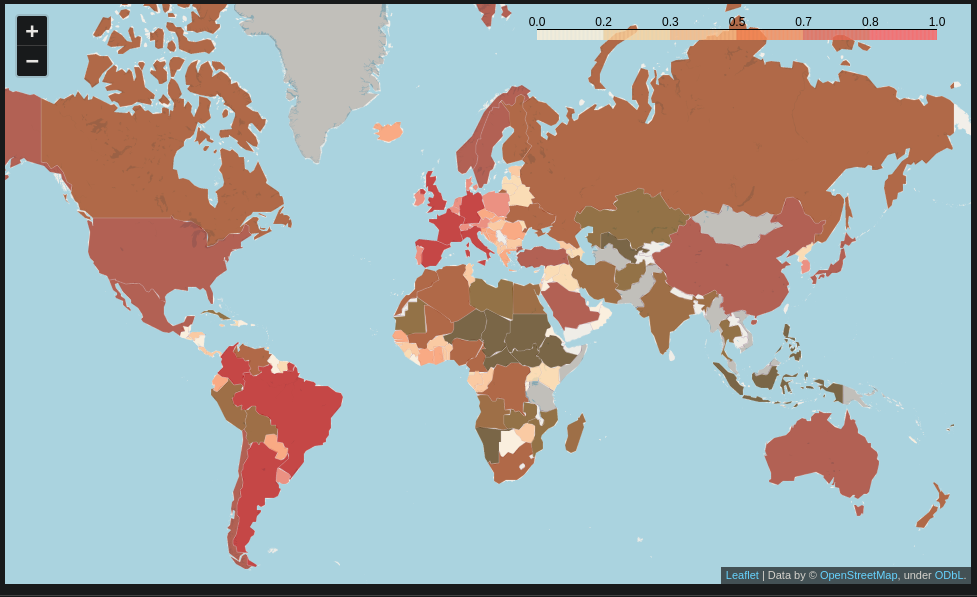

In [1]:
from IPython.display import Image
print("World Heat Map That Displays Player Distrubution by Country")
Image(filename='world_heat_map_player_count_distrubution.png')

# Table Of Contents


    • Title
        ◦ Overview And Results in Advance
        ◦ World Heat Map instance for intro
        ◦ Table Of Contents
        ◦ import libraries and datasets
        ◦ Feature Correlation (heat map)
        ◦ Extract World Club Rankings via Beautiful Soup
        ◦ Matching Club Data
            ▪ Manual Correction of Some Wrong Records
        ◦ Binning of The Ranked Soccer Clubs
        ◦ First of all, lets derive our prospective target feature 'national_player' (feature creation)
        ◦ Missing Values Treatment
            ▪ An overview on null and possible problematic values/features
                • First let's drop evidently irrelevant features
                • Null Value Percentage By Feature
            ▪ Handling Missing Data
                • Special Cases
                    ◦ remove € sign and convert into numeric value K 1000 and M 1.000.000
                    ◦ remove lbs expression from weight
                    ◦ remove ' and convert numeric (1 foot == 12 inches)
                    ◦ remove + sign and sum up both Operand
                • Filling NA values
                    ◦ missing columns to be assigned as median
                    ◦ missing columns to be assigned as mode
                    ◦ missing columns to be assigned as unknown
        ◦ Let's investigate our data
            ▪ World Heat Map Stats By Country via Folium
                • Player Counts by Country in 'data'
                • Number of Precious Players by Country in 'data' (> &#36;5,000,000)
        ◦ Match players in FIFA 19 dataset with the ones in Football Manager 2017 in order to retrieve national_player feature
            ▪ Match Nationality And NationID
            ▪ Let's start to build up our nationality dictionary with 50 nations
            ▪ Match players from 2 datasets
        ◦ Distribution of the target value (Graphs)
        ◦ Outlier Treatment
            ▪ Histograms
            ▪ So we will shrink those features via logarithmic function in order to acquire a more meaningful set of values for the training.
            ▪ Shrunk Feature Histograms
        ◦ More Feature Creation
            ▪  Creating positionID by utilizing following columns
            ▪ Creation of distance of each player's key features from his segment's mean, max and median
        ◦ Checkpoint
        ◦ Normalization
            ▪ One Hot Encoder & MinMaxScaler
        ◦ Training The Model
            ▪ Split the data frame into 2 completely separate pieces, shuffle the rows and keep 2nd half for test
            ▪ Up-Sampling
            ▪ Train Set Performance
            ▪ Validation Set Performance
        ◦ Further Investigation False Prediction Distributions
        ◦ Conclusion And Findings


#### importing libraries and 2 datasets

In [3]:
#sources 
#https://www.kaggle.com/ajinkyablaze/football-manager-data
#https://www.kaggle.com/karangadiya/fifa19
#https://footballdatabase.com/ranking/world/1
#https://github.com/python-visualization/folium/blob/master/examples/data/world-countries.json


from pandas.plotting import scatter_matrix
from time import time
from datetime import datetime  
from datetime import timedelta 
from IPython.display import display 
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.cluster import KMeans
import math 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from statistics import mean

#https://github.com/nalepae/pandarallel
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=5)


# player data from Football Manager 2017 dataset
data_fm = pd.read_csv('fm_player_stats.csv')

# player data from Fifa 19 dataset
data = pd.read_csv('fifa19.csv')

#countries world-countries.json
world_countries_json_source = 'world-countries.json'



INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Feature Correlation

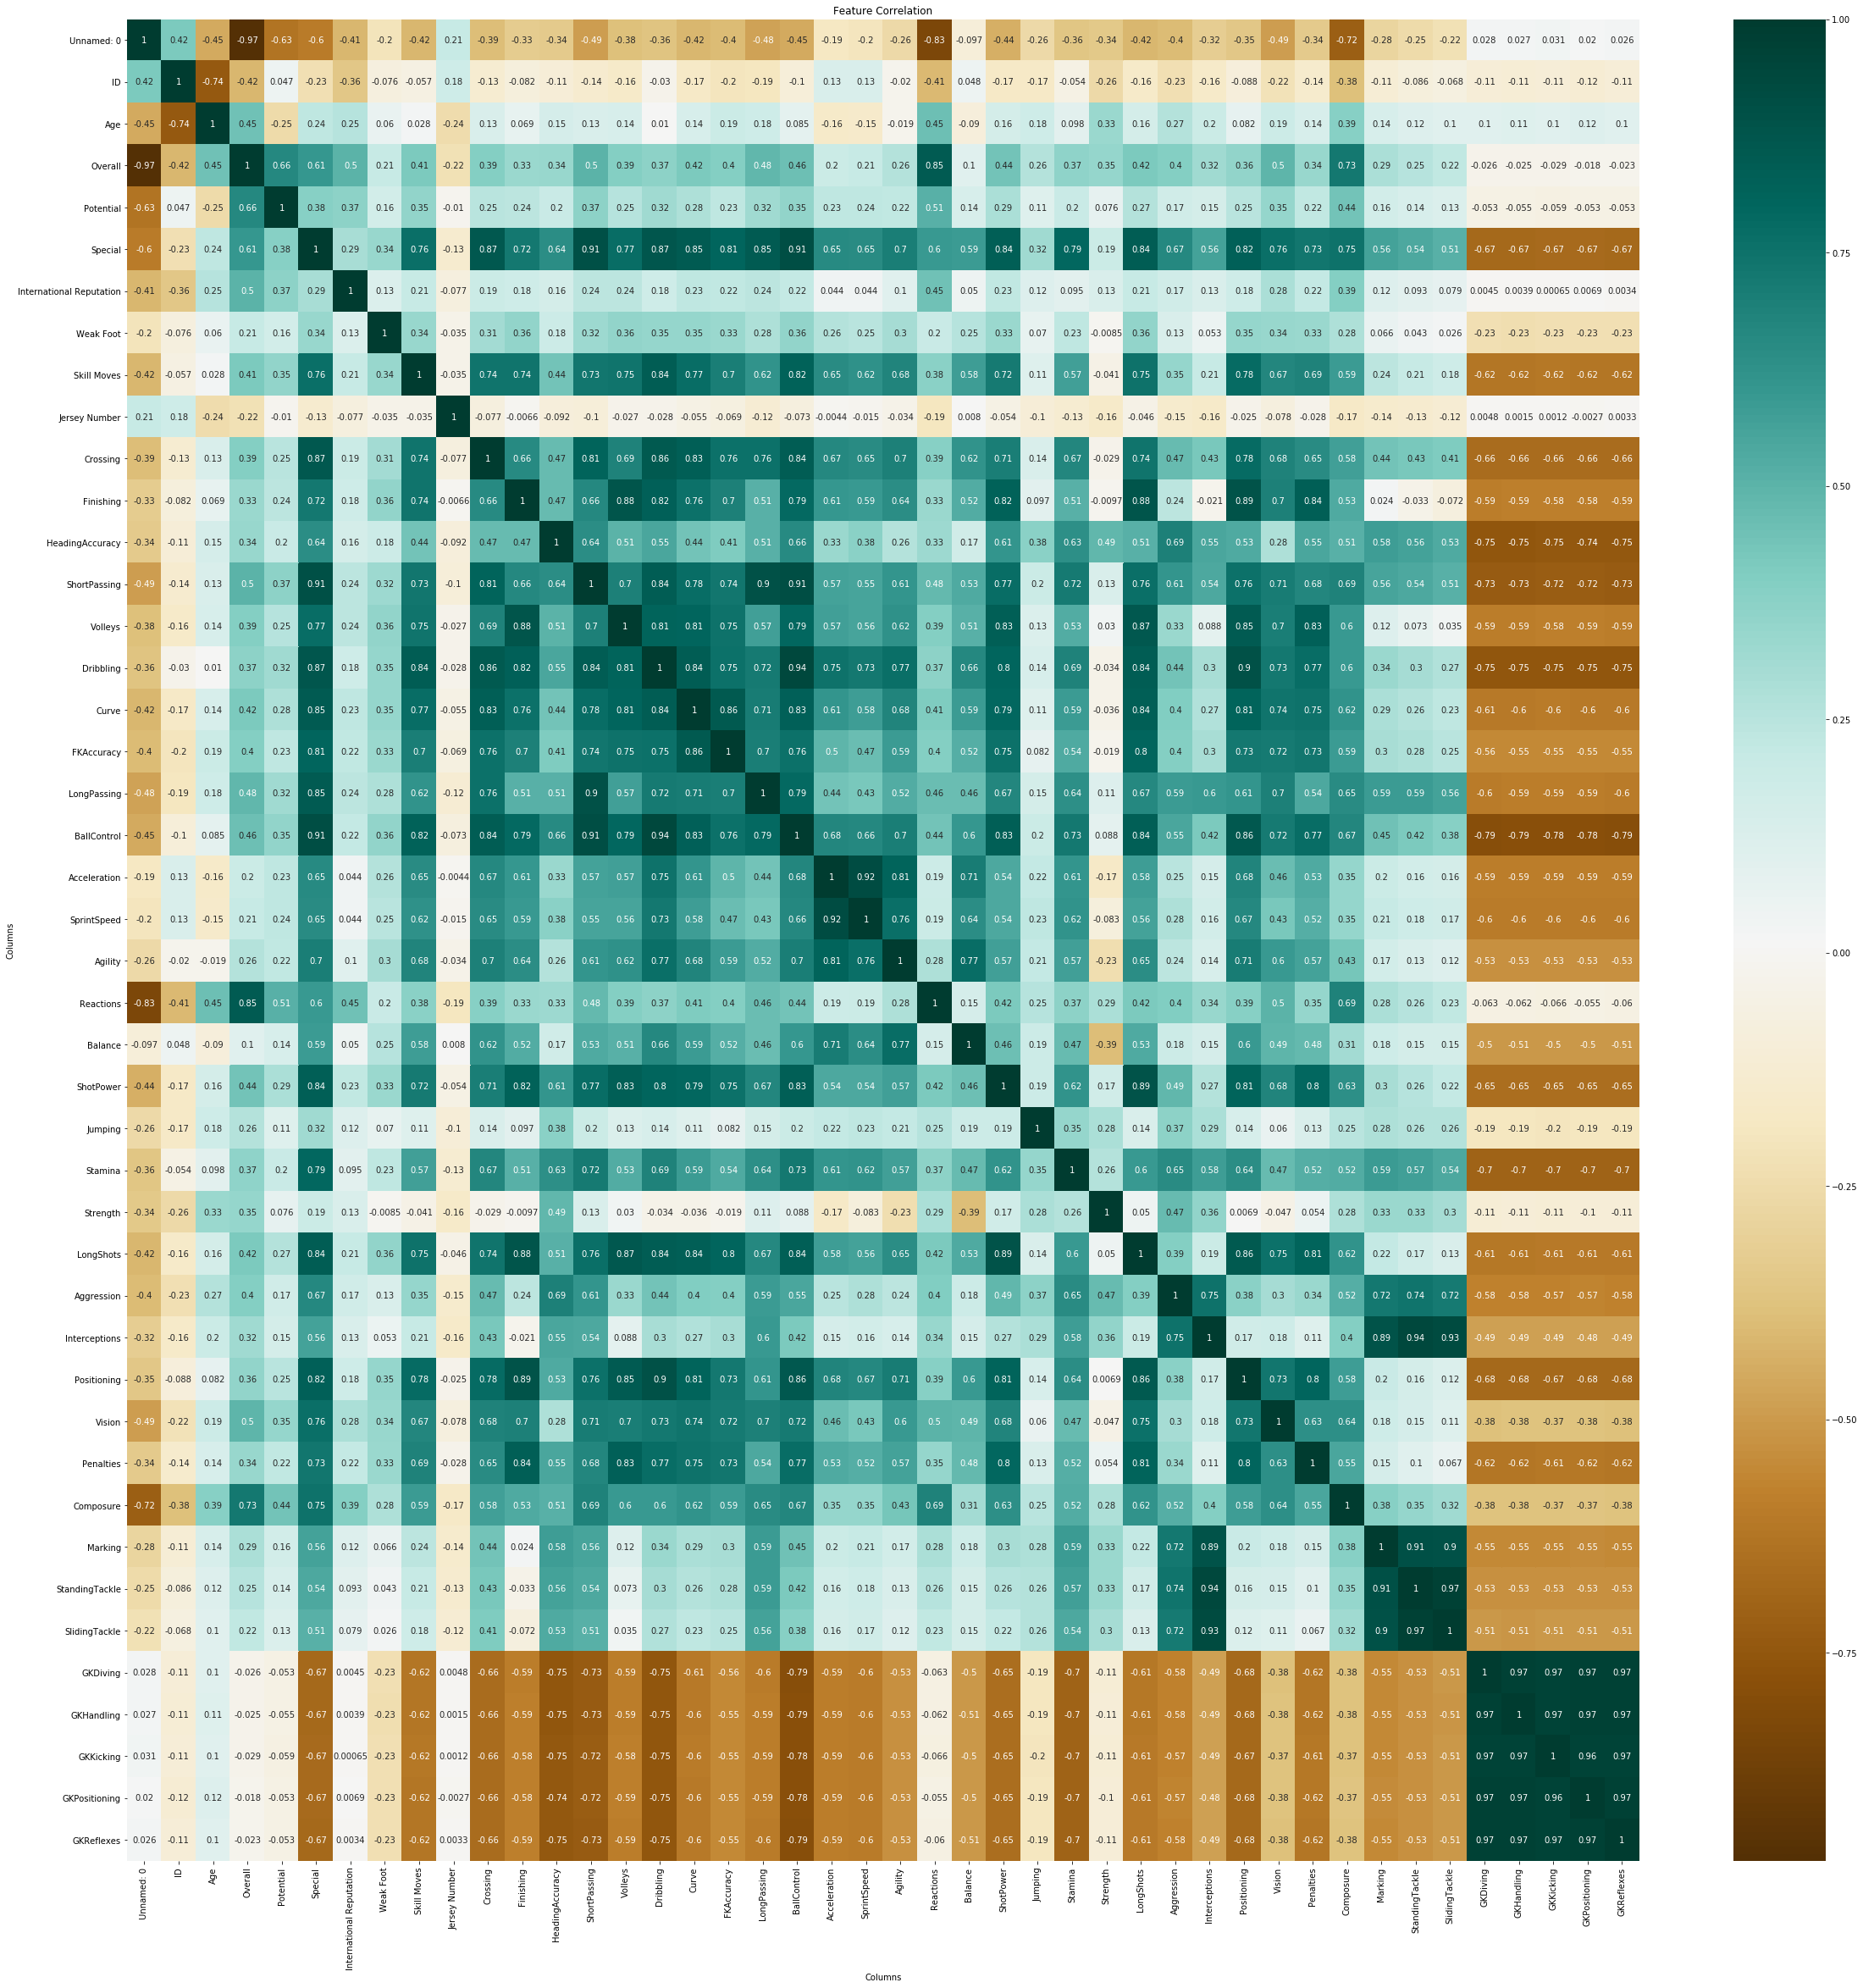

In [87]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(40,40))
sns.heatmap(data.corr(), annot=True, ax=ax, cmap='BrBG').set(title='Feature Correlation', xlabel='Columns', ylabel='Columns')
plt.show()

## Extract World Club Rankings via Beautiful Soup

Later on we will use the world rankings of the soccer clubs to create a brand new feature for our main soccer player dataset, in case this novel additional feature may help the algorithm to sort out the players' relative importance within their segment (the term segment will be defined soon).

In [88]:
import requests
from bs4 import BeautifulSoup

In [89]:
data_club_rankings = pd.DataFrame(columns=['ranking', 'club', 'country', 'points'])

In [90]:


club_data = 4*[None]

for page_id in range(1,53):
    link = 'https://footballdatabase.com/ranking/world/'+str(page_id)
    print(link)
    result = requests.get(link)
    
    src = result.content
    soup = BeautifulSoup(src, 'lxml')

    content_rank = soup.find_all('td', attrs={'class':'rank'})
    content_club_text_left = soup.find_all('td', attrs={'class':'club text-left'})

    for i, e in enumerate(content_club_text_left):
        club_data[0] = content_rank[i*2].text
        club_data[1] = e.find_all('a')[0].text
        club_data[2] = e.find_all('a')[1].text
        club_data[3] = content_rank[i*2+1].text
        data_club_rankings.loc[data_club_rankings.shape[0]] = club_data
        #print("ranking: {}  Club: {}  Country: {}  Points: {}".format(club_data[0], club_data[1], club_data[2], club_data[3]))
        print("{}".format(club_data[1]))


https://footballdatabase.com/ranking/world/1
Bayern München
Liverpool FC
Manchester City
Barcelona
Paris Saint-Germain
Juventus
Real Madrid
Atlético Madrid
Borussia Dortmund
Atalanta
Flamengo
RasenBallsport Leipzig
Inter Milan
Lazio
Ajax Amsterdam
Shakhtar Donetsk
Manchester United
Sevilla
Benfica
FC Porto
Boca Juniors
Bayer Leverkusen
Palmeiras
Chelsea FC
Borussia Mönchengladbach
Wolverhampton Wanderers
SSC Napoli
Leicester City
Olympiakos
Salzburg
Getafe
River Plate
Roma
Grêmio
Zenit St. Petersburg
Santos FC
Celtic
Arsenal
Lyon
Valencia
Tottenham Hotspur
Wolfsburg
Villarreal
PSV Eindhoven
Athletic Bilbao
Flora Tallinn
Racing Club
Real Sociedad
Slavia Prague
FC Basel
https://footballdatabase.com/ranking/world/2
Viktoria Plzeň
Dynamo Kyiv
Dinamo Zagreb
Marseille
PAOK Thessaloniki FC
PFC Ludogorets 1945 Razgrad
Al Hilal (KSA)
Atlético PR
FK Red Star Belgrade
FCI Levadia Tallinn
Feyenoord
Olimpia
İstanbul Başakşehir
Al Ahly
Sporting
Club Brugge
AZ Alkmaar
Everton FC
Hoffenheim
Crystal Pa

Le Mans
JS Saoura
Lobi Stars
RSB Berkane
Derry City
Ilves
Asteras Tripolis
Supersport United
Bochum
Criciúma
River Plate PR
PEC Zwolle
Joinville EC
Hibernian
Zürich
Vardar Skopje
Keşlə Futbol Klubu
Sturm Graz
Dinamo Bucureşti
Frosinone
Padideh F.C.
Široki Brijeg
Persipura Jayapura
Belenenses
El Nacional
FC Juárez
Bodø / Glimt
Foolad Khuzestan (IRN)
Ashanti Gold FC (GHA)
Benevento
Lechia Gdańsk
Vitória Setúbal
SC Paderborn 07 (GER)
Saturn
Temperley
Grenoble
ZESCO United
Qäbälä
Chicken Inn FC
Bari
Palermo
Deportivo Cuenca
Club Atletico Rentistas (URU)
Club Atlético Bucaramanga
St Patrick's
Envigado
US Monastir
Danubio
MP Antalyaspor
Akwa United
https://footballdatabase.com/ranking/world/14
ADO Den Haag
Austria Wien
CS Marítimo Madeira
Motor Action
Nacional Potosí
Boulogne
CS Alagoano AL
Ružomberok
Atlético San Luis
Caen
FK Mariupol Illichivets'
Topolski Sportski Club
FK Haugesund (NOR)
Zanaco
Independiente FBC (Campo Grande)
Kasımpaşa
Lugano
Grêmio Prudente
Brescia
Odds Ballklubb
Sint-Tr

Kayseri Erciyesspor
Union St.-Gilloise
FK Radnik Bijeljina
Yenisey Krasnoyarsk
AD Unión Magdalena
Platinum Stars
Deportivo Carapeguá
Chornomorets Odesa
Gwangju FC
Leixões
Université Ngaoundéré
Universidad de San Carlos
Manisaspor
Dalian Yifang
Rigas Futbola skola
Damash
Club Atletico Torque
Stellenbosch FC
Stade Tunisien
Universitatea Cluj
Iztapa (GUA)
Bayamón FC
Al Raed
Youssoufia Berrechid
Akwa Starlets
FK Tosno
FK Liepājas Metalurgs
Pusamania Borneo FC
Renaissance Club Zemamra
Grödig
Lillestrøm
Balmazújváros
DRB Tadjenanet
Independiente de La Chorrera (PAN)
Colorado Rapids
CA Palmaflor
FC Lviv
Club Atlético Grau
Chippa United FC
Sportivo San Lorenzo
Suphanburi FC
Tacuarembó
Zulia
Bendel Insurance
ASGNN
Petrojet
Shanghai Shenhua
Gombe United
Monaghan United
Eupen
https://footballdatabase.com/ranking/world/26
Unirea Urziceni
Guadalupe FC
WWS Rangers
Náutico
NK Tabor Sežana
Legon Cities FC
Zemplin Michalovce
Incheon United
El Gounah
Triangle FC
Deportivo Quito
Deportivo Walter Ferretti

How Mine
Hay Al Wadi SC
F91 Dudelange
USM Blida
SKA-Khabarovsk
Akokana
Hobro
Pirae
FK Zemun
Henderson Eels
Germinal Beerschot
Nogoom FC
Podbrezová
Atlético Venezuela
El Dakhleya
Barnechea
Primorje
Aris Limassol
Al-Dhafra
Puntarenas FC
PSIS
Termalica Nieciecza
Nitra
FK Senica
Nalkutan FC
FC Masr
Royal Wahingdoh
Elmina Sharks
Atlético Sport Aviação
Al-Khor
AS Salé
Athlone Town
Tivoli Gardens
Aarau
Nchanga Rangers
Al Ahly Benghazi
Al Akhaa Al Ahli
JSM Laâyoune
PSS Sleman
Dunaújváros Pálhalma SE
Radnički 1923 Kragujevac
NK Zadar
Nyíregyháza Spartacus
KCCA FC
Wiener Neustadt
Real Sociedad
Medimurje
FC Kapaz
Persiba Balikpapan
Gyirmót SE
https://footballdatabase.com/ranking/world/37
Grombalia Sports
Béni-Khalled
Slavia-Mozyr
Mufulira Wanderers
Al Nahdha Dammam
St. Mirren
SOL FC
Buffaloes FC
San Juan FC
Union Deportivo Universitario
Tefana
Bouaké FC
FK Donji Srem
Hrvatski Dragovoljac
Zacapa
Venus
Shark XI
Aurora
Chainat FC
Atlético Balboa
PSPS Pekanbaru
Zamfara United FC
North Eastern Re Orga

Xorazm
CAS de Sévaré
Police FC
Konkola Mine Police
AS Eliwidj FC
Al Asalah
Khimki
Songkhla United FC
Nakambala Leopards
AE Kouklion
Vidima-Rakovski
Apollon Smyrnis
Karabükspor
Chinandega FC
San Juan Jabloteh
T&TEC
Smederevo
Al Ahli SC Amman
Caledonia AIA
Wellington Phoenix Reserves
Shortan Guzor
Madang
Karvan
Mačva Šabac
Sahab SC
Longford Town
Eger
Alpha United
FC Cincinnati
Orión
Borac Čačak
Shanghai Shenxin
Quelaton
Sport Lubango e Benfica
AS Lossi
Bontang PKT
1º de Maio
North Queensland Fury
Welshpool Town
NK Zvijezda Gradacac
Hapoel Ashkelon
Wanderers SC
Jazeerat Al Feel
ART Municipal Jalapa
AD Municipal Liberia
Corona Braşov
Anagennisi Deryneia
Naftan Novopolotsk
Stade Malien Sikasso
FK Guliston
https://footballdatabase.com/ranking/world/49
Dibba Al-Fujairah Club
Haverfordwest County
Mont-Dore
Racing Beirut
Al Ittihad
Rudar Prijedor
Kaliakra
Hatta
El Nsoor
Avispa Fukuoka
Atlético Veragüense
Qizilqum Zarafshon
Forest Rangers
Lietava Jonava
Al-Yarmouk FC
Travnik
Sporting de Cabinda


In [91]:
len(data.Club.unique())

652

In [92]:
data_club_rankings.head()

ranking                 club  country points
0       1       Bayern München  Germany   2052
1       2         Liverpool FC  England   2013
2       3      Manchester City  England   1958
3       4            Barcelona    Spain   1947
4       5  Paris Saint-Germain   France   1927

### Matching Club Data

In [93]:
# from data to data_club_rankings
dict_club = {}
u_clubs = data.Club.unique()
ranked_clubs = list(data_club_rankings.club)
clubs_not_found = []

# u_club in data,  club in ranked_clubs
for u_club in u_clubs:
    if u_club not in list(ranked_clubs):
        is_found=False
        for club in ranked_clubs:
            condition_A = str(club) in str(u_club)
            condition_B = str(u_club) in str(club)
            if condition_A or condition_B:
                is_found = True
                dict_club[u_club] = club
                ranked_clubs.remove(club)
                break
        if not is_found:
            # check longest
            is_lengest_word_contained = False
            words_in_u_club = u_club.split(' ')
            len_words = [len(n) for n in words_in_u_club]
            np_list_len_words_in_u_club = np.array(len_words)
            longest_word_in_u_club = words_in_u_club[np_list_len_words_in_u_club.argmax()]
            for club in ranked_clubs:
                if longest_word_in_u_club in club:
                    dict_club[u_club] = club
                    ranked_clubs.remove(club)
                    is_lengest_word_contained = True
                    break
            if not is_lengest_word_contained:
                clubs_not_found.append(u_club)
    else:
        dict_club[u_club] = u_club
        ranked_clubs.remove(u_club)

In [94]:
clubs_not_found

['Tianjin Quanjian FC',
 'Hebei China Fortune FC',
 'Internacional',
 'Stade Rennais FC',
 'Olympiacos CFP',
 'Kasimpaşa SK',
 'Shanghai Greenland Shenhua FC',
 'Colo-Colo',
 'CD Leganés',
 'Al Taawoun',
 'Foggia',
 'BB Erzurumspor',
 'Atlético Paranaense',
 'U.N.A.M.',
 'Nottingham Forest',
 'SV Zulte-Waregem',
 'Real Oviedo',
 'Albacete BP',
 'Preston North End',
 'Holstein Kiel',
 '1. FC Heidenheim 1846',
 'Brentford',
 'Sheffield United',
 'Venezia FC',
 'CD Lugo',
 'Henan Jianye FC',
 'CD Numancia',
 'Sporting de Charleroi',
 'Sheffield Wednesday',
 'Perugia',
 'Hellas Verona',
 'Millwall',
 'Cádiz CF',
 'Al Fayha',
 'Bristol City',
 'US Cremonese',
 'Gimnàstic de Tarragona',
 'CF Reus Deportiu',
 'US Salernitana 1919',
 'AD Alcorcón',
 'Spezia',
 'Aalborg BK',
 'Le Havre AC',
 'Górnik Zabrze',
 'Cittadella',
 'SV Sandhausen',
 'KFC Uerdingen 05',
 'MSV Duisburg',
 'DSC Arminia Bielefeld',
 'Ipswich Town',
 'CF Rayo Majadahonda',
 'Extremadura UD',
 'AS Béziers',
 'La Berrichonne 

In [95]:
dict_club

{'FC Barcelona': 'Barcelona',
 'Juventus': 'Juventus',
 'Paris Saint-Germain': 'Paris Saint-Germain',
 'Manchester United': 'Manchester United',
 'Manchester City': 'Manchester City',
 'Chelsea': 'Chelsea FC',
 'Real Madrid': 'Real Madrid',
 'Atlético Madrid': 'Atlético Madrid',
 'FC Bayern München': 'Bayern München',
 'Tottenham Hotspur': 'Tottenham Hotspur',
 'Liverpool': 'Liverpool',
 'Napoli': 'SSC Napoli',
 'Arsenal': 'Arsenal',
 'Milan': 'Inter Milan',
 'Inter': 'Internacional',
 'Lazio': 'Lazio',
 'Borussia Dortmund': 'Borussia Dortmund',
 'Vissel Kobe': 'Vissel Kobe',
 'Olympique Lyonnais': 'Lyon',
 'Roma': 'Roma',
 'Valencia CF': 'Valencia',
 'Guangzhou Evergrande Taobao FC': 'Guangzhou Evergrande',
 'FC Porto': 'FC Porto',
 'FC Schalke 04': 'Schalke 04',
 'Beşiktaş JK': 'Beşiktaş',
 'LA Galaxy': 'Los Angeles Galaxy',
 'Sporting CP': 'Sporting',
 'Real Betis': 'Real Betis',
 'Olympique de Marseille': 'Marseille',
 'RC Celta': 'Celta Vigo',
 'Bayer 04 Leverkusen': 'Ba',
 'Real 

### Manual Correction of Some Wrong Records

In [96]:
data_club_rankings[data_club_rankings.club.str.lower().str.contains('bren')]
#data_club_rankings[data_club_rankings.country=='France']

ranking               club                 country points
2501    2502  Gradina Srebrenik  Bosnia and Herzegovina   1196

In [97]:
# correction on dictionary
dict_club[None] = 'unknown'
dict_club['Bayer 04 Leverkusen'] = 'Bayer Leverkusen'
dict_club['PFC CSKA Moscow'] = 'CSKA Moskva'
dict_club['Tigres U.A.N.L.'] = 'Tigres UANL'
dict_club['Derby County'] = 'Ross County'
dict_club['Club Atlético Talleres'] = 'Talleres de Cordoba'
dict_club['Ceará Sporting Club'] = 'Ceará SC'
dict_club['Rionegro Águilas'] = 'Águilas Doradas'
dict_club['América de Cali'] = 'América de Cali'
dict_club['Central Coast Mariners'] = 'Central Coast Mariners FC'
dict_club['US Orléans Loiret Football'] = 'unknown'
dict_club['Jaguares de Córdoba'] = 'CD Jaguares'
dict_club['Oldham Athletic'] = 'unknown'
dict_club['Notts County'] = 'unknown'
dict_club['Port Vale'] = 'unknown'
dict_club['Forest Green Rovers'] = 'unknown'
dict_club['Inter'] = 'Inter Milan'
dict_club['Internacional'] = 'Internacional'

In [98]:
# adding 'unknown' record to 'data_club_rankings' data frame
club_data = [data_club_rankings.shape[0], 'unknown', 'unknown', int(data_club_rankings.points.min())-20]
data_club_rankings.loc[data_club_rankings.shape[0]] = club_data

## Feature Creation

### Binning of The Ranked Soccer Clubs

- The clubs will be distributed into different buckets(categories) based on their points, from 14 to 1.
- The higher the bucket no is the the successful the clubs within are.
- The capacity of the buckets increases by 1.42 times for each number, so that the better clubs will be in narrower buckets and the unsuccessful clubs will be assigned to geometrically larger buckets relatively.

In [99]:
starting_position_for_cr_bin = 0
cr_bin_size = 10
extension_factor = 1.42
bin_no = 0
for i in range(data_club_rankings.shape[0]):
    if i == data_club_rankings.shape[0]-1:
        data_club_rankings.at[i, 'segment_point'] = bin_no+1
        break
    if i < starting_position_for_cr_bin + cr_bin_size:
        data_club_rankings.at[i, 'segment_point'] = bin_no
    elif i == starting_position_for_cr_bin + cr_bin_size:
        starting_position_for_cr_bin = i
        cr_bin_size = int(cr_bin_size * extension_factor)
        bin_no += 1
        data_club_rankings.at[i, 'segment_point'] = bin_no

for i in range(data_club_rankings.shape[0]):
    data_club_rankings.at[i, 'segment_point'] = data_club_rankings.segment_point.max() - data_club_rankings.segment_point[i]

In [100]:
data_club_rankings.head()

ranking                 club  country points  segment_point
0       1       Bayern München  Germany   2052           14.0
1       2         Liverpool FC  England   2013           14.0
2       3      Manchester City  England   1958           14.0
3       4            Barcelona    Spain   1947           14.0
4       5  Paris Saint-Germain   France   1927           14.0

In [101]:
list(data_club_rankings[data_club_rankings.club == 'Inter Milan'].country)[0]

'Italy'

In [102]:
for i in range(data.shape[0]):
    match_in_ranked_clubs_df = 'unknown'
    if data.Club[i] in dict_club:
        match_in_ranked_clubs_df = dict_club[data.Club[i]]
    print("club: {},  match_in_ranked_clubs_df: {}".format(data.Club[i], match_in_ranked_clubs_df))
    cr_segment_point = list(data_club_rankings[data_club_rankings.club == match_in_ranked_clubs_df].segment_point)[0]
    cr_country = list(data_club_rankings[data_club_rankings.club == match_in_ranked_clubs_df].country)[0]
    #print("club: {},  match_in_ranked_clubs_df: {},  cr_segment_point: {},  cr_country: {}".format(data.Club[i], match_in_ranked_clubs_df, cr_segment_point, cr_country))
    data.at[i, 'club_segment_point'] = cr_segment_point
    data.at[i, 'club_country'] = cr_country

club: FC Barcelona,  match_in_ranked_clubs_df: Barcelona
club: Juventus,  match_in_ranked_clubs_df: Juventus
club: Paris Saint-Germain,  match_in_ranked_clubs_df: Paris Saint-Germain
club: Manchester United,  match_in_ranked_clubs_df: Manchester United
club: Manchester City,  match_in_ranked_clubs_df: Manchester City
club: Chelsea,  match_in_ranked_clubs_df: Chelsea FC
club: Real Madrid,  match_in_ranked_clubs_df: Real Madrid
club: FC Barcelona,  match_in_ranked_clubs_df: Barcelona
club: Real Madrid,  match_in_ranked_clubs_df: Real Madrid
club: Atlético Madrid,  match_in_ranked_clubs_df: Atlético Madrid
club: FC Bayern München,  match_in_ranked_clubs_df: Bayern München
club: Real Madrid,  match_in_ranked_clubs_df: Real Madrid
club: Atlético Madrid,  match_in_ranked_clubs_df: Atlético Madrid
club: Manchester City,  match_in_ranked_clubs_df: Manchester City
club: Chelsea,  match_in_ranked_clubs_df: Chelsea FC
club: Juventus,  match_in_ranked_clubs_df: Juventus
club: Tottenham Hotspur,  m

club: Paris Saint-Germain,  match_in_ranked_clubs_df: Paris Saint-Germain
club: Liverpool,  match_in_ranked_clubs_df: Liverpool
club: FC Bayern München,  match_in_ranked_clubs_df: Bayern München
club: Atlético Madrid,  match_in_ranked_clubs_df: Atlético Madrid
club: FC Bayern München,  match_in_ranked_clubs_df: Bayern München
club: Bayer 04 Leverkusen,  match_in_ranked_clubs_df: Bayer Leverkusen
club: Guangzhou Evergrande Taobao FC,  match_in_ranked_clubs_df: Guangzhou Evergrande
club: RB Leipzig,  match_in_ranked_clubs_df: RasenBallsport Leipzig
club: Paris Saint-Germain,  match_in_ranked_clubs_df: Paris Saint-Germain
club: FC Bayern München,  match_in_ranked_clubs_df: Bayern München
club: Sevilla FC,  match_in_ranked_clubs_df: Sevilla
club: Ajax,  match_in_ranked_clubs_df: Ajax
club: Real Madrid,  match_in_ranked_clubs_df: Real Madrid
club: Dalian YiFang FC,  match_in_ranked_clubs_df: Dalian Yifang
club: Villarreal CF,  match_in_ranked_clubs_df: Villarreal
club: FC Porto,  match_in_r

club: Levante UD,  match_in_ranked_clubs_df: Levante
club: Fulham,  match_in_ranked_clubs_df: Fulham
club: Inter,  match_in_ranked_clubs_df: Inter Milan
club: Inter,  match_in_ranked_clubs_df: Inter Milan
club: Athletic Club de Bilbao,  match_in_ranked_clubs_df: Athletic Bilbao
club: Atlético Madrid,  match_in_ranked_clubs_df: Atlético Madrid
club: Chelsea,  match_in_ranked_clubs_df: Chelsea FC
club: Inter,  match_in_ranked_clubs_df: Inter Milan
club: Lazio,  match_in_ranked_clubs_df: Lazio
club: Napoli,  match_in_ranked_clubs_df: SSC Napoli
club: Napoli,  match_in_ranked_clubs_df: SSC Napoli
club: Leicester City,  match_in_ranked_clubs_df: Leicester City
club: SL Benfica,  match_in_ranked_clubs_df: Benfica
club: Borussia Dortmund,  match_in_ranked_clubs_df: Borussia Dortmund
club: Watford,  match_in_ranked_clubs_df: Watford
club: Atlanta United,  match_in_ranked_clubs_df: Atlanta United Fc
club: Villarreal CF,  match_in_ranked_clubs_df: Villarreal
club: Borussia Mönchengladbach,  matc

club: Real Betis,  match_in_ranked_clubs_df: Real Betis
club: VfL Wolfsburg,  match_in_ranked_clubs_df: Wolfsburg
club: FC Bayern München,  match_in_ranked_clubs_df: Bayern München
club: Milan,  match_in_ranked_clubs_df: Inter Milan
club: Girona FC,  match_in_ranked_clubs_df: Girona
club: RB Leipzig,  match_in_ranked_clubs_df: RasenBallsport Leipzig
club: Villarreal CF,  match_in_ranked_clubs_df: Villarreal
club: Manchester City,  match_in_ranked_clubs_df: Manchester City
club: Liverpool,  match_in_ranked_clubs_df: Liverpool
club: Olympique Lyonnais,  match_in_ranked_clubs_df: Lyon
club: Everton,  match_in_ranked_clubs_df: Everton FC
club: Tianjin Quanjian FC,  match_in_ranked_clubs_df: unknown
club: Getafe CF,  match_in_ranked_clubs_df: Getafe
club: Arsenal,  match_in_ranked_clubs_df: Arsenal
club: Athletic Club de Bilbao,  match_in_ranked_clubs_df: Athletic Bilbao
club: Beijing Renhe FC,  match_in_ranked_clubs_df: Beijing Renhe
club: Valencia CF,  match_in_ranked_clubs_df: Valencia
c

club: Leicester City,  match_in_ranked_clubs_df: Leicester City
club: Galatasaray SK,  match_in_ranked_clubs_df: Galatasaray
club: Borussia Mönchengladbach,  match_in_ranked_clubs_df: Borussia Mönchengladbach
club: Sevilla FC,  match_in_ranked_clubs_df: Sevilla
club: SC Freiburg,  match_in_ranked_clubs_df: Freiburg (GER)
club: Napoli,  match_in_ranked_clubs_df: SSC Napoli
club: Crystal Palace,  match_in_ranked_clubs_df: Crystal Palace
club: Real Betis,  match_in_ranked_clubs_df: Real Betis
club: AS Monaco,  match_in_ranked_clubs_df: Monaco
club: Jiangsu Suning FC,  match_in_ranked_clubs_df: Jiangsu Suning FC
club: West Ham United,  match_in_ranked_clubs_df: West Ham United
club: Fulham,  match_in_ranked_clubs_df: Fulham
club: Real Madrid,  match_in_ranked_clubs_df: Real Madrid
club: Getafe CF,  match_in_ranked_clubs_df: Getafe
club: Everton,  match_in_ranked_clubs_df: Everton FC
club: Manchester United,  match_in_ranked_clubs_df: Manchester United
club: PAOK,  match_in_ranked_clubs_df:

club: Rio Ave FC,  match_in_ranked_clubs_df: Rio Ave
club: FC Girondins de Bordeaux,  match_in_ranked_clubs_df: Bordeaux
club: Montpellier HSC,  match_in_ranked_clubs_df: Montpellier
club: Sporting CP,  match_in_ranked_clubs_df: Sporting
club: River Plate,  match_in_ranked_clubs_df: River Plate
club: Cruz Azul,  match_in_ranked_clubs_df: Cruz Azul
club: Al Ahli,  match_in_ranked_clubs_df: Al Ahli
club: AS Saint-Étienne,  match_in_ranked_clubs_df: Saint-Étienne
club: Atalanta,  match_in_ranked_clubs_df: Atalanta
club: Manchester City,  match_in_ranked_clubs_df: Manchester City
club: Hebei China Fortune FC,  match_in_ranked_clubs_df: unknown
club: Melbourne Victory,  match_in_ranked_clubs_df: Melbourne Victory
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: Watford,  match_in_ranked_clubs_df: Watford
club: Real Betis,  match_in_ranked_clubs_df: Real Betis
club: RC Celta,  match_in_ranked_clubs_df: Celta Vigo
club: Lazio,  match_in_ranked_clubs_df: Lazio
club: Sevilla FC,  matc

club: Burnley,  match_in_ranked_clubs_df: Burnley
club: Botafogo,  match_in_ranked_clubs_df: Botafogo FR RJ (BRA)
club: Bologna,  match_in_ranked_clubs_df: Bologna
club: PFC CSKA Moscow,  match_in_ranked_clubs_df: CSKA Moskva
club: TSG 1899 Hoffenheim,  match_in_ranked_clubs_df: Hoffenheim
club: Medipol Başakşehir FK,  match_in_ranked_clubs_df: İstanbul Başakşehir
club: LA Galaxy,  match_in_ranked_clubs_df: Los Angeles Galaxy
club: PSV,  match_in_ranked_clubs_df: PSV Eindhoven
club: Borussia Dortmund,  match_in_ranked_clubs_df: Borussia Dortmund
club: Juventus,  match_in_ranked_clubs_df: Juventus
club: Bayer 04 Leverkusen,  match_in_ranked_clubs_df: Bayer Leverkusen
club: Brighton & Hove Albion,  match_in_ranked_clubs_df: Brighton & Hove Albion
club: Parma,  match_in_ranked_clubs_df: Parma
club: Club América,  match_in_ranked_clubs_df: América de Cali
club: Udinese,  match_in_ranked_clubs_df: Udinese
club: VfB Stuttgart,  match_in_ranked_clubs_df: VfB Stuttgart
club: Brighton & Hove Al

club: Fenerbahçe SK,  match_in_ranked_clubs_df: Fenerbahçe
club: Paris Saint-Germain,  match_in_ranked_clubs_df: Paris Saint-Germain
club: Udinese,  match_in_ranked_clubs_df: Udinese
club: SV Werder Bremen,  match_in_ranked_clubs_df: Werder Bremen
club: Trabzonspor,  match_in_ranked_clubs_df: Trabzonspor
club: FC Nantes,  match_in_ranked_clubs_df: Nantes
club: Paris Saint-Germain,  match_in_ranked_clubs_df: Paris Saint-Germain
club: Southampton,  match_in_ranked_clubs_df: Southampton
club: Hannover 96,  match_in_ranked_clubs_df: Hannover 96
club: Tianjin TEDA FC,  match_in_ranked_clubs_df: Tianjin Tianhai
club: VfL Wolfsburg,  match_in_ranked_clubs_df: Wolfsburg
club: SL Benfica,  match_in_ranked_clubs_df: Benfica
club: Olympique Lyonnais,  match_in_ranked_clubs_df: Lyon
club: Borussia Dortmund,  match_in_ranked_clubs_df: Borussia Dortmund
club: Sporting CP,  match_in_ranked_clubs_df: Sporting
club: Bologna,  match_in_ranked_clubs_df: Bologna
club: SL Benfica,  match_in_ranked_clubs_df

club: FC Girondins de Bordeaux,  match_in_ranked_clubs_df: Bordeaux
club: Hertha BSC,  match_in_ranked_clubs_df: Hertha BSC
club: Crystal Palace,  match_in_ranked_clubs_df: Crystal Palace
club: BSC Young Boys,  match_in_ranked_clubs_df: Young Boys
club: Angers SCO,  match_in_ranked_clubs_df: Angers
club: Paraná,  match_in_ranked_clubs_df: Paraná Clube
club: Villarreal CF,  match_in_ranked_clubs_df: Villarreal
club: TSG 1899 Hoffenheim,  match_in_ranked_clubs_df: Hoffenheim
club: Ajax,  match_in_ranked_clubs_df: Ajax
club: Brighton & Hove Albion,  match_in_ranked_clubs_df: Brighton & Hove Albion
club: Hamburger SV,  match_in_ranked_clubs_df: Hamburger SV
club: Spartak Moscow,  match_in_ranked_clubs_df: Spartak Moskva
club: Olympique Lyonnais,  match_in_ranked_clubs_df: Lyon
club: Tigres U.A.N.L.,  match_in_ranked_clubs_df: Tigres UANL
club: Montpellier HSC,  match_in_ranked_clubs_df: Montpellier
club: PSV,  match_in_ranked_clubs_df: PSV Eindhoven
club: FC Augsburg,  match_in_ranked_club

club: KRC Genk,  match_in_ranked_clubs_df: KRC Genk
club: FC Basel 1893,  match_in_ranked_clubs_df: FC Basel
club: West Ham United,  match_in_ranked_clubs_df: West Ham United
club: Feyenoord,  match_in_ranked_clubs_df: Feyenoord
club: Bournemouth,  match_in_ranked_clubs_df: AFC Bournemouth
club: Medipol Başakşehir FK,  match_in_ranked_clubs_df: İstanbul Başakşehir
club: Bologna,  match_in_ranked_clubs_df: Bologna
club: SPAL,  match_in_ranked_clubs_df: SPAL 2013
club: Udinese,  match_in_ranked_clubs_df: Udinese
club: SC Braga,  match_in_ranked_clubs_df: Braga
club: AZ Alkmaar,  match_in_ranked_clubs_df: AZ Alkmaar
club: Beşiktaş JK,  match_in_ranked_clubs_df: Beşiktaş
club: AZ Alkmaar,  match_in_ranked_clubs_df: AZ Alkmaar
club: Real Betis,  match_in_ranked_clubs_df: Real Betis
club: Real Valladolid CF,  match_in_ranked_clubs_df: Real Valladolid
club: Athletic Club de Bilbao,  match_in_ranked_clubs_df: Athletic Bilbao
club: FC Girondins de Bordeaux,  match_in_ranked_clubs_df: Bordeaux
c

club: Torino,  match_in_ranked_clubs_df: Torino
club: RB Leipzig,  match_in_ranked_clubs_df: RasenBallsport Leipzig
club: Montpellier HSC,  match_in_ranked_clubs_df: Montpellier
club: Club Atlético Colón,  match_in_ranked_clubs_df: Atlético PR
club: AS Saint-Étienne,  match_in_ranked_clubs_df: Saint-Étienne
club: Vitória,  match_in_ranked_clubs_df: Vitória
club: Udinese,  match_in_ranked_clubs_df: Udinese
club: Tigres U.A.N.L.,  match_in_ranked_clubs_df: Tigres UANL
club: Olympiacos CFP,  match_in_ranked_clubs_df: unknown
club: Tottenham Hotspur,  match_in_ranked_clubs_df: Tottenham Hotspur
club: Real Betis,  match_in_ranked_clubs_df: Real Betis
club: Amiens SC,  match_in_ranked_clubs_df: Amiens SC
club: Internacional,  match_in_ranked_clubs_df: Internacional
club: Amiens SC,  match_in_ranked_clubs_df: Amiens SC
club: Club América,  match_in_ranked_clubs_df: América de Cali
club: FC København,  match_in_ranked_clubs_df: København
club: FC Red Bull Salzburg,  match_in_ranked_clubs_df: S

club: Chievo Verona,  match_in_ranked_clubs_df: Chievo Verona
club: RC Celta,  match_in_ranked_clubs_df: Celta Vigo
club: San Lorenzo de Almagro,  match_in_ranked_clubs_df: San Lorenzo
club: Udinese,  match_in_ranked_clubs_df: Udinese
club: Aston Villa,  match_in_ranked_clubs_df: Aston Villa
club: FC Red Bull Salzburg,  match_in_ranked_clubs_df: Salzburg
club: Southampton,  match_in_ranked_clubs_df: Southampton
club: PSV,  match_in_ranked_clubs_df: PSV Eindhoven
club: Dijon FCO,  match_in_ranked_clubs_df: Dijon
club: Lazio,  match_in_ranked_clubs_df: Lazio
club: Deportivo Alavés,  match_in_ranked_clubs_df: Deportivo Alaves
club: MKE Ankaragücü,  match_in_ranked_clubs_df: Ankaragücü
club: Chongqing Dangdai Lifan FC SWM Team,  match_in_ranked_clubs_df: Chongqing Lifan
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: Eintracht Frankfurt,  match_in_ranked_clubs_df: Eintracht Frankfurt
club: Kashima Antlers,  match_in_ranked_clubs_df: Kashima Antlers
club: Parma,  match_in_ranked_

club: Getafe CF,  match_in_ranked_clubs_df: Getafe
club: SK Slavia Praha,  match_in_ranked_clubs_df: Slavia Prague
club: SC Freiburg,  match_in_ranked_clubs_df: Freiburg (GER)
club: Vitesse,  match_in_ranked_clubs_df: Vitesse
club: Leeds United,  match_in_ranked_clubs_df: Sheffield United FC
club: West Bromwich Albion,  match_in_ranked_clubs_df: West Brom
club: Rayo Vallecano,  match_in_ranked_clubs_df: Rayo Vallecano
club: Cruz Azul,  match_in_ranked_clubs_df: Cruz Azul
club: Olympiacos CFP,  match_in_ranked_clubs_df: unknown
club: Independiente,  match_in_ranked_clubs_df: Independiente
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: Celtic,  match_in_ranked_clubs_df: Celtic
club: Bologna,  match_in_ranked_clubs_df: Bologna
club: Racing Club,  match_in_ranked_clubs_df: Racing Club
club: Al Nassr,  match_in_ranked_clubs_df: Al Nassr
club: Feyenoord,  match_in_ranked_clubs_df: Feyenoord
club: Brentford,  match_in_ranked_clubs_df: unknown
club: Atlético Paranaense,  match_in_r

club: Santos Laguna,  match_in_ranked_clubs_df: Santos Laguna
club: RC Celta,  match_in_ranked_clubs_df: Celta Vigo
club: Valencia CF,  match_in_ranked_clubs_df: Valencia
club: Al Wehda,  match_in_ranked_clubs_df: Al-Wehdat SC
club: Santos Laguna,  match_in_ranked_clubs_df: Santos Laguna
club: Stade de Reims,  match_in_ranked_clubs_df: Reims
club: Getafe CF,  match_in_ranked_clubs_df: Getafe
club: Bursaspor,  match_in_ranked_clubs_df: Bursaspor
club: Venezia FC,  match_in_ranked_clubs_df: unknown
club: Chicago Fire,  match_in_ranked_clubs_df: Chicago Fire
club: Fluminense,  match_in_ranked_clubs_df: Fluminense FC
club: Cagliari,  match_in_ranked_clubs_df: Cagliari
club: CD Lugo,  match_in_ranked_clubs_df: unknown
club: SV Werder Bremen,  match_in_ranked_clubs_df: Werder Bremen
club: Henan Jianye FC,  match_in_ranked_clubs_df: unknown
club: Orlando City SC,  match_in_ranked_clubs_df: Orlando City
club: CA Osasuna,  match_in_ranked_clubs_df: Osasuna
club: Real Salt Lake,  match_in_ranked

club: Dinamo Zagreb,  match_in_ranked_clubs_df: Dinamo Zagreb
club: Olympiacos CFP,  match_in_ranked_clubs_df: unknown
club: Brighton & Hove Albion,  match_in_ranked_clubs_df: Brighton & Hove Albion
club: Eintracht Frankfurt,  match_in_ranked_clubs_df: Eintracht Frankfurt
club: FC Girondins de Bordeaux,  match_in_ranked_clubs_df: Bordeaux
club: UD Las Palmas,  match_in_ranked_clubs_df: Las Palmas
club: Rangers FC,  match_in_ranked_clubs_df: Rangers
club: FC Schalke 04,  match_in_ranked_clubs_df: Schalke 04
club: Club León,  match_in_ranked_clubs_df: León
club: Watford,  match_in_ranked_clubs_df: Watford
club: Cardiff City,  match_in_ranked_clubs_df: Cardiff City
club: TSG 1899 Hoffenheim,  match_in_ranked_clubs_df: Hoffenheim
club: Blackburn Rovers,  match_in_ranked_clubs_df: Blackburn Rovers F.C.
club: 1. FC Nürnberg,  match_in_ranked_clubs_df: Nürnberg
club: Norwich City,  match_in_ranked_clubs_df: Norwich City
club: GD Chaves,  match_in_ranked_clubs_df: Chaves
club: Spartak Moscow, 

club: Sampdoria,  match_in_ranked_clubs_df: Sampdoria
club: RC Celta,  match_in_ranked_clubs_df: Celta Vigo
club: Godoy Cruz,  match_in_ranked_clubs_df: Godoy Cruz Antonio Tomba
club: Rosario Central,  match_in_ranked_clubs_df: Rosario Central
club: Grasshopper Club Zürich,  match_in_ranked_clubs_df: Grasshopper Club Zürich
club: Independiente,  match_in_ranked_clubs_df: Independiente
club: Angers SCO,  match_in_ranked_clubs_df: Angers
club: Sivasspor,  match_in_ranked_clubs_df: Sivasspor
club: Nîmes Olympique,  match_in_ranked_clubs_df: Nîmes Olympique
club: Henan Jianye FC,  match_in_ranked_clubs_df: unknown
club: Kasimpaşa SK,  match_in_ranked_clubs_df: unknown
club: Bournemouth,  match_in_ranked_clubs_df: AFC Bournemouth
club: SV Darmstadt 98,  match_in_ranked_clubs_df: Darmstadt
club: Angers SCO,  match_in_ranked_clubs_df: Angers
club: Rosenborg BK,  match_in_ranked_clubs_df: Rosenborg BK
club: FC København,  match_in_ranked_clubs_df: København
club: Universidad Católica,  match_i

club: Bahia,  match_in_ranked_clubs_df: Bahia
club: Cádiz CF,  match_in_ranked_clubs_df: unknown
club: West Bromwich Albion,  match_in_ranked_clubs_df: West Brom
club: AS Saint-Étienne,  match_in_ranked_clubs_df: Saint-Étienne
club: Queens Park Rangers,  match_in_ranked_clubs_df: Queens Park Rangers
club: FC Red Bull Salzburg,  match_in_ranked_clubs_df: Salzburg
club: RSC Anderlecht,  match_in_ranked_clubs_df: RSC Anderlecht
club: PSV,  match_in_ranked_clubs_df: PSV Eindhoven
club: Fenerbahçe SK,  match_in_ranked_clubs_df: Fenerbahçe
club: Patriotas Boyacá FC,  match_in_ranked_clubs_df: Patriotas Boyacá
club: Bologna,  match_in_ranked_clubs_df: Bologna
club: Molde FK,  match_in_ranked_clubs_df: Molde FK
club: Bristol City,  match_in_ranked_clubs_df: unknown
club: Newcastle United,  match_in_ranked_clubs_df: Newcastle United
club: Trabzonspor,  match_in_ranked_clubs_df: Trabzonspor
club: RC Strasbourg Alsace,  match_in_ranked_clubs_df: RC Strasbourg
club: CD Leganés,  match_in_ranked_cl

club: Guadalajara,  match_in_ranked_clubs_df: Guadalajara
club: Rangers FC,  match_in_ranked_clubs_df: Rangers
club: Club Atlético Lanús,  match_in_ranked_clubs_df: Lanús
club: Malmö FF,  match_in_ranked_clubs_df: Malmö FF
club: Atlético Nacional,  match_in_ranked_clubs_df: Atlético Nacional
club: Kasimpaşa SK,  match_in_ranked_clubs_df: unknown
club: Internacional,  match_in_ranked_clubs_df: Internacional
club: 1. FC Köln,  match_in_ranked_clubs_df: 1. FC Köln
club: OGC Nice,  match_in_ranked_clubs_df: Nice
club: Levante UD,  match_in_ranked_clubs_df: Levante
club: Junior FC,  match_in_ranked_clubs_df: Junior FC (COL)
club: Grêmio,  match_in_ranked_clubs_df: Grêmio
club: Gimnasia y Esgrima La Plata,  match_in_ranked_clubs_df: Gimnasia y Esgrima La Plata
club: Club Brugge KV,  match_in_ranked_clubs_df: Club Brugge
club: LOSC Lille,  match_in_ranked_clubs_df: Lille
club: Cardiff City,  match_in_ranked_clubs_df: Cardiff City
club: Fulham,  match_in_ranked_clubs_df: Fulham
club: 1. FSV Ma

club: Atlético Nacional,  match_in_ranked_clubs_df: Atlético Nacional
club: PFC CSKA Moscow,  match_in_ranked_clubs_df: CSKA Moskva
club: Millwall,  match_in_ranked_clubs_df: unknown
club: Chievo Verona,  match_in_ranked_clubs_df: Chievo Verona
club: Legia Warszawa,  match_in_ranked_clubs_df: Legia Warszawa (POL)
club: Al Wehda,  match_in_ranked_clubs_df: Al-Wehdat SC
club: SV Darmstadt 98,  match_in_ranked_clubs_df: Darmstadt
club: Angers SCO,  match_in_ranked_clubs_df: Angers
club: DC United,  match_in_ranked_clubs_df: DC United
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: Club Atlético Tigre,  match_in_ranked_clubs_df: Atlético Rafaela
club: SC Freiburg,  match_in_ranked_clubs_df: Freiburg (GER)
club: RSC Anderlecht,  match_in_ranked_clubs_df: RSC Anderlecht
club: KRC Genk,  match_in_ranked_clubs_df: KRC Genk
club: Sheffield Wednesday,  match_in_ranked_clubs_df: unknown
club: MKE Ankaragücü,  match_in_ranked_clubs_df: Ankaragücü
club: Atiker Konyaspor,  match_in_ranked

club: Leicester City,  match_in_ranked_clubs_df: Leicester City
club: Argentinos Juniors,  match_in_ranked_clubs_df: Argentinos Juniors
club: CD Feirense,  match_in_ranked_clubs_df: Feirense
club: Botafogo,  match_in_ranked_clubs_df: Botafogo FR RJ (BRA)
club: Sheffield United,  match_in_ranked_clubs_df: unknown
club: SC Braga,  match_in_ranked_clubs_df: Braga
club: Unión de Santa Fe,  match_in_ranked_clubs_df: Santa Fe
club: Rosenborg BK,  match_in_ranked_clubs_df: Rosenborg BK
club: Vitória Guimarães,  match_in_ranked_clubs_df: Vitória Guimarães
club: Estudiantes de La Plata,  match_in_ranked_clubs_df: Estudiantes
club: Colo-Colo,  match_in_ranked_clubs_df: unknown
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: Orlando City SC,  match_in_ranked_clubs_df: Orlando City
club: Columbus Crew SC,  match_in_ranked_clubs_df: Columbus Crew
club: Club América,  match_in_ranked_clubs_df: América de Cali
club: Club Atlético Tigre,  match_in_ranked_clubs_df: Atlético Rafaela
club: Bri

club: Chapecoense,  match_in_ranked_clubs_df: Chapecoense AF
club: Getafe CF,  match_in_ranked_clubs_df: Getafe
club: Atlético Tucumán,  match_in_ranked_clubs_df: Atlético Goianiense
club: 1. FSV Mainz 05,  match_in_ranked_clubs_df: Mainz 05
club: Spezia,  match_in_ranked_clubs_df: unknown
club: Aalborg BK,  match_in_ranked_clubs_df: unknown
club: Sporting Kansas City,  match_in_ranked_clubs_df: Sporting Kansas City
club: FC Utrecht,  match_in_ranked_clubs_df: FC Utrecht
club: Seattle Sounders FC,  match_in_ranked_clubs_df: Seattle Sounders FC
club: Le Havre AC,  match_in_ranked_clubs_df: unknown
club: Bristol City,  match_in_ranked_clubs_df: unknown
club: Hamburger SV,  match_in_ranked_clubs_df: Hamburger SV
club: Real Valladolid CF,  match_in_ranked_clubs_df: Real Valladolid
club: Ceará Sporting Club,  match_in_ranked_clubs_df: Ceará SC
club: BSC Young Boys,  match_in_ranked_clubs_df: Young Boys
club: IFK Norrköping,  match_in_ranked_clubs_df: Norrköping
club: Real Sporting de Gijón,

club: Panathinaikos FC,  match_in_ranked_clubs_df: Panathinaikos
club: Crotone,  match_in_ranked_clubs_df: Crotone
club: Sporting de Charleroi,  match_in_ranked_clubs_df: unknown
club: Vancouver Whitecaps FC,  match_in_ranked_clubs_df: Vancouver Whitecaps FC
club: Club Atlético Colón,  match_in_ranked_clubs_df: Atlético PR
club: San Lorenzo de Almagro,  match_in_ranked_clubs_df: San Lorenzo
club: Seattle Sounders FC,  match_in_ranked_clubs_df: Seattle Sounders FC
club: Parma,  match_in_ranked_clubs_df: Parma
club: En Avant de Guingamp,  match_in_ranked_clubs_df: Guingamp
club: Clube Sport Marítimo,  match_in_ranked_clubs_df: CS Marítimo Madeira
club: FC Utrecht,  match_in_ranked_clubs_df: FC Utrecht
club: Benevento,  match_in_ranked_clubs_df: Benevento
club: BB Erzurumspor,  match_in_ranked_clubs_df: unknown
club: CD Palestino,  match_in_ranked_clubs_df: Palestino
club: Sampdoria,  match_in_ranked_clubs_df: Sampdoria
club: Los Angeles FC,  match_in_ranked_clubs_df: Los Angeles FC
club:

club: Vitória,  match_in_ranked_clubs_df: Vitória
club: Juventus,  match_in_ranked_clubs_df: Juventus
club: Rangers FC,  match_in_ranked_clubs_df: Rangers
club: Once Caldas,  match_in_ranked_clubs_df: Once Caldas
club: Nîmes Olympique,  match_in_ranked_clubs_df: Nîmes Olympique
club: Kashiwa Reysol,  match_in_ranked_clubs_df: Kashiwa Reysol
club: SC Braga,  match_in_ranked_clubs_df: Braga
club: Norwich City,  match_in_ranked_clubs_df: Norwich City
club: Bayer 04 Leverkusen,  match_in_ranked_clubs_df: Bayer Leverkusen
club: Godoy Cruz,  match_in_ranked_clubs_df: Godoy Cruz Antonio Tomba
club: BSC Young Boys,  match_in_ranked_clubs_df: Young Boys
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: Deportivo de La Coruña,  match_in_ranked_clubs_df: Deportivo Xerez
club: Medipol Başakşehir FK,  match_in_ranked_clubs_df: İstanbul Başakşehir
club: Bristol City,  match_in_ranked_clubs_df: unknown
club: Nîmes Olympique,  match_in_ranked_clubs_df: Nîmes Olympique
club: Bursaspor,  match_

club: Jeonbuk Hyundai Motors,  match_in_ranked_clubs_df: Jeonbuk FC
club: VfL Bochum 1848,  match_in_ranked_clubs_df: Bochum
club: Real Salt Lake,  match_in_ranked_clubs_df: Real Salt Lake
club: Viktoria Plzeň,  match_in_ranked_clubs_df: Viktoria Plzeň
club: Bristol City,  match_in_ranked_clubs_df: unknown
club: Çaykur Rizespor,  match_in_ranked_clubs_df: Rizespor
club: Suwon Samsung Bluewings,  match_in_ranked_clubs_df: Suwon Bluewings
club: Rangers FC,  match_in_ranked_clubs_df: Rangers
club: Hannover 96,  match_in_ranked_clubs_df: Hannover 96
club: En Avant de Guingamp,  match_in_ranked_clubs_df: Guingamp
club: Portimonense SC,  match_in_ranked_clubs_df: Portimonense
club: Club Atlético Talleres,  match_in_ranked_clubs_df: Talleres de Cordoba
club: Real Valladolid CF,  match_in_ranked_clubs_df: Real Valladolid
club: Atalanta,  match_in_ranked_clubs_df: Atalanta
club: Nottingham Forest,  match_in_ranked_clubs_df: unknown
club: LOSC Lille,  match_in_ranked_clubs_df: Lille
club: Cardif

club: Bolton Wanderers,  match_in_ranked_clubs_df: Bolton Wanderers
club: Colorado Rapids,  match_in_ranked_clubs_df: Colorado Rapids
club: FC Seoul,  match_in_ranked_clubs_df: FC Seoul
club: Al Nassr,  match_in_ranked_clubs_df: Al Nassr
club: Córdoba CF,  match_in_ranked_clubs_df: Córdoba CF
club: Real Zaragoza,  match_in_ranked_clubs_df: Real Zaragoza
club: PFC CSKA Moscow,  match_in_ranked_clubs_df: CSKA Moskva
club: Parma,  match_in_ranked_clubs_df: Parma
club: RSC Anderlecht,  match_in_ranked_clubs_df: RSC Anderlecht
club: Gimnasia y Esgrima La Plata,  match_in_ranked_clubs_df: Gimnasia y Esgrima La Plata
club: Bristol City,  match_in_ranked_clubs_df: unknown
club: Preston North End,  match_in_ranked_clubs_df: unknown
club: Al Raed,  match_in_ranked_clubs_df: Al Raed
club: FC Groningen,  match_in_ranked_clubs_df: FC Groningen
club: En Avant de Guingamp,  match_in_ranked_clubs_df: Guingamp
club: VfL Bochum 1848,  match_in_ranked_clubs_df: Bochum
club: Udinese,  match_in_ranked_club

club: Göztepe SK,  match_in_ranked_clubs_df: Göztepe AŞ
club: Swansea City,  match_in_ranked_clubs_df: Swansea City
club: Boavista FC,  match_in_ranked_clubs_df: Boavista
club: Al Batin,  match_in_ranked_clubs_df: Al Batin
club: New York City FC,  match_in_ranked_clubs_df: New York City FC
club: Sporting de Charleroi,  match_in_ranked_clubs_df: unknown
club: Malmö FF,  match_in_ranked_clubs_df: Malmö FF
club: FC Sion,  match_in_ranked_clubs_df: Sion
club: Atlético Tucumán,  match_in_ranked_clubs_df: Atlético Goianiense
club: Toulouse Football Club,  match_in_ranked_clubs_df: Toulouse
club: SPAL,  match_in_ranked_clubs_df: SPAL 2013
club: UD Las Palmas,  match_in_ranked_clubs_df: Las Palmas
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: Atlético Tucumán,  match_in_ranked_clubs_df: Atlético Goianiense
club: Independiente Santa Fe,  match_in_ranked_clubs_df: Independiente
club: Club Tijuana,  match_in_ranked_clubs_df: Club Tijuana
club: FC Midtjylland,  match_in_ranked_clubs_d

club: Leeds United,  match_in_ranked_clubs_df: Sheffield United FC
club: Deportes Tolima,  match_in_ranked_clubs_df: Tolima
club: Rosario Central,  match_in_ranked_clubs_df: Rosario Central
club: SV Zulte-Waregem,  match_in_ranked_clubs_df: unknown
club: CA Osasuna,  match_in_ranked_clubs_df: Osasuna
club: Bahia,  match_in_ranked_clubs_df: Bahia
club: Olympiacos CFP,  match_in_ranked_clubs_df: unknown
club: Örebro SK,  match_in_ranked_clubs_df: Örebro
club: Arka Gdynia,  match_in_ranked_clubs_df: MZKS Arka Gdynia
club: América de Cali,  match_in_ranked_clubs_df: América de Cali
club: OGC Nice,  match_in_ranked_clubs_df: Nice
club: 1. FC Heidenheim 1846,  match_in_ranked_clubs_df: unknown
club: Albacete BP,  match_in_ranked_clubs_df: unknown
club: Kaizer Chiefs,  match_in_ranked_clubs_df: Kaizer Chiefs
club: Sheffield Wednesday,  match_in_ranked_clubs_df: unknown
club: Kasimpaşa SK,  match_in_ranked_clubs_df: unknown
club: Atlético Paranaense,  match_in_ranked_clubs_df: unknown
club: Ce

club: Al Ahli,  match_in_ranked_clubs_df: Al Ahli
club: Reading,  match_in_ranked_clubs_df: Reading
club: FC St. Pauli,  match_in_ranked_clubs_df: St. Pauli
club: Bursaspor,  match_in_ranked_clubs_df: Bursaspor
club: San Luis de Quillota,  match_in_ranked_clubs_df: San Luis
club: Stade Malherbe Caen,  match_in_ranked_clubs_df: Caen
club: Palermo,  match_in_ranked_clubs_df: Palermo
club: Hamburger SV,  match_in_ranked_clubs_df: Hamburger SV
club: Bournemouth,  match_in_ranked_clubs_df: AFC Bournemouth
club: Manchester United,  match_in_ranked_clubs_df: Manchester United
club: Clube Sport Marítimo,  match_in_ranked_clubs_df: CS Marítimo Madeira
club: Club León,  match_in_ranked_clubs_df: León
club: Medipol Başakşehir FK,  match_in_ranked_clubs_df: İstanbul Başakşehir
club: OGC Nice,  match_in_ranked_clubs_df: Nice
club: Cruz Azul,  match_in_ranked_clubs_df: Cruz Azul
club: Toulouse Football Club,  match_in_ranked_clubs_df: Toulouse
club: Aston Villa,  match_in_ranked_clubs_df: Aston Vill

club: SC Heerenveen,  match_in_ranked_clubs_df: SC Heerenveen
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: Club León,  match_in_ranked_clubs_df: León
club: MKE Ankaragücü,  match_in_ranked_clubs_df: Ankaragücü
club: FC Groningen,  match_in_ranked_clubs_df: FC Groningen
club: FC Augsburg,  match_in_ranked_clubs_df: Augsburg
club: Santos Laguna,  match_in_ranked_clubs_df: Santos Laguna
club: Seattle Sounders FC,  match_in_ranked_clubs_df: Seattle Sounders FC
club: LOSC Lille,  match_in_ranked_clubs_df: Lille
club: Sheffield United,  match_in_ranked_clubs_df: unknown
club: Sint-Truidense VV,  match_in_ranked_clubs_df: Sint-Truiden
club: Derby County,  match_in_ranked_clubs_df: Ross County
club: Santa Clara,  match_in_ranked_clubs_df: CD Santa Clara
club: Al Ahli,  match_in_ranked_clubs_df: Al Ahli
club: Pachuca,  match_in_ranked_clubs_df: CF Pachuca
club: Al Shabab,  match_in_ranked_clubs_df: Al Shabab
club: Dijon FCO,  match_in_ranked_clubs_df: Dijon
club: Rangers FC,  matc

club: Los Angeles FC,  match_in_ranked_clubs_df: Los Angeles FC
club: U.N.A.M.,  match_in_ranked_clubs_df: unknown
club: Aberdeen,  match_in_ranked_clubs_df: Aberdeen
club: SV Darmstadt 98,  match_in_ranked_clubs_df: Darmstadt
club:  SSV Jahn Regensburg,  match_in_ranked_clubs_df: unknown
club: Wolfsberger AC,  match_in_ranked_clubs_df: Wolfsberger AC
club: Universidad de Chile,  match_in_ranked_clubs_df: Universidad de Chile
club: Nîmes Olympique,  match_in_ranked_clubs_df: Nîmes Olympique
club: Deportivo de La Coruña,  match_in_ranked_clubs_df: Deportivo Xerez
club: Universidad de Chile,  match_in_ranked_clubs_df: Universidad de Chile
club: Lech Poznań,  match_in_ranked_clubs_df: Lech Poznań
club: Chamois Niortais Football Club,  match_in_ranked_clubs_df: unknown
club: AJ Auxerre,  match_in_ranked_clubs_df: Auxerre
club: TSG 1899 Hoffenheim,  match_in_ranked_clubs_df: Hoffenheim
club: Argentinos Juniors,  match_in_ranked_clubs_df: Argentinos Juniors
club: 1. FC Nürnberg,  match_in_ra

club: Patriotas Boyacá FC,  match_in_ranked_clubs_df: Patriotas Boyacá
club: Junior FC,  match_in_ranked_clubs_df: Junior FC (COL)
club: Jeonbuk Hyundai Motors,  match_in_ranked_clubs_df: Jeonbuk FC
club: Suwon Samsung Bluewings,  match_in_ranked_clubs_df: Suwon Bluewings
club: Deportivo de La Coruña,  match_in_ranked_clubs_df: Deportivo Xerez
club: Djurgårdens IF,  match_in_ranked_clubs_df: Djurgården
club: PEC Zwolle,  match_in_ranked_clubs_df: PEC Zwolle
club: Udinese,  match_in_ranked_clubs_df: Udinese
club: Ulsan Hyundai FC,  match_in_ranked_clubs_df: Ulsan Hyundai
club: Unión de Santa Fe,  match_in_ranked_clubs_df: Santa Fe
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: Stoke City,  match_in_ranked_clubs_df: Stoke City
club: Botafogo,  match_in_ranked_clubs_df: Botafogo FR RJ (BRA)
club: FC Lorient,  match_in_ranked_clubs_df: Lorient
club: U.N.A.M.,  match_in_ranked_clubs_df: unknown
club: Crotone,  match_in_ranked_clubs_df: Crotone
club: Boavista FC,  match_in_ranked

club: AD Alcorcón,  match_in_ranked_clubs_df: unknown
club: Crystal Palace,  match_in_ranked_clubs_df: Crystal Palace
club: CD Feirense,  match_in_ranked_clubs_df: Feirense
club: BSC Young Boys,  match_in_ranked_clubs_df: Young Boys
club: Cruzeiro,  match_in_ranked_clubs_df: Cruzeiro
club: Cagliari,  match_in_ranked_clubs_df: Cagliari
club: Cruz Azul,  match_in_ranked_clubs_df: Cruz Azul
club: SV Darmstadt 98,  match_in_ranked_clubs_df: Darmstadt
club: CD Aves,  match_in_ranked_clubs_df: CD das Aves
club: KAA Gent,  match_in_ranked_clubs_df: Gent
club: Nagoya Grampus,  match_in_ranked_clubs_df: Nagoya Grampus Eight
club: Le Havre AC,  match_in_ranked_clubs_df: unknown
club: Swansea City,  match_in_ranked_clubs_df: Swansea City
club: Belgrano de Córdoba,  match_in_ranked_clubs_df: Belgrano
club: Gimnàstic de Tarragona,  match_in_ranked_clubs_df: unknown
club: Houston Dynamo,  match_in_ranked_clubs_df: Houston Dynamo
club: Suwon Samsung Bluewings,  match_in_ranked_clubs_df: Suwon Bluewin

club: Sanfrecce Hiroshima,  match_in_ranked_clubs_df: Sanfrecce Hiroshima
club: Club América,  match_in_ranked_clubs_df: América de Cali
club: Unión La Calera,  match_in_ranked_clubs_df: Unión La Calera
club: Livorno,  match_in_ranked_clubs_df: Livorno
club: Birmingham City,  match_in_ranked_clubs_df: Birmingham City
club: Brisbane Roar,  match_in_ranked_clubs_df: Brisbane Roar FC
club: Real Sporting de Gijón,  match_in_ranked_clubs_df: Sporting Charleroi
club: SD Huesca,  match_in_ranked_clubs_df: SD Huesca
club: Aston Villa,  match_in_ranked_clubs_df: Aston Villa
club: CD Numancia,  match_in_ranked_clubs_df: unknown
club: Colo-Colo,  match_in_ranked_clubs_df: unknown
club: SD Huesca,  match_in_ranked_clubs_df: SD Huesca
club: Real Oviedo,  match_in_ranked_clubs_df: unknown
club: Santos Laguna,  match_in_ranked_clubs_df: Santos Laguna
club: Crotone,  match_in_ranked_clubs_df: Crotone
club: Melbourne Victory,  match_in_ranked_clubs_df: Melbourne Victory
club: Benevento,  match_in_ranke

club: Vitória de Setúbal,  match_in_ranked_clubs_df: Vitória Setúbal
club: Feyenoord,  match_in_ranked_clubs_df: Feyenoord
club: SK Slavia Praha,  match_in_ranked_clubs_df: Slavia Prague
club: Internacional,  match_in_ranked_clubs_df: Internacional
club: Houston Dynamo,  match_in_ranked_clubs_df: Houston Dynamo
club: Norwich City,  match_in_ranked_clubs_df: Norwich City
club: Gamba Osaka,  match_in_ranked_clubs_df: Gamba Osaka
club: Al Qadisiyah,  match_in_ranked_clubs_df: AL Qadisiyah FC
club: VfL Bochum 1848,  match_in_ranked_clubs_df: Bochum
club: Ajax,  match_in_ranked_clubs_df: Ajax
club: SG Dynamo Dresden,  match_in_ranked_clubs_df: unknown
club: Club Atlético Talleres,  match_in_ranked_clubs_df: Talleres de Cordoba
club: Racing Club de Lens,  match_in_ranked_clubs_df: Lens
club: CD Aves,  match_in_ranked_clubs_df: CD das Aves
club: Sheffield Wednesday,  match_in_ranked_clubs_df: unknown
club: FC Metz,  match_in_ranked_clubs_df: Metz
club: U.N.A.M.,  match_in_ranked_clubs_df: unk

club: Palermo,  match_in_ranked_clubs_df: Palermo
club: Barnsley,  match_in_ranked_clubs_df: unknown
club: Śląsk Wrocław,  match_in_ranked_clubs_df: Śląsk Wrocław
club: Bolton Wanderers,  match_in_ranked_clubs_df: Bolton Wanderers
club: Defensa y Justicia,  match_in_ranked_clubs_df: Defensa y Justicia
club: Kawasaki Frontale,  match_in_ranked_clubs_df: Kawasaki Frontale
club: Hibernian,  match_in_ranked_clubs_df: Hibernian
club: SC Paderborn 07,  match_in_ranked_clubs_df: SC Paderborn 07 (GER)
club: Portland Timbers,  match_in_ranked_clubs_df: Portland Timbers
club: Audax Italiano,  match_in_ranked_clubs_df: Audax Italiano La Florida
club: Kasimpaşa SK,  match_in_ranked_clubs_df: unknown
club: V-Varen Nagasaki,  match_in_ranked_clubs_df: V-Varen Nagasaki
club: Derby County,  match_in_ranked_clubs_df: Ross County
club: Deportivo Cali,  match_in_ranked_clubs_df: Deportivo Cali
club: Club Atlético Banfield,  match_in_ranked_clubs_df: Banfield
club: CD Palestino,  match_in_ranked_clubs_df:

club: AD Alcorcón,  match_in_ranked_clubs_df: unknown
club: Sanfrecce Hiroshima,  match_in_ranked_clubs_df: Sanfrecce Hiroshima
club: Fortuna Düsseldorf,  match_in_ranked_clubs_df: Fortuna Düsseldorf
club: Guadalajara,  match_in_ranked_clubs_df: Guadalajara
club: Crotone,  match_in_ranked_clubs_df: Crotone
club: Panathinaikos FC,  match_in_ranked_clubs_df: Panathinaikos
club: Olympiacos CFP,  match_in_ranked_clubs_df: unknown
club: Heracles Almelo,  match_in_ranked_clubs_df: Heracles
club: 1. FSV Mainz 05,  match_in_ranked_clubs_df: Mainz 05
club: Alanyaspor,  match_in_ranked_clubs_df: Alanyaspor
club: FC Tokyo,  match_in_ranked_clubs_df: FC Tokyo
club: Torino,  match_in_ranked_clubs_df: Torino
club: Deportivo Toluca,  match_in_ranked_clubs_df: Deportivo Saprissa
club: FC Seoul,  match_in_ranked_clubs_df: FC Seoul
club: Wigan Athletic,  match_in_ranked_clubs_df: Wigan Athletic
club: Palermo,  match_in_ranked_clubs_df: Palermo
club: Venezia FC,  match_in_ranked_clubs_df: unknown
club: E

club: Western Sydney Wanderers,  match_in_ranked_clubs_df: Western Sydney
club: Tromsø IL,  match_in_ranked_clubs_df: Tromsø IL
club: FC København,  match_in_ranked_clubs_df: København
club: PEC Zwolle,  match_in_ranked_clubs_df: PEC Zwolle
club: San Lorenzo de Almagro,  match_in_ranked_clubs_df: San Lorenzo
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: SK Sturm Graz,  match_in_ranked_clubs_df: Sturm Graz
club: Ipswich Town,  match_in_ranked_clubs_df: unknown
club: FK Austria Wien,  match_in_ranked_clubs_df: Austria Wien
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: Al Wehda,  match_in_ranked_clubs_df: Al-Wehdat SC
club: Östersunds FK,  match_in_ranked_clubs_df: Öster
club: FC Red Bull Salzburg,  match_in_ranked_clubs_df: Salzburg
club: Cruz Azul,  match_in_ranked_clubs_df: Cruz Azul
club: KV Oostende,  match_in_ranked_clubs_df: KV Oostende
club: Bristol City,  match_in_ranked_clubs_df: unknown
club: Patronato,  match_in_ranked_clubs_df: Patronato de Parana
cl

club: CD Aves,  match_in_ranked_clubs_df: CD das Aves
club: Atalanta,  match_in_ranked_clubs_df: Atalanta
club:  SSV Jahn Regensburg,  match_in_ranked_clubs_df: unknown
club: Valenciennes FC,  match_in_ranked_clubs_df: Valenciennes
club: Club Necaxa,  match_in_ranked_clubs_df: Necaxa
club: SD Huesca,  match_in_ranked_clubs_df: SD Huesca
club: ESTAC Troyes,  match_in_ranked_clubs_df: Troyes
club: Millonarios FC,  match_in_ranked_clubs_df: Millonarios
club: Real Zaragoza,  match_in_ranked_clubs_df: Real Zaragoza
club: Patriotas Boyacá FC,  match_in_ranked_clubs_df: Patriotas Boyacá
club: MSV Duisburg,  match_in_ranked_clubs_df: unknown
club: CD Nacional,  match_in_ranked_clubs_df: Nacional
club: Millwall,  match_in_ranked_clubs_df: unknown
club: Audax Italiano,  match_in_ranked_clubs_df: Audax Italiano La Florida
club: Millwall,  match_in_ranked_clubs_df: unknown
club: Celtic,  match_in_ranked_clubs_df: Celtic
club: KV Oostende,  match_in_ranked_clubs_df: KV Oostende
club: Monarcas Morel

club: Vålerenga Fotball,  match_in_ranked_clubs_df: Vålerenga
club: 1. FC Magdeburg,  match_in_ranked_clubs_df: unknown
club: CD Aves,  match_in_ranked_clubs_df: CD das Aves
club: VfB Stuttgart,  match_in_ranked_clubs_df: VfB Stuttgart
club: SV Zulte-Waregem,  match_in_ranked_clubs_df: unknown
club: VfL Wolfsburg,  match_in_ranked_clubs_df: Wolfsburg
club: Antalyaspor,  match_in_ranked_clubs_df: MP Antalyaspor
club: Toulouse Football Club,  match_in_ranked_clubs_df: Toulouse
club: Urawa Red Diamonds,  match_in_ranked_clubs_df: Urawa Red Diamonds
club: Stade de Reims,  match_in_ranked_clubs_df: Reims
club: Rosenborg BK,  match_in_ranked_clubs_df: Rosenborg BK
club: Boavista FC,  match_in_ranked_clubs_df: Boavista
club: VfL Wolfsburg,  match_in_ranked_clubs_df: Wolfsburg
club: Audax Italiano,  match_in_ranked_clubs_df: Audax Italiano La Florida
club: FC Basel 1893,  match_in_ranked_clubs_df: FC Basel
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: Birmingham City,  match_in_ra

club: Venezia FC,  match_in_ranked_clubs_df: unknown
club: Hellas Verona,  match_in_ranked_clubs_df: unknown
club: Universidad de Chile,  match_in_ranked_clubs_df: Universidad de Chile
club: Newell's Old Boys,  match_in_ranked_clubs_df: Newell's Old Boys
club: Moreirense FC,  match_in_ranked_clubs_df: Moreirense
club: Bristol City,  match_in_ranked_clubs_df: unknown
club: Patriotas Boyacá FC,  match_in_ranked_clubs_df: Patriotas Boyacá
club: Cádiz CF,  match_in_ranked_clubs_df: unknown
club: Unión Española,  match_in_ranked_clubs_df: Unión Española
club: AEK Athens,  match_in_ranked_clubs_df: AEK
club: Guadalajara,  match_in_ranked_clubs_df: Guadalajara
club: Querétaro,  match_in_ranked_clubs_df: Querétaro
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: Boca Juniors,  match_in_ranked_clubs_df: Boca Juniors
club: KRC Genk,  match_in_ranked_clubs_df: KRC Genk
club: RSC Anderlecht,  match_in_ranked_clubs_df: RSC Anderlecht
club: Sivasspor,  match_in_ranked_clubs_df: Sivasspor
c

club: AD Alcorcón,  match_in_ranked_clubs_df: unknown
club: Blackburn Rovers,  match_in_ranked_clubs_df: Blackburn Rovers F.C.
club: SG Dynamo Dresden,  match_in_ranked_clubs_df: unknown
club: Brentford,  match_in_ranked_clubs_df: unknown
club: Vitória,  match_in_ranked_clubs_df: Vitória
club: Levante UD,  match_in_ranked_clubs_df: Levante
club: FC Lorient,  match_in_ranked_clubs_df: Lorient
club: Eintracht Braunschweig,  match_in_ranked_clubs_df: Eintracht Braunschweig
club: Pohang Steelers,  match_in_ranked_clubs_df: Pohang Steelers
club: Jeonnam Dragons,  match_in_ranked_clubs_df: Jeonnam Dragons
club: Chapecoense,  match_in_ranked_clubs_df: Chapecoense AF
club: Portsmouth,  match_in_ranked_clubs_df: Portsmouth
club: FC Midtjylland,  match_in_ranked_clubs_df: FC Midtjylland
club: Elche CF,  match_in_ranked_clubs_df: Elche
club: Al Raed,  match_in_ranked_clubs_df: Al Raed
club: CA Osasuna,  match_in_ranked_clubs_df: Osasuna
club: Lechia Gdańsk,  match_in_ranked_clubs_df: Lechia Gdańs

club: FC Augsburg,  match_in_ranked_clubs_df: Augsburg
club: Barnsley,  match_in_ranked_clubs_df: unknown
club: 1. FC Union Berlin,  match_in_ranked_clubs_df: 1. FC Union Berlin
club: San Lorenzo de Almagro,  match_in_ranked_clubs_df: San Lorenzo
club: CD Tenerife,  match_in_ranked_clubs_df: Tenerife
club: Angers SCO,  match_in_ranked_clubs_df: Angers
club: Bolton Wanderers,  match_in_ranked_clubs_df: Bolton Wanderers
club: CA Osasuna,  match_in_ranked_clubs_df: Osasuna
club: Deportes Iquique,  match_in_ranked_clubs_df: Deportes Iquique
club: Bahia,  match_in_ranked_clubs_df: Bahia
club: Bologna,  match_in_ranked_clubs_df: Bologna
club: Hannover 96,  match_in_ranked_clubs_df: Hannover 96
club: Luton Town,  match_in_ranked_clubs_df: unknown
club: Querétaro,  match_in_ranked_clubs_df: Querétaro
club: Brøndby IF,  match_in_ranked_clubs_df: Brøndby
club: Aarhus GF,  match_in_ranked_clubs_df: unknown
club: Extremadura UD,  match_in_ranked_clubs_df: unknown
club: San Luis de Quillota,  match

club: Shanghai SIPG FC,  match_in_ranked_clubs_df: Shanghai SIPG FC
club: Ulsan Hyundai FC,  match_in_ranked_clubs_df: Ulsan Hyundai
club: FC Utrecht,  match_in_ranked_clubs_df: FC Utrecht
club: Cracovia,  match_in_ranked_clubs_df: Cracovia Kraków
club: UD Almería,  match_in_ranked_clubs_df: Almería
club: Brescia,  match_in_ranked_clubs_df: Brescia
club: Jeonnam Dragons,  match_in_ranked_clubs_df: Jeonnam Dragons
club: Club Necaxa,  match_in_ranked_clubs_df: Necaxa
club: AS Nancy Lorraine,  match_in_ranked_clubs_df: Nancy
club: V-Varen Nagasaki,  match_in_ranked_clubs_df: V-Varen Nagasaki
club: Spezia,  match_in_ranked_clubs_df: unknown
club: Reading,  match_in_ranked_clubs_df: Reading
club: Atiker Konyaspor,  match_in_ranked_clubs_df: Konyaspor
club: Vancouver Whitecaps FC,  match_in_ranked_clubs_df: Vancouver Whitecaps FC
club: AS Nancy Lorraine,  match_in_ranked_clubs_df: Nancy
club: RC Celta,  match_in_ranked_clubs_df: Celta Vigo
club: St. Mirren,  match_in_ranked_clubs_df: St. Mir

club: Colorado Rapids,  match_in_ranked_clubs_df: Colorado Rapids
club: Sporting Lokeren,  match_in_ranked_clubs_df: Lokeren
club: MKE Ankaragücü,  match_in_ranked_clubs_df: Ankaragücü
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: Alianza Petrolera,  match_in_ranked_clubs_df: Alianza Petrolera
club: SC Paderborn 07,  match_in_ranked_clubs_df: SC Paderborn 07 (GER)
club: Sydney FC,  match_in_ranked_clubs_df: Sydney FC
club: Lokomotiv Moscow,  match_in_ranked_clubs_df: Lokomotiv Moskva
club: Queens Park Rangers,  match_in_ranked_clubs_df: Queens Park Rangers
club: Foggia,  match_in_ranked_clubs_df: unknown
club: CD O'Higgins,  match_in_ranked_clubs_df: O'Higgins
club: Patronato,  match_in_ranked_clubs_df: Patronato de Parana
club: Parma,  match_in_ranked_clubs_df: Parma
club: Guadalajara,  match_in_ranked_clubs_df: Guadalajara
club: SV Wehen Wiesbaden,  match_in_ranked_clubs_df: unknown
club: Burton Albion,  match_in_ranked_clubs_df: unknown
club: La Equidad,  match_in_ranke

club: SV Sandhausen,  match_in_ranked_clubs_df: unknown
club: SC Heerenveen,  match_in_ranked_clubs_df: SC Heerenveen
club: AZ Alkmaar,  match_in_ranked_clubs_df: AZ Alkmaar
club: KAA Gent,  match_in_ranked_clubs_df: Gent
club: Ulsan Hyundai FC,  match_in_ranked_clubs_df: Ulsan Hyundai
club: Club Necaxa,  match_in_ranked_clubs_df: Necaxa
club: SpVgg Greuther Fürth,  match_in_ranked_clubs_df: Greuther Fürth
club: CF Reus Deportiu,  match_in_ranked_clubs_df: unknown
club: Jeju United FC,  match_in_ranked_clubs_df: Jeju United
club: Sunderland,  match_in_ranked_clubs_df: Sunderland
club: Club Atlético Tigre,  match_in_ranked_clubs_df: Atlético Rafaela
club: CA Osasuna,  match_in_ranked_clubs_df: Osasuna
club: Heracles Almelo,  match_in_ranked_clubs_df: Heracles
club: Panathinaikos FC,  match_in_ranked_clubs_df: Panathinaikos
club: La Equidad,  match_in_ranked_clubs_df: La Equidad
club: Montreal Impact,  match_in_ranked_clubs_df: Montreal Impact
club: Guangzhou R&F; FC,  match_in_ranked_cl

club: Heracles Almelo,  match_in_ranked_clubs_df: Heracles
club: Çaykur Rizespor,  match_in_ranked_clubs_df: Rizespor
club: Al Hilal,  match_in_ranked_clubs_df: Al Hilal (KSA)
club: Millwall,  match_in_ranked_clubs_df: unknown
club: BSC Young Boys,  match_in_ranked_clubs_df: Young Boys
club: Independiente Santa Fe,  match_in_ranked_clubs_df: Independiente
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: Brighton & Hove Albion,  match_in_ranked_clubs_df: Brighton & Hove Albion
club: MKE Ankaragücü,  match_in_ranked_clubs_df: Ankaragücü
club: UD Almería,  match_in_ranked_clubs_df: Almería
club: DC United,  match_in_ranked_clubs_df: DC United
club: Hammarby IF,  match_in_ranked_clubs_df: Hammarby IF
club: AS Nancy Lorraine,  match_in_ranked_clubs_df: Nancy
club: IFK Norrköping,  match_in_ranked_clubs_df: Norrköping
club: Çaykur Rizespor,  match_in_ranked_clubs_df: Rizespor
club: Alanyaspor,  match_in_ranked_clubs_df: Alanyaspor
club: AJ Auxerre,  match_in_ranked_clubs_df: Auxerr

club: CD O'Higgins,  match_in_ranked_clubs_df: O'Higgins
club: Sheffield Wednesday,  match_in_ranked_clubs_df: unknown
club: US Salernitana 1919,  match_in_ranked_clubs_df: unknown
club: Club Atlético Lanús,  match_in_ranked_clubs_df: Lanús
club: KAS Eupen,  match_in_ranked_clubs_df: Eupen
club: Unión Española,  match_in_ranked_clubs_df: Unión Española
club: Reading,  match_in_ranked_clubs_df: Reading
club: FC Seoul,  match_in_ranked_clubs_df: FC Seoul
club: CF Reus Deportiu,  match_in_ranked_clubs_df: unknown
club: LASK Linz,  match_in_ranked_clubs_df: LASK Linz
club: Cracovia,  match_in_ranked_clubs_df: Cracovia Kraków
club: Hammarby IF,  match_in_ranked_clubs_df: Hammarby IF
club: Clermont Foot 63,  match_in_ranked_clubs_df: unknown
club: Reading,  match_in_ranked_clubs_df: Reading
club:  SSV Jahn Regensburg,  match_in_ranked_clubs_df: unknown
club: Luton Town,  match_in_ranked_clubs_df: unknown
club: KAS Eupen,  match_in_ranked_clubs_df: Eupen
club: Deportivo Cali,  match_in_ranked

club: Coventry City,  match_in_ranked_clubs_df: unknown
club: Celtic,  match_in_ranked_clubs_df: Celtic
club: Deportes Tolima,  match_in_ranked_clubs_df: Tolima
club: Barnsley,  match_in_ranked_clubs_df: unknown
club: Atalanta,  match_in_ranked_clubs_df: Atalanta
club: MSV Duisburg,  match_in_ranked_clubs_df: unknown
club: Gyeongnam FC,  match_in_ranked_clubs_df: Gyeongnam FC
club: Stabæk Fotball,  match_in_ranked_clubs_df: Stabæk
club: Barnsley,  match_in_ranked_clubs_df: unknown
club: Alianza Petrolera,  match_in_ranked_clubs_df: Alianza Petrolera
club: Boavista FC,  match_in_ranked_clubs_df: Boavista
club: FC Lorient,  match_in_ranked_clubs_df: Lorient
club: AD Alcorcón,  match_in_ranked_clubs_df: unknown
club: De Graafschap,  match_in_ranked_clubs_df: De Graafschap
club: Santa Clara,  match_in_ranked_clubs_df: CD Santa Clara
club: Club Brugge KV,  match_in_ranked_clubs_df: Club Brugge
club: Rosario Central,  match_in_ranked_clubs_df: Rosario Central
club: Cádiz CF,  match_in_ranked

club: Wigan Athletic,  match_in_ranked_clubs_df: Wigan Athletic
club: AIK,  match_in_ranked_clubs_df: AIK
club: Godoy Cruz,  match_in_ranked_clubs_df: Godoy Cruz Antonio Tomba
club: Lokomotiv Moscow,  match_in_ranked_clubs_df: Lokomotiv Moskva
club: Bristol Rovers,  match_in_ranked_clubs_df: unknown
club: KSV Cercle Brugge,  match_in_ranked_clubs_df: Cercle Brugge
club: Lechia Gdańsk,  match_in_ranked_clubs_df: Lechia Gdańsk
club: Empoli,  match_in_ranked_clubs_df: Empoli FC
club: Vejle Boldklub,  match_in_ranked_clubs_df: Vejle Boldklub
club: Paris FC,  match_in_ranked_clubs_df: unknown
club: Lecce,  match_in_ranked_clubs_df: Lecce
club: UD Las Palmas,  match_in_ranked_clubs_df: Las Palmas
club: Grêmio,  match_in_ranked_clubs_df: Grêmio
club: SpVgg Greuther Fürth,  match_in_ranked_clubs_df: Greuther Fürth
club: Kaizer Chiefs,  match_in_ranked_clubs_df: Kaizer Chiefs
club: Al Shabab,  match_in_ranked_clubs_df: Al Shabab
club: Alianza Petrolera,  match_in_ranked_clubs_df: Alianza Petrol

club: Elche CF,  match_in_ranked_clubs_df: Elche
club: FC Hansa Rostock,  match_in_ranked_clubs_df: unknown
club: Newell's Old Boys,  match_in_ranked_clubs_df: Newell's Old Boys
club: Hobro IK,  match_in_ranked_clubs_df: Hobro
club: Kaizer Chiefs,  match_in_ranked_clubs_df: Kaizer Chiefs
club: Southend United,  match_in_ranked_clubs_df: unknown
club: Guizhou Hengfeng FC,  match_in_ranked_clubs_df: Guizhou Hengfeng
club: Wolfsberger AC,  match_in_ranked_clubs_df: Wolfsberger AC
club: Sassuolo,  match_in_ranked_clubs_df: Sassuolo
club: IK Start,  match_in_ranked_clubs_df: Start
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: Crotone,  match_in_ranked_clubs_df: Crotone
club: Deportivo Cali,  match_in_ranked_clubs_df: Deportivo Cali
club: Independiente Santa Fe,  match_in_ranked_clubs_df: Independiente
club: KSV Cercle Brugge,  match_in_ranked_clubs_df: Cercle Brugge
club: Tiburones Rojos de Veracruz,  match_in_ranked_clubs_df: Tiburones Rojos de Veracruz
club: Padova,  match_in

club: Club Tijuana,  match_in_ranked_clubs_df: Club Tijuana
club: Club Atlético Banfield,  match_in_ranked_clubs_df: Banfield
club: Karlsruher SC,  match_in_ranked_clubs_df: unknown
club: Gamba Osaka,  match_in_ranked_clubs_df: Gamba Osaka
club: FC Dallas,  match_in_ranked_clubs_df: FC Dallas
club: PFC CSKA Moscow,  match_in_ranked_clubs_df: CSKA Moskva
club: Orlando Pirates,  match_in_ranked_clubs_df: Orlando Pirates (RSA)
club: Karlsruher SC,  match_in_ranked_clubs_df: unknown
club: Swansea City,  match_in_ranked_clubs_df: Swansea City
club: Dundee FC,  match_in_ranked_clubs_df: Dundee FC
club: Cruz Azul,  match_in_ranked_clubs_df: Cruz Azul
club: Paris FC,  match_in_ranked_clubs_df: unknown
club: Sheffield United,  match_in_ranked_clubs_df: unknown
club: Kashiwa Reysol,  match_in_ranked_clubs_df: Kashiwa Reysol
club: FC Wacker Innsbruck,  match_in_ranked_clubs_df: FC Wacker Innsbruck
club: UD Almería,  match_in_ranked_clubs_df: Almería
club: Orlando Pirates,  match_in_ranked_clubs_d

club: CD Numancia,  match_in_ranked_clubs_df: unknown
club: SV Sandhausen,  match_in_ranked_clubs_df: unknown
club: VfR Aalen,  match_in_ranked_clubs_df: unknown
club: Blackpool,  match_in_ranked_clubs_df: Blackpool
club: Scunthorpe United,  match_in_ranked_clubs_df: unknown
club: Queens Park Rangers,  match_in_ranked_clubs_df: Queens Park Rangers
club: Kayserispor,  match_in_ranked_clubs_df: Kayserispor
club: Hokkaido Consadole Sapporo,  match_in_ranked_clubs_df: Consadole Sapporo
club: VVV-Venlo,  match_in_ranked_clubs_df: VVV-Venlo
club: Orlando City SC,  match_in_ranked_clubs_df: Orlando City
club: Frosinone,  match_in_ranked_clubs_df: Frosinone
club: Kasimpaşa SK,  match_in_ranked_clubs_df: unknown
club: FC Basel 1893,  match_in_ranked_clubs_df: FC Basel
club: Club Deportes Temuco,  match_in_ranked_clubs_df: Deportes Temuco
club: Hebei China Fortune FC,  match_in_ranked_clubs_df: unknown
club: Extremadura UD,  match_in_ranked_clubs_df: unknown
club: CD Numancia,  match_in_ranked_c

club: Bradford City,  match_in_ranked_clubs_df: unknown
club: LA Galaxy,  match_in_ranked_clubs_df: Los Angeles Galaxy
club: Luton Town,  match_in_ranked_clubs_df: unknown
club: CD Feirense,  match_in_ranked_clubs_df: Feirense
club: Venezia FC,  match_in_ranked_clubs_df: unknown
club: Unión de Santa Fe,  match_in_ranked_clubs_df: Santa Fe
club: Ascoli,  match_in_ranked_clubs_df: unknown
club: West Bromwich Albion,  match_in_ranked_clubs_df: West Brom
club: Houston Dynamo,  match_in_ranked_clubs_df: Houston Dynamo
club: FC Zürich,  match_in_ranked_clubs_df: Zürich
club: KV Kortrijk,  match_in_ranked_clubs_df: Kortrijk
club: IFK Norrköping,  match_in_ranked_clubs_df: Norrköping
club: Doncaster Rovers,  match_in_ranked_clubs_df: unknown
club: Blackpool,  match_in_ranked_clubs_df: Blackpool
club: Hellas Verona,  match_in_ranked_clubs_df: unknown
club: CD Universidad de Concepción,  match_in_ranked_clubs_df: Universidad Católica
club: West Bromwich Albion,  match_in_ranked_clubs_df: West Br

club: Livorno,  match_in_ranked_clubs_df: Livorno
club: Perth Glory,  match_in_ranked_clubs_df: Perth Glory
club: Odds BK,  match_in_ranked_clubs_df: Odds Ballklubb
club: GIF Sundsvall,  match_in_ranked_clubs_df: GIF Sundsvall
club: Portimonense SC,  match_in_ranked_clubs_df: Portimonense
club: Al Batin,  match_in_ranked_clubs_df: Al Batin
club: Orlando City SC,  match_in_ranked_clubs_df: Orlando City
club: San Jose Earthquakes,  match_in_ranked_clubs_df: San Jose Earthquakes
club: Os Belenenses,  match_in_ranked_clubs_df: Belenenses
club: PEC Zwolle,  match_in_ranked_clubs_df: PEC Zwolle
club: Rotherham United,  match_in_ranked_clubs_df: unknown
club: Royal Excel Mouscron,  match_in_ranked_clubs_df: Royal Excel Mouscron Péruwelz
club: UD Almería,  match_in_ranked_clubs_df: Almería
club: Vegalta Sendai,  match_in_ranked_clubs_df: Vegalta Sendai
club: Sagan Tosu,  match_in_ranked_clubs_df: Sagan Tosu
club: Sporting Lokeren,  match_in_ranked_clubs_df: Lokeren
club: Rotherham United,  mat

club: FC Dallas,  match_in_ranked_clubs_df: FC Dallas
club: Atlético Paranaense,  match_in_ranked_clubs_df: unknown
club: Gangwon FC,  match_in_ranked_clubs_df: Gangwon FC
club: Rio Ave FC,  match_in_ranked_clubs_df: Rio Ave
club: Argentinos Juniors,  match_in_ranked_clubs_df: Argentinos Juniors
club: Dinamo Zagreb,  match_in_ranked_clubs_df: Dinamo Zagreb
club: Independiente Medellín,  match_in_ranked_clubs_df: Independiente Medellín
club: Pescara,  match_in_ranked_clubs_df: Pescara
club: Os Belenenses,  match_in_ranked_clubs_df: Belenenses
club: Lecce,  match_in_ranked_clubs_df: Lecce
club: FC Red Bull Salzburg,  match_in_ranked_clubs_df: Salzburg
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: DC United,  match_in_ranked_clubs_df: DC United
club: Columbus Crew SC,  match_in_ranked_clubs_df: Columbus Crew
club: FC Sion,  match_in_ranked_clubs_df: Sion
club: Bristol City,  match_in_ranked_clubs_df: unknown
club: VfR Aalen,  match_in_ranked_clubs_df: unknown
club: DC United,

club: AZ Alkmaar,  match_in_ranked_clubs_df: AZ Alkmaar
club: Heart of Midlothian,  match_in_ranked_clubs_df: Heart of Midlothian
club: UD Almería,  match_in_ranked_clubs_df: Almería
club: Heracles Almelo,  match_in_ranked_clubs_df: Heracles
club: Wisła Kraków,  match_in_ranked_clubs_df: Wisła Kraków
club: SV Meppen,  match_in_ranked_clubs_df: unknown
club: Millonarios FC,  match_in_ranked_clubs_df: Millonarios
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: Yokohama F. Marinos,  match_in_ranked_clubs_df: Yokohama F. Marinos
club: SG Sonnenhof Großaspach,  match_in_ranked_clubs_df: unknown
club: Dundee FC,  match_in_ranked_clubs_df: Dundee FC
club: GFC Ajaccio,  match_in_ranked_clubs_df: GFC Ajaccio
club: Tianjin Quanjian FC,  match_in_ranked_clubs_df: unknown
club: San Martín de San Juan,  match_in_ranked_clubs_df: San Martín San Juan
club: Dundalk,  match_in_ranked_clubs_df: Dundalk FC
club: Pescara,  match_in_ranked_clubs_df: Pescara
club: Blackpool,  match_in_ranked_club

club: Cittadella,  match_in_ranked_clubs_df: unknown
club: CD Antofagasta,  match_in_ranked_clubs_df: CD Antofagasta
club: FC Energie Cottbus,  match_in_ranked_clubs_df: unknown
club: Southend United,  match_in_ranked_clubs_df: unknown
club: Southend United,  match_in_ranked_clubs_df: unknown
club: FC Seoul,  match_in_ranked_clubs_df: FC Seoul
club: 1. FC Kaiserslautern,  match_in_ranked_clubs_df: Kaiserslautern
club: La Equidad,  match_in_ranked_clubs_df: La Equidad
club: Bristol Rovers,  match_in_ranked_clubs_df: unknown
club: Wolfsberger AC,  match_in_ranked_clubs_df: Wolfsberger AC
club: AIK,  match_in_ranked_clubs_df: AIK
club: Club Tijuana,  match_in_ranked_clubs_df: Club Tijuana
club: Monarcas Morelia,  match_in_ranked_clubs_df: Monarcas Morelia
club: Ettifaq FC,  match_in_ranked_clubs_df: AL Ettifaq FC
club: Club Atlético Aldosivi,  match_in_ranked_clubs_df: Aldosivi
club: Birmingham City,  match_in_ranked_clubs_df: Birmingham City
club: Aberdeen,  match_in_ranked_clubs_df: Abe

club: Shandong Luneng TaiShan FC,  match_in_ranked_clubs_df: Shandong Luneng
club: Padova,  match_in_ranked_clubs_df: unknown
club: Sparta Praha,  match_in_ranked_clubs_df: Sparta Prague
club: VVV-Venlo,  match_in_ranked_clubs_df: VVV-Venlo
club: Vegalta Sendai,  match_in_ranked_clubs_df: Vegalta Sendai
club: Philadelphia Union,  match_in_ranked_clubs_df: Philadelphia Union
club: Columbus Crew SC,  match_in_ranked_clubs_df: Columbus Crew
club: Real Salt Lake,  match_in_ranked_clubs_df: Real Salt Lake
club: Holstein Kiel,  match_in_ranked_clubs_df: unknown
club: FC Admira Wacker Mödling,  match_in_ranked_clubs_df: Admira Wacker Mödling
club: 1. FC Magdeburg,  match_in_ranked_clubs_df: unknown
club: Boyacá Chicó FC,  match_in_ranked_clubs_df: Boyacá Chicó FC
club: IFK Norrköping,  match_in_ranked_clubs_df: Norrköping
club: Independiente Medellín,  match_in_ranked_clubs_df: Independiente Medellín
club: Portland Timbers,  match_in_ranked_clubs_df: Portland Timbers
club: Club Atlas,  match_

club: Cruz Azul,  match_in_ranked_clubs_df: Cruz Azul
club: SV Werder Bremen,  match_in_ranked_clubs_df: Werder Bremen
club: Al Fayha,  match_in_ranked_clubs_df: unknown
club: Once Caldas,  match_in_ranked_clubs_df: Once Caldas
club: CD Numancia,  match_in_ranked_clubs_df: unknown
club: St. Johnstone FC,  match_in_ranked_clubs_df: St. Johnstone
club: GFC Ajaccio,  match_in_ranked_clubs_df: GFC Ajaccio
club: Real Sporting de Gijón,  match_in_ranked_clubs_df: Sporting Charleroi
club: FC Würzburger Kickers,  match_in_ranked_clubs_df: unknown
club: Walsall,  match_in_ranked_clubs_df: unknown
club: Preston North End,  match_in_ranked_clubs_df: unknown
club: CD Nacional,  match_in_ranked_clubs_df: Nacional
club: Pescara,  match_in_ranked_clubs_df: Pescara
club: Wycombe Wanderers,  match_in_ranked_clubs_df: Montevideo Wanderers
club: Real Sporting de Gijón,  match_in_ranked_clubs_df: Sporting Charleroi
club: Dundalk,  match_in_ranked_clubs_df: Dundalk FC
club: HJK Helsinki,  match_in_ranked_c

club: Pohang Steelers,  match_in_ranked_clubs_df: Pohang Steelers
club: 1. FC Kaiserslautern,  match_in_ranked_clubs_df: Kaiserslautern
club: Mansfield Town,  match_in_ranked_clubs_df: unknown
club: VfL Sportfreunde Lotte,  match_in_ranked_clubs_df: unknown
club: Ascoli,  match_in_ranked_clubs_df: unknown
club: Ulsan Hyundai FC,  match_in_ranked_clubs_df: Ulsan Hyundai
club: St. Johnstone FC,  match_in_ranked_clubs_df: St. Johnstone
club: Excelsior,  match_in_ranked_clubs_df: Excelsior
club: CD Lugo,  match_in_ranked_clubs_df: unknown
club: Fenerbahçe SK,  match_in_ranked_clubs_df: Fenerbahçe
club: U.N.A.M.,  match_in_ranked_clubs_df: unknown
club: Júbilo Iwata,  match_in_ranked_clubs_df: Júbilo Iwata
club: Clermont Foot 63,  match_in_ranked_clubs_df: unknown
club: Querétaro,  match_in_ranked_clubs_df: Querétaro
club: Exeter City,  match_in_ranked_clubs_df: unknown
club: Orlando City SC,  match_in_ranked_clubs_df: Orlando City
club: Nottingham Forest,  match_in_ranked_clubs_df: unknown

club: Middlesbrough,  match_in_ranked_clubs_df: Middlesbrough
club: Aarhus GF,  match_in_ranked_clubs_df: unknown
club: Cambridge United,  match_in_ranked_clubs_df: unknown
club: Vitesse,  match_in_ranked_clubs_df: Vitesse
club: Ascoli,  match_in_ranked_clubs_df: unknown
club: Al Faisaly,  match_in_ranked_clubs_df: Al-Faisaly FC Harmah
club: Once Caldas,  match_in_ranked_clubs_df: Once Caldas
club: Changchun Yatai FC,  match_in_ranked_clubs_df: Changchun Yatai
club: FC Luzern,  match_in_ranked_clubs_df: Luzern
club: Lobos BUAP,  match_in_ranked_clubs_df: Lobos B.U.A.P.
club: Chievo Verona,  match_in_ranked_clubs_df: Chievo Verona
club: Peterborough United,  match_in_ranked_clubs_df: unknown
club: Western Sydney Wanderers,  match_in_ranked_clubs_df: Western Sydney
club: Al Faisaly,  match_in_ranked_clubs_df: Al-Faisaly FC Harmah
club: Deportes Tolima,  match_in_ranked_clubs_df: Tolima
club: Southend United,  match_in_ranked_clubs_df: unknown
club: Shamrock Rovers,  match_in_ranked_clubs

club: Ajax,  match_in_ranked_clubs_df: Ajax
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: Port Vale,  match_in_ranked_clubs_df: unknown
club: Cardiff City,  match_in_ranked_clubs_df: Cardiff City
club: Boyacá Chicó FC,  match_in_ranked_clubs_df: Boyacá Chicó FC
club: Patriotas Boyacá FC,  match_in_ranked_clubs_df: Patriotas Boyacá
club: Örebro SK,  match_in_ranked_clubs_df: Örebro
club: FC Carl Zeiss Jena,  match_in_ranked_clubs_df: unknown
club: Newell's Old Boys,  match_in_ranked_clubs_df: Newell's Old Boys
club: Columbus Crew SC,  match_in_ranked_clubs_df: Columbus Crew
club: Blackburn Rovers,  match_in_ranked_clubs_df: Blackburn Rovers F.C.
club: Curicó Unido,  match_in_ranked_clubs_df: Curicó Unido
club: FC Sochaux-Montbéliard,  match_in_ranked_clubs_df: Sochaux
club: San Martin de Tucumán,  match_in_ranked_clubs_df: San Martín de Tucumán
club: Plymouth Argyle,  match_in_ranked_clubs_df: unknown
club: Gyeongnam FC,  match_in_ranked_clubs_df: Gyeongnam FC
club: Viktori

club: VfR Aalen,  match_in_ranked_clubs_df: unknown
club: IF Elfsborg,  match_in_ranked_clubs_df: Elfsborg
club: SK Slavia Praha,  match_in_ranked_clubs_df: Slavia Prague
club: Unión La Calera,  match_in_ranked_clubs_df: Unión La Calera
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: Audax Italiano,  match_in_ranked_clubs_df: Audax Italiano La Florida
club: SG Sonnenhof Großaspach,  match_in_ranked_clubs_df: unknown
club: Lobos BUAP,  match_in_ranked_clubs_df: Lobos B.U.A.P.
club: Dalkurd FF,  match_in_ranked_clubs_df: Dalkurd FF
club: SpVgg Unterhaching,  match_in_ranked_clubs_df: unknown
club: Vélez Sarsfield,  match_in_ranked_clubs_df: Vélez Sarsfield
club: Estudiantes de La Plata,  match_in_ranked_clubs_df: Estudiantes
club: Sporting CP,  match_in_ranked_clubs_df: Sporting
club: Beijing Renhe FC,  match_in_ranked_clubs_df: Beijing Renhe
club:  SSV Jahn Regensburg,  match_in_ranked_clubs_df: unknown
club: SV Zulte-Waregem,  match_in_ranked_clubs_df: unknown
club: Stabæk F

club: Santos Laguna,  match_in_ranked_clubs_df: Santos Laguna
club: Coventry City,  match_in_ranked_clubs_df: unknown
club: Dundee FC,  match_in_ranked_clubs_df: Dundee FC
club: Curicó Unido,  match_in_ranked_clubs_df: Curicó Unido
club: Millonarios FC,  match_in_ranked_clubs_df: Millonarios
club: 1. FC Kaiserslautern,  match_in_ranked_clubs_df: Kaiserslautern
club: Deportes Iquique,  match_in_ranked_clubs_df: Deportes Iquique
club: Charlton Athletic,  match_in_ranked_clubs_df: unknown
club: Al Qadisiyah,  match_in_ranked_clubs_df: AL Qadisiyah FC
club: Ulsan Hyundai FC,  match_in_ranked_clubs_df: Ulsan Hyundai
club: SKN St. Pölten,  match_in_ranked_clubs_df: SKN Sankt Pölten
club: DSC Arminia Bielefeld,  match_in_ranked_clubs_df: unknown
club: San Luis de Quillota,  match_in_ranked_clubs_df: San Luis
club: Jaguares de Córdoba,  match_in_ranked_clubs_df: CD Jaguares
club: Beijing Sinobo Guoan FC,  match_in_ranked_clubs_df: Beijing Guoan
club: Palermo,  match_in_ranked_clubs_df: Palermo

club: Godoy Cruz,  match_in_ranked_clubs_df: Godoy Cruz Antonio Tomba
club: Excelsior,  match_in_ranked_clubs_df: Excelsior
club: Beijing Renhe FC,  match_in_ranked_clubs_df: Beijing Renhe
club: Grasshopper Club Zürich,  match_in_ranked_clubs_df: Grasshopper Club Zürich
club: St. Patrick's Athletic,  match_in_ranked_clubs_df: St Patrick's
club: Real Zaragoza,  match_in_ranked_clubs_df: Real Zaragoza
club: Gamba Osaka,  match_in_ranked_clubs_df: Gamba Osaka
club: SpVgg Greuther Fürth,  match_in_ranked_clubs_df: Greuther Fürth
club: Paris FC,  match_in_ranked_clubs_df: unknown
club: Toulouse Football Club,  match_in_ranked_clubs_df: Toulouse
club: Puebla FC,  match_in_ranked_clubs_df: Club Puebla
club: Jeonnam Dragons,  match_in_ranked_clubs_df: Jeonnam Dragons
club: FC Augsburg,  match_in_ranked_clubs_df: Augsburg
club: Trabzonspor,  match_in_ranked_clubs_df: Trabzonspor
club: Boavista FC,  match_in_ranked_clubs_df: Boavista
club: Toronto FC,  match_in_ranked_clubs_df: Toronto FC
club: 

club: Club Atlético Huracán,  match_in_ranked_clubs_df: Huracán
club: SV Sandhausen,  match_in_ranked_clubs_df: unknown
club: Queens Park Rangers,  match_in_ranked_clubs_df: Queens Park Rangers
club: Randers FC,  match_in_ranked_clubs_df: Randers FC
club: Lazio,  match_in_ranked_clubs_df: Lazio
club: Willem II,  match_in_ranked_clubs_df: Willem II
club: SD Eibar,  match_in_ranked_clubs_df: Eibar
club: Toronto FC,  match_in_ranked_clubs_df: Toronto FC
club: Chelsea,  match_in_ranked_clubs_df: Chelsea FC
club: Doncaster Rovers,  match_in_ranked_clubs_df: unknown
club: Palermo,  match_in_ranked_clubs_df: Palermo
club: SV Zulte-Waregem,  match_in_ranked_clubs_df: unknown
club: Wycombe Wanderers,  match_in_ranked_clubs_df: Montevideo Wanderers
club: Minnesota United FC,  match_in_ranked_clubs_df: Minnesota United
club: Cerezo Osaka,  match_in_ranked_clubs_df: Cerezo Osaka
club: Beijing Sinobo Guoan FC,  match_in_ranked_clubs_df: Beijing Guoan
club: SK Brann,  match_in_ranked_clubs_df: SK Br

club: 1. FC Magdeburg,  match_in_ranked_clubs_df: unknown
club: Grasshopper Club Zürich,  match_in_ranked_clubs_df: Grasshopper Club Zürich
club: Strømsgodset IF,  match_in_ranked_clubs_df: Strømsgodset
club: Kalmar FF,  match_in_ranked_clubs_df: Kalmar FF
club: Patronato,  match_in_ranked_clubs_df: Patronato de Parana
club: Patriotas Boyacá FC,  match_in_ranked_clubs_df: Patriotas Boyacá
club: Ettifaq FC,  match_in_ranked_clubs_df: AL Ettifaq FC
club: Heracles Almelo,  match_in_ranked_clubs_df: Heracles
club: Djurgårdens IF,  match_in_ranked_clubs_df: Djurgården
club: Bristol City,  match_in_ranked_clubs_df: unknown
club: VfR Aalen,  match_in_ranked_clubs_df: unknown
club: Independiente,  match_in_ranked_clubs_df: Independiente
club: Bradford City,  match_in_ranked_clubs_df: unknown
club: Bury,  match_in_ranked_clubs_df: unknown
club: Cork City,  match_in_ranked_clubs_df: Cork City
club: Houston Dynamo,  match_in_ranked_clubs_df: Houston Dynamo
club: Brescia,  match_in_ranked_clubs_df

club: Club Deportes Temuco,  match_in_ranked_clubs_df: Deportes Temuco
club: Club Atlas,  match_in_ranked_clubs_df: Atlas
club: Shanghai Greenland Shenhua FC,  match_in_ranked_clubs_df: unknown
club: FC Emmen,  match_in_ranked_clubs_df: FC Emmen
club: Envigado FC,  match_in_ranked_clubs_df: Envigado
club: Belgrano de Córdoba,  match_in_ranked_clubs_df: Belgrano
club: Doncaster Rovers,  match_in_ranked_clubs_df: unknown
club: AC Horsens,  match_in_ranked_clubs_df: AC Horsens
club: SV Zulte-Waregem,  match_in_ranked_clubs_df: unknown
club: Palermo,  match_in_ranked_clubs_df: Palermo
club: Cosenza,  match_in_ranked_clubs_df: unknown
club: Club Atlético Aldosivi,  match_in_ranked_clubs_df: Aldosivi
club: Orlando City SC,  match_in_ranked_clubs_df: Orlando City
club: Extremadura UD,  match_in_ranked_clubs_df: unknown
club: DSC Arminia Bielefeld,  match_in_ranked_clubs_df: unknown
club: OGC Nice,  match_in_ranked_clubs_df: Nice
club: FC Würzburger Kickers,  match_in_ranked_clubs_df: unknown


club: Southend United,  match_in_ranked_clubs_df: unknown
club: Bursaspor,  match_in_ranked_clubs_df: Bursaspor
club: Blackpool,  match_in_ranked_clubs_df: Blackpool
club: Valencia CF,  match_in_ranked_clubs_df: Valencia
club: Colchester United,  match_in_ranked_clubs_df: unknown
club: Querétaro,  match_in_ranked_clubs_df: Querétaro
club: CD Antofagasta,  match_in_ranked_clubs_df: CD Antofagasta
club: Real Oviedo,  match_in_ranked_clubs_df: unknown
club: Incheon United FC,  match_in_ranked_clubs_df: Incheon United
club: Audax Italiano,  match_in_ranked_clubs_df: Audax Italiano La Florida
club: San Luis de Quillota,  match_in_ranked_clubs_df: San Luis
club: Real Zaragoza,  match_in_ranked_clubs_df: Real Zaragoza
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: Al Wehda,  match_in_ranked_clubs_df: Al-Wehdat SC
club: Club Atlético Banfield,  match_in_ranked_clubs_df: Banfield
club: Frosinone,  match_in_ranked_clubs_df: Frosinone
club: Independiente Medellín,  match_in_ranked_clu

club: FC Carl Zeiss Jena,  match_in_ranked_clubs_df: unknown
club: Eintracht Braunschweig,  match_in_ranked_clubs_df: Eintracht Braunschweig
club: Oldham Athletic,  match_in_ranked_clubs_df: unknown
club: SD Eibar,  match_in_ranked_clubs_df: Eibar
club: Guangzhou R&F; FC,  match_in_ranked_clubs_df: Guangzhou R&F F.C.
club: Racing Club de Lens,  match_in_ranked_clubs_df: Lens
club: Forest Green Rovers,  match_in_ranked_clubs_df: unknown
club: RSC Anderlecht,  match_in_ranked_clubs_df: RSC Anderlecht
club: Bohemian FC,  match_in_ranked_clubs_df: Bohemian FC
club: Kalmar FF,  match_in_ranked_clubs_df: Kalmar FF
club: Club Atlético Lanús,  match_in_ranked_clubs_df: Lanús
club: Sangju Sangmu FC,  match_in_ranked_clubs_df: Sangju Sangmu
club: Esbjerg fB,  match_in_ranked_clubs_df: Esbjerg fB
club: Real Oviedo,  match_in_ranked_clubs_df: unknown
club: SønderjyskE,  match_in_ranked_clubs_df: SønderjyskE
club: Parma,  match_in_ranked_clubs_df: Parma
club: Atlético Paranaense,  match_in_ranked_c

club: Urawa Red Diamonds,  match_in_ranked_clubs_df: Urawa Red Diamonds
club: PEC Zwolle,  match_in_ranked_clubs_df: PEC Zwolle
club: AIK,  match_in_ranked_clubs_df: AIK
club: Guizhou Hengfeng FC,  match_in_ranked_clubs_df: Guizhou Hengfeng
club: Karlsruher SC,  match_in_ranked_clubs_df: unknown
club: Wisła Kraków,  match_in_ranked_clubs_df: Wisła Kraków
club: Tianjin TEDA FC,  match_in_ranked_clubs_df: Tianjin Tianhai
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: Club Atlético Aldosivi,  match_in_ranked_clubs_df: Aldosivi
club: Córdoba CF,  match_in_ranked_clubs_df: Córdoba CF
club: FC Schalke 04,  match_in_ranked_clubs_df: Schalke 04
club: CD Tenerife,  match_in_ranked_clubs_df: Tenerife
club: AS Béziers,  match_in_ranked_clubs_df: unknown
club: Lecce,  match_in_ranked_clubs_df: Lecce
club: TSV Hartberg,  match_in_ranked_clubs_df: TSV Hartberg
club: KRC Genk,  match_in_ranked_clubs_df: KRC Genk
club: AS Monaco,  match_in_ranked_clubs_df: Monaco
club: Gillingham,  match_i

club: Vejle Boldklub,  match_in_ranked_clubs_df: Vejle Boldklub
club: Orlando Pirates,  match_in_ranked_clubs_df: Orlando Pirates (RSA)
club: FC St. Gallen,  match_in_ranked_clubs_df: FC St. Gallen 1879
club: Port Vale,  match_in_ranked_clubs_df: unknown
club: FC Carl Zeiss Jena,  match_in_ranked_clubs_df: unknown
club: Bradford City,  match_in_ranked_clubs_df: unknown
club: Tranmere Rovers,  match_in_ranked_clubs_df: unknown
club: Exeter City,  match_in_ranked_clubs_df: unknown
club: Club América,  match_in_ranked_clubs_df: América de Cali
club: Ascoli,  match_in_ranked_clubs_df: unknown
club: Levante UD,  match_in_ranked_clubs_df: Levante
club: IF Brommapojkarna,  match_in_ranked_clubs_df: Brommapojkarna
club: Eintracht Braunschweig,  match_in_ranked_clubs_df: Eintracht Braunschweig
club: Al Qadisiyah,  match_in_ranked_clubs_df: AL Qadisiyah FC
club: Valenciennes FC,  match_in_ranked_clubs_df: Valenciennes
club: Waasland-Beveren,  match_in_ranked_clubs_df: Waasland-Beveren
club: Club

club: FC Lugano,  match_in_ranked_clubs_df: Lugano
club: Club Atlético Talleres,  match_in_ranked_clubs_df: Talleres de Cordoba
club: Real Zaragoza,  match_in_ranked_clubs_df: Real Zaragoza
club: Ipswich Town,  match_in_ranked_clubs_df: unknown
club: Vitória de Setúbal,  match_in_ranked_clubs_df: Vitória Setúbal
club: SV Sandhausen,  match_in_ranked_clubs_df: unknown
club: SK Rapid Wien,  match_in_ranked_clubs_df: Rapid Wien
club: Djurgårdens IF,  match_in_ranked_clubs_df: Djurgården
club: Colorado Rapids,  match_in_ranked_clubs_df: Colorado Rapids
club: Karlsruher SC,  match_in_ranked_clubs_df: unknown
club: Odense Boldklub,  match_in_ranked_clubs_df: Odense Boldklub
club: Southend United,  match_in_ranked_clubs_df: unknown
club: Toronto FC,  match_in_ranked_clubs_df: Toronto FC
club: Wolfsberger AC,  match_in_ranked_clubs_df: Wolfsberger AC
club: Beijing Renhe FC,  match_in_ranked_clubs_df: Beijing Renhe
club: Swindon Town,  match_in_ranked_clubs_df: unknown
club: Clermont Foot 63,  

club: Barnsley,  match_in_ranked_clubs_df: unknown
club: Miedź Legnica,  match_in_ranked_clubs_df: Miedź Legnica
club: La Equidad,  match_in_ranked_clubs_df: La Equidad
club: Fortuna Düsseldorf,  match_in_ranked_clubs_df: Fortuna Düsseldorf
club: Dundalk,  match_in_ranked_clubs_df: Dundalk FC
club: Toronto FC,  match_in_ranked_clubs_df: Toronto FC
club: Wellington Phoenix,  match_in_ranked_clubs_df: Wellington Phoenix FC
club: Gimnàstic de Tarragona,  match_in_ranked_clubs_df: unknown
club: Livingston FC,  match_in_ranked_clubs_df: Livingston FC
club: Club Atlético Aldosivi,  match_in_ranked_clubs_df: Aldosivi
club: Sandefjord Fotball,  match_in_ranked_clubs_df: Sandefjord Football
club: Al Hazem,  match_in_ranked_clubs_df: AL Hazem FC
club: Notts County,  match_in_ranked_clubs_df: unknown
club: V-Varen Nagasaki,  match_in_ranked_clubs_df: V-Varen Nagasaki
club: Östersunds FK,  match_in_ranked_clubs_df: Öster
club: Club Atlético Tigre,  match_in_ranked_clubs_df: Atlético Rafaela
club: 

club: FC Bayern München,  match_in_ranked_clubs_df: Bayern München
club: Beijing Sinobo Guoan FC,  match_in_ranked_clubs_df: Beijing Guoan
club: Kristiansund BK,  match_in_ranked_clubs_df: Kristiansund BK
club: Wisła Kraków,  match_in_ranked_clubs_df: Wisła Kraków
club: Oldham Athletic,  match_in_ranked_clubs_df: unknown
club: Daegu FC,  match_in_ranked_clubs_df: Daegu FC
club: HJK Helsinki,  match_in_ranked_clubs_df: HJK Helsinki
club: Notts County,  match_in_ranked_clubs_df: unknown
club: Vancouver Whitecaps FC,  match_in_ranked_clubs_df: Vancouver Whitecaps FC
club: Wycombe Wanderers,  match_in_ranked_clubs_df: Montevideo Wanderers
club: VfR Aalen,  match_in_ranked_clubs_df: unknown
club: Deportes Tolima,  match_in_ranked_clubs_df: Tolima
club: SønderjyskE,  match_in_ranked_clubs_df: SønderjyskE
club: Real Zaragoza,  match_in_ranked_clubs_df: Real Zaragoza
club: IK Sirius,  match_in_ranked_clubs_df: Sirius
club: AC Horsens,  match_in_ranked_clubs_df: AC Horsens
club: Lech Poznań,  m

club: U.N.A.M.,  match_in_ranked_clubs_df: unknown
club: FK Austria Wien,  match_in_ranked_clubs_df: Austria Wien
club: LA Galaxy,  match_in_ranked_clubs_df: Los Angeles Galaxy
club: SV Meppen,  match_in_ranked_clubs_df: unknown
club: Bury,  match_in_ranked_clubs_df: unknown
club: Wolfsberger AC,  match_in_ranked_clubs_df: Wolfsberger AC
club: CA Osasuna,  match_in_ranked_clubs_df: Osasuna
club: FC Lorient,  match_in_ranked_clubs_df: Lorient
club: Stevenage,  match_in_ranked_clubs_df: unknown
club: Eintracht Braunschweig,  match_in_ranked_clubs_df: Eintracht Braunschweig
club: Al Nassr,  match_in_ranked_clubs_df: Al Nassr
club: Southend United,  match_in_ranked_clubs_df: unknown
club: Vejle Boldklub,  match_in_ranked_clubs_df: Vejle Boldklub
club: Chicago Fire,  match_in_ranked_clubs_df: Chicago Fire
club: Deportivo Toluca,  match_in_ranked_clubs_df: Deportivo Saprissa
club: Strømsgodset IF,  match_in_ranked_clubs_df: Strømsgodset
club: Waterford FC,  match_in_ranked_clubs_df: Waterfor

club: Perugia,  match_in_ranked_clubs_df: unknown
club: Cambridge United,  match_in_ranked_clubs_df: unknown
club: SCR Altach,  match_in_ranked_clubs_df: Altach
club: Shrewsbury,  match_in_ranked_clubs_df: unknown
club: Miedź Legnica,  match_in_ranked_clubs_df: Miedź Legnica
club: Aberdeen,  match_in_ranked_clubs_df: Aberdeen
club: Hallescher FC,  match_in_ranked_clubs_df: unknown
club: Northampton Town,  match_in_ranked_clubs_df: unknown
club: Blackpool,  match_in_ranked_clubs_df: Blackpool
club: Dalkurd FF,  match_in_ranked_clubs_df: Dalkurd FF
club: Independiente Santa Fe,  match_in_ranked_clubs_df: Independiente
club: Patronato,  match_in_ranked_clubs_df: Patronato de Parana
club: Nagoya Grampus,  match_in_ranked_clubs_df: Nagoya Grampus Eight
club: Montreal Impact,  match_in_ranked_clubs_df: Montreal Impact
club: Grenoble Foot 38,  match_in_ranked_clubs_df: Grenoble
club: SV Meppen,  match_in_ranked_clubs_df: unknown
club: IK Start,  match_in_ranked_clubs_df: Start
club: Notts Cou

club: Incheon United FC,  match_in_ranked_clubs_df: Incheon United
club: Luton Town,  match_in_ranked_clubs_df: unknown
club: Al Hazem,  match_in_ranked_clubs_df: AL Hazem FC
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: FC Sochaux-Montbéliard,  match_in_ranked_clubs_df: Sochaux
club: San Lorenzo de Almagro,  match_in_ranked_clubs_df: San Lorenzo
club: Club Atlético Talleres,  match_in_ranked_clubs_df: Talleres de Cordoba
club: Grenoble Foot 38,  match_in_ranked_clubs_df: Grenoble
club: Al Wehda,  match_in_ranked_clubs_df: Al-Wehdat SC
club: FC St. Gallen,  match_in_ranked_clubs_df: FC St. Gallen 1879
club: SV Darmstadt 98,  match_in_ranked_clubs_df: Darmstadt
club: Stabæk Fotball,  match_in_ranked_clubs_df: Stabæk
club: Mansfield Town,  match_in_ranked_clubs_df: unknown
club: Lillestrøm SK,  match_in_ranked_clubs_df: Lillestrøm
club: Bury,  match_in_ranked_clubs_df: unknown
club: Vegalta Sendai,  match_in_ranked_clubs_df: Vegalta Sendai
club: Red Star FC,  match_in_ranked

club: SpVgg Unterhaching,  match_in_ranked_clubs_df: unknown
club: Al Qadisiyah,  match_in_ranked_clubs_df: AL Qadisiyah FC
club: Real Sporting de Gijón,  match_in_ranked_clubs_df: Sporting Charleroi
club: Sangju Sangmu FC,  match_in_ranked_clubs_df: Sangju Sangmu
club: SpVgg Unterhaching,  match_in_ranked_clubs_df: unknown
club: Albacete BP,  match_in_ranked_clubs_df: unknown
club: Getafe CF,  match_in_ranked_clubs_df: Getafe
club: Barnsley,  match_in_ranked_clubs_df: unknown
club: Southend United,  match_in_ranked_clubs_df: unknown
club: Malmö FF,  match_in_ranked_clubs_df: Malmö FF
club: Al Ittihad,  match_in_ranked_clubs_df: Al Ittihad
club: CF Reus Deportiu,  match_in_ranked_clubs_df: unknown
club: VfR Aalen,  match_in_ranked_clubs_df: unknown
club: Esbjerg fB,  match_in_ranked_clubs_df: Esbjerg fB
club: Hamilton Academical FC,  match_in_ranked_clubs_df: Hamilton Academical
club: Ascoli,  match_in_ranked_clubs_df: unknown
club: IFK Norrköping,  match_in_ranked_clubs_df: Norrköping

club: St. Patrick's Athletic,  match_in_ranked_clubs_df: St Patrick's
club: Blackpool,  match_in_ranked_clubs_df: Blackpool
club: KFC Uerdingen 05,  match_in_ranked_clubs_df: unknown
club: Central Coast Mariners,  match_in_ranked_clubs_df: Central Coast Mariners FC
club: Atlético Bucaramanga,  match_in_ranked_clubs_df: Club Atlético Bucaramanga
club: Shanghai Greenland Shenhua FC,  match_in_ranked_clubs_df: unknown
club: GIF Sundsvall,  match_in_ranked_clubs_df: GIF Sundsvall
club: Stabæk Fotball,  match_in_ranked_clubs_df: Stabæk
club: Sivasspor,  match_in_ranked_clubs_df: Sivasspor
club: St. Mirren,  match_in_ranked_clubs_df: St. Mirren
club: Carpi,  match_in_ranked_clubs_df: Carpi
club: Extremadura UD,  match_in_ranked_clubs_df: unknown
club: Club Atlético Tigre,  match_in_ranked_clubs_df: Atlético Rafaela
club: Córdoba CF,  match_in_ranked_clubs_df: Córdoba CF
club: Newport County,  match_in_ranked_clubs_df: unknown
club: Aalborg BK,  match_in_ranked_clubs_df: unknown
club: Burnley

club: Al Faisaly,  match_in_ranked_clubs_df: Al-Faisaly FC Harmah
club: Ohod Club,  match_in_ranked_clubs_df: Ohod Saudi FC
club: SG Sonnenhof Großaspach,  match_in_ranked_clubs_df: unknown
club: Rionegro Águilas,  match_in_ranked_clubs_df: Águilas Doradas
club: Rionegro Águilas,  match_in_ranked_clubs_df: Águilas Doradas
club: Brescia,  match_in_ranked_clubs_df: Brescia
club: Sagan Tosu,  match_in_ranked_clubs_df: Sagan Tosu
club: Livorno,  match_in_ranked_clubs_df: Livorno
club: St. Mirren,  match_in_ranked_clubs_df: St. Mirren
club: CD Lugo,  match_in_ranked_clubs_df: unknown
club: La Berrichonne de Châteauroux,  match_in_ranked_clubs_df: unknown
club: AIK,  match_in_ranked_clubs_df: AIK
club: Beijing Renhe FC,  match_in_ranked_clubs_df: Beijing Renhe
club: Accrington Stanley,  match_in_ranked_clubs_df: unknown
club: Club Necaxa,  match_in_ranked_clubs_df: Necaxa
club: Borussia Mönchengladbach,  match_in_ranked_clubs_df: Borussia Mönchengladbach
club: Mansfield Town,  match_in_ranke

club: FC Lugano,  match_in_ranked_clubs_df: Lugano
club: Henan Jianye FC,  match_in_ranked_clubs_df: unknown
club: Sarpsborg 08 FF,  match_in_ranked_clubs_df: Sarpsborg 08
club: Shonan Bellmare,  match_in_ranked_clubs_df: Shonan Bellmare
club: Sanfrecce Hiroshima,  match_in_ranked_clubs_df: Sanfrecce Hiroshima
club: Amiens SC,  match_in_ranked_clubs_df: Amiens SC
club: Atlético Huila,  match_in_ranked_clubs_df: Atlético Huila
club: Birmingham City,  match_in_ranked_clubs_df: Birmingham City
club: Sporting Lokeren,  match_in_ranked_clubs_df: Lokeren
club: New England Revolution,  match_in_ranked_clubs_df: New England Revolution
club: Club Atlético Aldosivi,  match_in_ranked_clubs_df: Aldosivi
club: Pachuca,  match_in_ranked_clubs_df: CF Pachuca
club: CD Antofagasta,  match_in_ranked_clubs_df: CD Antofagasta
club: Crawley Town,  match_in_ranked_clubs_df: unknown
club: Kilmarnock,  match_in_ranked_clubs_df: Kilmarnock
club: GIF Sundsvall,  match_in_ranked_clubs_df: GIF Sundsvall
club: Ein

club: Villarreal CF,  match_in_ranked_clubs_df: Villarreal
club: TSV Hartberg,  match_in_ranked_clubs_df: TSV Hartberg
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: Patronato,  match_in_ranked_clubs_df: Patronato de Parana
club: Hokkaido Consadole Sapporo,  match_in_ranked_clubs_df: Consadole Sapporo
club: Red Star FC,  match_in_ranked_clubs_df: FK Red Star Belgrade
club: Sassuolo,  match_in_ranked_clubs_df: Sassuolo
club: Vissel Kobe,  match_in_ranked_clubs_df: Vissel Kobe
club: TSV 1860 München,  match_in_ranked_clubs_df: unknown
club: AJ Auxerre,  match_in_ranked_clubs_df: Auxerre
club: Millonarios FC,  match_in_ranked_clubs_df: Millonarios
club: Club Atlas,  match_in_ranked_clubs_df: Atlas
club: Blackburn Rovers,  match_in_ranked_clubs_df: Blackburn Rovers F.C.
club: Guangzhou R&F; FC,  match_in_ranked_clubs_df: Guangzhou R&F F.C.
club: Godoy Cruz,  match_in_ranked_clubs_df: Godoy Cruz Antonio Tomba
club: Hibernian,  match_in_ranked_clubs_df: Hibernian
club: Livingston

club: Shrewsbury,  match_in_ranked_clubs_df: unknown
club: Gamba Osaka,  match_in_ranked_clubs_df: Gamba Osaka
club: Coventry City,  match_in_ranked_clubs_df: unknown
club: Unión La Calera,  match_in_ranked_clubs_df: Unión La Calera
club: AS Béziers,  match_in_ranked_clubs_df: unknown
club: Trelleborgs FF,  match_in_ranked_clubs_df: Trelleborgs FF
club: IK Start,  match_in_ranked_clubs_df: Start
club: 1. FC Nürnberg,  match_in_ranked_clubs_df: Nürnberg
club: Al Raed,  match_in_ranked_clubs_df: Al Raed
club: Getafe CF,  match_in_ranked_clubs_df: Getafe
club: Júbilo Iwata,  match_in_ranked_clubs_df: Júbilo Iwata
club: Brighton & Hove Albion,  match_in_ranked_clubs_df: Brighton & Hove Albion
club: Grimsby Town,  match_in_ranked_clubs_df: unknown
club: Crotone,  match_in_ranked_clubs_df: Crotone
club: Central Coast Mariners,  match_in_ranked_clubs_df: Central Coast Mariners FC
club: PAOK,  match_in_ranked_clubs_df: PAOK Thessaloniki FC
club: Urawa Red Diamonds,  match_in_ranked_clubs_df: U

club: FC Wacker Innsbruck,  match_in_ranked_clubs_df: FC Wacker Innsbruck
club: Wycombe Wanderers,  match_in_ranked_clubs_df: Montevideo Wanderers
club: Chievo Verona,  match_in_ranked_clubs_df: Chievo Verona
club: Club Deportes Temuco,  match_in_ranked_clubs_df: Deportes Temuco
club: Hokkaido Consadole Sapporo,  match_in_ranked_clubs_df: Consadole Sapporo
club: Gillingham,  match_in_ranked_clubs_df: unknown
club: Envigado FC,  match_in_ranked_clubs_df: Envigado
club: Club Deportes Temuco,  match_in_ranked_clubs_df: Deportes Temuco
club: La Berrichonne de Châteauroux,  match_in_ranked_clubs_df: unknown
club: Estudiantes de La Plata,  match_in_ranked_clubs_df: Estudiantes
club: Real Oviedo,  match_in_ranked_clubs_df: unknown
club: Bayer 04 Leverkusen,  match_in_ranked_clubs_df: Bayer Leverkusen
club: Trabzonspor,  match_in_ranked_clubs_df: Trabzonspor
club: Fortuna Sittard,  match_in_ranked_clubs_df: Fortuna Sittard
club: Al Fayha,  match_in_ranked_clubs_df: unknown
club: CD Numancia,  

club: UD Las Palmas,  match_in_ranked_clubs_df: Las Palmas
club: Accrington Stanley,  match_in_ranked_clubs_df: unknown
club: Randers FC,  match_in_ranked_clubs_df: Randers FC
club: Eintracht Braunschweig,  match_in_ranked_clubs_df: Eintracht Braunschweig
club: SKN St. Pölten,  match_in_ranked_clubs_df: SKN Sankt Pölten
club: Cheltenham Town,  match_in_ranked_clubs_df: unknown
club: RC Strasbourg Alsace,  match_in_ranked_clubs_df: RC Strasbourg
club: FSV Zwickau,  match_in_ranked_clubs_df: unknown
club: Granada CF,  match_in_ranked_clubs_df: Granada
club: Pachuca,  match_in_ranked_clubs_df: CF Pachuca
club: Kashima Antlers,  match_in_ranked_clubs_df: Kashima Antlers
club: RCD Espanyol,  match_in_ranked_clubs_df: RCD Espanyol
club: TSV 1860 München,  match_in_ranked_clubs_df: unknown
club: Brøndby IF,  match_in_ranked_clubs_df: Brøndby
club: Manchester City,  match_in_ranked_clubs_df: Manchester City
club: Port Vale,  match_in_ranked_clubs_df: unknown
club: nan,  match_in_ranked_clubs_d

club: SC Preußen Münster,  match_in_ranked_clubs_df: unknown
club: Gyeongnam FC,  match_in_ranked_clubs_df: Gyeongnam FC
club: Melbourne City FC,  match_in_ranked_clubs_df: Melbourne City FC
club: Ettifaq FC,  match_in_ranked_clubs_df: AL Ettifaq FC
club: PFC CSKA Moscow,  match_in_ranked_clubs_df: CSKA Moskva
club: Notts County,  match_in_ranked_clubs_df: unknown
club: SC Preußen Münster,  match_in_ranked_clubs_df: unknown
club: FC Sochaux-Montbéliard,  match_in_ranked_clubs_df: Sochaux
club: Milton Keynes Dons,  match_in_ranked_clubs_df: unknown
club: SG Sonnenhof Großaspach,  match_in_ranked_clubs_df: unknown
club: Boca Juniors,  match_in_ranked_clubs_df: Boca Juniors
club: Lazio,  match_in_ranked_clubs_df: Lazio
club: FC Groningen,  match_in_ranked_clubs_df: FC Groningen
club: Hellas Verona,  match_in_ranked_clubs_df: unknown
club: Deportivo Toluca,  match_in_ranked_clubs_df: Deportivo Saprissa
club: Gimnasia y Esgrima La Plata,  match_in_ranked_clubs_df: Gimnasia y Esgrima La Plat

club: Angers SCO,  match_in_ranked_clubs_df: Angers
club: Swindon Town,  match_in_ranked_clubs_df: unknown
club: Stevenage,  match_in_ranked_clubs_df: unknown
club: Al Taawoun,  match_in_ranked_clubs_df: unknown
club: Kristiansund BK,  match_in_ranked_clubs_df: Kristiansund BK
club: Perugia,  match_in_ranked_clubs_df: unknown
club: Southampton,  match_in_ranked_clubs_df: Southampton
club: Wisła Płock,  match_in_ranked_clubs_df: Wisła Płock
club: Yeovil Town,  match_in_ranked_clubs_df: unknown
club: Ranheim Fotball,  match_in_ranked_clubs_df: Ranheim
club: Al Batin,  match_in_ranked_clubs_df: Al Batin
club: Tottenham Hotspur,  match_in_ranked_clubs_df: Tottenham Hotspur
club: Jagiellonia Białystok,  match_in_ranked_clubs_df: Jagiellonia Białystok
club: Waterford FC,  match_in_ranked_clubs_df: Waterford FC
club: TSV Hartberg,  match_in_ranked_clubs_df: TSV Hartberg
club: Norwich City,  match_in_ranked_clubs_df: Norwich City
club: AC Horsens,  match_in_ranked_clubs_df: AC Horsens
club: Me

club: Al Hazem,  match_in_ranked_clubs_df: AL Hazem FC
club: FC Thun,  match_in_ranked_clubs_df: Thun
club: FK Bodø/Glimt,  match_in_ranked_clubs_df: unknown
club: Guadalajara,  match_in_ranked_clubs_df: Guadalajara
club: Galatasaray SK,  match_in_ranked_clubs_df: Galatasaray
club: Ascoli,  match_in_ranked_clubs_df: unknown
club: Perth Glory,  match_in_ranked_clubs_df: Perth Glory
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: Club León,  match_in_ranked_clubs_df: León
club: SD Huesca,  match_in_ranked_clubs_df: SD Huesca
club: Universidad Católica,  match_in_ranked_clubs_df: Universidad Católica
club: Kasimpaşa SK,  match_in_ranked_clubs_df: unknown
club: Al Hazem,  match_in_ranked_clubs_df: AL Hazem FC
club: AC Ajaccio,  match_in_ranked_clubs_df: Ajaccio
club: Rochdale,  match_in_ranked_clubs_df: unknown
club: Al Hilal,  match_in_ranked_clubs_df: Al Hilal (KSA)
club: Boyacá Chicó FC,  match_in_ranked_clubs_df: Boyacá Chicó FC
club: Shandong Luneng TaiShan FC,  match_in_ra

club: Swansea City,  match_in_ranked_clubs_df: Swansea City
club: UD Almería,  match_in_ranked_clubs_df: Almería
club: Real Salt Lake,  match_in_ranked_clubs_df: Real Salt Lake
club: Tianjin TEDA FC,  match_in_ranked_clubs_df: Tianjin Tianhai
club: Guangzhou Evergrande Taobao FC,  match_in_ranked_clubs_df: Guangzhou Evergrande
club: Orlando Pirates,  match_in_ranked_clubs_df: Orlando Pirates (RSA)
club: Cambridge United,  match_in_ranked_clubs_df: unknown
club: Burton Albion,  match_in_ranked_clubs_df: unknown
club: SV Meppen,  match_in_ranked_clubs_df: unknown
club: Hamilton Academical FC,  match_in_ranked_clubs_df: Hamilton Academical
club: San Lorenzo de Almagro,  match_in_ranked_clubs_df: San Lorenzo
club: Holstein Kiel,  match_in_ranked_clubs_df: unknown
club: SC Heerenveen,  match_in_ranked_clubs_df: SC Heerenveen
club: Tiburones Rojos de Veracruz,  match_in_ranked_clubs_df: Tiburones Rojos de Veracruz
club: Cheltenham Town,  match_in_ranked_clubs_df: unknown
club: Adelaide Unite

club: Accrington Stanley,  match_in_ranked_clubs_df: unknown
club: Brøndby IF,  match_in_ranked_clubs_df: Brøndby
club: Piast Gliwice,  match_in_ranked_clubs_df: Piast Gliwice
club: Gangwon FC,  match_in_ranked_clubs_df: Gangwon FC
club: SG Sonnenhof Großaspach,  match_in_ranked_clubs_df: unknown
club: Boca Juniors,  match_in_ranked_clubs_df: Boca Juniors
club: Henan Jianye FC,  match_in_ranked_clubs_df: unknown
club: Gimnasia y Esgrima La Plata,  match_in_ranked_clubs_df: Gimnasia y Esgrima La Plata
club: Kalmar FF,  match_in_ranked_clubs_df: Kalmar FF
club: Crewe Alexandra,  match_in_ranked_clubs_df: unknown
club: Wisła Płock,  match_in_ranked_clubs_df: Wisła Płock
club: Al Hazem,  match_in_ranked_clubs_df: AL Hazem FC
club: FC Augsburg,  match_in_ranked_clubs_df: Augsburg
club: Querétaro,  match_in_ranked_clubs_df: Querétaro
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: FC Basel 1893,  match_in_ranked_clubs_df: FC Basel
club: Yeovil Town,  match_in_ranked_clubs_df: unkn

club: Morecambe,  match_in_ranked_clubs_df: unknown
club: Malmö FF,  match_in_ranked_clubs_df: Malmö FF
club: SC Preußen Münster,  match_in_ranked_clubs_df: unknown
club: KV Kortrijk,  match_in_ranked_clubs_df: Kortrijk
club: Al Fateh,  match_in_ranked_clubs_df: Al Fateh FC (KSA)
club: FC Erzgebirge Aue,  match_in_ranked_clubs_df: unknown
club: Hannover 96,  match_in_ranked_clubs_df: Hannover 96
club: SC Preußen Münster,  match_in_ranked_clubs_df: unknown
club: 1. FC Kaiserslautern,  match_in_ranked_clubs_df: Kaiserslautern
club: Bristol Rovers,  match_in_ranked_clubs_df: unknown
club: VfR Aalen,  match_in_ranked_clubs_df: unknown
club: Portland Timbers,  match_in_ranked_clubs_df: Portland Timbers
club: Fortuna Sittard,  match_in_ranked_clubs_df: Fortuna Sittard
club: Chamois Niortais Football Club,  match_in_ranked_clubs_df: unknown
club: Jeonnam Dragons,  match_in_ranked_clubs_df: Jeonnam Dragons
club: Portland Timbers,  match_in_ranked_clubs_df: Portland Timbers
club: Shandong Lunen

club: Hallescher FC,  match_in_ranked_clubs_df: unknown
club: Willem II,  match_in_ranked_clubs_df: Willem II
club: Al Wehda,  match_in_ranked_clubs_df: Al-Wehdat SC
club: Jeonnam Dragons,  match_in_ranked_clubs_df: Jeonnam Dragons
club: Ranheim Fotball,  match_in_ranked_clubs_df: Ranheim
club: Minnesota United FC,  match_in_ranked_clubs_df: Minnesota United
club: SD Huesca,  match_in_ranked_clubs_df: SD Huesca
club: SV Wehen Wiesbaden,  match_in_ranked_clubs_df: unknown
club: Borussia Mönchengladbach,  match_in_ranked_clubs_df: Borussia Mönchengladbach
club: Club Atlético Banfield,  match_in_ranked_clubs_df: Banfield
club: Junior FC,  match_in_ranked_clubs_df: Junior FC (COL)
club: Djurgårdens IF,  match_in_ranked_clubs_df: Djurgården
club: Sangju Sangmu FC,  match_in_ranked_clubs_df: Sangju Sangmu
club: Accrington Stanley,  match_in_ranked_clubs_df: unknown
club: Śląsk Wrocław,  match_in_ranked_clubs_df: Śląsk Wrocław
club: Viktoria Plzeň,  match_in_ranked_clubs_df: Viktoria Plzeň
cl

club: Chamois Niortais Football Club,  match_in_ranked_clubs_df: unknown
club: Club Tijuana,  match_in_ranked_clubs_df: Club Tijuana
club: Cittadella,  match_in_ranked_clubs_df: unknown
club: Club Tijuana,  match_in_ranked_clubs_df: Club Tijuana
club: Hamilton Academical FC,  match_in_ranked_clubs_df: Hamilton Academical
club: FC Thun,  match_in_ranked_clubs_df: Thun
club: Everton,  match_in_ranked_clubs_df: Everton FC
club: FC St. Gallen,  match_in_ranked_clubs_df: FC St. Gallen 1879
club: AS Nancy Lorraine,  match_in_ranked_clubs_df: Nancy
club: Derry City,  match_in_ranked_clubs_df: Derry City
club: Grimsby Town,  match_in_ranked_clubs_df: unknown
club: Gillingham,  match_in_ranked_clubs_df: unknown
club: FC Würzburger Kickers,  match_in_ranked_clubs_df: unknown
club: FC Carl Zeiss Jena,  match_in_ranked_clubs_df: unknown
club: Al Fateh,  match_in_ranked_clubs_df: Al Fateh FC (KSA)
club: FC Nordsjælland,  match_in_ranked_clubs_df: Nordsjælland
club: Wolverhampton Wanderers,  match_i

club: New York Red Bulls,  match_in_ranked_clubs_df: New York Red Bulls
club: Sangju Sangmu FC,  match_in_ranked_clubs_df: Sangju Sangmu
club: Swansea City,  match_in_ranked_clubs_df: Swansea City
club: SV Mattersburg,  match_in_ranked_clubs_df: Mattersburg
club: BB Erzurumspor,  match_in_ranked_clubs_df: unknown
club: Cheltenham Town,  match_in_ranked_clubs_df: unknown
club: Watford,  match_in_ranked_clubs_df: Watford
club: Al Ittihad,  match_in_ranked_clubs_df: Al Ittihad
club: Milton Keynes Dons,  match_in_ranked_clubs_df: unknown
club: AJ Auxerre,  match_in_ranked_clubs_df: Auxerre
club: Morecambe,  match_in_ranked_clubs_df: unknown
club: UD Almería,  match_in_ranked_clubs_df: Almería
club: Accrington Stanley,  match_in_ranked_clubs_df: unknown
club: Al Shabab,  match_in_ranked_clubs_df: Al Shabab
club: Unión Española,  match_in_ranked_clubs_df: Unión Española
club: Dalian YiFang FC,  match_in_ranked_clubs_df: Dalian Yifang
club: Incheon United FC,  match_in_ranked_clubs_df: Incheo

club: Neuchâtel Xamax,  match_in_ranked_clubs_df: Neuchâtel Xamax
club: New England Revolution,  match_in_ranked_clubs_df: New England Revolution
club: Crystal Palace,  match_in_ranked_clubs_df: Crystal Palace
club: Forest Green Rovers,  match_in_ranked_clubs_df: unknown
club: Göztepe SK,  match_in_ranked_clubs_df: Göztepe AŞ
club: Arka Gdynia,  match_in_ranked_clubs_df: MZKS Arka Gdynia
club: FC Sion,  match_in_ranked_clubs_df: Sion
club: Atlético Tucumán,  match_in_ranked_clubs_df: Atlético Goianiense
club: Wolverhampton Wanderers,  match_in_ranked_clubs_df: Wolverhampton Wanderers
club: Piast Gliwice,  match_in_ranked_clubs_df: Piast Gliwice
club: Newcastle Jets,  match_in_ranked_clubs_df: Newcastle United Jets
club: West Ham United,  match_in_ranked_clubs_df: West Ham United
club: Górnik Zabrze,  match_in_ranked_clubs_df: unknown
club: Audax Italiano,  match_in_ranked_clubs_df: Audax Italiano La Florida
club: Port Vale,  match_in_ranked_clubs_df: unknown
club: Bournemouth,  match_i

club: Dundee FC,  match_in_ranked_clubs_df: Dundee FC
club: Perth Glory,  match_in_ranked_clubs_df: Perth Glory
club: FC Zürich,  match_in_ranked_clubs_df: Zürich
club: Al Shabab,  match_in_ranked_clubs_df: Al Shabab
club: CD Huachipato,  match_in_ranked_clubs_df: Huachipato
club: Unión Española,  match_in_ranked_clubs_df: Unión Española
club: Chongqing Dangdai Lifan FC SWM Team,  match_in_ranked_clubs_df: Chongqing Lifan
club: Alianza Petrolera,  match_in_ranked_clubs_df: Alianza Petrolera
club: HJK Helsinki,  match_in_ranked_clubs_df: HJK Helsinki
club: Shandong Luneng TaiShan FC,  match_in_ranked_clubs_df: Shandong Luneng
club: Burton Albion,  match_in_ranked_clubs_df: unknown
club: Club Atlético Huracán,  match_in_ranked_clubs_df: Huracán
club: Atlético Tucumán,  match_in_ranked_clubs_df: Atlético Goianiense
club: Piast Gliwice,  match_in_ranked_clubs_df: Piast Gliwice
club: Stade Brestois 29,  match_in_ranked_clubs_df: Brest
club: Córdoba CF,  match_in_ranked_clubs_df: Córdoba CF


club: Olympique de Marseille,  match_in_ranked_clubs_df: Marseille
club: Derry City,  match_in_ranked_clubs_df: Derry City
club: Club Necaxa,  match_in_ranked_clubs_df: Necaxa
club: Ranheim Fotball,  match_in_ranked_clubs_df: Ranheim
club: VfL Sportfreunde Lotte,  match_in_ranked_clubs_df: unknown
club: FC Tokyo,  match_in_ranked_clubs_df: FC Tokyo
club: St. Mirren,  match_in_ranked_clubs_df: St. Mirren
club: FC Emmen,  match_in_ranked_clubs_df: FC Emmen
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: FC Utrecht,  match_in_ranked_clubs_df: FC Utrecht
club: Livorno,  match_in_ranked_clubs_df: Livorno
club: Stevenage,  match_in_ranked_clubs_df: unknown
club: Ranheim Fotball,  match_in_ranked_clubs_df: Ranheim
club: Pohang Steelers,  match_in_ranked_clubs_df: Pohang Steelers
club: AS Béziers,  match_in_ranked_clubs_df: unknown
club: Júbilo Iwata,  match_in_ranked_clubs_df: Júbilo Iwata
club: Envigado FC,  match_in_ranked_clubs_df: Envigado
club: América de Cali,  match_in_ranke

club: Shanghai SIPG FC,  match_in_ranked_clubs_df: Shanghai SIPG FC
club: Portsmouth,  match_in_ranked_clubs_df: Portsmouth
club: Odense Boldklub,  match_in_ranked_clubs_df: Odense Boldklub
club: Mansfield Town,  match_in_ranked_clubs_df: unknown
club: Górnik Zabrze,  match_in_ranked_clubs_df: unknown
club: Wigan Athletic,  match_in_ranked_clubs_df: Wigan Athletic
club: Alianza Petrolera,  match_in_ranked_clubs_df: Alianza Petrolera
club: Unión Española,  match_in_ranked_clubs_df: Unión Española
club: Sligo Rovers,  match_in_ranked_clubs_df: Sligo Rovers
club: GFC Ajaccio,  match_in_ranked_clubs_df: GFC Ajaccio
club: Excelsior,  match_in_ranked_clubs_df: Excelsior
club: Stevenage,  match_in_ranked_clubs_df: unknown
club: Excelsior,  match_in_ranked_clubs_df: Excelsior
club: Gamba Osaka,  match_in_ranked_clubs_df: Gamba Osaka
club: Le Havre AC,  match_in_ranked_clubs_df: unknown
club: Sligo Rovers,  match_in_ranked_clubs_df: Sligo Rovers
club: nan,  match_in_ranked_clubs_df: DRB Tadjena

club: FC Emmen,  match_in_ranked_clubs_df: FC Emmen
club: SK Sturm Graz,  match_in_ranked_clubs_df: Sturm Graz
club: Al Hazem,  match_in_ranked_clubs_df: AL Hazem FC
club: Club Atlético Huracán,  match_in_ranked_clubs_df: Huracán
club: Puebla FC,  match_in_ranked_clubs_df: Club Puebla
club: Al Qadisiyah,  match_in_ranked_clubs_df: AL Qadisiyah FC
club: AIK,  match_in_ranked_clubs_df: AIK
club: Atlético Bucaramanga,  match_in_ranked_clubs_df: Club Atlético Bucaramanga
club: SønderjyskE,  match_in_ranked_clubs_df: SønderjyskE
club: St. Johnstone FC,  match_in_ranked_clubs_df: St. Johnstone
club: Kayserispor,  match_in_ranked_clubs_df: Kayserispor
club: Al Ahli,  match_in_ranked_clubs_df: Al Ahli
club: Al Qadisiyah,  match_in_ranked_clubs_df: AL Qadisiyah FC
club: Macclesfield Town,  match_in_ranked_clubs_df: unknown
club: Fortuna Düsseldorf,  match_in_ranked_clubs_df: Fortuna Düsseldorf
club: Al Qadisiyah,  match_in_ranked_clubs_df: AL Qadisiyah FC
club: Ascoli,  match_in_ranked_clubs_df

club: Gillingham,  match_in_ranked_clubs_df: unknown
club: Vissel Kobe,  match_in_ranked_clubs_df: Vissel Kobe
club: Albacete BP,  match_in_ranked_clubs_df: unknown
club: Lechia Gdańsk,  match_in_ranked_clubs_df: Lechia Gdańsk
club: 1. FC Kaiserslautern,  match_in_ranked_clubs_df: Kaiserslautern
club: Ettifaq FC,  match_in_ranked_clubs_df: AL Ettifaq FC
club: Piast Gliwice,  match_in_ranked_clubs_df: Piast Gliwice
club: AS Saint-Étienne,  match_in_ranked_clubs_df: Saint-Étienne
club: Albacete BP,  match_in_ranked_clubs_df: unknown
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: San Luis de Quillota,  match_in_ranked_clubs_df: San Luis
club: Hamilton Academical FC,  match_in_ranked_clubs_df: Hamilton Academical
club: Empoli,  match_in_ranked_clubs_df: Empoli FC
club: FC Lorient,  match_in_ranked_clubs_df: Lorient
club: Beijing Sinobo Guoan FC,  match_in_ranked_clubs_df: Beijing Guoan
club: Middlesbrough,  match_in_ranked_clubs_df: Middlesbrough
club: Kilmarnock,  match_in_ran

club: Sydney FC,  match_in_ranked_clubs_df: Sydney FC
club: Odense Boldklub,  match_in_ranked_clubs_df: Odense Boldklub
club: VfL Sportfreunde Lotte,  match_in_ranked_clubs_df: unknown
club: Sarpsborg 08 FF,  match_in_ranked_clubs_df: Sarpsborg 08
club: Grimsby Town,  match_in_ranked_clubs_df: unknown
club: Rosario Central,  match_in_ranked_clubs_df: Rosario Central
club: Neuchâtel Xamax,  match_in_ranked_clubs_df: Neuchâtel Xamax
club: Gillingham,  match_in_ranked_clubs_df: unknown
club: Gyeongnam FC,  match_in_ranked_clubs_df: Gyeongnam FC
club: Eintracht Braunschweig,  match_in_ranked_clubs_df: Eintracht Braunschweig
club: Sydney FC,  match_in_ranked_clubs_df: Sydney FC
club: FC Emmen,  match_in_ranked_clubs_df: FC Emmen
club: Bray Wanderers,  match_in_ranked_clubs_df: Bray Wanderers
club: Wisła Kraków,  match_in_ranked_clubs_df: Wisła Kraków
club: Milton Keynes Dons,  match_in_ranked_clubs_df: unknown
club: Nagoya Grampus,  match_in_ranked_clubs_df: Nagoya Grampus Eight
club: Cork 

club: Sivasspor,  match_in_ranked_clubs_df: Sivasspor
club: Real Salt Lake,  match_in_ranked_clubs_df: Real Salt Lake
club: nan,  match_in_ranked_clubs_df: DRB Tadjenanet
club: Notts County,  match_in_ranked_clubs_df: unknown
club: Club Deportes Temuco,  match_in_ranked_clubs_df: Deportes Temuco
club: CD Palestino,  match_in_ranked_clubs_df: Palestino
club: GFC Ajaccio,  match_in_ranked_clubs_df: GFC Ajaccio
club: Al Ahli,  match_in_ranked_clubs_df: Al Ahli
club: Atlético Huila,  match_in_ranked_clubs_df: Atlético Huila
club: Vålerenga Fotball,  match_in_ranked_clubs_df: Vålerenga
club: Sagan Tosu,  match_in_ranked_clubs_df: Sagan Tosu
club: CD Everton de Viña del Mar,  match_in_ranked_clubs_df: Everton CD
club: Yeni Malatyaspor,  match_in_ranked_clubs_df: Yeni Malatyaspor
club: Club Atlético Colón,  match_in_ranked_clubs_df: Atlético PR
club: US Orléans Loiret Football,  match_in_ranked_clubs_df: unknown
club: Colchester United,  match_in_ranked_clubs_df: unknown
club: Newcastle Unite

club: Al Qadisiyah,  match_in_ranked_clubs_df: AL Qadisiyah FC
club: Valenciennes FC,  match_in_ranked_clubs_df: Valenciennes
club: Aston Villa,  match_in_ranked_clubs_df: Aston Villa
club: Barnsley,  match_in_ranked_clubs_df: unknown
club: Sporting de Charleroi,  match_in_ranked_clubs_df: unknown
club: BK Häcken,  match_in_ranked_clubs_df: BK Häcken
club: Hamilton Academical FC,  match_in_ranked_clubs_df: Hamilton Academical
club: AC Horsens,  match_in_ranked_clubs_df: AC Horsens
club: Tiburones Rojos de Veracruz,  match_in_ranked_clubs_df: Tiburones Rojos de Veracruz
club: Vendsyssel FF,  match_in_ranked_clubs_df: Vendsyssel FF
club: CD Everton de Viña del Mar,  match_in_ranked_clubs_df: Everton CD
club: Preston North End,  match_in_ranked_clubs_df: unknown
club: Northampton Town,  match_in_ranked_clubs_df: unknown
club: Shrewsbury,  match_in_ranked_clubs_df: unknown
club: Melbourne Victory,  match_in_ranked_clubs_df: Melbourne Victory
club: Atlético Nacional,  match_in_ranked_clubs_

club: Zagłębie Sosnowiec,  match_in_ranked_clubs_df: Zagłębie Sosnowiec
club: Derry City,  match_in_ranked_clubs_df: Derry City
club: SCR Altach,  match_in_ranked_clubs_df: Altach
club: Hobro IK,  match_in_ranked_clubs_df: Hobro
club: HJK Helsinki,  match_in_ranked_clubs_df: HJK Helsinki
club: Al Nassr,  match_in_ranked_clubs_df: Al Nassr
club: BSC Young Boys,  match_in_ranked_clubs_df: Young Boys
club: Ipswich Town,  match_in_ranked_clubs_df: unknown
club: Tianjin Quanjian FC,  match_in_ranked_clubs_df: unknown
club: Jagiellonia Białystok,  match_in_ranked_clubs_df: Jagiellonia Białystok
club: Cork City,  match_in_ranked_clubs_df: Cork City
club: IFK Norrköping,  match_in_ranked_clubs_df: Norrköping
club: Tranmere Rovers,  match_in_ranked_clubs_df: unknown
club: Willem II,  match_in_ranked_clubs_df: Willem II
club: Atlético Bucaramanga,  match_in_ranked_clubs_df: Club Atlético Bucaramanga
club: Śląsk Wrocław,  match_in_ranked_clubs_df: Śląsk Wrocław
club: Piast Gliwice,  match_in_rank

club: Nagoya Grampus,  match_in_ranked_clubs_df: Nagoya Grampus Eight
club: IFK Göteborg,  match_in_ranked_clubs_df: IFK Göteborg
club: IFK Norrköping,  match_in_ranked_clubs_df: Norrköping
club: FC Carl Zeiss Jena,  match_in_ranked_clubs_df: unknown
club: Walsall,  match_in_ranked_clubs_df: unknown
club: Tianjin Quanjian FC,  match_in_ranked_clubs_df: unknown
club: Lincoln City,  match_in_ranked_clubs_df: unknown
club: Colchester United,  match_in_ranked_clubs_df: unknown
club: Livingston FC,  match_in_ranked_clubs_df: Livingston FC
club: Perth Glory,  match_in_ranked_clubs_df: Perth Glory
club: Henan Jianye FC,  match_in_ranked_clubs_df: unknown
club: Incheon United FC,  match_in_ranked_clubs_df: Incheon United
club: Burton Albion,  match_in_ranked_clubs_df: unknown
club: US Salernitana 1919,  match_in_ranked_clubs_df: unknown
club: Central Coast Mariners,  match_in_ranked_clubs_df: Central Coast Mariners FC
club: Bradford City,  match_in_ranked_clubs_df: unknown
club: Shanghai SIPG 

club: Melbourne City FC,  match_in_ranked_clubs_df: Melbourne City FC
club: CD Huachipato,  match_in_ranked_clubs_df: Huachipato
club: Al Taawoun,  match_in_ranked_clubs_df: unknown
club: Kashima Antlers,  match_in_ranked_clubs_df: Kashima Antlers
club: Gamba Osaka,  match_in_ranked_clubs_df: Gamba Osaka
club: Empoli,  match_in_ranked_clubs_df: Empoli FC
club: Tromsø IL,  match_in_ranked_clubs_df: Tromsø IL
club: Shandong Luneng TaiShan FC,  match_in_ranked_clubs_df: Shandong Luneng
club: FC Nordsjælland,  match_in_ranked_clubs_df: Nordsjælland
club: Jiangsu Suning FC,  match_in_ranked_clubs_df: Jiangsu Suning FC
club: Blackpool,  match_in_ranked_clubs_df: Blackpool
club: IK Sirius,  match_in_ranked_clubs_df: Sirius
club: V-Varen Nagasaki,  match_in_ranked_clubs_df: V-Varen Nagasaki
club: Wolfsberger AC,  match_in_ranked_clubs_df: Wolfsberger AC
club: Dalian YiFang FC,  match_in_ranked_clubs_df: Dalian Yifang
club: Odds BK,  match_in_ranked_clubs_df: Odds Ballklubb
club: La Berrichonne

club: Sporting de Charleroi,  match_in_ranked_clubs_df: unknown
club: Dundalk,  match_in_ranked_clubs_df: Dundalk FC
club: St. Mirren,  match_in_ranked_clubs_df: St. Mirren
club: Aarhus GF,  match_in_ranked_clubs_df: unknown
club: FC Thun,  match_in_ranked_clubs_df: Thun
club: Shandong Luneng TaiShan FC,  match_in_ranked_clubs_df: Shandong Luneng
club: Adelaide United,  match_in_ranked_clubs_df: Adelaide United
club: Guizhou Hengfeng FC,  match_in_ranked_clubs_df: Guizhou Hengfeng
club: Bray Wanderers,  match_in_ranked_clubs_df: Bray Wanderers
club: Crawley Town,  match_in_ranked_clubs_df: unknown
club: Esbjerg fB,  match_in_ranked_clubs_df: Esbjerg fB
club: Coventry City,  match_in_ranked_clubs_df: unknown
club: SønderjyskE,  match_in_ranked_clubs_df: SønderjyskE
club: Lincoln City,  match_in_ranked_clubs_df: unknown
club: Changchun Yatai FC,  match_in_ranked_clubs_df: Changchun Yatai
club: Bray Wanderers,  match_in_ranked_clubs_df: Bray Wanderers
club: Al Nassr,  match_in_ranked_club

club: Newport County,  match_in_ranked_clubs_df: unknown
club: Blackpool,  match_in_ranked_clubs_df: Blackpool
club: Dalkurd FF,  match_in_ranked_clubs_df: Dalkurd FF
club: Northampton Town,  match_in_ranked_clubs_df: unknown
club: St. Johnstone FC,  match_in_ranked_clubs_df: St. Johnstone
club: Bray Wanderers,  match_in_ranked_clubs_df: Bray Wanderers
club: Atlético Nacional,  match_in_ranked_clubs_df: Atlético Nacional
club: Cambridge United,  match_in_ranked_clubs_df: unknown
club: Lincoln City,  match_in_ranked_clubs_df: unknown
club: Derry City,  match_in_ranked_clubs_df: Derry City
club: Beijing Renhe FC,  match_in_ranked_clubs_df: Beijing Renhe
club: SpVgg Unterhaching,  match_in_ranked_clubs_df: unknown
club: Newport County,  match_in_ranked_clubs_df: unknown
club: SpVgg Unterhaching,  match_in_ranked_clubs_df: unknown
club: Cambridge United,  match_in_ranked_clubs_df: unknown
club: Cambridge United,  match_in_ranked_clubs_df: unknown
club: Cambridge United,  match_in_ranked_cl

In [103]:
data.head()

Unnamed: 0      ID               Name  Age  \
0           0  158023           L. Messi   31   
1           1   20801  Cristiano Ronaldo   33   
2           2  190871          Neymar Jr   26   
3           3  193080             De Gea   27   
4           4  192985       K. De Bruyne   27   

                                            Photo Nationality  \
0  https://cdn.sofifa.org/players/4/19/158023.png   Argentina   
1   https://cdn.sofifa.org/players/4/19/20801.png    Portugal   
2  https://cdn.sofifa.org/players/4/19/190871.png      Brazil   
3  https://cdn.sofifa.org/players/4/19/193080.png       Spain   
4  https://cdn.sofifa.org/players/4/19/192985.png     Belgium   

                                  Flag  Overall  Potential  \
0  https://cdn.sofifa.org/flags/52.png       94         94   
1  https://cdn.sofifa.org/flags/38.png       94         94   
2  https://cdn.sofifa.org/flags/54.png       92         93   
3  https://cdn.sofifa.org/flags/45.png       91         93   
4   https://cdn.sofifa.org/flags/7.png       91         92   

                  Club  ... StandingTackle SlidingTackle GKDiving  GKHandling  \
0         FC Barcelona  ...           28.0          26.0      6.0        11.0   
1             Juventus  ...           31.0          23.0      7.0        11.0   
2  Paris Saint-Germain  ...           24.0          33.0      9.0         9.0   
3    Manchester United  ...           21.0          13.0     90.0        85.0   
4      Manchester City  ...           58.0          51.0     15.0        13.0   

  GKKicking  GKPositioning  GKReflexes  Release Clause club_segment_point  \
0      15.0           14.0         8.0         €226.5M               14.0   
1      15.0           14.0        11.0         €127.1M               14.0   
2      15.0           15.0        11.0         €228.1M               14.0   
3      87.0           88.0        94.0         €138.6M               13.0   
4       5.0           10.0        13.0         €196.4M               14.0   

  club_country  
0        Spain  
1        Italy  
2       France  
3      England  
4      England  

[5 rows x 91 columns]

### Now, let's derive our prospective target feature 'national_player'.
- Our brand new feature named 'national_player' will be assigned as 1, if the player played at least 1 international match in his national team and otherwise as 0.

In [104]:
data_fm['national_player'] = data_fm['IntCaps'].map(lambda x: 1 if x>0 else 0)

# Missing Value Treatment

### An overview on null and possible problematic values/features

In [105]:
data['Preferred Foot'].mode()

0    Right
dtype: object

In [106]:
#First let's drop evidently irrelevant features
columns_to_be_dropped = ['Joined', 'Real Face', 'Photo', 'Flag', 'Club Logo']
data = data.drop(columns_to_be_dropped, axis=1)

In [107]:
number_of_columns_with_null_values = len(data.isnull().any()[data.isnull().any()==True])
number_of_all_columns = len(data.columns)

print("{0} features have null values out of total {1} columns.".format(number_of_columns_with_null_values, number_of_all_columns))

74 features have null values out of total 86 columns.


### Null Value Percentage By Feature

In [108]:
(data.isnull().sum() / data.shape[0])[data.isnull().sum() / data.shape[0] > 0][:35]

Club                        0.013237
Preferred Foot              0.002636
International Reputation    0.002636
Weak Foot                   0.002636
Skill Moves                 0.002636
Work Rate                   0.002636
Body Type                   0.002636
Position                    0.003295
Jersey Number               0.003295
Loaned From                 0.930576
Contract Valid Until        0.015873
Height                      0.002636
Weight                      0.002636
LS                          0.114516
ST                          0.114516
RS                          0.114516
LW                          0.114516
LF                          0.114516
CF                          0.114516
RF                          0.114516
RW                          0.114516
LAM                         0.114516
CAM                         0.114516
RAM                         0.114516
LM                          0.114516
LCM                         0.114516
CM                          0.114516
R

In [109]:
(data.isnull().sum() / data.shape[0])[data.isnull().sum() / data.shape[0] > 0][35:]

LCB                0.114516
CB                 0.114516
RCB                0.114516
RB                 0.114516
Crossing           0.002636
Finishing          0.002636
HeadingAccuracy    0.002636
ShortPassing       0.002636
Volleys            0.002636
Dribbling          0.002636
Curve              0.002636
FKAccuracy         0.002636
LongPassing        0.002636
BallControl        0.002636
Acceleration       0.002636
SprintSpeed        0.002636
Agility            0.002636
Reactions          0.002636
Balance            0.002636
ShotPower          0.002636
Jumping            0.002636
Stamina            0.002636
Strength           0.002636
LongShots          0.002636
Aggression         0.002636
Interceptions      0.002636
Positioning        0.002636
Vision             0.002636
Penalties          0.002636
Composure          0.002636
Marking            0.002636
StandingTackle     0.002636
SlidingTackle      0.002636
GKDiving           0.002636
GKHandling         0.002636
GKKicking          0

# A typical unstructured dataset with lots of null and missing values

- so let's get started to mend them all, feature by feature.

In [110]:
data['Height']

0         5'7
1         6'2
2         5'9
3         6'4
4        5'11
         ... 
18202     5'9
18203     6'3
18204     5'8
18205    5'10
18206    5'10
Name: Height, Length: 18207, dtype: object

In [111]:
data['ST'].mode()

0    61+2
dtype: object

## Handling Missing Data

### Special Cases

- remove € sign and convert into numeric value K 1000 and M 1.000.000
- remove lbs expression from weight
- remove ' and convert numeric (1 foot == 12 inches)
- remove + sign and sum up both Operand

In [112]:
# remove € sign and convert into numeric value K 1000 and M 1.000.000
data['Release Clause'].fillna(value='€0.0K', inplace=True)
data['Wage'].fillna(value='€0.0K', inplace=True)
def convert_release_clause_into_numeric(x):
    x = str(x).replace('€', '')
    if 'M' in x:
        x = x.replace('M', '')
        x = float(x) * 1000000
    elif 'K' in x:
        x = x.replace('K', '')
        x = float(x) * 1000
    return x

monetary_features = ['Release Clause', 'Value', 'Wage']
for col in monetary_features:
    data[col] = data[col].map(convert_release_clause_into_numeric)
    data[col] = pd.to_numeric(data[col])

from numpy import nanmean
data['Value'] = data['Value'].apply(lambda x: nanmean(data.groupby('Club')['Value']) if x == None else x)



In [113]:
data.dtypes[:10]

Unnamed: 0       int64
ID               int64
Name            object
Age              int64
Nationality     object
Overall          int64
Potential        int64
Club            object
Value          float64
Wage           float64
dtype: object

In [114]:
# remove lbs expression from weight
def remove_lbs(x):
    x = str(x).replace('lbs', '')
    return x

data['Weight'] = data['Weight'].map(remove_lbs)
data['Weight'].mode()

0    165
dtype: object

In [115]:
# remove ' and convert numeric 
# Note: 1 foot height is equal to 12 inches
data['Height'].mode()
def convert_height_into_numeric(x):
    integer_part = float(str(x).split('\'')[0])
    float_part = 0.0
    if len(str(x).split('\'')) > 1:
        float_part = float(str(x).split('\'')[1])/12.0
    return integer_part + float_part

data['Height'] = data['Height'].map(convert_height_into_numeric)

In [116]:
#remove + sign and sum up both Operand
malformed_columns_with_plus_sign = [ 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 
                                    'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB' ]
def remove_plus(x):
    if '+' in str(x):
        x0 = float(str(x).split('+')[0])
        x1 = float(str(x).split('+')[1])
        return x0+x1
    return float(x)
for col in malformed_columns_with_plus_sign:
    data[col] = data[col].map(remove_plus)

data['ST'].mode()

0    63.0
dtype: float64

### Filling NA values

In [117]:
missing_columns_to_be_assigned_median = [ 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'LS', 'ST', 'RS', 'LW', 'LF',
       'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 
       'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB',
       'Height', 'Weight', 'International Reputation' ]


for col in missing_columns_to_be_assigned_median:
    data[col].fillna(value=data[col].median(), inplace=True)

#### Since the following features are rather characteristic than comparable quantitative values, assigning the median will be meaningless, it is much more accurate to consider them as the most common (mode) value.

In [118]:
missing_columns_to_be_assigned_mode = ['Body Type', 'Contract Valid Until', 'Weak Foot', 
                                       'Jersey Number', 'Preferred Foot', 'Skill Moves', 'Work Rate']

for col in missing_columns_to_be_assigned_mode:
    data[col].fillna(value=data[col].mode()[0], inplace=True)

Flagging them as 'unknown' might be better and may even indicate a common ground between them. Esspecially for club names ('Loaned From', 'Club').

In [119]:
data['Loaned From'].value_counts()

Atalanta                  20
Sassuolo                  18
SL Benfica                17
Juventus                  17
Sporting CP               14
                          ..
Scunthorpe United          1
FC Basel 1893              1
SSV Jahn Regensburg        1
Northampton Town           1
Central Coast Mariners     1
Name: Loaned From, Length: 341, dtype: int64

In [120]:
missing_columns_to_be_assigned_unknown = ['Loaned From', 'Position', 'Club']


for col in missing_columns_to_be_assigned_unknown:
    data[col].fillna(value='unknown', inplace=True)

In [121]:
data.head()

Unnamed: 0      ID               Name  Age Nationality  Overall  Potential  \
0           0  158023           L. Messi   31   Argentina       94         94   
1           1   20801  Cristiano Ronaldo   33    Portugal       94         94   
2           2  190871          Neymar Jr   26      Brazil       92         93   
3           3  193080             De Gea   27       Spain       91         93   
4           4  192985       K. De Bruyne   27     Belgium       91         92   

                  Club        Value      Wage  ...  StandingTackle  \
0         FC Barcelona  110500000.0  565000.0  ...            28.0   
1             Juventus   77000000.0  405000.0  ...            31.0   
2  Paris Saint-Germain  118500000.0  290000.0  ...            24.0   
3    Manchester United   72000000.0  260000.0  ...            21.0   
4      Manchester City  102000000.0  355000.0  ...            58.0   

  SlidingTackle  GKDiving  GKHandling  GKKicking GKPositioning GKReflexes  \
0          26.0       6.0        11.0       15.0          14.0        8.0   
1          23.0       7.0        11.0       15.0          14.0       11.0   
2          33.0       9.0         9.0       15.0          15.0       11.0   
3          13.0      90.0        85.0       87.0          88.0       94.0   
4          51.0      15.0        13.0        5.0          10.0       13.0   

  Release Clause  club_segment_point club_country  
0    226500000.0                14.0        Spain  
1    127100000.0                14.0        Italy  
2    228100000.0                14.0       France  
3    138600000.0                13.0      England  
4    196400000.0                14.0      England  

[5 rows x 86 columns]

## Let's investigate our data

In [123]:
data.dtypes[:10]

Unnamed: 0       int64
ID               int64
Name            object
Age              int64
Nationality     object
Overall          int64
Potential        int64
Club            object
Value          float64
Wage           float64
dtype: object

In [124]:
data[data.Value>5000000].groupby(['Nationality'])['ID'].count()['United States']

11

### World Heat Map Stats By Country via Folium

Let's generate a heat map and reflect it onto the world map that describes the distrubution of player analytics in terms of different aspects.

In [26]:
data_heat = data[['Nationality', 'ID', 'Value']]
#data_heat['player_count_by_country'] = 

dict_country_name_from_df_to_follium = {}
dict_country_name_from_df_to_follium['United States'] = 'United States of America'
dict_country_name_from_df_to_follium['China PR'] = 'China'
dict_country_name_from_df_to_follium['Korea Republic'] = 'South Korea'
dict_country_name_from_df_to_follium['Korea DPR'] = 'North Korea'
dict_country_name_from_df_to_follium['Bosnia Herzegovina'] = 'Bosnia and Herzegovina'
dict_country_name_from_df_to_follium['FYR Macedonia'] = 'Macedonia'
dict_country_name_from_df_to_follium['Central African Rep.'] = 'Central African Republic'
dict_country_name_from_df_to_follium['Trinidad & Tobago'] = 'Trinidad and Tobago'
dict_country_name_from_df_to_follium['DR Congo'] = 'Democratic Republic of the Congo'
dict_country_name_from_df_to_follium['Congo'] = 'Republic of the Congo'
dict_country_name_from_df_to_follium['England'] = 'United Kingdom'
dict_country_name_from_df_to_follium['Republic of Ireland'] = 'Ireland'

data_heat.head(35)



series_player_counts = data_heat.groupby(['Nationality'])['ID'].count()
data_heat['Value'] = data_heat.Value.astype(float)

np_array_stats_by_country = np.hstack((np.array(series_player_counts.index), np.array(series_player_counts.values))).reshape(2,-1).T


data_heat = pd.DataFrame(np_array_stats_by_country, columns=['country', 'player_counts_by_country'])

data.Value = (data.Value).astype(float)
series_precious_players_by_country = data[data.Value>5000000].groupby(['Nationality'])['ID'].count()
series_precious_players_by_country

data.Overall = (data.Overall).astype(float)
series_average_overall_skill_of_players_by_country = data[data.national_player == 1].groupby(['Nationality'])['Overall'].mean()
series_average_overall_skill_of_players_by_country


# shrink data logarithmically to obtain a more representative distribution of values through different polars (coumtries)
data_heat['precious_player_counts_by_country'] = data_heat['country'].apply(lambda x: series_precious_players_by_country[x] if x in series_precious_players_by_country else 0)
data_heat['average_overall_skill_of_players_by_country'] = data_heat['country'].apply(lambda x: series_average_overall_skill_of_players_by_country[x] if x in series_average_overall_skill_of_players_by_country else 0)

print(data_heat.sort_values(by=['precious_player_counts_by_country'], ascending=False).head(6))

data_heat['precious_player_counts_by_country'] = data_heat['precious_player_counts_by_country'].apply(lambda x: math.log(x+1) if x+1!=0 else 0.0)
data_heat['average_overall_skill_of_players_by_country'] = data_heat['average_overall_skill_of_players_by_country'].apply(lambda x: x**2 if x>0 else x)

print(data_heat.sort_values(by=['average_overall_skill_of_players_by_country'], ascending=False).head(6))

data_heat['player_counts_by_country'] = data_heat['player_counts_by_country'].apply(lambda x: math.log(x) if x!=0 else 0.0)

# revise country names and modify if needed based on Folium API

data_heat['country'] = data_heat['country'].apply(lambda x: dict_country_name_from_df_to_follium[x] if x in dict_country_name_from_df_to_follium.keys() else x)


scaler = MinMaxScaler()
heat_columns = ['player_counts_by_country', 'precious_player_counts_by_country', 'average_overall_skill_of_players_by_country']

for col in heat_columns:
    data_heat[col] = scaler.fit_transform(np.array(data_heat[col]).reshape(-1, 1))

#data_heat['average_overall_skill_of_players_by_country'] = data_heat['average_overall_skill_of_players_by_country'].apply(lambda x: math.log(x+1) if x+1!=0 else 0.0)

print(data_heat.sort_values(by=['average_overall_skill_of_players_by_country'], ascending=False).head(6))


       country player_counts_by_country  precious_player_counts_by_country  \
139      Spain                     1072                                267   
20      Brazil                      827                                206   
55      France                      914                                185   
6    Argentina                      937                                147   
59     Germany                     1198                                139   
46     England                     1662                                121   

     average_overall_skill_of_players_by_country  
139                                    81.271186  
20                                     79.892857  
55                                     79.780000  
6                                      75.463918  
59                                     79.826923  
46                                     76.903226  
     country player_counts_by_country  precious_player_counts_by_country  \
139    Spain        

/home/a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [126]:
data[data.Value>5000000].groupby(['Nationality'])['ID'].count().describe()

count    100.000000
mean      22.140000
std       44.849923
min        1.000000
25%        2.000000
50%        6.000000
75%       18.000000
max      267.000000
Name: ID, dtype: float64

### Player Counts by Country in 'data'

In [137]:
import folium

world_heat_map_player_count_by_country = folium.Map(
    location=[28.220860, 16.297040],
    #tiles='Stamen Terrain',
    zoom_start=1.5
)
#  One of the following color brewer palettes: 
# ‘BuGn’, ‘BuPu’, ‘GnBu’, ‘OrRd’, ‘PuBu’, ‘PuBuGn’, ‘PuRd’, ‘RdPu’, ‘YlGn’, ‘YlGnBu’, ‘YlOrBr’, and ‘YlOrRd’

world_heat_map_player_count_by_country.choropleth(geo_data=world_countries_json_source, data=data_heat, columns=['country', 'player_counts_by_country'], key_on='feature.properties.name',
                         fill_color='OrRd', fill_opacity=0.7,  line_opacity=0.2, nan_fill_color='black', nan_fill_opacity=0.2)

world_heat_map_player_count_by_country

/home/a/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### Number of Precious Players by Country in 'data' (> $5,000,000)

- For Instance countries such as China, Saudi Arabia and New Zealand have large number of football players see the map above.      However the players from these countries do not have high market values as much. (see the map below)

- On the other hand, in Western Europe, players are high in number in the data frame 'data' and also top value players are widespread in this region as well.

In [146]:
world_heat_map_player_average_market_value_by_country = folium.Map(
    location=[28.220860, 16.297040],
    #tiles='Stamen Terrain',
    zoom_start=1.5
)
#  One of the following color brewer palettes: 
# ‘BuGn’, ‘BuPu’, ‘GnBu’, ‘OrRd’, ‘PuBu’, ‘PuBuGn’, ‘PuRd’, ‘RdPu’, ‘YlGn’, ‘YlGnBu’, ‘YlOrBr’, and ‘YlOrRd’

world_heat_map_player_average_market_value_by_country.choropleth(geo_data=world_countries_json_source, data=data_heat, columns=['country', 'precious_player_counts_by_country'], key_on='feature.properties.name',
                         fill_color='OrRd', fill_opacity=0.7,  line_opacity=0.2, nan_fill_color='black', nan_fill_opacity=0.2)

world_heat_map_player_average_market_value_by_country

In [147]:
data.head()

Unnamed: 0      ID               Name  Age Nationality  Overall  Potential  \
0           0  158023           L. Messi   31   Argentina       94         94   
1           1   20801  Cristiano Ronaldo   33    Portugal       94         94   
2           2  190871          Neymar Jr   26      Brazil       92         93   
3           3  193080             De Gea   27       Spain       91         93   
4           4  192985       K. De Bruyne   27     Belgium       91         92   

                  Club        Value      Wage  ...  StandingTackle  \
0         FC Barcelona  110500000.0  565000.0  ...            28.0   
1             Juventus   77000000.0  405000.0  ...            31.0   
2  Paris Saint-Germain  118500000.0  290000.0  ...            24.0   
3    Manchester United   72000000.0  260000.0  ...            21.0   
4      Manchester City  102000000.0  355000.0  ...            58.0   

  SlidingTackle  GKDiving  GKHandling  GKKicking GKPositioning GKReflexes  \
0          26.0       6.0        11.0       15.0          14.0        8.0   
1          23.0       7.0        11.0       15.0          14.0       11.0   
2          33.0       9.0         9.0       15.0          15.0       11.0   
3          13.0      90.0        85.0       87.0          88.0       94.0   
4          51.0      15.0        13.0        5.0          10.0       13.0   

  Release Clause  club_segment_point club_country  
0    226500000.0                14.0        Spain  
1    127100000.0                14.0        Italy  
2    228100000.0                14.0       France  
3    138600000.0                13.0      England  
4    196400000.0                14.0      England  

[5 rows x 86 columns]

In [148]:
data.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Nationality', 'Overall',
       'Potential', 'Club', 'Value', 'Wage', 'Special', 'Preferred Foot',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Work Rate',
       'Body Type', 'Position', 'Jersey Number', 'Loaned From',
       'Contract Valid Until', 'Height', 'Weight', 'LS', 'ST', 'RS', 'LW',
       'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM',
       'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB',
       'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
       'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
       'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPos

In [149]:
data.Value

0        110500000.0
1         77000000.0
2        118500000.0
3         72000000.0
4        102000000.0
            ...     
18202        60000.0
18203        60000.0
18204        60000.0
18205        60000.0
18206        60000.0
Name: Value, Length: 18207, dtype: float64

In [150]:
data.shape

(18207, 86)

## Match players in Fifa 19 dataset with the ones in Football Manager 2017 in order to retrieve national_player feature
To Achieve this we need additional info such as age and nationality since only names may resemble between players and create conflict.

### Match Nationality And NationID
- The data frame 'data' has a string feature named 'Nationality', wgile data frame 'data_fm' has a numeric feature named 'NationID'
- For this reason, we should first match 'Nationality' and 'NationID' features.

In [152]:
nationalities_in_fifa19 = len(data.Nationality.unique())
nationalities_in_fm = len(data_fm.NationID.unique())
print("nationalities_in_fifa19: {0}\nnationalities_in_fm: {1}".format(nationalities_in_fifa19, nationalities_in_fm))

nationalities_in_fifa19: 164
nationalities_in_fm: 213


In [153]:
nationality_distribution_fifa = data.Nationality.value_counts()
sum_nat_55_plus = sum(nationality_distribution_fifa[nationality_distribution_fifa>55])
no_nat_55_plus = len(nationality_distribution_fifa[nationality_distribution_fifa>55])
total_players = len(data.ID.unique())
print("The number of nationalities with more than 55 players are {0} and covers {1} players out of {2}".format(no_nat_55_plus, sum_nat_55_plus, total_players))

The number of nationalities with more than 55 players are 50 and covers 16834 players out of 18207


So we will only define 50 natinalities and their corresponding NationIDs due to limited time. Still it will cover ~ %92.5 of the total players.

In [154]:
# find the players with similar names and obtain player's full name
def find_str(x, name):
    if name in x:
        print(x)
    return x
a = data_fm['Name'].apply(find_str, name='De Bruyne')

Kevin De Bruyne


In [155]:
data[data['Name'].str.contains('De Bruyne')]

Unnamed: 0      ID          Name  Age Nationality  Overall  Potential  \
4           4  192985  K. De Bruyne   27     Belgium       91         92   

              Club        Value      Wage  ...  StandingTackle SlidingTackle  \
4  Manchester City  102000000.0  355000.0  ...            58.0          51.0   

   GKDiving  GKHandling  GKKicking GKPositioning GKReflexes Release Clause  \
4      15.0        13.0        5.0          10.0       13.0    196400000.0   

   club_segment_point club_country  
4                14.0      England  

[1 rows x 86 columns]

In [156]:
# to display the player to obtain his NationID
#data_fm[data_fm['Name'] == 'Zhiyi']
data_fm[data_fm['Name'].str.contains('De Bruyne')]

UID             Name  NationID        Born  Age  IntCaps  \
27787  18004457  Kevin De Bruyne       757  28-06-1991   25       45   

       IntGoals  U21Caps  U21Goals  Height  ...  DefenderCentral  \
27787        12        2         0     181  ...                1   

       DefenderLeft  DefenderRight  DefensiveMidfielder  MidfielderCentral  \
27787             1              1                   12                 18   

       MidfielderLeft  MidfielderRight  WingBackLeft  WingBackRight  \
27787              18               18             1              1   

       national_player  
27787                1  

[1 rows x 90 columns]

#### Thus, 'NationID' 757 corresponds to the 'Nationality' Belgium

##### Let's start to build up our nationality dictionary with 50 nations

In [157]:
dict_nationality = {}
dict_nationality[788] = 'Portugal'
dict_nationality[1649] = 'Argentina'
dict_nationality[1651] = 'Brazil'
dict_nationality[796] = 'Spain'
dict_nationality[757] = 'Belgium'
dict_nationality[761] = 'Croatia'
dict_nationality[795] = 'Slovenia'
dict_nationality[787] = 'Poland'
dict_nationality[771] = 'Germany'
dict_nationality[1657] = 'Uruguay'
dict_nationality[769] = 'France'
dict_nationality[776] = 'Italy'
dict_nationality[16] = 'Egypt'
dict_nationality[764] = 'Denmark'
dict_nationality[19] = 'Gabon'
dict_nationality[801] = 'Wales'
dict_nationality[41] = 'Senegal'
dict_nationality[366] = 'Costa Rica'
dict_nationality[794] = 'Slovakia'
dict_nationality[784] = 'Netherlands'
dict_nationality[765] = 'England'
dict_nationality[759] = 'Bosnia Herzegovina'
dict_nationality[34] = 'Morocco'
dict_nationality[802] = 'Serbia'
dict_nationality[5] = 'Algeria'
dict_nationality[755] = 'Austria'
dict_nationality[772] = 'Greece'
dict_nationality[1652] = 'Chile'
dict_nationality[797] = 'Sweden'
dict_nationality[135] = 'Korea Republic'
dict_nationality[1653] = 'Colombia'
dict_nationality[22] = 'Guinea'
dict_nationality[379] = 'Mexico'
dict_nationality[11] = 'Cameroon'
dict_nationality[31] = 'Mali'
dict_nationality[799] = 'Turkey'
dict_nationality[1435] = 'Australia'
dict_nationality[24] = 'Ivory Coast'
dict_nationality[793] = 'Scotland'
dict_nationality[53] = 'DR Congo'
dict_nationality[1651] = 'Japan'
dict_nationality[110] = 'China PR'
dict_nationality[376] = 'Honduras'
dict_nationality[791] = 'Russia'
dict_nationality[789] = 'Republic of Ireland'
dict_nationality[390] = 'United States'
dict_nationality[786] = 'Norway'
dict_nationality[133] = 'Saudi Arabia'
dict_nationality[798] = 'Switzerland'
dict_nationality[21] = 'Ghana'


dict_nationality

{788: 'Portugal',
 1649: 'Argentina',
 1651: 'Japan',
 796: 'Spain',
 757: 'Belgium',
 761: 'Croatia',
 795: 'Slovenia',
 787: 'Poland',
 771: 'Germany',
 1657: 'Uruguay',
 769: 'France',
 776: 'Italy',
 16: 'Egypt',
 764: 'Denmark',
 19: 'Gabon',
 801: 'Wales',
 41: 'Senegal',
 366: 'Costa Rica',
 794: 'Slovakia',
 784: 'Netherlands',
 765: 'England',
 759: 'Bosnia Herzegovina',
 34: 'Morocco',
 802: 'Serbia',
 5: 'Algeria',
 755: 'Austria',
 772: 'Greece',
 1652: 'Chile',
 797: 'Sweden',
 135: 'Korea Republic',
 1653: 'Colombia',
 22: 'Guinea',
 379: 'Mexico',
 11: 'Cameroon',
 31: 'Mali',
 799: 'Turkey',
 1435: 'Australia',
 24: 'Ivory Coast',
 793: 'Scotland',
 53: 'DR Congo',
 110: 'China PR',
 376: 'Honduras',
 791: 'Russia',
 789: 'Republic of Ireland',
 390: 'United States',
 786: 'Norway',
 133: 'Saudi Arabia',
 798: 'Switzerland',
 21: 'Ghana'}

In [158]:
data['UID'] = data.shape[0] * [-1]
data['national_player'] = data.shape[0] * [None]

In [160]:
data.head()

Unnamed: 0      ID               Name  Age Nationality  Overall  Potential  \
0           0  158023           L. Messi   31   Argentina       94         94   
1           1   20801  Cristiano Ronaldo   33    Portugal       94         94   
2           2  190871          Neymar Jr   26      Brazil       92         93   
3           3  193080             De Gea   27       Spain       91         93   
4           4  192985       K. De Bruyne   27     Belgium       91         92   

                  Club        Value      Wage  ...  GKDiving GKHandling  \
0         FC Barcelona  110500000.0  565000.0  ...       6.0       11.0   
1             Juventus   77000000.0  405000.0  ...       7.0       11.0   
2  Paris Saint-Germain  118500000.0  290000.0  ...       9.0        9.0   
3    Manchester United   72000000.0  260000.0  ...      90.0       85.0   
4      Manchester City  102000000.0  355000.0  ...      15.0       13.0   

   GKKicking  GKPositioning  GKReflexes Release Clause club_segment_point  \
0       15.0           14.0         8.0    226500000.0               14.0   
1       15.0           14.0        11.0    127100000.0               14.0   
2       15.0           15.0        11.0    228100000.0               14.0   
3       87.0           88.0        94.0    138600000.0               13.0   
4        5.0           10.0        13.0    196400000.0               14.0   

  club_country  UID national_player  
0        Spain   -1            None  
1        Italy   -1            None  
2       France   -1            None  
3      England   -1            None  
4      England   -1            None  

[5 rows x 88 columns]

### match players from 2 datasets

- The match_players_from_2_datasets function will match players from data frame 'data' with the data frame 'data_fm' based on their full name, age and nationality info (if exists).
- Subsequently, we will copy 'national_player' and 'UID' features from 'data_fm' to 'data'.

In [161]:


def match_players_from_2_datasets(row):
    fname = row['Name'].replace('ć', 'c').replace('č', 'c').replace('š', 's').replace('í', 'i')
    elm = fname.split(' ')
    length_checker = np.vectorize(len) 
    lenelm = length_checker(elm)
    shortest_word_in_name = elm[np.where(lenelm == lenelm.min())[0][0]]
    wanted_name = ''
    initial = ''
    
    
    if len(shortest_word_in_name)==2 and shortest_word_in_name[1]=='.':
        initial = shortest_word_in_name[0]
    
    
    if len(elm) > 1 and len(shortest_word_in_name)<3:
        wanted_name = fname.replace(shortest_word_in_name,'',1)
    else:
        wanted_name = fname
    
    #trims the white space at the start and end
    wanted_name = wanted_name.strip()
    
    
    print("{0}  >>>  wanted_name: {1}. {2}, row.Age: {3}".format(row['Unnamed: 0'], initial, wanted_name, row.Age))
    
    
    if wanted_name == '':
        return row
    
    
    cond_a = (data_fm.Name.str.contains(wanted_name))
    
    cond_b = data_fm.shape[0] * [True]
    
    if (initial!=''):
        cond_b = np.array(data_fm.Name.apply(lambda x: str(x).upper())).astype('<U1') == initial
    cond_c = (abs(row['Age']-data_fm.Age-2) < 2)
    
    nationality_contains_list = data_fm.NationID.apply(lambda x: True if x in dict_nationality.keys() and dict_nationality[x] == row['Nationality'] else False)
    
    cond_d = data_fm.shape[0] * [True]
    if row['Nationality'] in dict_nationality.values():
        cond_d = nationality_contains_list
    
    
    condition = cond_a & cond_b & cond_c & cond_d
    
    cond_a = np.array(cond_a, dtype=np.float64)
    cond_b = np.array(cond_b, dtype=np.float64)
    cond_c = np.array(cond_c, dtype=np.float64)
    
    cond_a_result = (cond_a.astype(float)).sum()
    cond_b_result = (cond_b.astype(float)).sum()
    cond_c_result = (cond_c.astype(float)).sum()
    
    condition_result = (condition.astype(float)).sum()
    
    
    
    print("CONDITIONS  a: {0}, b: {1}, c: {2}, condition: {3}".format(cond_a_result, cond_b_result, cond_c_result, condition_result))
    
    result_collection = data_fm[condition]
    
    np_value = result_collection['national_player']
    if np_value.shape[0] == 1:
        row['national_player'] = np_value.iloc[0]
    uid_value = result_collection['UID']
    if uid_value.shape[0] == 1:
        row['UID'] = uid_value.iloc[0]
        print ("UID: {0},  national_player: {1}".format(uid_value.iloc[0], np_value.iloc[0]))
    else:
        print(uid_value.shape[0])
    
    return row

from pandarallel import pandarallel

initial_date_time = datetime.now()
print("initial_date_time: {0}\n\n\n\n".format(initial_date_time))



starttime = time()

data = data.parallel_apply(match_players_from_2_datasets, axis=1)


print('That took {} seconds'.format(time() - starttime))

initial_date_time: 2020-06-26 20:00:54.445195




10925  >>>  wanted_name: J. Clauss, row.Age: 25
0  >>>  wanted_name: L. Messi, row.Age: 31
3642  >>>  wanted_name: . Mauro Riboas, row.Age: 26
14566  >>>  wanted_name: I. Meslier, row.Age: 18
7284  >>>  wanted_name: M. Kightly, row.Age: 32
CONDITIONS  a: 0.0, b: 159541.0, c: 26731.0, condition: 0.0
0
3642  >>>  wanted_name: . Mauro Riboas, row.Age: 26
CONDITIONS  a: 26.0, b: 8114.0, c: 18544.0, condition: 1.0
UID: 7458500,  national_player: 1
0  >>>  wanted_name: L. Messi, row.Age: 31
CONDITIONS  a: 1.0, b: 19731.0, c: 16672.0, condition: 1.0
UID: 5113816,  national_player: 0
7284  >>>  wanted_name: M. Kightly, row.Age: 32
CONDITIONS  a: 1.0, b: 14246.0, c: 28074.0, condition: 1.0
UID: 85045209,  national_player: 0
10925  >>>  wanted_name: J. Clauss, row.Age: 25
CONDITIONS  a: 0.0, b: 3625.0, c: 24029.0, condition: 0.0
0
14566  >>>  wanted_name: I. Meslier, row.Age: 18
CONDITIONS  a: 0.0, b: 159541.0, c: 26731.0, condition: 0.0
0
3643  

UID: 156772,  national_player: 1
12  >>>  wanted_name: D. Godin, row.Age: 32
CONDITIONS  a: 57.0, b: 159541.0, c: 12443.0, condition: 1.0
UID: 67008548,  national_player: 0
3654  >>>  wanted_name: S. Scuffet, row.Age: 22
CONDITIONS  a: 0.0, b: 19731.0, c: 28074.0, condition: 0.0
0
14578  >>>  wanted_name: B. Córdoba, row.Age: 25
CONDITIONS  a: 43.0, b: 8114.0, c: 31231.0, condition: 0.0
0
10937  >>>  wanted_name: D. Henry, row.Age: 25
CONDITIONS  a: 2.0, b: 14246.0, c: 18544.0, condition: 1.0
UID: 18000388,  national_player: 1
7296  >>>  wanted_name: J. Mattock, row.Age: 28
CONDITIONS  a: 10.0, b: 10691.0, c: 16672.0, condition: 0.0
0
CONDITIONS  a: 1.0, b: 10239.0, c: 32734.0, condition: 1.0
13  >>>  wanted_name: . David Silva, row.Age: 32
UID: 43094163,  national_player: 0
3655  >>>  wanted_name: J. Rinne, row.Age: 25
CONDITIONS  a: 47.0, b: 5164.0, c: 28074.0, condition: 1.0
UID: 76033151,  national_player: 0
14579  >>>  wanted_name: M. Randall, row.Age: 28
CONDITIONS  a: 99.0, b: 1

CONDITIONS  a: 6.0, b: 14246.0, c: 26731.0, condition: 1.0
UID: 15019962,  national_player: 0
14590  >>>  wanted_name: M. Majrashi, row.Age: 27
CONDITIONS  a: 2.0, b: 159541.0, c: 30866.0, condition: 0.0
0
7308  >>>  wanted_name: J. Rodwell, row.Age: 27
CONDITIONS  a: 0.0, b: 10239.0, c: 29871.0, condition: 0.0
0
10949  >>>  wanted_name: D. Van den Buijs, row.Age: 22
CONDITIONS  a: 1.0, b: 6522.0, c: 14517.0, condition: 1.0
UID: 831079,  national_player: 1
25  >>>  wanted_name: K. Mbappé, row.Age: 19
CONDITIONS  a: 0.0, b: 14246.0, c: 31231.0, condition: 0.0
0
3667  >>>  wanted_name: T. Chevalier, row.Age: 31
CONDITIONS  a: 0.0, b: 19731.0, c: 25347.0, condition: 0.0
0
14591  >>>  wanted_name: D. Toköz, row.Age: 22
CONDITIONS  a: 1.0, b: 14246.0, c: 25347.0, condition: 1.0
UID: 28010312,  national_player: 1
7309  >>>  wanted_name: C. Bejarano, row.Age: 33
CONDITIONS  a: 0.0, b: 10691.0, c: 32734.0, condition: 0.0
0
10950  >>>  wanted_name: A. Badji, row.Age: 20
CONDITIONS  a: 1.0, b: 5

CONDITIONS  a: 72.0, b: 5903.0, c: 28074.0, condition: 1.0
UID: 91137135,  national_player: 0
7320  >>>  wanted_name: K. Pierie, row.Age: 17
CONDITIONS  a: 5.0, b: 6522.0, c: 26731.0, condition: 1.0
CONDITIONS  a: 886.0, b: 3266.0, c: 28074.0, condition: 0.0
UID: 43036495,  national_player: 0
0
10961  >>>  wanted_name: J. Córdoba, row.Age: 30
3679  >>>  wanted_name: C. Galano, row.Age: 27
CONDITIONS  a: 22.0, b: 5164.0, c: 24029.0, condition: 1.0
UID: 52079169,  national_player: 0
14603  >>>  wanted_name: B. Gilmour, row.Age: 17
CONDITIONS  a: 2.0, b: 3266.0, c: 18544.0, condition: 1.0
UID: 8428653,  national_player: 1
38  >>>  wanted_name: G. Higuain, row.Age: 30
CONDITIONS  a: 2.0, b: 5187.0, c: 15134.0, condition: 1.0
UID: 37061235,  national_player: 0
7321  >>>  wanted_name: F. Friday, row.Age: 23
CONDITIONS  a: 6.0, b: 7051.0, c: 25347.0, condition: 1.0
UID: 43044115,  national_player: 0
3680  >>>  wanted_name: . Cristian Lodeira, row.Age: 26
CONDITIONS  a: 47.0, b: 14246.0, c: 20

UID: 51050475,  national_player: 0
3691  >>>  wanted_name: M. Castagnetti, row.Age: 28
CONDITIONS  a: 0.0, b: 10239.0, c: 25347.0, condition: 0.0
0
14615  >>>  wanted_name: H. Nakamura, row.Age: 32
CONDITIONS  a: 0.0, b: 5164.0, c: 29871.0, condition: 0.0
0
10973  >>>  wanted_name: P. Tietz, row.Age: 20
CONDITIONS  a: 1.0, b: 159541.0, c: 22475.0, condition: 1.0
UID: 67052513,  national_player: 1
50  >>>  wanted_name: D. Mertens, row.Age: 31
CONDITIONS  a: 3.0, b: 6522.0, c: 30866.0, condition: 1.0
UID: 36105388,  national_player: 0
7333  >>>  wanted_name: A. Correa, row.Age: 24
CONDITIONS  a: 1.0, b: 19731.0, c: 24158.0, condition: 1.0
UID: 43009694,  national_player: 0
3692  >>>  wanted_name: A. Davies, row.Age: 17
CONDITIONS  a: 5.0, b: 3266.0, c: 16672.0, condition: 0.0
0
14616  >>>  wanted_name: M. Kryeziu, row.Age: 21
CONDITIONS  a: 1.0, b: 5782.0, c: 30866.0, condition: 0.0
0
10974  >>>  wanted_name: M. Gostomski, row.Age: 29
CONDITIONS  a: 7.0, b: 10691.0, c: 18544.0, condition

3703  >>>  wanted_name: D. Bouanga, row.Age: 23
CONDITIONS  a: 1.0, b: 5164.0, c: 32836.0, condition: 1.0
UID: 29120249,  national_player: 0
14627  >>>  wanted_name: P. Wiesinger, row.Age: 24
CONDITIONS  a: 1.0, b: 159541.0, c: 26731.0, condition: 1.0
UID: 19068857,  national_player: 1
62  >>>  wanted_name: R. Varane, row.Age: 25
CONDITIONS  a: 1.0, b: 14246.0, c: 31231.0, condition: 1.0
UID: 28070418,  national_player: 0
10985  >>>  wanted_name: S. Kashket, row.Age: 22
CONDITIONS  a: 74.0, b: 5188.0, c: 20504.0, condition: 1.0
UID: 947159,  national_player: 1
7345  >>>  wanted_name: P. Hanlon, row.Age: 28
CONDITIONS  a: 2.0, b: 10691.0, c: 31231.0, condition: 0.0
0
3704  >>>  wanted_name: M. Olunga, row.Age: 24
CONDITIONS  a: 1.0, b: 5782.0, c: 29871.0, condition: 1.0
UID: 16067491,  national_player: 0
14628  >>>  wanted_name: C. Martin, row.Age: 23
CONDITIONS  a: 1.0, b: 8074.0, c: 28074.0, condition: 1.0
UID: 85075627,  national_player: 1
63  >>>  wanted_name: M. Verratti, row.Age: 

CONDITIONS  a: 32.0, b: 3625.0, c: 22475.0, condition: 1.0
UID: 5727145,  national_player: 0
14639  >>>  wanted_name: M. Allende, row.Age: 19
CONDITIONS  a: 3.0, b: 3422.0, c: 31231.0, condition: 1.0
UID: 53054438,  national_player: 0
10997  >>>  wanted_name: D. Okereke, row.Age: 20
CONDITIONS  a: 8.0, b: 7051.0, c: 20504.0, condition: 1.0
UID: 76003051,  national_player: 0
7357  >>>  wanted_name: F. Godoy, row.Age: 28
CONDITIONS  a: 5.0, b: 10239.0, c: 28074.0, condition: 0.0
0
3716  >>>  wanted_name: L. Štetina, row.Age: 26
CONDITIONS  a: 1.0, b: 19731.0, c: 22475.0, condition: 1.0
UID: 35002219,  national_player: 1
75  >>>  wanted_name: . Fernandinho, row.Age: 33
CONDITIONS  a: 8.0, b: 19731.0, c: 32582.0, condition: 1.0
UID: 75039726,  national_player: 0
14640  >>>  wanted_name: M. Knudsen, row.Age: 23
CONDITIONS  a: 1.0, b: 10691.0, c: 30866.0, condition: 1.0
UID: 43273310,  national_player: 0
10998  >>>  wanted_name: W. Vorsager, row.Age: 21
CONDITIONS  a: 0.0, b: 8114.0, c: 2673

2
87  >>>  wanted_name: A. Lacazette, row.Age: 27
CONDITIONS  a: 1.0, b: 19731.0, c: 29871.0, condition: 1.0
UID: 92023402,  national_player: 0
3728  >>>  wanted_name: N. Asare, row.Age: 31
CONDITIONS  a: 20.0, b: 5140.0, c: 32836.0, condition: 1.0
UID: 76037891,  national_player: 0
7369  >>>  wanted_name: . Olmo, row.Age: 33
CONDITIONS  a: 1.0, b: 10239.0, c: 29871.0, condition: 1.0
UID: 37045759,  national_player: 0
14652  >>>  wanted_name: D. Mantilla, row.Age: 21
CONDITIONS  a: 1.0, b: 5187.0, c: 26731.0, condition: 1.0
UID: 27051777,  national_player: 0
11010  >>>  wanted_name: T. Pope, row.Age: 32
CONDITIONS  a: 2.0, b: 16234.0, c: 25347.0, condition: 1.0
UID: 34011687,  national_player: 1
88  >>>  wanted_name: K. Manolas, row.Age: 27
CONDITIONS  a: 3.0, b: 5188.0, c: 18544.0, condition: 1.0
UID: 859620,  national_player: 1
3729  >>>  wanted_name: J. Gressel, row.Age: 24
CONDITIONS  a: 13.0, b: 159541.0, c: 14517.0, condition: 1.0
UID: 7458266,  national_player: 0
7370  >>>  want

3740  >>>  wanted_name: S. Ben Youssef, row.Age: 29
CONDITIONS  a: 15.0, b: 10691.0, c: 16672.0, condition: 0.0
0
7381  >>>  wanted_name: S. D'Elia, row.Age: 29
CONDITIONS  a: 8.0, b: 159541.0, c: 32734.0, condition: 3.0
3
14664  >>>  wanted_name: J. Wallens, row.Age: 25
CONDITIONS  a: 2.0, b: 10239.0, c: 18544.0, condition: 1.0
UID: 8723858,  national_player: 1
100  >>>  wanted_name: . Diego Costa, row.Age: 29
CONDITIONS  a: 6.0, b: 14246.0, c: 30866.0, condition: 0.0
0
11022  >>>  wanted_name: . Pablo Fernández, row.Age: 21
CONDITIONS  a: 1.0, b: 10239.0, c: 22475.0, condition: 1.0
UID: 85012238,  national_player: 1
3741  >>>  wanted_name: G. Sara, row.Age: 30
CONDITIONS  a: 3.0, b: 10239.0, c: 22475.0, condition: 1.0
UID: 43006951,  national_player: 0
7382  >>>  wanted_name: A. Puljic, row.Age: 30
CONDITIONS  a: 1.0, b: 14246.0, c: 28074.0, condition: 1.0
UID: 76013853,  national_player: 0
14665  >>>  wanted_name: A. Parisi, row.Age: 23
CONDITIONS  a: 2.0, b: 159541.0, c: 22475.0, c

3753  >>>  wanted_name: I. Piris, row.Age: 29
CONDITIONS  a: 1.0, b: 159541.0, c: 28074.0, condition: 1.0
UID: 19162830,  national_player: 0
113  >>>  wanted_name: A. Laporte, row.Age: 24
CONDITIONS  a: 1.0, b: 16234.0, c: 16672.0, condition: 1.0
UID: 8403439,  national_player: 1
7394  >>>  wanted_name: J. Magennis, row.Age: 27
CONDITIONS  a: 34.0, b: 8074.0, c: 30866.0, condition: 0.0
0
14674  >>>  wanted_name: B. Adekanye, row.Age: 19
CONDITIONS  a: 2.0, b: 10691.0, c: 30866.0, condition: 1.0
UID: 28101909,  national_player: 0
11035  >>>  wanted_name: R. Steer, row.Age: 36
CONDITIONS  a: 8.0, b: 3625.0, c: 22475.0, condition: 1.0
UID: 79007395,  national_player: 1
3754  >>>  wanted_name: S. Moreira, row.Age: 23
CONDITIONS  a: 3.0, b: 16234.0, c: 29871.0, condition: 1.0
UID: 85085378,  national_player: 0
114  >>>  wanted_name: . Bruno Fernandes, row.Age: 23
CONDITIONS  a: 3.0, b: 14246.0, c: 25347.0, condition: 1.0
UID: 28018706,  national_player: 1
7395  >>>  wanted_name: C. Rivieyra

CONDITIONS  a: 2.0, b: 8074.0, c: 29871.0, condition: 0.0
0
14686  >>>  wanted_name: . Otaño, row.Age: 22
CONDITIONS  a: 8.0, b: 19731.0, c: 32582.0, condition: 0.0
0
7406  >>>  wanted_name: L. Hallenius, row.Age: 29
CONDITIONS  a: 1.0, b: 5140.0, c: 26731.0, condition: 1.0
UID: 98017001,  national_player: 1
3766  >>>  wanted_name: C. Robinson, row.Age: 23
CONDITIONS  a: 1.0, b: 5164.0, c: 32734.0, condition: 1.0
UID: 16072076,  national_player: 0
11047  >>>  wanted_name: S. Yohou, row.Age: 26
CONDITIONS  a: 197.0, b: 3266.0, c: 28074.0, condition: 1.0
UID: 92020288,  national_player: 1
126  >>>  wanted_name: A. Lopes, row.Age: 27
CONDITIONS  a: 1.0, b: 159541.0, c: 32734.0, condition: 1.0
UID: 67240441,  national_player: 0
14687  >>>  wanted_name: D. Loader, row.Age: 17
CONDITIONS  a: 1.0, b: 8114.0, c: 22475.0, condition: 1.0
UID: 8112380,  national_player: 0
7407  >>>  wanted_name: D. Mancini, row.Age: 21
CONDITIONS  a: 59.0, b: 7051.0, c: 31231.0, condition: 0.0
0
3767  >>>  wanted

CONDITIONS  a: 281.0, b: 14246.0, c: 26731.0, condition: 2.0
2
7418  >>>  wanted_name: U. Ikpeazu, row.Age: 23
CONDITIONS  a: 1.0, b: 159541.0, c: 18544.0, condition: 1.0
UID: 67011213,  national_player: 1
138  >>>  wanted_name: A. Di Maria, row.Age: 30
CONDITIONS  a: 167.0, b: 14246.0, c: 32734.0, condition: 2.0
2
11059  >>>  wanted_name: H. Al Ghaddioui, row.Age: 27
CONDITIONS  a: 41.0, b: 6522.0, c: 26731.0, condition: 1.0
UID: 14027034,  national_player: 0
3779  >>>  wanted_name: K. Lafferty, row.Age: 30
CONDITIONS  a: 0.0, b: 3266.0, c: 29871.0, condition: 0.0
0
14699  >>>  wanted_name: K. Bigler, row.Age: 25
CONDITIONS  a: 2.0, b: 408.0, c: 31231.0, condition: 1.0
UID: 29086218,  national_player: 0
7419  >>>  wanted_name: J. Yueill, row.Age: 21
CONDITIONS  a: 2.0, b: 16234.0, c: 20504.0, condition: 0.0
0
139  >>>  wanted_name: M. Mandžukic, row.Age: 32
CONDITIONS  a: 1.0, b: 3266.0, c: 25347.0, condition: 1.0
UID: 91108273,  national_player: 0
11060  >>>  wanted_name: S. Saunders

CONDITIONS  a: 3.0, b: 16234.0, c: 25347.0, condition: 1.0
UID: 64019604,  national_player: 1
3791  >>>  wanted_name: R. Salinas, row.Age: 30
CONDITIONS  a: 1.0, b: 16234.0, c: 32582.0, condition: 1.0
UID: 37056071,  national_player: 0
11071  >>>  wanted_name: J. Colman, row.Age: 19
CONDITIONS  a: 86.0, b: 10239.0, c: 16672.0, condition: 1.0
UID: 8750347,  national_player: 1
14711  >>>  wanted_name: M. Youssouf, row.Age: 30
CONDITIONS  a: 10.0, b: 5790.0, c: 16672.0, condition: 1.0
UID: 8720186,  national_player: 0
7431  >>>  wanted_name: M. Barbieri, row.Age: 27
CONDITIONS  a: 1.0, b: 159541.0, c: 16672.0, condition: 1.0
UID: 7452450,  national_player: 1
151  >>>  wanted_name: A. Gómez, row.Age: 30
CONDITIONS  a: 29.0, b: 8074.0, c: 20504.0, condition: 2.0
2
3792  >>>  wanted_name: . Salva Sevilla, row.Age: 34
CONDITIONS  a: 6.0, b: 14246.0, c: 32582.0, condition: 0.0
0
11072  >>>  wanted_name: A. Nef, row.Age: 36
CONDITIONS  a: 22.0, b: 19731.0, c: 20504.0, condition: 1.0
UID: 340115

UID: 28028347,  national_player: 0
14723  >>>  wanted_name: T. Kunimoto, row.Age: 20
CONDITIONS  a: 15.0, b: 2142.0, c: 26731.0, condition: 0.0
0
11083  >>>  wanted_name: T. Berni, row.Age: 35
CONDITIONS  a: 1.0, b: 7051.0, c: 31231.0, condition: 1.0
UID: 29114971,  national_player: 0
163  >>>  wanted_name: T. Lemar, row.Age: 22
CONDITIONS  a: 2.0, b: 159541.0, c: 26731.0, condition: 1.0
UID: 19112560,  national_player: 0
7443  >>>  wanted_name: T. Roberts, row.Age: 19
CONDITIONS  a: 0.0, b: 159541.0, c: 12443.0, condition: 0.0
0
3804  >>>  wanted_name: L. Martinez, row.Age: 20
CONDITIONS  a: 0.0, b: 5790.0, c: 30866.0, condition: 0.0
0
14724  >>>  wanted_name: V. Xenopoulos, row.Age: 20
CONDITIONS  a: 4.0, b: 5790.0, c: 32734.0, condition: 1.0
UID: 85093001,  national_player: 0
164  >>>  wanted_name: K. Coman, row.Age: 22
CONDITIONS  a: 11.0, b: 5790.0, c: 10384.0, condition: 1.0
UID: 830068,  national_player: 0
11084  >>>  wanted_name: F. Nouble, row.Age: 26
CONDITIONS  a: 72.0, b: 5

CONDITIONS  a: 2.0, b: 5782.0, c: 32734.0, condition: 1.0
UID: 36077223,  national_player: 0
11095  >>>  wanted_name: N. Fazzi, row.Age: 23
CONDITIONS  a: 6.0, b: 19731.0, c: 28074.0, condition: 1.0
UID: 36056283,  national_player: 1
3816  >>>  wanted_name: P. Stojanovic, row.Age: 22
CONDITIONS  a: 1.0, b: 19731.0, c: 30866.0, condition: 1.0
UID: 58110123,  national_player: 0
7455  >>>  wanted_name: L. Palun, row.Age: 29
CONDITIONS  a: 266.0, b: 159541.0, c: 22475.0, condition: 39.0
39
176  >>>  wanted_name: M. Kovacic, row.Age: 24
CONDITIONS  a: 0.0, b: 16234.0, c: 32836.0, condition: 0.0
0
14736  >>>  wanted_name: M. Kurogi, row.Age: 28
CONDITIONS  a: 4.0, b: 5188.0, c: 31231.0, condition: 1.0
UID: 43093494,  national_player: 0
11096  >>>  wanted_name: R. Cepeda, row.Age: 24
CONDITIONS  a: 44.0, b: 5782.0, c: 32734.0, condition: 1.0
UID: 62083371,  national_player: 1
3817  >>>  wanted_name: B. Sarmiento, row.Age: 28
CONDITIONS  a: 1.0, b: 8114.0, c: 22475.0, condition: 1.0
UID: 85083

CONDITIONS  a: 3.0, b: 159541.0, c: 26731.0, condition: 1.0
UID: 55013032,  national_player: 1
188  >>>  wanted_name: . Nacho Fernández, row.Age: 28
CONDITIONS  a: 3.0, b: 16234.0, c: 22475.0, condition: 1.0
UID: 25002346,  national_player: 1
7467  >>>  wanted_name: P. Mlapa, row.Age: 27
CONDITIONS  a: 2.0, b: 14246.0, c: 30866.0, condition: 1.0
UID: 92079557,  national_player: 0
14748  >>>  wanted_name: Y. Ota, row.Age: 35
CONDITIONS  a: 1.0, b: 10239.0, c: 29871.0, condition: 1.0
UID: 53104571,  national_player: 0
3829  >>>  wanted_name: P. Stenzel, row.Age: 22
CONDITIONS  a: 2.0, b: 5903.0, c: 16672.0, condition: 1.0
UID: 14000550,  national_player: 0
11108  >>>  wanted_name: C. Mueller, row.Age: 21
CONDITIONS  a: 1.0, b: 159541.0, c: 24158.0, condition: 0.0
0
189  >>>  wanted_name: T. Horn, row.Age: 25
CONDITIONS  a: 1.0, b: 5782.0, c: 25347.0, condition: 1.0
UID: 91012819,  national_player: 0
7468  >>>  wanted_name: C. Esquivel, row.Age: 36
CONDITIONS  a: 18.0, b: 2142.0, c: 10384

CONDITIONS  a: 2.0, b: 6522.0, c: 29871.0, condition: 0.0
0
3841  >>>  wanted_name: . Unai Simón, row.Age: 21
CONDITIONS  a: 1.0, b: 159541.0, c: 32734.0, condition: 1.0
UID: 67191476,  national_player: 0
7479  >>>  wanted_name: S. Mraz, row.Age: 21
CONDITIONS  a: 1.0, b: 159541.0, c: 25347.0, condition: 1.0
UID: 67080310,  national_player: 0
201  >>>  wanted_name: D. Subasic, row.Age: 33
CONDITIONS  a: 0.0, b: 16234.0, c: 26731.0, condition: 0.0
0
11120  >>>  wanted_name: A. Carleton, row.Age: 18
CONDITIONS  a: 0.0, b: 5188.0, c: 32582.0, condition: 0.0
0
14761  >>>  wanted_name: A. Buongiorno, row.Age: 19
CONDITIONS  a: 1.0, b: 159541.0, c: 32836.0, condition: 1.0
UID: 67200923,  national_player: 0
3842  >>>  wanted_name: C. Knasmüllner, row.Age: 26
CONDITIONS  a: 6.0, b: 10239.0, c: 32836.0, condition: 1.0
UID: 63026943,  national_player: 0
7480  >>>  wanted_name: S. Schipplock, row.Age: 29
CONDITIONS  a: 4.0, b: 10691.0, c: 14517.0, condition: 1.0
UID: 657535,  national_player: 1
2

7491  >>>  wanted_name: S. Hlanti, row.Age: 28
CONDITIONS  a: 5.0, b: 159541.0, c: 30866.0, condition: 2.0
2
11132  >>>  wanted_name: J. Amon, row.Age: 19
CONDITIONS  a: 4.0, b: 19731.0, c: 28074.0, condition: 1.0
UID: 43030618,  national_player: 0
3854  >>>  wanted_name: J. Dezi, row.Age: 26
CONDITIONS  a: 1.0, b: 159541.0, c: 32582.0, condition: 1.0
UID: 83111023,  national_player: 0
14773  >>>  wanted_name: A. Al Hamdan, row.Age: 18
CONDITIONS  a: 0.0, b: 159541.0, c: 20504.0, condition: 0.0
0
214  >>>  wanted_name: Y. Sommer, row.Age: 29
CONDITIONS  a: 1.0, b: 10239.0, c: 24158.0, condition: 1.0
UID: 65010082,  national_player: 0
7492  >>>  wanted_name: D. Button, row.Age: 29
CONDITIONS  a: 11.0, b: 14246.0, c: 32582.0, condition: 1.0
UID: 27128907,  national_player: 0
11133  >>>  wanted_name: A. Parmak, row.Age: 23
CONDITIONS  a: 4.0, b: 14246.0, c: 26731.0, condition: 1.0
UID: 43053316,  national_player: 0
3855  >>>  wanted_name: . Choi Chul Soon, row.Age: 31
CONDITIONS  a: 0.0, 

226  >>>  wanted_name: M. de Ligt, row.Age: 18
CONDITIONS  a: 1.0, b: 19731.0, c: 32836.0, condition: 1.0
UID: 37057394,  national_player: 0
14785  >>>  wanted_name: E. Al Joufi, row.Age: 23
CONDITIONS  a: 1.0, b: 159541.0, c: 22475.0, condition: 1.0
UID: 55008674,  national_player: 1
7504  >>>  wanted_name: P. Valdivia, row.Age: 30
CONDITIONS  a: 1.0, b: 19731.0, c: 24029.0, condition: 1.0
UID: 37055843,  national_player: 0
227  >>>  wanted_name: . Rodri, row.Age: 22
CONDITIONS  a: 24.0, b: 19731.0, c: 28074.0, condition: 2.0
2
11145  >>>  wanted_name: K. Furuhashi, row.Age: 23
CONDITIONS  a: 3.0, b: 16234.0, c: 32734.0, condition: 1.0
UID: 14077429,  national_player: 0
3867  >>>  wanted_name: . Luismi, row.Age: 26
CONDITIONS  a: 0.0, b: 5140.0, c: 31231.0, condition: 0.0
0
14786  >>>  wanted_name: U. Singh, row.Age: 22
CONDITIONS  a: 12.0, b: 5782.0, c: 20504.0, condition: 1.0
UID: 8449396,  national_player: 0
7505  >>>  wanted_name: J. Shaughnessy, row.Age: 25
CONDITIONS  a: 530.0, 

CONDITIONS  a: 3.0, b: 10239.0, c: 32734.0, condition: 1.0
UID: 43109319,  national_player: 0
3879  >>>  wanted_name: A. Weimann, row.Age: 26
CONDITIONS  a: 0.0, b: 159541.0, c: 32734.0, condition: 0.0
0
7516  >>>  wanted_name: A. Bono, row.Age: 24
CONDITIONS  a: 4.0, b: 10239.0, c: 29871.0, condition: 1.0
UID: 91105665,  national_player: 0
11157  >>>  wanted_name: R. Marquez, row.Age: 26
CONDITIONS  a: 3.0, b: 159541.0, c: 32582.0, condition: 0.0
0
14798  >>>  wanted_name: T. Elsnik, row.Age: 20
CONDITIONS  a: 2.0, b: 7051.0, c: 31231.0, condition: 1.0
UID: 85078880,  national_player: 0
240  >>>  wanted_name: A. Kramaric, row.Age: 27
CONDITIONS  a: 1.0, b: 16234.0, c: 26731.0, condition: 1.0
UID: 28016099,  national_player: 1
3880  >>>  wanted_name: . Fernando Canesin, row.Age: 26
CONDITIONS  a: 16.0, b: 16234.0, c: 29871.0, condition: 1.0
UID: 72044153,  national_player: 0
7517  >>>  wanted_name: S. Ugarkovic, row.Age: 23
CONDITIONS  a: 3.0, b: 8074.0, c: 26731.0, condition: 1.0
UID:

UID: 85051582,  national_player: 0
3891  >>>  wanted_name: O. Alderete, row.Age: 21
CONDITIONS  a: 1.0, b: 5903.0, c: 22475.0, condition: 1.0
UID: 85100303,  national_player: 0
7528  >>>  wanted_name: . Etxeberria, row.Age: 23
CONDITIONS  a: 1.0, b: 16234.0, c: 32836.0, condition: 1.0
UID: 37058352,  national_player: 0
11169  >>>  wanted_name: . Lee Yun Pyo, row.Age: 33
CONDITIONS  a: 1.0, b: 19731.0, c: 32582.0, condition: 1.0
UID: 43271106,  national_player: 0
14810  >>>  wanted_name: M. Okazaki, row.Age: 19
CONDITIONS  a: 1.0, b: 14246.0, c: 18544.0, condition: 1.0
UID: 90008752,  national_player: 1
252  >>>  wanted_name: A. Belotti, row.Age: 24
CONDITIONS  a: 8.0, b: 2379.0, c: 32836.0, condition: 0.0
0
3892  >>>  wanted_name: A. Saelemaekers, row.Age: 19
CONDITIONS  a: 1.0, b: 159541.0, c: 31231.0, condition: 1.0
UID: 67176129,  national_player: 0
7529  >>>  wanted_name: . Helito Caldeira, row.Age: 34
CONDITIONS  a: 0.0, b: 159541.0, c: 14517.0, condition: 0.0
0
11170  >>>  wanted

7540  >>>  wanted_name: . Nuno Tomás, row.Age: 22
CONDITIONS  a: 2.0, b: 16234.0, c: 32734.0, condition: 1.0
UID: 43114148,  national_player: 0
14822  >>>  wanted_name: T. Moniwa, row.Age: 36
CONDITIONS  a: 19.0, b: 159541.0, c: 28074.0, condition: 8.0
8
264  >>>  wanted_name: . Gabriel Paulista, row.Age: 27
CONDITIONS  a: 11.0, b: 10239.0, c: 24158.0, condition: 2.0
2
3904  >>>  wanted_name: J. Russell, row.Age: 28
CONDITIONS  a: 0.0, b: 8074.0, c: 25347.0, condition: 0.0
0
11181  >>>  wanted_name: A. Zamora, row.Age: 26
CONDITIONS  a: 1.0, b: 159541.0, c: 32734.0, condition: 1.0
UID: 55079051,  national_player: 0
7541  >>>  wanted_name: G. Páez, row.Age: 28
CONDITIONS  a: 0.0, b: 5790.0, c: 8342.0, condition: 0.0
0
14823  >>>  wanted_name: J. Gibbons, row.Age: 20
CONDITIONS  a: 1.0, b: 159541.0, c: 25347.0, condition: 1.0
UID: 19127830,  national_player: 0
265  >>>  wanted_name: . Morata, row.Age: 25
CONDITIONS  a: 39.0, b: 14246.0, c: 24158.0, condition: 1.0
UID: 61006880,  national

CONDITIONS  a: 238.0, b: 16234.0, c: 31231.0, condition: 4.0
4
14834  >>>  wanted_name: J. Molina, row.Age: 25
CONDITIONS  a: 5.0, b: 7051.0, c: 16672.0, condition: 1.0
UID: 5204733,  national_player: 1
3916  >>>  wanted_name: D. Dwyer, row.Age: 27
CONDITIONS  a: 1.0, b: 19731.0, c: 32836.0, condition: 1.0
UID: 96059426,  national_player: 0
11193  >>>  wanted_name: . Allef, row.Age: 23
CONDITIONS  a: 2.0, b: 6522.0, c: 30866.0, condition: 1.0
UID: 28099975,  national_player: 0
7553  >>>  wanted_name: F. Aursnes, row.Age: 22
CONDITIONS  a: 1.0, b: 159541.0, c: 25347.0, condition: 1.0
UID: 19088277,  national_player: 0
277  >>>  wanted_name: . Victor Ruiz, row.Age: 29
CONDITIONS  a: 89.0, b: 14246.0, c: 28074.0, condition: 1.0
UID: 76035679,  national_player: 0
14835  >>>  wanted_name: . Long Cheng, row.Age: 23
CONDITIONS  a: 5.0, b: 10691.0, c: 25347.0, condition: 0.0
0
3917  >>>  wanted_name: J. Carrizo, row.Age: 34
CONDITIONS  a: 3.0, b: 159541.0, c: 31231.0, condition: 3.0
3
11194  >

CONDITIONS  a: 2.0, b: 10691.0, c: 12443.0, condition: 1.0
UID: 915252,  national_player: 1
11205  >>>  wanted_name: S. Piesinger, row.Age: 26
CONDITIONS  a: 3.0, b: 5782.0, c: 18544.0, condition: 1.0
UID: 8605539,  national_player: 0
CONDITIONS  a: 36.0, b: 8074.0, c: 32836.0, condition: 1.0
UID: 91147345,  national_player: 0
14847  >>>  wanted_name: M. Salazar, row.Age: 25
3929  >>>  wanted_name: A. Ghazal, row.Age: 26
CONDITIONS  a: 80.0, b: 19731.0, c: 32734.0, condition: 2.0
2
7565  >>>  wanted_name: A. Benedetti, row.Age: 26
CONDITIONS  a: 9.0, b: 16234.0, c: 25347.0, condition: 1.0
UID: 29000737,  national_player: 1
290  >>>  wanted_name: K. Trippier, row.Age: 27
CONDITIONS  a: 1.0, b: 10239.0, c: 26731.0, condition: 1.0
UID: 16023899,  national_player: 0
11206  >>>  wanted_name: F. Woodman, row.Age: 21
CONDITIONS  a: 13.0, b: 16234.0, c: 26731.0, condition: 1.0
UID: 55065253,  national_player: 1
3930  >>>  wanted_name: A. Federici, row.Age: 33
CONDITIONS  a: 67.0, b: 19731.0, c

CONDITIONS  a: 1.0, b: 19731.0, c: 10384.0, condition: 1.0
UID: 5104899,  national_player: 0
14859  >>>  wanted_name: R. Garay, row.Age: 21
CONDITIONS  a: 4.0, b: 14246.0, c: 6206.0, condition: 0.0
0
11217  >>>  wanted_name: P. Ceccaroni, row.Age: 22
CONDITIONS  a: 79.0, b: 6522.0, c: 12443.0, condition: 1.0
UID: 8826117,  national_player: 0
7577  >>>  wanted_name: A. Bonnet, row.Age: 31
CONDITIONS  a: 0.0, b: 3422.0, c: 16672.0, condition: 0.0
0
302  >>>  wanted_name: G. Wijnaldum, row.Age: 27
CONDITIONS  a: 12.0, b: 8074.0, c: 29871.0, condition: 1.0
UID: 29073733,  national_player: 0
3942  >>>  wanted_name: S. Martinsson Ngouali, row.Age: 26
CONDITIONS  a: 13.0, b: 8074.0, c: 32836.0, condition: 1.0
UID: 14090099,  national_player: 0
14860  >>>  wanted_name: V. van den Bogert, row.Age: 18
CONDITIONS  a: 1.0, b: 5782.0, c: 32734.0, condition: 1.0
UID: 43113705,  national_player: 0
11218  >>>  wanted_name: O. Aydoğan, row.Age: 21
CONDITIONS  a: 4.0, b: 16234.0, c: 18544.0, condition: 

UID: 72026255,  national_player: 0
7589  >>>  wanted_name: A. Le Fondre, row.Age: 31
CONDITIONS  a: 2.0, b: 8114.0, c: 16672.0, condition: 1.0
UID: 956661,  national_player: 1
314  >>>  wanted_name: . Dani Alves, row.Age: 35
CONDITIONS  a: 1.0, b: 8114.0, c: 22475.0, condition: 1.0
UID: 43006766,  national_player: 0
3954  >>>  wanted_name: P. Klingmann, row.Age: 30
CONDITIONS  a: 2.0, b: 6522.0, c: 32734.0, condition: 1.0
UID: 29105419,  national_player: 0
14872  >>>  wanted_name: . Lin Liangming, row.Age: 21
CONDITIONS  a: 1.0, b: 16234.0, c: 32734.0, condition: 1.0
UID: 18083986,  national_player: 0
11230  >>>  wanted_name: D. Niepsuj, row.Age: 22
CONDITIONS  a: 1.0, b: 16234.0, c: 18544.0, condition: 1.0
UID: 5123286,  national_player: 0
7590  >>>  wanted_name: H. Eyjólfsson, row.Age: 27
CONDITIONS  a: 0.0, b: 159541.0, c: 10384.0, condition: 0.0
0
315  >>>  wanted_name: . David Villa, row.Age: 36
CONDITIONS  a: 2.0, b: 5782.0, c: 20504.0, condition: 1.0
UID: 35023847,  national_pla

0
11241  >>>  wanted_name: M. Heinloth, row.Age: 26
CONDITIONS  a: 12.0, b: 5790.0, c: 24158.0, condition: 1.0
UID: 85040297,  national_player: 1
3966  >>>  wanted_name: A. Trondsen, row.Age: 23
CONDITIONS  a: 4.0, b: 3625.0, c: 32734.0, condition: 1.0
UID: 48036258,  national_player: 0
7601  >>>  wanted_name: M. Bostwick, row.Age: 30
CONDITIONS  a: 1.0, b: 3422.0, c: 24029.0, condition: 1.0
UID: 62179157,  national_player: 0
14884  >>>  wanted_name: D. Chávez, row.Age: 23
CONDITIONS  a: 116.0, b: 159541.0, c: 32734.0, condition: 1.0
UID: 67216396,  national_player: 0
327  >>>  wanted_name: E. Bailly, row.Age: 24
CONDITIONS  a: 1.0, b: 19731.0, c: 26731.0, condition: 1.0
UID: 35021006,  national_player: 0
11242  >>>  wanted_name: K. Fisher, row.Age: 24
CONDITIONS  a: 1.0, b: 16234.0, c: 31231.0, condition: 1.0
UID: 53098755,  national_player: 0
3967  >>>  wanted_name: . Sivera, row.Age: 21
CONDITIONS  a: 1.0, b: 19731.0, c: 20504.0, condition: 1.0
UID: 152985,  national_player: 0
7602 

UID: 72026263,  national_player: 0
11253  >>>  wanted_name: D. Serna, row.Age: 24
CONDITIONS  a: 6.0, b: 8114.0, c: 24158.0, condition: 1.0
UID: 34011685,  national_player: 1
7613  >>>  wanted_name: S. Şahin-Radlinger, row.Age: 25
CONDITIONS  a: 6.0, b: 2142.0, c: 29871.0, condition: 0.0
0
14896  >>>  wanted_name: I. Baba, row.Age: 22
CONDITIONS  a: 1.0, b: 5790.0, c: 31231.0, condition: 1.0
UID: 43115047,  national_player: 0
339  >>>  wanted_name: E. Hysaj, row.Age: 24
CONDITIONS  a: 104.0, b: 5140.0, c: 32734.0, condition: 1.0
UID: 98030084,  national_player: 0
3979  >>>  wanted_name: M. Valenzuela, row.Age: 19
CONDITIONS  a: 11.0, b: 10691.0, c: 29871.0, condition: 1.0
UID: 72038774,  national_player: 0
11254  >>>  wanted_name: C. Nöthe, row.Age: 30
CONDITIONS  a: 0.0, b: 10239.0, c: 28074.0, condition: 0.0
0
7614  >>>  wanted_name: A. Miljkovic, row.Age: 28
CONDITIONS  a: 66.0, b: 3625.0, c: 32734.0, condition: 0.0
0
14897  >>>  wanted_name: J. Illanes, row.Age: 21
CONDITIONS  a: 3

CONDITIONS  a: 0.0, b: 8074.0, c: 32836.0, condition: 0.0
0
11265  >>>  wanted_name: T. Kadewere, row.Age: 22
CONDITIONS  a: 2.0, b: 16234.0, c: 29871.0, condition: 1.0
UID: 96026541,  national_player: 1
351  >>>  wanted_name: M. Sabitzer, row.Age: 24
CONDITIONS  a: 1.0, b: 8114.0, c: 31231.0, condition: 1.0
UID: 43125919,  national_player: 0
14908  >>>  wanted_name: A. Krysiak, row.Age: 28
CONDITIONS  a: 67.0, b: 3625.0, c: 29871.0, condition: 1.0
UID: 14086715,  national_player: 0
3991  >>>  wanted_name: . Miltisco Paulino, row.Age: 30
CONDITIONS  a: 11.0, b: 10691.0, c: 16672.0, condition: 1.0
UID: 7991195,  national_player: 0
7626  >>>  wanted_name: . Bruno Perone, row.Age: 30
CONDITIONS  a: 1.0, b: 5790.0, c: 32734.0, condition: 1.0
UID: 93070869,  national_player: 1
11266  >>>  wanted_name: T. Dieng, row.Age: 26
CONDITIONS  a: 1.0, b: 19731.0, c: 29871.0, condition: 1.0
UID: 16045721,  national_player: 1
352  >>>  wanted_name: B. Mendy, row.Age: 23
CONDITIONS  a: 1.0, b: 16234.0,

363  >>>  wanted_name: . Vitolo, row.Age: 28
CONDITIONS  a: 55.0, b: 6522.0, c: 32734.0, condition: 1.0
UID: 75030015,  national_player: 0
11277  >>>  wanted_name: . Pep Biel, row.Age: 21
CONDITIONS  a: 1.0, b: 19731.0, c: 31231.0, condition: 1.0
UID: 18086509,  national_player: 0
7637  >>>  wanted_name: S. Iljutcenko, row.Age: 27
CONDITIONS  a: 0.0, b: 19731.0, c: 32582.0, condition: 0.0
0
14920  >>>  wanted_name: D. Bulman, row.Age: 39
CONDITIONS  a: 2.0, b: 5790.0, c: 28074.0, condition: 1.0
UID: 91104181,  national_player: 0
4003  >>>  wanted_name: H. Yamaguchi, row.Age: 27
CONDITIONS  a: 2.0, b: 159541.0, c: 24158.0, condition: 1.0
UID: 67072243,  national_player: 1
364  >>>  wanted_name: G. Xhaka, row.Age: 25
CONDITIONS  a: 2.0, b: 159541.0, c: 32836.0, condition: 2.0
2
11278  >>>  wanted_name: D. Cornelius, row.Age: 20
CONDITIONS  a: 1.0, b: 10691.0, c: 2936.0, condition: 1.0
UID: 107527,  national_player: 0
14921  >>>  wanted_name: F. Brener, row.Age: 20
CONDITIONS  a: 1.0, b: 

CONDITIONS  a: 13.0, b: 8074.0, c: 32836.0, condition: 1.0
UID: 29128850,  national_player: 0
11289  >>>  wanted_name: E. Zambataro, row.Age: 19
CONDITIONS  a: 1.0, b: 159541.0, c: 6206.0, condition: 0.0
0
4015  >>>  wanted_name: . Lyanco, row.Age: 21
CONDITIONS  a: 2.0, b: 16234.0, c: 28074.0, condition: 0.0
0
7649  >>>  wanted_name: T. Blackett, row.Age: 24
CONDITIONS  a: 1.0, b: 5140.0, c: 25347.0, condition: 1.0
UID: 14000699,  national_player: 1
376  >>>  wanted_name: S. El Shaarawy, row.Age: 25
CONDITIONS  a: 0.0, b: 5140.0, c: 26731.0, condition: 0.0
0
14933  >>>  wanted_name: S. Arnold, row.Age: 28
CONDITIONS  a: 1.0, b: 159541.0, c: 32836.0, condition: 1.0
UID: 19236273,  national_player: 0
4016  >>>  wanted_name: A. Luci, row.Age: 33
CONDITIONS  a: 1.0, b: 5140.0, c: 32582.0, condition: 0.0
0
11290  >>>  wanted_name: N. Rasskazov, row.Age: 20
CONDITIONS  a: 3.0, b: 5790.0, c: 29871.0, condition: 1.0
UID: 28058328,  national_player: 0
7650  >>>  wanted_name: . Park Chu Young, 

CONDITIONS  a: 1.0, b: 159541.0, c: 32582.0, condition: 1.0
UID: 67245416,  national_player: 0
11301  >>>  wanted_name: R. Ranftl, row.Age: 26
CONDITIONS  a: 17.0, b: 10691.0, c: 26731.0, condition: 1.0
UID: 76016464,  national_player: 0
7661  >>>  wanted_name: I. Toney, row.Age: 22
CONDITIONS  a: 13.0, b: 10239.0, c: 22475.0, condition: 1.0
UID: 947424,  national_player: 1
388  >>>  wanted_name: S. Bender, row.Age: 29
CONDITIONS  a: 458.0, b: 10239.0, c: 6206.0, condition: 1.0
UID: 8827108,  national_player: 0
4028  >>>  wanted_name: J. Paterson, row.Age: 26
CONDITIONS  a: 0.0, b: 3625.0, c: 31231.0, condition: 0.0
0
14945  >>>  wanted_name: G. Guiffrey, row.Age: 20
CONDITIONS  a: 1.0, b: 8074.0, c: 26731.0, condition: 1.0
UID: 16005404,  national_player: 0
11302  >>>  wanted_name: J. Grant, row.Age: 30
CONDITIONS  a: 1.0, b: 3625.0, c: 32734.0, condition: 1.0
UID: 29116247,  national_player: 0
7662  >>>  wanted_name: . Choi Jae Hyeon, row.Age: 24
CONDITIONS  a: 6.0, b: 10239.0, c: 22

0
14956  >>>  wanted_name: . Kim Gyeong Min, row.Age: 21
CONDITIONS  a: 4.0, b: 14246.0, c: 22475.0, condition: 1.0
UID: 72023396,  national_player: 0
11313  >>>  wanted_name: A. Morgan, row.Age: 27
CONDITIONS  a: 53.0, b: 16234.0, c: 16672.0, condition: 1.0
UID: 8830032,  national_player: 1
400  >>>  wanted_name: L. Fabiański, row.Age: 33
CONDITIONS  a: 376.0, b: 19731.0, c: 29871.0, condition: 1.0
UID: 29117766,  national_player: 1
7673  >>>  wanted_name: R. Griffiths, row.Age: 30
CONDITIONS  a: 61.0, b: 159541.0, c: 20504.0, condition: 12.0
12
4040  >>>  wanted_name: J. Adéoti, row.Age: 29
CONDITIONS  a: 0.0, b: 159541.0, c: 32836.0, condition: 0.0
0
14957  >>>  wanted_name: J. David, row.Age: 18
CONDITIONS  a: 69.0, b: 16234.0, c: 25347.0, condition: 1.0
UID: 72025433,  national_player: 1
11314  >>>  wanted_name: C. Lustenberger, row.Age: 31
CONDITIONS  a: 0.0, b: 8114.0, c: 14517.0, condition: 0.0
0
401  >>>  wanted_name: . João Moutinho, row.Age: 31
CONDITIONS  a: 23.0, b: 8074.0

CONDITIONS  a: 1.0, b: 5140.0, c: 32734.0, condition: 1.0
UID: 28084759,  national_player: 1
7685  >>>  wanted_name: . Mamadu Candé, row.Age: 26
CONDITIONS  a: 2.0, b: 19731.0, c: 32836.0, condition: 1.0
UID: 83100794,  national_player: 0
4052  >>>  wanted_name: D. Fletcher, row.Age: 34
CONDITIONS  a: 245.0, b: 19731.0, c: 32836.0, condition: 1.0
UID: 78078886,  national_player: 0
413  >>>  wanted_name: K. Havertz, row.Age: 19
CONDITIONS  a: 0.0, b: 19731.0, c: 28074.0, condition: 0.0
0
14969  >>>  wanted_name: S. McLoughlin, row.Age: 21
CONDITIONS  a: 2.0, b: 19731.0, c: 29871.0, condition: 1.0
UID: 92027982,  national_player: 0
11326  >>>  wanted_name: D. Lewington, row.Age: 34
CONDITIONS  a: 1.0, b: 159541.0, c: 26731.0, condition: 1.0
UID: 55045074,  national_player: 1
7686  >>>  wanted_name: . José Suárez, row.Age: 22
CONDITIONS  a: 14.0, b: 10691.0, c: 12443.0, condition: 1.0
UID: 127973,  national_player: 1
4053  >>>  wanted_name: . Vadillo, row.Age: 23
CONDITIONS  a: 1.0, b: 51

CONDITIONS  a: 1.0, b: 5164.0, c: 31231.0, condition: 1.0
UID: 72046354,  national_player: 0
7697  >>>  wanted_name: A. Campbell, row.Age: 19
CONDITIONS  a: 1.0, b: 5164.0, c: 32734.0, condition: 1.0
UID: 85120944,  national_player: 0
425  >>>  wanted_name: W. Ndidi, row.Age: 21
CONDITIONS  a: 20.0, b: 5164.0, c: 15134.0, condition: 0.0
0
14981  >>>  wanted_name: P. Perina, row.Age: 26
CONDITIONS  a: 27.0, b: 14246.0, c: 29871.0, condition: 1.0
UID: 61031807,  national_player: 0
11338  >>>  wanted_name: L. McGee, row.Age: 22
CONDITIONS  a: 1.0, b: 5140.0, c: 24158.0, condition: 1.0
UID: 65010067,  national_player: 1
4065  >>>  wanted_name: B. Sarr, row.Age: 27
CONDITIONS  a: 51.0, b: 16234.0, c: 32582.0, condition: 1.0
UID: 61074080,  national_player: 0
7698  >>>  wanted_name: S. Kaikai, row.Age: 22
CONDITIONS  a: 2.0, b: 1888.0, c: 32836.0, condition: 1.0
UID: 18091791,  national_player: 1
426  >>>  wanted_name: A. Onana, row.Age: 22
CONDITIONS  a: 1.0, b: 5782.0, c: 26731.0, conditio

CONDITIONS  a: 7.0, b: 14246.0, c: 28074.0, condition: 1.0
UID: 28047454,  national_player: 1
7709  >>>  wanted_name: V. Yurchenko, row.Age: 24
CONDITIONS  a: 1.0, b: 10239.0, c: 24029.0, condition: 1.0
UID: 49038329,  national_player: 0
14993  >>>  wanted_name: C. Riascos, row.Age: 24
CONDITIONS  a: 16.0, b: 14246.0, c: 20504.0, condition: 1.0
UID: 5119982,  national_player: 1
CONDITIONS  a: 28.0, b: 5187.0, c: 31231.0, condition: 1.0
4077  >>>  wanted_name: T. Ouwejan, row.Age: 22
UID: 43093942,  national_player: 1
438  >>>  wanted_name: G. Rulli, row.Age: 26
CONDITIONS  a: 28.0, b: 10691.0, c: 29871.0, condition: 1.0
UID: 28067967,  national_player: 0
11350  >>>  wanted_name: A. Ariano, row.Age: 27
CONDITIONS  a: 3.0, b: 3422.0, c: 29871.0, condition: 1.0
UID: 71036929,  national_player: 0
7710  >>>  wanted_name: A. Stephens, row.Age: 23
CONDITIONS  a: 13.0, b: 7051.0, c: 29871.0, condition: 1.0
UID: 76043881,  national_player: 0
14994  >>>  wanted_name: D. Choinière, row.Age: 21
CO

UID: 13129899,  national_player: 0
7721  >>>  wanted_name: M. Lumb, row.Age: 30
CONDITIONS  a: 1.0, b: 19731.0, c: 32836.0, condition: 0.0
0
15005  >>>  wanted_name: K. Lowe, row.Age: 32
CONDITIONS  a: 1.0, b: 3266.0, c: 29871.0, condition: 0.0
0
450  >>>  wanted_name: M. Ginter, row.Age: 24
CONDITIONS  a: 15.0, b: 8074.0, c: 26731.0, condition: 1.0
UID: 14146004,  national_player: 0
4089  >>>  wanted_name: B. Celina, row.Age: 21
CONDITIONS  a: 1.0, b: 10239.0, c: 22475.0, condition: 1.0
UID: 91017532,  national_player: 0
11362  >>>  wanted_name: . Zhou Haibin, row.Age: 32
CONDITIONS  a: 4.0, b: 19731.0, c: 20504.0, condition: 1.0
UID: 932273,  national_player: 1
7722  >>>  wanted_name: B. Koïta, row.Age: 24
CONDITIONS  a: 16.0, b: 5187.0, c: 16672.0, condition: 0.0
0
15006  >>>  wanted_name: S. Nigro, row.Age: 21
CONDITIONS  a: 2.0, b: 19731.0, c: 29871.0, condition: 1.0
UID: 91107789,  national_player: 1
451  >>>  wanted_name: M. Keane, row.Age: 25
CONDITIONS  a: 1.0, b: 5164.0, c: 3

CONDITIONS  a: 1.0, b: 5140.0, c: 20504.0, condition: 1.0
UID: 42002173,  national_player: 1
462  >>>  wanted_name: T. Vaclik, row.Age: 29
CONDITIONS  a: 1.0, b: 5140.0, c: 26731.0, condition: 0.0
0
4101  >>>  wanted_name: S. Mendoza, row.Age: 26
CONDITIONS  a: 15.0, b: 10691.0, c: 25347.0, condition: 1.0
UID: 29012384,  national_player: 0
11374  >>>  wanted_name: D. Potts, row.Age: 24
CONDITIONS  a: 1.0, b: 2142.0, c: 28074.0, condition: 1.0
UID: 27055674,  national_player: 0
7734  >>>  wanted_name: A. Vargas, row.Age: 29
CONDITIONS  a: 12.0, b: 10691.0, c: 24158.0, condition: 1.0
UID: 90025277,  national_player: 0
15018  >>>  wanted_name: V. Theocharis, row.Age: 19
CONDITIONS  a: 1.0, b: 5790.0, c: 22475.0, condition: 1.0
UID: 25002958,  national_player: 1
463  >>>  wanted_name: N. Pope, row.Age: 26
CONDITIONS  a: 66.0, b: 10239.0, c: 26731.0, condition: 1.0
UID: 76016258,  national_player: 0
4102  >>>  wanted_name: . Diego Galo, row.Age: 34
CONDITIONS  a: 3.0, b: 10691.0, c: 29871.0

UID: 14185196,  national_player: 0
15029  >>>  wanted_name: . Feng Jing, row.Age: 24
CONDITIONS  a: 0.0, b: 5782.0, c: 24158.0, condition: 0.0
0
4113  >>>  wanted_name: G. Lux, row.Age: 36
CONDITIONS  a: 25.0, b: 5188.0, c: 28074.0, condition: 1.0
UID: 92027397,  national_player: 0
475  >>>  wanted_name: L. Digne, row.Age: 24
CONDITIONS  a: 0.0, b: 10239.0, c: 26731.0, condition: 0.0
0
11386  >>>  wanted_name: C. Agnelli, row.Age: 32
CONDITIONS  a: 35.0, b: 14246.0, c: 22475.0, condition: 1.0
UID: 763049,  national_player: 0
7746  >>>  wanted_name: I. Chebake, row.Age: 28
CONDITIONS  a: 0.0, b: 159541.0, c: 29871.0, condition: 0.0
0
15030  >>>  wanted_name: M. Kessel, row.Age: 33
CONDITIONS  a: 6.0, b: 6522.0, c: 8342.0, condition: 1.0
UID: 950617,  national_player: 1
4114  >>>  wanted_name: P. Kieszek, row.Age: 34
CONDITIONS  a: 1.0, b: 8114.0, c: 29871.0, condition: 1.0
UID: 85033423,  national_player: 1
476  >>>  wanted_name: M. Uth, row.Age: 26
CONDITIONS  a: 2.0, b: 7051.0, c: 166

UID: 71003202,  national_player: 1
487  >>>  wanted_name: . Hugo Mallo, row.Age: 27
CONDITIONS  a: 4.0, b: 14246.0, c: 31231.0, condition: 1.0
UID: 85121416,  national_player: 0
15042  >>>  wanted_name: R. Lawan, row.Age: 30
CONDITIONS  a: 1.0, b: 14246.0, c: 32734.0, condition: 1.0
UID: 28086122,  national_player: 0
11398  >>>  wanted_name: M. Aebischer, row.Age: 21
CONDITIONS  a: 0.0, b: 2142.0, c: 10384.0, condition: 0.0
0
7758  >>>  wanted_name: P. Pellegri, row.Age: 17
CONDITIONS  a: 167.0, b: 10691.0, c: 22475.0, condition: 2.0
2
4126  >>>  wanted_name: . Nuno Santos, row.Age: 23
CONDITIONS  a: 1.0, b: 159541.0, c: 25347.0, condition: 1.0
UID: 67086276,  national_player: 0
488  >>>  wanted_name: . André Almeida, row.Age: 27
CONDITIONS  a: 1.0, b: 8074.0, c: 20504.0, condition: 1.0
UID: 8108309,  national_player: 0
15043  >>>  wanted_name: A. Canbaz, row.Age: 20
CONDITIONS  a: 2.0, b: 19731.0, c: 32836.0, condition: 1.0
UID: 98040986,  national_player: 0
11399  >>>  wanted_name: S

CONDITIONS  a: 5.0, b: 10239.0, c: 32836.0, condition: 1.0
UID: 85032347,  national_player: 0
UID: 53120222,  national_player: 0
11410  >>>  wanted_name: G. Francomb, row.Age: 26
4138  >>>  wanted_name: . Lionn, row.Age: 29
CONDITIONS  a: 1.0, b: 3266.0, c: 32734.0, condition: 1.0
UID: 14150392,  national_player: 0
15054  >>>  wanted_name: N. Fröling, row.Age: 18
CONDITIONS  a: 0.0, b: 8074.0, c: 32734.0, condition: 0.0
0
7770  >>>  wanted_name: J. Nikolaou, row.Age: 24
CONDITIONS  a: 11.0, b: 8114.0, c: 25347.0, condition: 1.0
UID: 37008621,  national_player: 1
500  >>>  wanted_name: . Guaita, row.Age: 31
CONDITIONS  a: 2.0, b: 6522.0, c: 26731.0, condition: 1.0
UID: 28025337,  national_player: 0
11411  >>>  wanted_name: D. McMillan, row.Age: 29
CONDITIONS  a: 2.0, b: 159541.0, c: 22475.0, condition: 1.0
UID: 2108018,  national_player: 0
4139  >>>  wanted_name: J. Larsson, row.Age: 28
CONDITIONS  a: 0.0, b: 5188.0, c: 24029.0, condition: 0.0
0
15055  >>>  wanted_name: P. Ng, row.Age: 

CONDITIONS  a: 1.0, b: 16234.0, c: 31231.0, condition: 1.0
CONDITIONS  a: 1.0, b: 5903.0, c: 32734.0, condition: 1.0
UID: 53060307,  national_player: 0
15066  >>>  wanted_name: S. Doumbia, row.Age: 21
UID: 85137119,  national_player: 0
11422  >>>  wanted_name: R. Williams, row.Age: 19
CONDITIONS  a: 1.0, b: 159541.0, c: 14517.0, condition: 1.0
UID: 7443557,  national_player: 0
7782  >>>  wanted_name: B. Thompson, row.Age: 22
CONDITIONS  a: 0.0, b: 16234.0, c: 10384.0, condition: 0.0
0
4151  >>>  wanted_name: G. Dorrans, row.Age: 31
CONDITIONS  a: 12.0, b: 10239.0, c: 32836.0, condition: 1.0
UID: 48030646,  national_player: 0
15067  >>>  wanted_name: N. Mbouhom, row.Age: 19
CONDITIONS  a: 1.0, b: 5782.0, c: 24158.0, condition: 1.0
UID: 28018193,  national_player: 1
513  >>>  wanted_name: . Bruno, row.Age: 34
CONDITIONS  a: 167.0, b: 8074.0, c: 32582.0, condition: 3.0
3
11423  >>>  wanted_name: . Carlitos, row.Age: 33
CONDITIONS  a: 64.0, b: 5164.0, c: 32734.0, condition: 1.0
UID: 291115

UID: 62144317,  national_player: 0
7794  >>>  wanted_name: S. Mielitz, row.Age: 28
CONDITIONS  a: 0.0, b: 159541.0, c: 14517.0, condition: 0.0
0
4163  >>>  wanted_name: A. Nocerino, row.Age: 33
CONDITIONS  a: 2.0, b: 3625.0, c: 14517.0, condition: 1.0
UID: 963494,  national_player: 0
525  >>>  wanted_name: V. Birsa, row.Age: 31
CONDITIONS  a: 2.0, b: 10691.0, c: 28074.0, condition: 1.0
UID: 35017433,  national_player: 0
15079  >>>  wanted_name: . Tao Yuan, row.Age: 25
CONDITIONS  a: 1.0, b: 5903.0, c: 32836.0, condition: 1.0
UID: 29110538,  national_player: 0
11435  >>>  wanted_name: M. Dauda, row.Age: 20
CONDITIONS  a: 1.0, b: 10239.0, c: 24158.0, condition: 1.0
UID: 92002690,  national_player: 0
7795  >>>  wanted_name: P. Riese, row.Age: 28
CONDITIONS  a: 3.0, b: 16234.0, c: 14517.0, condition: 1.0
UID: 7983965,  national_player: 1
4164  >>>  wanted_name: J. Harper, row.Age: 22
CONDITIONS  a: 1.0, b: 3422.0, c: 18544.0, condition: 1.0
UID: 7581802,  national_player: 1
526  >>>  wante

4175  >>>  wanted_name: D. Arslanagic, row.Age: 25
CONDITIONS  a: 1.0, b: 14246.0, c: 25347.0, condition: 1.0
UID: 18004425,  national_player: 0
11446  >>>  wanted_name: N. Cameron, row.Age: 26
CONDITIONS  a: 29.0, b: 159541.0, c: 12443.0, condition: 4.0
4
538  >>>  wanted_name: A. Granqvist, row.Age: 33
CONDITIONS  a: 28.0, b: 5164.0, c: 32582.0, condition: 1.0
UID: 70104379,  national_player: 0
15091  >>>  wanted_name: L. Kosakiewicz, row.Age: 27
CONDITIONS  a: 6.0, b: 5782.0, c: 32582.0, condition: 1.0
UID: 93068324,  national_player: 0
7807  >>>  wanted_name: . Kim  Jun, row.Age: 34
CONDITIONS  a: 1.0, b: 10691.0, c: 28074.0, condition: 1.0
UID: 18027217,  national_player: 0
4176  >>>  wanted_name: H. Henao, row.Age: 31
CONDITIONS  a: 121.0, b: 5188.0, c: 26731.0, condition: 1.0
UID: 28030262,  national_player: 0
11447  >>>  wanted_name: O. Mandanda, row.Age: 19
CONDITIONS  a: 1.0, b: 16234.0, c: 14517.0, condition: 1.0
UID: 8109547,  national_player: 1
CONDITIONS  a: 1.0, b: 8114.

0
11458  >>>  wanted_name: L. Quezada, row.Age: 22
CONDITIONS  a: 1.0, b: 10691.0, c: 8342.0, condition: 1.0
UID: 652706,  national_player: 1
550  >>>  wanted_name: B. Schweinsteiger, row.Age: 33
CONDITIONS  a: 200.0, b: 7051.0, c: 32734.0, condition: 2.0
2
15103  >>>  wanted_name: R. Dickie, row.Age: 22
CONDITIONS  a: 1.0, b: 7051.0, c: 1937.0, condition: 1.0
UID: 3102481,  national_player: 0
4188  >>>  wanted_name: J. Bostock, row.Age: 26
CONDITIONS  a: 12.0, b: 8114.0, c: 31231.0, condition: 1.0
UID: 53089797,  national_player: 0
7819  >>>  wanted_name: A. Mowatt, row.Age: 23
CONDITIONS  a: 7.0, b: 8114.0, c: 32734.0, condition: 1.0
UID: 67211908,  national_player: 0
11459  >>>  wanted_name: R. Sánchez, row.Age: 34
CONDITIONS  a: 1.0, b: 5164.0, c: 14517.0, condition: 1.0
UID: 890618,  national_player: 1
551  >>>  wanted_name: . Moyá, row.Age: 34
CONDITIONS  a: 1.0, b: 8074.0, c: 32734.0, condition: 1.0
UID: 28086111,  national_player: 0
15104  >>>  wanted_name: . Pablo Ramón, row.A

UID: 14167329,  national_player: 0
562  >>>  wanted_name: F. Kessié, row.Age: 21
CONDITIONS  a: 1.0, b: 8114.0, c: 29871.0, condition: 1.0
UID: 14037055,  national_player: 0
15115  >>>  wanted_name: B. Sissoko, row.Age: 20
CONDITIONS  a: 8.0, b: 159541.0, c: 28074.0, condition: 3.0
3
4200  >>>  wanted_name: G. Verón, row.Age: 28
CONDITIONS  a: 9.0, b: 16234.0, c: 25347.0, condition: 1.0
UID: 37012865,  national_player: 0
7831  >>>  wanted_name: L. Silva, row.Age: 29
CONDITIONS  a: 2.0, b: 5188.0, c: 32582.0, condition: 1.0
UID: 14185468,  national_player: 0
11471  >>>  wanted_name: O. Kiomourtzoglou, row.Age: 20
CONDITIONS  a: 1.0, b: 5903.0, c: 32836.0, condition: 1.0
UID: 13136664,  national_player: 1
563  >>>  wanted_name: . Luimo Boas Santos, row.Age: 30
CONDITIONS  a: 16.0, b: 5164.0, c: 30866.0, condition: 1.0
UID: 48037700,  national_player: 0
15116  >>>  wanted_name: S. Paintsil, row.Age: 22
CONDITIONS  a: 14.0, b: 6522.0, c: 24158.0, condition: 1.0
UID: 14022829,  national_pla

UID: 58123852,  national_player: 0
15127  >>>  wanted_name: S. Frederiksen, row.Age: 28
CONDITIONS  a: 266.0, b: 159541.0, c: 18544.0, condition: 24.0
24
4212  >>>  wanted_name: M. Dijks, row.Age: 25
CONDITIONS  a: 2.0, b: 5164.0, c: 29871.0, condition: 1.0
UID: 62085786,  national_player: 1
575  >>>  wanted_name: S. Bergwijn, row.Age: 20
CONDITIONS  a: 1.0, b: 10239.0, c: 25347.0, condition: 1.0
UID: 92022504,  national_player: 0
7843  >>>  wanted_name: L. Owona, row.Age: 27
CONDITIONS  a: 2.0, b: 14246.0, c: 32734.0, condition: 1.0
UID: 92071611,  national_player: 0
11483  >>>  wanted_name: M. Caufriez, row.Age: 21
CONDITIONS  a: 11.0, b: 10239.0, c: 24158.0, condition: 1.0
UID: 27004837,  national_player: 0
15128  >>>  wanted_name: L. Budziłek, row.Age: 27
CONDITIONS  a: 4.0, b: 19731.0, c: 28074.0, condition: 1.0
UID: 37025511,  national_player: 0
4213  >>>  wanted_name: M. Hassen, row.Age: 23
CONDITIONS  a: 1.0, b: 10239.0, c: 30866.0, condition: 1.0
UID: 37050140,  national_playe

CONDITIONS  a: 11.0, b: 16234.0, c: 32734.0, condition: 1.0
UID: 67181404,  national_player: 1
587  >>>  wanted_name: R. Battaglia, row.Age: 26
CONDITIONS  a: 24.0, b: 10239.0, c: 31231.0, condition: 1.0
UID: 37027194,  national_player: 0
7855  >>>  wanted_name: . Rui, row.Age: 25
CONDITIONS  a: 27.0, b: 5187.0, c: 12443.0, condition: 1.0
UID: 5112666,  national_player: 0
15140  >>>  wanted_name: E. Berger, row.Age: 24
CONDITIONS  a: 4.0, b: 5903.0, c: 32836.0, condition: 1.0
UID: 14077414,  national_player: 0
11495  >>>  wanted_name: P. Karlsson Lagemyr, row.Age: 21
CONDITIONS  a: 2.0, b: 5790.0, c: 32734.0, condition: 1.0
UID: 92065436,  national_player: 0
4225  >>>  wanted_name: J. Abella, row.Age: 24
CONDITIONS  a: 12.0, b: 8074.0, c: 26731.0, condition: 1.0
UID: 14025385,  national_player: 0
588  >>>  wanted_name: M. Philipp, row.Age: 24
CONDITIONS  a: 251.0, b: 159541.0, c: 28074.0, condition: 4.0
4
7856  >>>  wanted_name: P. Senderos, row.Age: 33
CONDITIONS  a: 16.0, b: 5140.0, 

UID: 55026952,  national_player: 0
600  >>>  wanted_name: R. Centurión, row.Age: 25
CONDITIONS  a: 3.0, b: 5790.0, c: 30866.0, condition: 1.0
UID: 18083509,  national_player: 0
15152  >>>  wanted_name: C. González, row.Age: 20
CONDITIONS  a: 1.0, b: 5903.0, c: 28074.0, condition: 1.0
UID: 78043518,  national_player: 0
4237  >>>  wanted_name: V. Fiorillo, row.Age: 28
CONDITIONS  a: 1.0, b: 8074.0, c: 26731.0, condition: 0.0
0
11507  >>>  wanted_name: B. Jamieson IV, row.Age: 21
CONDITIONS  a: 1.0, b: 14246.0, c: 29871.0, condition: 1.0
UID: 92063162,  national_player: 0
7868  >>>  wanted_name: A. Šemper, row.Age: 20
CONDITIONS  a: 11.0, b: 8074.0, c: 28074.0, condition: 1.0
UID: 14048337,  national_player: 0
601  >>>  wanted_name: . Jonny, row.Age: 24
CONDITIONS  a: 397.0, b: 7051.0, c: 30866.0, condition: 0.0
0
15153  >>>  wanted_name: B. Öztürk, row.Age: 22
CONDITIONS  a: 1.0, b: 3422.0, c: 24158.0, condition: 1.0
UID: 43009042,  national_player: 0
4238  >>>  wanted_name: O. González,

UID: 210609,  national_player: 0
15164  >>>  wanted_name: L. Fraser, row.Age: 20
CONDITIONS  a: 1.0, b: 5187.0, c: 31231.0, condition: 1.0
UID: 28068818,  national_player: 1
613  >>>  wanted_name: . Denis Suárez, row.Age: 24
CONDITIONS  a: 31.0, b: 14246.0, c: 22475.0, condition: 1.0
UID: 75003175,  national_player: 1
7880  >>>  wanted_name: M. Donoso, row.Age: 31
CONDITIONS  a: 449.0, b: 16234.0, c: 12443.0, condition: 1.0
UID: 830759,  national_player: 0
11519  >>>  wanted_name: M. Biskupovic, row.Age: 29
CONDITIONS  a: 1.0, b: 16234.0, c: 16672.0, condition: 1.0
UID: 34001314,  national_player: 1
4250  >>>  wanted_name: E. Valentini, row.Age: 29
CONDITIONS  a: 1.0, b: 159541.0, c: 29871.0, condition: 1.0
UID: 67107819,  national_player: 1
614  >>>  wanted_name: W. Orban, row.Age: 25
CONDITIONS  a: 41.0, b: 8114.0, c: 30866.0, condition: 2.0
2
15165  >>>  wanted_name: J. van Benthem, row.Age: 19
CONDITIONS  a: 3.0, b: 19731.0, c: 18544.0, condition: 1.0
UID: 75017128,  national_playe

UID: 91166134,  national_player: 0
15176  >>>  wanted_name: V. Sirotov, row.Age: 26
CONDITIONS  a: 1.0, b: 5187.0, c: 22475.0, condition: 1.0
UID: 35014938,  national_player: 0
11531  >>>  wanted_name: R. Allsop, row.Age: 26
CONDITIONS  a: 1.0, b: 19731.0, c: 16672.0, condition: 1.0
UID: 8101335,  national_player: 1
4262  >>>  wanted_name: . Oriol Riera, row.Age: 31
CONDITIONS  a: 1.0, b: 159541.0, c: 29871.0, condition: 1.0
UID: 67118372,  national_player: 0
626  >>>  wanted_name: J. Roussillon, row.Age: 25
CONDITIONS  a: 0.0, b: 5790.0, c: 25347.0, condition: 0.0
0
7893  >>>  wanted_name: M. Saunier, row.Age: 28
CONDITIONS  a: 1.0, b: 3422.0, c: 26731.0, condition: 1.0
UID: 58047024,  national_player: 0
15177  >>>  wanted_name: M. Boudjemaa, row.Age: 20
CONDITIONS  a: 2.0, b: 8074.0, c: 26731.0, condition: 1.0
UID: 28028379,  national_player: 0
11532  >>>  wanted_name: B. Murphy, row.Age: 35
CONDITIONS  a: 1.0, b: 159541.0, c: 18544.0, condition: 1.0
UID: 7459580,  national_player: 0

5
4274  >>>  wanted_name: M. Korhut, row.Age: 29
CONDITIONS  a: 1.0, b: 2142.0, c: 24158.0, condition: 0.0
0
638  >>>  wanted_name: S. Berghuis, row.Age: 26
CONDITIONS  a: 0.0, b: 8114.0, c: 8342.0, condition: 0.0
0
7905  >>>  wanted_name: R. Vasilev, row.Age: 27
CONDITIONS  a: 2.0, b: 5782.0, c: 18544.0, condition: 1.0
UID: 5608499,  national_player: 1
11544  >>>  wanted_name: S. Glarner, row.Age: 30
CONDITIONS  a: 4.0, b: 7051.0, c: 29871.0, condition: 1.0
UID: 14044167,  national_player: 0
15189  >>>  wanted_name: M. Bean, row.Age: 34
CONDITIONS  a: 1.0, b: 19731.0, c: 22475.0, condition: 1.0
UID: 38007724,  national_player: 1
4275  >>>  wanted_name: S. Piette, row.Age: 23
CONDITIONS  a: 2.0, b: 10239.0, c: 26731.0, condition: 1.0
UID: 37024265,  national_player: 1
639  >>>  wanted_name: H. Vanaken, row.Age: 25
CONDITIONS  a: 22.0, b: 8074.0, c: 25347.0, condition: 1.0
UID: 22014038,  national_player: 1
7906  >>>  wanted_name: M. Schmerböck, row.Age: 24
CONDITIONS  a: 1.0, b: 10239.

UID: 214041,  national_player: 0
15201  >>>  wanted_name: E. Kutler, row.Age: 23
CONDITIONS  a: 1.0, b: 8114.0, c: 28074.0, condition: 1.0
UID: 28047409,  national_player: 0
7917  >>>  wanted_name: G. Munari, row.Age: 35
CONDITIONS  a: 2.0, b: 16234.0, c: 32734.0, condition: 1.0
UID: 48031023,  national_player: 0
11556  >>>  wanted_name: N. Giménez, row.Age: 22
CONDITIONS  a: 126.0, b: 3266.0, c: 26731.0, condition: 1.0
UID: 29038208,  national_player: 0
4287  >>>  wanted_name: D. Andrade, row.Age: 27
CONDITIONS  a: 3.0, b: 14246.0, c: 25347.0, condition: 1.0
UID: 34009731,  national_player: 1
651  >>>  wanted_name: . Sérgio Oliveira, row.Age: 26
CONDITIONS  a: 1.0, b: 5140.0, c: 31231.0, condition: 1.0
UID: 72048306,  national_player: 0
15202  >>>  wanted_name: . Chechu Grana, row.Age: 23
CONDITIONS  a: 41.0, b: 5188.0, c: 32734.0, condition: 2.0
2
11557  >>>  wanted_name: J. Báez, row.Age: 23
CONDITIONS  a: 4.0, b: 6522.0, c: 10384.0, condition: 1.0
UID: 837974,  national_player: 0
7

CONDITIONS  a: 0.0, b: 14246.0, c: 26731.0, condition: 0.0
0
4299  >>>  wanted_name: . Toribio, row.Age: 29
CONDITIONS  a: 1.0, b: 159541.0, c: 24158.0, condition: 1.0
UID: 19038795,  national_player: 0
663  >>>  wanted_name: . Ricardo Goulart, row.Age: 27
CONDITIONS  a: 1.0, b: 8114.0, c: 28074.0, condition: 1.0
UID: 28046569,  national_player: 1
7929  >>>  wanted_name: M. Lampson, row.Age: 28
CONDITIONS  a: 2.0, b: 10239.0, c: 32836.0, condition: 0.0
0
15214  >>>  wanted_name: S. Byrne, row.Age: 25
CONDITIONS  a: 13.0, b: 16234.0, c: 29871.0, condition: 1.0
UID: 23227502,  national_player: 0
11569  >>>  wanted_name: . Edu Frias, row.Age: 19
CONDITIONS  a: 4.0, b: 159541.0, c: 22475.0, condition: 1.0
UID: 67022041,  national_player: 0
4300  >>>  wanted_name: M. Yumlu, row.Age: 30
CONDITIONS  a: 1.0, b: 159541.0, c: 25347.0, condition: 1.0
UID: 19074789,  national_player: 1
664  >>>  wanted_name: J. Guðmundsson, row.Age: 27
CONDITIONS  a: 1.0, b: 19731.0, c: 24158.0, condition: 1.0
UID

CONDITIONS  a: 1.0, b: 159541.0, c: 26731.0, condition: 1.0
UID: 55024928,  national_player: 0
7941  >>>  wanted_name: R. Baku, row.Age: 20
CONDITIONS  a: 43.0, b: 16234.0, c: 30866.0, condition: 1.0
UID: 43274733,  national_player: 0
15226  >>>  wanted_name: A. Al Sharid, row.Age: 24
CONDITIONS  a: 1.0, b: 159541.0, c: 24158.0, condition: 1.0
UID: 19007730,  national_player: 0
676  >>>  wanted_name: A. Dzagoev, row.Age: 28
CONDITIONS  a: 449.0, b: 19731.0, c: 29871.0, condition: 1.0
UID: 18044167,  national_player: 0
4312  >>>  wanted_name: J. Faussurier, row.Age: 31
CONDITIONS  a: 0.0, b: 5790.0, c: 24029.0, condition: 0.0
0
11581  >>>  wanted_name: M. Amundsen, row.Age: 25
CONDITIONS  a: 4.0, b: 8074.0, c: 30866.0, condition: 0.0
0
7942  >>>  wanted_name: . Samu, row.Age: 22
CONDITIONS  a: 0.0, b: 16234.0, c: 29871.0, condition: 0.0
0
15227  >>>  wanted_name: R. Jendrusch, row.Age: 22
CONDITIONS  a: 1.0, b: 16234.0, c: 24158.0, condition: 1.0
UID: 58004497,  national_player: 1
677  

UID: 28052366,  national_player: 0
4324  >>>  wanted_name: Z. Erdal, row.Age: 30
CONDITIONS  a: 155.0, b: 5187.0, c: 24158.0, condition: 1.0
UID: 29020059,  national_player: 0
11593  >>>  wanted_name: A. Borgmann, row.Age: 23
CONDITIONS  a: 2.0, b: 10239.0, c: 22475.0, condition: 1.0
UID: 28000602,  national_player: 0
7954  >>>  wanted_name: T. Boyd, row.Age: 27
CONDITIONS  a: 14.0, b: 6522.0, c: 18544.0, condition: 1.0
UID: 14000758,  national_player: 1
689  >>>  wanted_name: N. Petersen, row.Age: 29
CONDITIONS  a: 5.0, b: 159541.0, c: 28074.0, condition: 1.0
UID: 23117590,  national_player: 0
15239  >>>  wanted_name: A. May, row.Age: 20
CONDITIONS  a: 13.0, b: 1582.0, c: 20504.0, condition: 1.0
UID: 70026455,  national_player: 0
4325  >>>  wanted_name: L. Capezzi, row.Age: 23
CONDITIONS  a: 1.0, b: 16234.0, c: 31231.0, condition: 1.0
UID: 91138217,  national_player: 0
11594  >>>  wanted_name: J. Sierra, row.Age: 21
CONDITIONS  a: 22.0, b: 5790.0, c: 25347.0, condition: 1.0
UID: 91018

701  >>>  wanted_name: P. Wernbloom, row.Age: 32
CONDITIONS  a: 1.0, b: 14246.0, c: 30866.0, condition: 1.0
UID: 29132976,  national_player: 0
7966  >>>  wanted_name: G. Dicker, row.Age: 31
CONDITIONS  a: 8.0, b: 5164.0, c: 25347.0, condition: 1.0
UID: 43017767,  national_player: 1
4337  >>>  wanted_name: A. Forshaw, row.Age: 26
CONDITIONS  a: 39.0, b: 8074.0, c: 30866.0, condition: 1.0
UID: 75039229,  national_player: 0
15251  >>>  wanted_name: A. Al Shammary, row.Age: 22
CONDITIONS  a: 13.0, b: 14246.0, c: 22475.0, condition: 1.0
UID: 14029260,  national_player: 0
11606  >>>  wanted_name: . Luis Muñoz, row.Age: 21
CONDITIONS  a: 1.0, b: 5782.0, c: 16672.0, condition: 1.0
UID: 8111339,  national_player: 1
702  >>>  wanted_name: D. Ospina, row.Age: 29
CONDITIONS  a: 1.0, b: 6522.0, c: 18544.0, condition: 1.0
UID: 565759,  national_player: 0
7967  >>>  wanted_name: G. Massey, row.Age: 25
CONDITIONS  a: 2.0, b: 16234.0, c: 26731.0, condition: 1.0
UID: 28027622,  national_player: 0
4338  

7978  >>>  wanted_name: H. Sacko, row.Age: 24
CONDITIONS  a: 0.0, b: 10239.0, c: 30866.0, condition: 0.0
0
15263  >>>  wanted_name: . Sergi Álamo, row.Age: 20
CONDITIONS  a: 1.0, b: 5140.0, c: 14517.0, condition: 1.0
UID: 958649,  national_player: 1
714  >>>  wanted_name: S. Kalou, row.Age: 32
CONDITIONS  a: 0.0, b: 3625.0, c: 29871.0, condition: 0.0
0
11618  >>>  wanted_name: . Roberto López, row.Age: 18
CONDITIONS  a: 7.0, b: 8074.0, c: 24158.0, condition: 1.0
UID: 71002722,  national_player: 1
4350  >>>  wanted_name: R. Mphahlele, row.Age: 28
CONDITIONS  a: 4.0, b: 3266.0, c: 29871.0, condition: 0.0
0
7979  >>>  wanted_name: . Chris Farminhão, row.Age: 34
CONDITIONS  a: 0.0, b: 159541.0, c: 30866.0, condition: 0.0
0
15264  >>>  wanted_name: A. Ćatic, row.Age: 19
CONDITIONS  a: 6.0, b: 10239.0, c: 16672.0, condition: 1.0
UID: 859510,  national_player: 1
715  >>>  wanted_name: J. Farfán, row.Age: 33
CONDITIONS  a: 0.0, b: 159541.0, c: 24029.0, condition: 0.0
0
11619  >>>  wanted_name:

CONDITIONS  a: 210.0, b: 159541.0, c: 28074.0, condition: 32.0
32
4362  >>>  wanted_name: N. Leiva, row.Age: 21
CONDITIONS  a: 7.0, b: 5164.0, c: 18544.0, condition: 1.0
UID: 22005504,  national_player: 1
7991  >>>  wanted_name: . Qin Sheng, row.Age: 31
CONDITIONS  a: 0.0, b: 3422.0, c: 24029.0, condition: 0.0
0
15276  >>>  wanted_name: J. Caraballo, row.Age: 22
CONDITIONS  a: 366.0, b: 159541.0, c: 29871.0, condition: 7.0
7
727  >>>  wanted_name: . Éder Militão, row.Age: 20
CONDITIONS  a: 19.0, b: 5188.0, c: 32836.0, condition: 1.0
UID: 67190865,  national_player: 0
4363  >>>  wanted_name: A. Schiavone, row.Age: 25
CONDITIONS  a: 8.0, b: 2379.0, c: 24158.0, condition: 1.0
UID: 50053162,  national_player: 0
11631  >>>  wanted_name: . Yang, row.Age: 31
CONDITIONS  a: 1.0, b: 159541.0, c: 18544.0, condition: 1.0
UID: 1023160,  national_player: 1
7992  >>>  wanted_name: . Marco Soares, row.Age: 34
CONDITIONS  a: 6.0, b: 14246.0, c: 32734.0, condition: 1.0
UID: 86037755,  national_player: 

UID: 35006815,  national_player: 0
8003  >>>  wanted_name: . Zheng Long, row.Age: 30
CONDITIONS  a: 0.0, b: 159541.0, c: 20504.0, condition: 0.0
0
739  >>>  wanted_name: . Claudio Cointra, row.Age: 34
CONDITIONS  a: 21.0, b: 7051.0, c: 29871.0, condition: 1.0
UID: 51030950,  national_player: 0
15288  >>>  wanted_name: N. Arena, row.Age: 20
CONDITIONS  a: 9.0, b: 14246.0, c: 22475.0, condition: 1.0
UID: 934474,  national_player: 0
11643  >>>  wanted_name: C. Shaughnessy, row.Age: 22
CONDITIONS  a: 1.0, b: 159541.0, c: 20504.0, condition: 1.0
UID: 1001583,  national_player: 1
8004  >>>  wanted_name: A. Lazaar, row.Age: 26
CONDITIONS  a: 10.0, b: 19731.0, c: 20504.0, condition: 1.0
UID: 35014734,  national_player: 0
4375  >>>  wanted_name: M. Spiranovic, row.Age: 30
CONDITIONS  a: 0.0, b: 159541.0, c: 12443.0, condition: 0.0
0
740  >>>  wanted_name: . Ronaldo Esler, row.Age: 30
CONDITIONS  a: 19.0, b: 5188.0, c: 30866.0, condition: 1.0
UID: 14186527,  national_player: 0
15289  >>>  wanted

UID: 28058656,  national_player: 0
8015  >>>  wanted_name: F. Miguel, row.Age: 21
CONDITIONS  a: 3.0, b: 5188.0, c: 24158.0, condition: 1.0
UID: 27025416,  national_player: 0
15300  >>>  wanted_name: T. Archibald, row.Age: 20
CONDITIONS  a: 1.0, b: 16234.0, c: 22475.0, condition: 0.0
0
4387  >>>  wanted_name: B. Angulo, row.Age: 22
CONDITIONS  a: 2.0, b: 19731.0, c: 32836.0, condition: 1.0
UID: 91126294,  national_player: 0
752  >>>  wanted_name: . Trezeguet, row.Age: 23
CONDITIONS  a: 167.0, b: 16234.0, c: 18544.0, condition: 1.0
UID: 5123486,  national_player: 0
11655  >>>  wanted_name: D. Phillips, row.Age: 34
CONDITIONS  a: 460.0, b: 5903.0, c: 32836.0, condition: 1.0
UID: 211504,  national_player: 0
8016  >>>  wanted_name: M. Bukata, row.Age: 24
CONDITIONS  a: 4.0, b: 5790.0, c: 30866.0, condition: 1.0
UID: 61073511,  national_player: 0
15301  >>>  wanted_name: C. Missilou, row.Age: 25
CONDITIONS  a: 37.0, b: 5164.0, c: 32734.0, condition: 1.0
UID: 76042886,  national_player: 0
43

UID: 1024748,  national_player: 1
8027  >>>  wanted_name: . Héctor Rodas, row.Age: 30
CONDITIONS  a: 1.0, b: 8074.0, c: 32836.0, condition: 1.0
UID: 28094193,  national_player: 0
15312  >>>  wanted_name: R. Broom, row.Age: 21
CONDITIONS  a: 0.0, b: 2379.0, c: 22475.0, condition: 0.0
0
764  >>>  wanted_name: M. Nakamba, row.Age: 24
CONDITIONS  a: 1.0, b: 159541.0, c: 18544.0, condition: 1.0
UID: 55014155,  national_player: 0
4399  >>>  wanted_name: S. Martinez, row.Age: 24
CONDITIONS  a: 5.0, b: 16234.0, c: 31231.0, condition: 1.0
UID: 93026368,  national_player: 0
11667  >>>  wanted_name: C. Senior, row.Age: 21
CONDITIONS  a: 1.0, b: 159541.0, c: 20504.0, condition: 1.0
UID: 67010170,  national_player: 0
8028  >>>  wanted_name: D. Høegh, row.Age: 27
CONDITIONS  a: 3.0, b: 8074.0, c: 32836.0, condition: 1.0
UID: 29128577,  national_player: 0
15313  >>>  wanted_name: L. Fenton, row.Age: 25
CONDITIONS  a: 1.0, b: 19731.0, c: 29871.0, condition: 1.0
UID: 13104090,  national_player: 1
765  

8039  >>>  wanted_name: T. Yalçıner, row.Age: 31
CONDITIONS  a: 2.0, b: 2142.0, c: 32836.0, condition: 1.0
UID: 18077264,  national_player: 0
776  >>>  wanted_name: . Marcelo Goiano, row.Age: 30
CONDITIONS  a: 5.0, b: 2379.0, c: 32836.0, condition: 1.0
UID: 28090452,  national_player: 0
4411  >>>  wanted_name: A. Mina, row.Age: 27
CONDITIONS  a: 1.0, b: 8114.0, c: 32734.0, condition: 1.0
UID: 5610627,  national_player: 0
15325  >>>  wanted_name: C. Hall, row.Age: 20
CONDITIONS  a: 3.0, b: 3422.0, c: 25347.0, condition: 1.0
UID: 62038288,  national_player: 0
11679  >>>  wanted_name: H. Morita, row.Age: 23
CONDITIONS  a: 1.0, b: 159541.0, c: 20504.0, condition: 1.0
UID: 55062043,  national_player: 0
777  >>>  wanted_name: K. Tete, row.Age: 22
CONDITIONS  a: 1.0, b: 5790.0, c: 18544.0, condition: 1.0
UID: 70024090,  national_player: 0
8040  >>>  wanted_name: B. De Alba, row.Age: 25
CONDITIONS  a: 42.0, b: 16234.0, c: 25347.0, condition: 2.0
2
4412  >>>  wanted_name: S. Guirassy, row.Age: 

0
11690  >>>  wanted_name: . Junio, row.Age: 21
CONDITIONS  a: 2.0, b: 5140.0, c: 28074.0, condition: 1.0
UID: 72038785,  national_player: 0
8051  >>>  wanted_name: G. O'Neil, row.Age: 35
CONDITIONS  a: 1.0, b: 5187.0, c: 14517.0, condition: 0.0
0
15337  >>>  wanted_name: O. Patrick, row.Age: 22
CONDITIONS  a: 1.0, b: 16234.0, c: 29871.0, condition: 1.0
UID: 58084835,  national_player: 0
789  >>>  wanted_name: A. Iwobi, row.Age: 22
CONDITIONS  a: 3.0, b: 10239.0, c: 29871.0, condition: 1.0
UID: 47022611,  national_player: 0
4424  >>>  wanted_name: . Eltildo Bessa, row.Age: 34
CONDITIONS  a: 127.0, b: 159541.0, c: 32836.0, condition: 34.0
34
11691  >>>  wanted_name: K. Sheppard, row.Age: 27
CONDITIONS  a: 32.0, b: 6522.0, c: 10384.0, condition: 1.0
UID: 134133,  national_player: 0
8052  >>>  wanted_name: G. Loovens, row.Age: 34
CONDITIONS  a: 372.0, b: 2379.0, c: 32734.0, condition: 0.0
0
15338  >>>  wanted_name: L. Kryeziu, row.Age: 19
CONDITIONS  a: 1.0, b: 16234.0, c: 32734.0, condit

CONDITIONS  a: 11.0, b: 10691.0, c: 31231.0, condition: 1.0
UID: 43094553,  national_player: 0
801  >>>  wanted_name: M. Halstenberg, row.Age: 26
CONDITIONS  a: 28.0, b: 19731.0, c: 20504.0, condition: 2.0
2
4436  >>>  wanted_name: C. Nyman, row.Age: 25
CONDITIONS  a: 5.0, b: 7051.0, c: 28074.0, condition: 1.0
UID: 52026701,  national_player: 1
11703  >>>  wanted_name: A. Henley, row.Age: 24
CONDITIONS  a: 1.0, b: 19731.0, c: 31231.0, condition: 1.0
UID: 43093977,  national_player: 0
8064  >>>  wanted_name: M. Johnson, row.Age: 27
CONDITIONS  a: 43.0, b: 19731.0, c: 25347.0, condition: 1.0
UID: 51013596,  national_player: 0
15350  >>>  wanted_name: . Nuno Malheiro, row.Age: 24
CONDITIONS  a: 2.0, b: 19731.0, c: 26731.0, condition: 1.0
UID: 92025552,  national_player: 0
802  >>>  wanted_name: J. Quintero, row.Age: 25
CONDITIONS  a: 7.0, b: 7051.0, c: 28074.0, condition: 1.0
UID: 93023835,  national_player: 1
4437  >>>  wanted_name: O. Estupiñán, row.Age: 21
CONDITIONS  a: 1.0, b: 16234.

CONDITIONS  a: 1.0, b: 5188.0, c: 28074.0, condition: 0.0
0
4448  >>>  wanted_name: . Túlio Sandoiro, row.Age: 34
CONDITIONS  a: 19.0, b: 10691.0, c: 29871.0, condition: 1.0
UID: 15055202,  national_player: 0
11715  >>>  wanted_name: A. Gory, row.Age: 21
CONDITIONS  a: 25.0, b: 159541.0, c: 10384.0, condition: 1.0
UID: 734389,  national_player: 0
8076  >>>  wanted_name: R. Buess, row.Age: 25
CONDITIONS  a: 1.0, b: 8114.0, c: 31231.0, condition: 1.0
UID: 18054004,  national_player: 0
814  >>>  wanted_name: M. Arnold, row.Age: 24
CONDITIONS  a: 0.0, b: 5187.0, c: 18544.0, condition: 0.0
0
15362  >>>  wanted_name: M. Fonseca, row.Age: 22
CONDITIONS  a: 0.0, b: 159541.0, c: 12443.0, condition: 0.0
0
4449  >>>  wanted_name: . Hélder Barbosa, row.Age: 31
CONDITIONS  a: 5.0, b: 16234.0, c: 32836.0, condition: 1.0
UID: 48036199,  national_player: 0
11716  >>>  wanted_name: Y. Hamza, row.Age: 27
CONDITIONS  a: 1.0, b: 8074.0, c: 28074.0, condition: 1.0
UID: 98003832,  national_player: 0
8077  >

UID: 14088578,  national_player: 0
8088  >>>  wanted_name: D. Koppers, row.Age: 26
CONDITIONS  a: 75.0, b: 16234.0, c: 32734.0, condition: 1.0
UID: 51054896,  national_player: 0
11727  >>>  wanted_name: K. Roberts, row.Age: 20
CONDITIONS  a: 2.0, b: 7051.0, c: 31231.0, condition: 1.0
UID: 13134632,  national_player: 0
4461  >>>  wanted_name: Y. Erdoğan, row.Age: 25
CONDITIONS  a: 12.0, b: 5187.0, c: 32582.0, condition: 0.0
0
15375  >>>  wanted_name: A. Ramalingom, row.Age: 25
CONDITIONS  a: 54.0, b: 10239.0, c: 26731.0, condition: 1.0
UID: 76015950,  national_player: 1
827  >>>  wanted_name: B. Reynet, row.Age: 27
CONDITIONS  a: 1.0, b: 10691.0, c: 26731.0, condition: 1.0
UID: 37007978,  national_player: 0
8089  >>>  wanted_name: M. Moscati, row.Age: 25
CONDITIONS  a: 72.0, b: 5187.0, c: 30866.0, condition: 2.0
2
11728  >>>  wanted_name: S. Ngezana, row.Age: 20
CONDITIONS  a: 14.0, b: 2142.0, c: 28074.0, condition: 1.0
UID: 70047807,  national_player: 0
4462  >>>  wanted_name: . Paulin

CONDITIONS  a: 4.0, b: 159541.0, c: 25347.0, condition: 2.0
2
839  >>>  wanted_name: C. Schindler, row.Age: 28
CONDITIONS  a: 16.0, b: 16234.0, c: 32836.0, condition: 1.0
UID: 48042628,  national_player: 0
15387  >>>  wanted_name: D. Olsson, row.Age: 21
CONDITIONS  a: 8.0, b: 10239.0, c: 32734.0, condition: 1.0
UID: 62137455,  national_player: 0
4474  >>>  wanted_name: H. Reed, row.Age: 23
CONDITIONS  a: 0.0, b: 16234.0, c: 28074.0, condition: 0.0
0
8101  >>>  wanted_name: J. Gradit, row.Age: 25
CONDITIONS  a: 8.0, b: 14246.0, c: 12443.0, condition: 1.0
UID: 4300394,  national_player: 0
11740  >>>  wanted_name: A. Rabillard, row.Age: 22
CONDITIONS  a: 4.0, b: 7051.0, c: 24158.0, condition: 1.0
UID: 91012809,  national_player: 0
840  >>>  wanted_name: N. Chadli, row.Age: 28
CONDITIONS  a: 28.0, b: 10691.0, c: 32836.0, condition: 1.0
UID: 93053907,  national_player: 0
15388  >>>  wanted_name: P. McClean, row.Age: 21
CONDITIONS  a: 10.0, b: 3266.0, c: 31231.0, condition: 1.0
UID: 29076104

UID: 62070825,  national_player: 0
8112  >>>  wanted_name: C. Gönen, row.Age: 30
CONDITIONS  a: 2.0, b: 10691.0, c: 14517.0, condition: 1.0
UID: 565043,  national_player: 0
15399  >>>  wanted_name: A. Gamboa, row.Age: 19
CONDITIONS  a: 2.0, b: 10691.0, c: 26731.0, condition: 0.0
0
4486  >>>  wanted_name: . Juan Carlos, row.Age: 30
CONDITIONS  a: 1.0, b: 16234.0, c: 26731.0, condition: 1.0
UID: 43067804,  national_player: 0
11752  >>>  wanted_name: R. Swete, row.Age: 28
CONDITIONS  a: 1.0, b: 6522.0, c: 24158.0, condition: 1.0
UID: 34012402,  national_player: 1
852  >>>  wanted_name: N. Lodeiro, row.Age: 29
CONDITIONS  a: 2.0, b: 7051.0, c: 20504.0, condition: 1.0
UID: 8486100,  national_player: 1
8113  >>>  wanted_name: S. Moore, row.Age: 28
CONDITIONS  a: 11.0, b: 16234.0, c: 32582.0, condition: 0.0
0
15400  >>>  wanted_name: E. Henschel, row.Age: 21
CONDITIONS  a: 118.0, b: 159541.0, c: 20504.0, condition: 3.0
3
4487  >>>  wanted_name: S. Privat, row.Age: 28
CONDITIONS  a: 1.0, b: 80

UID: 919964,  national_player: 0
864  >>>  wanted_name: . Hilton, row.Age: 40
CONDITIONS  a: 5.0, b: 16234.0, c: 26731.0, condition: 1.0
UID: 92037891,  national_player: 0
11764  >>>  wanted_name: O. Özenç, row.Age: 25
CONDITIONS  a: 19.0, b: 5782.0, c: 24158.0, condition: 1.0
UID: 27008871,  national_player: 0
8125  >>>  wanted_name: . Tekio, row.Age: 27
CONDITIONS  a: 56.0, b: 14246.0, c: 31231.0, condition: 3.0
3
15412  >>>  wanted_name: . Lee Sang Hyeob, row.Age: 28
CONDITIONS  a: 1.0, b: 10239.0, c: 16672.0, condition: 1.0
UID: 8158795,  national_player: 0
4499  >>>  wanted_name: J. Irvine, row.Age: 25
CONDITIONS  a: 12.0, b: 159541.0, c: 1937.0, condition: 1.0
UID: 3301316,  national_player: 0
865  >>>  wanted_name: N. Gudelj, row.Age: 26
CONDITIONS  a: 1.0, b: 2379.0, c: 28074.0, condition: 0.0
0
11765  >>>  wanted_name: E. Nketiah, row.Age: 19
CONDITIONS  a: 1.0, b: 159541.0, c: 25347.0, condition: 1.0
UID: 67157326,  national_player: 0
8126  >>>  wanted_name: P. Ofosu-Ayeh, ro

11776  >>>  wanted_name: D. Frattesi, row.Age: 18
UID: 43058970,  national_player: 0
8137  >>>  wanted_name: J. Ángulo, row.Age: 22
CONDITIONS  a: 89.0, b: 8074.0, c: 18544.0, condition: 1.0
UID: 8428615,  national_player: 0
15424  >>>  wanted_name: C. Dunn, row.Age: 30
CONDITIONS  a: 3.0, b: 16234.0, c: 26731.0, condition: 1.0
UID: 43038613,  national_player: 0
4511  >>>  wanted_name: K. Narey, row.Age: 23
CONDITIONS  a: 0.0, b: 159541.0, c: 18544.0, condition: 0.0
0
877  >>>  wanted_name: . Sergio, row.Age: 31
CONDITIONS  a: 1.0, b: 5187.0, c: 31231.0, condition: 0.0
0
4512  >>>  wanted_name: M. Pugh, row.Age: 31
CONDITIONS  a: 2.0, b: 10691.0, c: 24029.0, condition: 1.0
CONDITIONS  a: 27.0, b: 7051.0, c: 20504.0, condition: 1.0
UID: 28003598,  national_player: 0
15425  >>>  wanted_name: . Inpyo, row.Age: 21
UID: 43272557,  national_player: 0
11777  >>>  wanted_name: . Genis, row.Age: 21
CONDITIONS  a: 0.0, b: 14246.0, c: 32734.0, condition: 0.0
0
8138  >>>  wanted_name: F. Guichón, 

15436  >>>  wanted_name: F. Hollinger-Janzen, row.Age: 24
CONDITIONS  a: 71.0, b: 5164.0, c: 28074.0, condition: 1.0
UID: 85051006,  national_player: 0
11788  >>>  wanted_name: M. Valjent, row.Age: 22
CONDITIONS  a: 1.0, b: 10239.0, c: 29871.0, condition: 1.0
UID: 29088012,  national_player: 0
8149  >>>  wanted_name: P. Klewin, row.Age: 24
CONDITIONS  a: 29.0, b: 10239.0, c: 25347.0, condition: 1.0
UID: 28014634,  national_player: 0
890  >>>  wanted_name: L. Podolski, row.Age: 33
CONDITIONS  a: 2.0, b: 6522.0, c: 20504.0, condition: 1.0
UID: 43002308,  national_player: 0
4524  >>>  wanted_name: . Raphael Rossi, row.Age: 27
CONDITIONS  a: 1.0, b: 5903.0, c: 29871.0, condition: 1.0
UID: 72046350,  national_player: 0
15437  >>>  wanted_name: M. Baghdadi, row.Age: 21
CONDITIONS  a: 1.0, b: 19731.0, c: 32734.0, condition: 1.0
UID: 43143925,  national_player: 0
11789  >>>  wanted_name: T. Vialla, row.Age: 22
CONDITIONS  a: 1.0, b: 5782.0, c: 29871.0, condition: 1.0
UID: 92063164,  national_p

8161  >>>  wanted_name: . Renan Tojeiras, row.Age: 34
CONDITIONS  a: 1.0, b: 1582.0, c: 20504.0, condition: 1.0
UID: 62013679,  national_player: 0
11800  >>>  wanted_name: M. Musaka, row.Age: 27
CONDITIONS  a: 344.0, b: 8114.0, c: 24158.0, condition: 1.0
UID: 14020962,  national_player: 1
902  >>>  wanted_name: M. Dossevi, row.Age: 30
CONDITIONS  a: 21.0, b: 5164.0, c: 24158.0, condition: 1.0
UID: 80006923,  national_player: 1
4536  >>>  wanted_name: J. Osorio, row.Age: 26
CONDITIONS  a: 7.0, b: 2379.0, c: 32836.0, condition: 0.0
0
15449  >>>  wanted_name: J. Bridge, row.Age: 22
CONDITIONS  a: 0.0, b: 159541.0, c: 12443.0, condition: 0.0
0
8162  >>>  wanted_name: G. Miura, row.Age: 23
CONDITIONS  a: 1.0, b: 19731.0, c: 25347.0, condition: 0.0
0
11801  >>>  wanted_name: R. González, row.Age: 24
CONDITIONS  a: 2.0, b: 19731.0, c: 20504.0, condition: 1.0
UID: 34003999,  national_player: 0
903  >>>  wanted_name: . Caiuby, row.Age: 29
CONDITIONS  a: 29.0, b: 14246.0, c: 26731.0, condition: 

CONDITIONS  a: 1.0, b: 5903.0, c: 32582.0, condition: 1.0
UID: 53109980,  national_player: 0
15461  >>>  wanted_name: J. Córdova, row.Age: 23
CONDITIONS  a: 2.0, b: 14246.0, c: 31231.0, condition: 1.0
UID: 37041763,  national_player: 0
915  >>>  wanted_name: J. Izquierdo, row.Age: 25
CONDITIONS  a: 1.0, b: 14246.0, c: 32836.0, condition: 1.0
UID: 27092169,  national_player: 0
8174  >>>  wanted_name: G. Masouras, row.Age: 21
CONDITIONS  a: 48.0, b: 2379.0, c: 24158.0, condition: 1.0
UID: 85046572,  national_player: 1
4549  >>>  wanted_name: . Alex Alegria, row.Age: 25
CONDITIONS  a: 4.0, b: 5903.0, c: 26731.0, condition: 1.0
UID: 14027030,  national_player: 0
11813  >>>  wanted_name: N. Atkinson, row.Age: 19
CONDITIONS  a: 13.0, b: 14246.0, c: 31231.0, condition: 1.0
UID: 75036502,  national_player: 0
15462  >>>  wanted_name: T. Marsh, row.Age: 24
CONDITIONS  a: 7.0, b: 14246.0, c: 28074.0, condition: 1.0
UID: 76017362,  national_player: 0
916  >>>  wanted_name: S. Sydorchuk, row.Age: 2

6
927  >>>  wanted_name: M. Ritchie, row.Age: 28
CONDITIONS  a: 1.0, b: 14246.0, c: 32734.0, condition: 1.0
UID: 85128158,  national_player: 0
4561  >>>  wanted_name: J. De Sart, row.Age: 23
CONDITIONS  a: 14.0, b: 5187.0, c: 31231.0, condition: 1.0
UID: 91157930,  national_player: 0
15474  >>>  wanted_name: J. Gies, row.Age: 23
CONDITIONS  a: 1.0, b: 10691.0, c: 31231.0, condition: 1.0
UID: 43067936,  national_player: 0
8186  >>>  wanted_name: . Pol Garcia, row.Age: 23
CONDITIONS  a: 1.0, b: 5903.0, c: 32734.0, condition: 1.0
UID: 48037962,  national_player: 0
11825  >>>  wanted_name: P. Clarke, row.Age: 36
CONDITIONS  a: 15.0, b: 19731.0, c: 24158.0, condition: 1.0
UID: 151741,  national_player: 1
928  >>>  wanted_name: G. Bou, row.Age: 28
CONDITIONS  a: 0.0, b: 14246.0, c: 31231.0, condition: 0.0
0
4562  >>>  wanted_name: M. Sylla, row.Age: 24
CONDITIONS  a: 7.0, b: 14246.0, c: 31231.0, condition: 1.0
UID: 37050797,  national_player: 0
15475  >>>  wanted_name: I. Arai, row.Age: 24
C

CONDITIONS  a: 5.0, b: 10239.0, c: 29871.0, condition: 0.0
0
8198  >>>  wanted_name: C. Albanis, row.Age: 23
CONDITIONS  a: 31.0, b: 159541.0, c: 32582.0, condition: 0.0
0
11837  >>>  wanted_name: F. Ruberto, row.Age: 25
CONDITIONS  a: 1.0, b: 159541.0, c: 32734.0, condition: 1.0
UID: 55070288,  national_player: 0
4574  >>>  wanted_name: J. Prior, row.Age: 22
CONDITIONS  a: 1.0, b: 159541.0, c: 32836.0, condition: 0.0
0
15487  >>>  wanted_name: W. Patching, row.Age: 19
CONDITIONS  a: 0.0, b: 159541.0, c: 20504.0, condition: 0.0
0
941  >>>  wanted_name: . Jonatan Soriano, row.Age: 32
CONDITIONS  a: 3.0, b: 7051.0, c: 31231.0, condition: 1.0
UID: 91155708,  national_player: 0
8199  >>>  wanted_name: F. Holthaus, row.Age: 23
CONDITIONS  a: 1.0, b: 5903.0, c: 28074.0, condition: 0.0
0
11838  >>>  wanted_name: S. Dominguez, row.Age: 30
CONDITIONS  a: 8.0, b: 14246.0, c: 32734.0, condition: 1.0
UID: 85141198,  national_player: 0
4575  >>>  wanted_name: V. Salazar, row.Age: 25
CONDITIONS  a: 

UID: 5128259,  national_player: 1
953  >>>  wanted_name: . Luis Neto, row.Age: 30
CONDITIONS  a: 1.0, b: 5903.0, c: 18544.0, condition: 1.0
UID: 8151120,  national_player: 0
4586  >>>  wanted_name: . Adryan, row.Age: 23
CONDITIONS  a: 1.0, b: 159541.0, c: 18544.0, condition: 1.0
UID: 1007708,  national_player: 1
15499  >>>  wanted_name: . Zhang Wei, row.Age: 25
CONDITIONS  a: 2.0, b: 10239.0, c: 29871.0, condition: 1.0
UID: 43041089,  national_player: 0
8211  >>>  wanted_name: A. El Kaabi, row.Age: 25
CONDITIONS  a: 10.0, b: 159541.0, c: 26731.0, condition: 4.0
4
11850  >>>  wanted_name: A. Otero, row.Age: 22
CONDITIONS  a: 0.0, b: 159541.0, c: 20504.0, condition: 0.0
0
954  >>>  wanted_name: A. Pyatov, row.Age: 34
CONDITIONS  a: 1.0, b: 159541.0, c: 31231.0, condition: 1.0
UID: 19124583,  national_player: 0
4587  >>>  wanted_name: M. Grüttner, row.Age: 32
CONDITIONS  a: 6.0, b: 159541.0, c: 28074.0, condition: 1.0
UID: 23096860,  national_player: 0
15500  >>>  wanted_name: F. López, r

UID: 96064351,  national_player: 0
11861  >>>  wanted_name: M. Palionis, row.Age: 31
CONDITIONS  a: 9.0, b: 16234.0, c: 30866.0, condition: 0.0
0
15511  >>>  wanted_name: . Samu Pérez, row.Age: 21
CONDITIONS  a: 1.0, b: 159541.0, c: 29871.0, condition: 1.0
UID: 85137738,  national_player: 0
8223  >>>  wanted_name: D. Swanson, row.Age: 31
CONDITIONS  a: 0.0, b: 159541.0, c: 20504.0, condition: 0.0
0
966  >>>  wanted_name: N. Müller, row.Age: 30
CONDITIONS  a: 1.0, b: 159541.0, c: 26731.0, condition: 1.0
UID: 19123383,  national_player: 0
4599  >>>  wanted_name: . Danilo Silva, row.Age: 31
CONDITIONS  a: 1.0, b: 19731.0, c: 18544.0, condition: 1.0
UID: 35004215,  national_player: 1
11862  >>>  wanted_name: D. Undav, row.Age: 21
CONDITIONS  a: 0.0, b: 159541.0, c: 32836.0, condition: 0.0
0
15512  >>>  wanted_name: R. Williams, row.Age: 27
CONDITIONS  a: 2.0, b: 10691.0, c: 18544.0, condition: 1.0
UID: 5217632,  national_player: 0
8224  >>>  wanted_name: G. Trauner, row.Age: 26
CONDITIONS 

CONDITIONS  a: 245.0, b: 14246.0, c: 25347.0, condition: 3.0
3
8235  >>>  wanted_name: A. Márquez, row.Age: 26
CONDITIONS  a: 1.0, b: 2379.0, c: 20504.0, condition: 1.0
UID: 8486033,  national_player: 1
978  >>>  wanted_name: A. Bertolacci, row.Age: 27
CONDITIONS  a: 1.0, b: 19731.0, c: 25347.0, condition: 1.0
UID: 53008090,  national_player: 1
4611  >>>  wanted_name: . Kang Hyeon, row.Age: 23
CONDITIONS  a: 53.0, b: 5140.0, c: 32836.0, condition: 1.0
UID: 76045429,  national_player: 0
11874  >>>  wanted_name: H. Cochrane, row.Age: 17
CONDITIONS  a: 1.0, b: 16234.0, c: 31231.0, condition: 1.0
UID: 20041870,  national_player: 0
15524  >>>  wanted_name: L. Kryger, row.Age: 35
CONDITIONS  a: 43.0, b: 16234.0, c: 26731.0, condition: 1.0
UID: 75017770,  national_player: 0
8236  >>>  wanted_name: O. Čelůstka, row.Age: 29
CONDITIONS  a: 0.0, b: 159541.0, c: 31231.0, condition: 0.0
0
4612  >>>  wanted_name: H. Toledo, row.Age: 22
CONDITIONS  a: 2.0, b: 16234.0, c: 25347.0, condition: 1.0
UID: 

UID: 86000589,  national_player: 1
990  >>>  wanted_name: M. Pereira, row.Age: 34
CONDITIONS  a: 1.0, b: 3625.0, c: 29871.0, condition: 1.0
UID: 43094150,  national_player: 0
4623  >>>  wanted_name: R. Herrera, row.Age: 29
CONDITIONS  a: 82.0, b: 19731.0, c: 29871.0, condition: 3.0
3
15536  >>>  wanted_name: J. Diaz Price, row.Age: 19
CONDITIONS  a: 1.0, b: 5903.0, c: 32836.0, condition: 0.0
0
11886  >>>  wanted_name: B. Stuver, row.Age: 27
CONDITIONS  a: 35.0, b: 10239.0, c: 31231.0, condition: 1.0
UID: 22038453,  national_player: 1
8248  >>>  wanted_name: . Frederico Rendel, row.Age: 30
CONDITIONS  a: 120.0, b: 19731.0, c: 12443.0, condition: 1.0
UID: 5512991,  national_player: 1
991  >>>  wanted_name: C. Borges, row.Age: 30
CONDITIONS  a: 101.0, b: 8074.0, c: 22475.0, condition: 1.0
UID: 78027215,  national_player: 0
4624  >>>  wanted_name: J. Féret, row.Age: 35
CONDITIONS  a: 0.0, b: 14246.0, c: 32582.0, condition: 0.0
0
15537  >>>  wanted_name: S. Duggan, row.Age: 29
CONDITIONS  a

CONDITIONS  a: 2.0, b: 8114.0, c: 24158.0, condition: 1.0
UID: 43038530,  national_player: 0
1003  >>>  wanted_name: M. Zárate, row.Age: 31
CONDITIONS  a: 0.0, b: 159541.0, c: 12443.0, condition: 0.0
0
4636  >>>  wanted_name: D. Petratos, row.Age: 25
CONDITIONS  a: 18.0, b: 10691.0, c: 32836.0, condition: 1.0
UID: 16135838,  national_player: 0
8260  >>>  wanted_name: N. Seufert, row.Age: 21
CONDITIONS  a: 1.0, b: 8074.0, c: 32582.0, condition: 0.0
0
15549  >>>  wanted_name: D. Clarke, row.Age: 25
CONDITIONS  a: 2.0, b: 2379.0, c: 32734.0, condition: 1.0
UID: 27093157,  national_player: 0
11899  >>>  wanted_name: P. Polczak, row.Age: 31
CONDITIONS  a: 25.0, b: 19731.0, c: 18544.0, condition: 1.0
UID: 961289,  national_player: 0
1004  >>>  wanted_name: J. Sancho, row.Age: 18
CONDITIONS  a: 4.0, b: 10691.0, c: 28074.0, condition: 1.0
UID: 15016540,  national_player: 0
4637  >>>  wanted_name: . Manu Barreiro, row.Age: 31
CONDITIONS  a: 1.0, b: 5188.0, c: 32836.0, condition: 1.0
UID: 920829

0
8272  >>>  wanted_name: F. Beijmo, row.Age: 20
CONDITIONS  a: 16.0, b: 19731.0, c: 24158.0, condition: 2.0
2
1016  >>>  wanted_name: W. Anton, row.Age: 21
CONDITIONS  a: 1.0, b: 8114.0, c: 32836.0, condition: 1.0
UID: 29129118,  national_player: 0
15561  >>>  wanted_name: K. Ødemarksbakken, row.Age: 22
CONDITIONS  a: 2.0, b: 6522.0, c: 20504.0, condition: 1.0
UID: 567077,  national_player: 0
11911  >>>  wanted_name: J. Roberts, row.Age: 24
CONDITIONS  a: 1.0, b: 159541.0, c: 24158.0, condition: 1.0
UID: 55012998,  national_player: 0
4649  >>>  wanted_name: S. Doukara, row.Age: 26
CONDITIONS  a: 1.0, b: 5903.0, c: 30866.0, condition: 1.0
UID: 93059028,  national_player: 0
8273  >>>  wanted_name: D. Furman, row.Age: 30
CONDITIONS  a: 1020.0, b: 1888.0, c: 32836.0, condition: 1.0
UID: 91137493,  national_player: 0
1017  >>>  wanted_name: E. Skhiri, row.Age: 23
CONDITIONS  a: 1.0, b: 5187.0, c: 32734.0, condition: 1.0
UID: 53099145,  national_player: 0
15562  >>>  wanted_name: F. Serraio

15573  >>>  wanted_name: G. Della Bernardina, row.Age: 19
CONDITIONS  a: 3.0, b: 5140.0, c: 31231.0, condition: 1.0
UID: 14086721,  national_player: 0
4661  >>>  wanted_name: L. Marecek, row.Age: 28
CONDITIONS  a: 2.0, b: 10239.0, c: 25347.0, condition: 0.0
0
11923  >>>  wanted_name: S. Mai, row.Age: 24
CONDITIONS  a: 1.0, b: 159541.0, c: 32582.0, condition: 1.0
UID: 67225653,  national_player: 0
8285  >>>  wanted_name: . Pipa, row.Age: 20
CONDITIONS  a: 0.0, b: 8114.0, c: 16672.0, condition: 0.0
0
1029  >>>  wanted_name: C. Ünder, row.Age: 20
CONDITIONS  a: 0.0, b: 6522.0, c: 32582.0, condition: 0.0
0
15574  >>>  wanted_name: E. Alvarado, row.Age: 20
CONDITIONS  a: 4.0, b: 8114.0, c: 24158.0, condition: 1.0
UID: 25009235,  national_player: 1
4662  >>>  wanted_name: C. Martina, row.Age: 28
CONDITIONS  a: 222.0, b: 10239.0, c: 29871.0, condition: 3.0
3
11924  >>>  wanted_name: L. Riveros, row.Age: 19
CONDITIONS  a: 2.0, b: 159541.0, c: 30866.0, condition: 1.0
UID: 95035992,  national_pl

11935  >>>  wanted_name: . Rai, row.Age: 20
CONDITIONS  a: 55.0, b: 7051.0, c: 26731.0, condition: 1.0
UID: 5108293,  national_player: 1
1041  >>>  wanted_name: . Formosandrinho, row.Age: 26
CONDITIONS  a: 1.0, b: 5164.0, c: 26731.0, condition: 1.0
UID: 38017475,  national_player: 0
8297  >>>  wanted_name: E. Bakker, row.Age: 28
CONDITIONS  a: 200.0, b: 8074.0, c: 16672.0, condition: 3.0
3
4674  >>>  wanted_name: M. Çelik, row.Age: 21
CONDITIONS  a: 0.0, b: 3625.0, c: 31231.0, condition: 0.0
0
15586  >>>  wanted_name: A. Mumin, row.Age: 20
CONDITIONS  a: 96.0, b: 159541.0, c: 30866.0, condition: 19.0
19
11936  >>>  wanted_name: F. Downes, row.Age: 19
CONDITIONS  a: 0.0, b: 159541.0, c: 26731.0, condition: 0.0
0
1042  >>>  wanted_name: E. Pulgar, row.Age: 24
CONDITIONS  a: 6.0, b: 5140.0, c: 24158.0, condition: 1.0
UID: 37006954,  national_player: 0
8298  >>>  wanted_name: G. Kastaneer, row.Age: 22
CONDITIONS  a: 31.0, b: 19731.0, c: 32836.0, condition: 3.0
3
4675  >>>  wanted_name: B. 

11947  >>>  wanted_name: . Feng Renliang, row.Age: 30
CONDITIONS  a: 4.0, b: 5188.0, c: 26731.0, condition: 1.0
UID: 42009400,  national_player: 1
4686  >>>  wanted_name: A. Søderlund, row.Age: 30
CONDITIONS  a: 1.0, b: 159541.0, c: 18544.0, condition: 1.0
UID: 1034923,  national_player: 0
15598  >>>  wanted_name: J. Bednarczyk, row.Age: 19
CONDITIONS  a: 18.0, b: 6522.0, c: 32734.0, condition: 1.0
UID: 28084932,  national_player: 0
8309  >>>  wanted_name: J. Salas, row.Age: 24
CONDITIONS  a: 2.0, b: 16234.0, c: 20504.0, condition: 0.0
0
1054  >>>  wanted_name: R. De Paul, row.Age: 24
CONDITIONS  a: 1.0, b: 159541.0, c: 20504.0, condition: 1.0
UID: 1007773,  national_player: 1
11948  >>>  wanted_name: O. Lancashire, row.Age: 29
CONDITIONS  a: 1.0, b: 14246.0, c: 32582.0, condition: 1.0
UID: 96113926,  national_player: 0
15599  >>>  wanted_name: J. Ingham, row.Age: 24
CONDITIONS  a: 1.0, b: 16234.0, c: 20504.0, condition: 1.0
UID: 766886,  national_player: 1
4687  >>>  wanted_name: A. A

15610  >>>  wanted_name: J. Torres, row.Age: 21
CONDITIONS  a: 130.0, b: 159541.0, c: 25347.0, condition: 18.0
18
4698  >>>  wanted_name: . Deivid, row.Age: 29
CONDITIONS  a: 0.0, b: 16234.0, c: 28074.0, condition: 0.0
0
8321  >>>  wanted_name: V. Sarno, row.Age: 30
CONDITIONS  a: 0.0, b: 16234.0, c: 28074.0, condition: 0.0
0
11960  >>>  wanted_name: O. Rathbone, row.Age: 21
CONDITIONS  a: 1.0, b: 10691.0, c: 25347.0, condition: 1.0
UID: 67011250,  national_player: 1
1066  >>>  wanted_name: D. Selke, row.Age: 23
CONDITIONS  a: 6.0, b: 159541.0, c: 22475.0, condition: 1.0
CONDITIONS  a: 200.0, b: 14246.0, c: 32836.0, condition: 1.0
UID: 67044585,  national_player: 0
4699  >>>  wanted_name: B. Hämäläinen, row.Age: 29
UID: 76040555,  national_player: 0
15611  >>>  wanted_name: B. Dennehy, row.Age: 31
CONDITIONS  a: 3.0, b: 3422.0, c: 20504.0, condition: 1.0
UID: 1405008,  national_player: 0
8322  >>>  wanted_name: M. Pusic, row.Age: 30
CONDITIONS  a: 1.0, b: 10691.0, c: 31231.0, condition

UID: 43078262,  national_player: 0
1078  >>>  wanted_name: P. Jagielka, row.Age: 35
CONDITIONS  a: 2.0, b: 19731.0, c: 31231.0, condition: 1.0
UID: 91137336,  national_player: 1
11972  >>>  wanted_name: R. Becker, row.Age: 21
CONDITIONS  a: 1.0, b: 14246.0, c: 29871.0, condition: 1.0
UID: 28059583,  national_player: 0
15623  >>>  wanted_name: . Chu Jinzhao, row.Age: 25
CONDITIONS  a: 1.0, b: 5782.0, c: 24158.0, condition: 1.0
UID: 43017977,  national_player: 0
4711  >>>  wanted_name: N. Pasquini, row.Age: 27
CONDITIONS  a: 18.0, b: 10691.0, c: 31231.0, condition: 1.0
UID: 76040807,  national_player: 0
8334  >>>  wanted_name: B. Merlini, row.Age: 22
CONDITIONS  a: 1.0, b: 5782.0, c: 10384.0, condition: 1.0
UID: 5101381,  national_player: 1
1079  >>>  wanted_name: J. Kucka, row.Age: 31
CONDITIONS  a: 24.0, b: 8074.0, c: 32836.0, condition: 1.0
UID: 91132678,  national_player: 0
11973  >>>  wanted_name: A. Al Suwat, row.Age: 23
CONDITIONS  a: 1.0, b: 159541.0, c: 28074.0, condition: 1.0
U

11984  >>>  wanted_name: J. Candia, row.Age: 22
CONDITIONS  a: 51.0, b: 5164.0, c: 31231.0, condition: 2.0
2
15635  >>>  wanted_name: C. Holse, row.Age: 19
CONDITIONS  a: 9.0, b: 10239.0, c: 25347.0, condition: 1.0
UID: 43017867,  national_player: 0
4723  >>>  wanted_name: . Unai Medina, row.Age: 28
CONDITIONS  a: 1.0, b: 10691.0, c: 12443.0, condition: 1.0
UID: 958172,  national_player: 0
1091  >>>  wanted_name: K. Lasagna, row.Age: 25
CONDITIONS  a: 1.0, b: 5782.0, c: 12443.0, condition: 1.0
UID: 915704,  national_player: 0
8346  >>>  wanted_name: V. Berisha, row.Age: 24
CONDITIONS  a: 6.0, b: 14246.0, c: 32734.0, condition: 1.0
UID: 78062063,  national_player: 0
11985  >>>  wanted_name: J. Simpson, row.Age: 29
CONDITIONS  a: 1.0, b: 159541.0, c: 24158.0, condition: 1.0
UID: 67071983,  national_player: 0
4724  >>>  wanted_name: . Jair, row.Age: 29
CONDITIONS  a: 2.0, b: 7051.0, c: 32582.0, condition: 1.0
UID: 27132704,  national_player: 0
15636  >>>  wanted_name: S. Vidal, row.Age: 2

0
15647  >>>  wanted_name: N. Bazan, row.Age: 19
CONDITIONS  a: 2.0, b: 10691.0, c: 32836.0, condition: 1.0
UID: 37048153,  national_player: 0
1103  >>>  wanted_name: . Borja Iglesias, row.Age: 25
CONDITIONS  a: 1.0, b: 5187.0, c: 26731.0, condition: 1.0
UID: 53021349,  national_player: 0
8358  >>>  wanted_name: S. Scherder, row.Age: 25
CONDITIONS  a: 1.0, b: 8074.0, c: 20504.0, condition: 1.0
UID: 861963,  national_player: 1
4736  >>>  wanted_name: . Sebas Coris, row.Age: 25
CONDITIONS  a: 121.0, b: 5790.0, c: 20504.0, condition: 0.0
0
11997  >>>  wanted_name: C. Logan, row.Age: 32
CONDITIONS  a: 3.0, b: 5188.0, c: 32582.0, condition: 0.0
0
15648  >>>  wanted_name: Y. Takaoka, row.Age: 22
CONDITIONS  a: 1.0, b: 159541.0, c: 28074.0, condition: 1.0
UID: 67173048,  national_player: 0
1104  >>>  wanted_name: G. Shibasaki, row.Age: 26
CONDITIONS  a: 1.0, b: 10239.0, c: 28074.0, condition: 1.0
UID: 92057833,  national_player: 0
8359  >>>  wanted_name: . Venanzio Meirás, row.Age: 30
CONDITI

CONDITIONS  a: 19.0, b: 5790.0, c: 31231.0, condition: 1.0
UID: 37028093,  national_player: 0
8370  >>>  wanted_name: . Jailson, row.Age: 22
CONDITIONS  a: 0.0, b: 5187.0, c: 32582.0, condition: 0.0
0
15660  >>>  wanted_name: M. Spasic, row.Age: 20
CONDITIONS  a: 60.0, b: 5164.0, c: 26731.0, condition: 1.0
UID: 62139606,  national_player: 0
12009  >>>  wanted_name: S. Rafn, row.Age: 26
CONDITIONS  a: 36.0, b: 5164.0, c: 26731.0, condition: 1.0
UID: 57155321,  national_player: 0
1116  >>>  wanted_name: F. Ferreyra, row.Age: 27
CONDITIONS  a: 1.0, b: 159541.0, c: 14517.0, condition: 1.0
UID: 1501887,  national_player: 0
4749  >>>  wanted_name: J. Botaka, row.Age: 25
CONDITIONS  a: 2.0, b: 159541.0, c: 32734.0, condition: 0.0
0
8371  >>>  wanted_name: J. Steele, row.Age: 27
CONDITIONS  a: 5.0, b: 19731.0, c: 30866.0, condition: 2.0
2
15661  >>>  wanted_name: C. Topaloglu, row.Age: 26
CONDITIONS  a: 16.0, b: 10239.0, c: 26731.0, condition: 1.0
UID: 53023384,  national_player: 0
12010  >>> 

UID: 61036775,  national_player: 0
1128  >>>  wanted_name: . Cote, row.Age: 28
CONDITIONS  a: 1.0, b: 5187.0, c: 26731.0, condition: 1.0
UID: 28020212,  national_player: 0
4761  >>>  wanted_name: J. Murphy, row.Age: 23
CONDITIONS  a: 1.0, b: 10691.0, c: 29871.0, condition: 1.0
UID: 85121512,  national_player: 1
12021  >>>  wanted_name: J. O'Brien, row.Age: 32
CONDITIONS  a: 1.0, b: 8074.0, c: 31231.0, condition: 1.0
UID: 29087049,  national_player: 0
8383  >>>  wanted_name: J. Ampuero, row.Age: 31
CONDITIONS  a: 0.0, b: 159541.0, c: 12443.0, condition: 0.0
0
15673  >>>  wanted_name: . Kang Bong Gyun, row.Age: 24
CONDITIONS  a: 3.0, b: 159541.0, c: 24158.0, condition: 0.0
0
1129  >>>  wanted_name: H. Winks, row.Age: 22
CONDITIONS  a: 66.0, b: 14246.0, c: 31231.0, condition: 2.0
2
4762  >>>  wanted_name: R. Gagliolo, row.Age: 28
CONDITIONS  a: 34.0, b: 14246.0, c: 16672.0, condition: 1.0
UID: 5114001,  national_player: 1
12022  >>>  wanted_name: R. Vargas, row.Age: 19
CONDITIONS  a: 5.0,

CONDITIONS  a: 0.0, b: 159541.0, c: 12443.0, condition: 0.0
0
12033  >>>  wanted_name: . Nelson Freitosa, row.Age: 34
CONDITIONS  a: 1.0, b: 5790.0, c: 30866.0, condition: 1.0
UID: 18083569,  national_player: 0
8395  >>>  wanted_name: E. Friberg, row.Age: 32
CONDITIONS  a: 25.0, b: 6522.0, c: 16672.0, condition: 1.0
UID: 5666492,  national_player: 1
1141  >>>  wanted_name: P. Hetemaj, row.Age: 31
CONDITIONS  a: 18.0, b: 10239.0, c: 15134.0, condition: 0.0
0
15685  >>>  wanted_name: A. Urzi, row.Age: 18
CONDITIONS  a: 1.0, b: 5903.0, c: 22475.0, condition: 1.0
UID: 76007933,  national_player: 0
4774  >>>  wanted_name: J. Valenzuela, row.Age: 34
CONDITIONS  a: 0.0, b: 159541.0, c: 12443.0, condition: 0.0
0
12034  >>>  wanted_name: T. Mokoena, row.Age: 21
CONDITIONS  a: 3.0, b: 5782.0, c: 18544.0, condition: 1.0
CONDITIONS  a: 4.0, b: 5140.0, c: 16672.0, condition: 1.0
UID: 8505627,  national_player: 1
UID: 8113125,  national_player: 1
1142  >>>  wanted_name: . André André, row.Age: 28
83

UID: 14035681,  national_player: 0
4786  >>>  wanted_name: F. Ogier, row.Age: 29
CONDITIONS  a: 1.0, b: 159541.0, c: 32836.0, condition: 1.0
UID: 67196203,  national_player: 0
15697  >>>  wanted_name: . Iker Goujón, row.Age: 18
CONDITIONS  a: 1.0, b: 5187.0, c: 24158.0, condition: 1.0
UID: 85049295,  national_player: 0
8407  >>>  wanted_name: A. Mozo, row.Age: 21
CONDITIONS  a: 74.0, b: 3266.0, c: 25347.0, condition: 0.0
0
12046  >>>  wanted_name: K. Tezuka, row.Age: 22
CONDITIONS  a: 577.0, b: 5164.0, c: 25347.0, condition: 1.0
UID: 85028361,  national_player: 0
1154  >>>  wanted_name: C. Piccini, row.Age: 25
CONDITIONS  a: 2.0, b: 5903.0, c: 22475.0, condition: 1.0
UID: 34001571,  national_player: 0
4787  >>>  wanted_name: . Luiz Antônio, row.Age: 27
CONDITIONS  a: 0.0, b: 159541.0, c: 24029.0, condition: 0.0
0
15698  >>>  wanted_name: F. Bin Jamayah, row.Age: 23
CONDITIONS  a: 6.0, b: 16234.0, c: 32836.0, condition: 1.0
UID: 51049335,  national_player: 0
8408  >>>  wanted_name: A. G

0
CONDITIONS  a: 2.0, b: 5903.0, c: 18544.0, condition: 1.0
15709  >>>  wanted_name: E. Pálsson, row.Age: 25
UID: 1409086,  national_player: 0
8419  >>>  wanted_name: A. Coșelev, row.Age: 24
CONDITIONS  a: 1.0, b: 10691.0, c: 20504.0, condition: 1.0
UID: 962978,  national_player: 0
1166  >>>  wanted_name: . Tomás Pina, row.Age: 30
CONDITIONS  a: 1.0, b: 2379.0, c: 24158.0, condition: 1.0
UID: 92018032,  national_player: 0
12058  >>>  wanted_name: C. Camps, row.Age: 22
CONDITIONS  a: 1.0, b: 159541.0, c: 26731.0, condition: 1.0
UID: 67146856,  national_player: 0
4799  >>>  wanted_name: H. Mendyl, row.Age: 20
CONDITIONS  a: 14.0, b: 5140.0, c: 28074.0, condition: 1.0
UID: 39015121,  national_player: 1
15710  >>>  wanted_name: . Lee Tae Hee, row.Age: 26
CONDITIONS  a: 0.0, b: 16234.0, c: 29871.0, condition: 0.0
0
8420  >>>  wanted_name: D. Kolovos, row.Age: 25
CONDITIONS  a: 1.0, b: 159541.0, c: 20504.0, condition: 1.0
UID: 67100205,  national_player: 0
1167  >>>  wanted_name: N. Pallois,

3
1178  >>>  wanted_name: . Bruno Viana, row.Age: 23
CONDITIONS  a: 38.0, b: 5790.0, c: 26731.0, condition: 1.0
UID: 88021108,  national_player: 1
12070  >>>  wanted_name: . Tae Won, row.Age: 25
CONDITIONS  a: 13.0, b: 6522.0, c: 25347.0, condition: 1.0
UID: 14026367,  national_player: 0
4811  >>>  wanted_name: . las Cuevas, row.Age: 32
CONDITIONS  a: 7.0, b: 14246.0, c: 32836.0, condition: 2.0
2
15722  >>>  wanted_name: A. Jakubiak, row.Age: 21
CONDITIONS  a: 3.0, b: 16234.0, c: 18544.0, condition: 1.0
UID: 23012594,  national_player: 1
8432  >>>  wanted_name: . Lee Bum Young, row.Age: 29
CONDITIONS  a: 1.0, b: 159541.0, c: 31231.0, condition: 1.0
UID: 19197239,  national_player: 0
1179  >>>  wanted_name: J. Maidana, row.Age: 32
CONDITIONS  a: 1.0, b: 159541.0, c: 16672.0, condition: 1.0
UID: 1507647,  national_player: 0
4812  >>>  wanted_name: A. Feick, row.Age: 30
CONDITIONS  a: 0.0, b: 159541.0, c: 28074.0, condition: 0.0
0
12071  >>>  wanted_name: . Dani Cárdenas, row.Age: 21
COND

1191  >>>  wanted_name: . Aleix Vidal, row.Age: 28
CONDITIONS  a: 0.0, b: 5790.0, c: 20504.0, condition: 0.0
0
8444  >>>  wanted_name: . Abraham, row.Age: 32
CONDITIONS  a: 1020.0, b: 5782.0, c: 25347.0, condition: 2.0
2
4824  >>>  wanted_name: S. Popov, row.Age: 27
CONDITIONS  a: 10.0, b: 7051.0, c: 25347.0, condition: 1.0
UID: 30026471,  national_player: 0
12083  >>>  wanted_name: A. Arrigoni, row.Age: 29
CONDITIONS  a: 49.0, b: 19731.0, c: 32582.0, condition: 2.0
2
15735  >>>  wanted_name: J. Hanato, row.Age: 28
CONDITIONS  a: 1.0, b: 159541.0, c: 24158.0, condition: 1.0
UID: 67064771,  national_player: 1
1192  >>>  wanted_name: A. Schöpf, row.Age: 24
CONDITIONS  a: 72.0, b: 159541.0, c: 16672.0, condition: 3.0
3
8445  >>>  wanted_name: G. Edwards, row.Age: 25
CONDITIONS  a: 65.0, b: 10239.0, c: 25347.0, condition: 1.0
UID: 22000141,  national_player: 1
4825  >>>  wanted_name: Y. Kakitani, row.Age: 28
CONDITIONS  a: 5.0, b: 16234.0, c: 22475.0, condition: 1.0
UID: 43006548,  nationa

CONDITIONS  a: 0.0, b: 2142.0, c: 2146.0, condition: 0.0
0
15747  >>>  wanted_name: A. Fleming, row.Age: 30
CONDITIONS  a: 5.0, b: 19731.0, c: 26731.0, condition: 1.0
UID: 23248113,  national_player: 0
12095  >>>  wanted_name: T. Regan, row.Age: 29
CONDITIONS  a: 252.0, b: 5903.0, c: 22475.0, condition: 1.0
UID: 14011214,  national_player: 1
1204  >>>  wanted_name: L. Kalinic, row.Age: 28
CONDITIONS  a: 71.0, b: 7051.0, c: 26731.0, condition: 2.0
2
8457  >>>  wanted_name: J. Williams, row.Age: 30
CONDITIONS  a: 6.0, b: 7051.0, c: 25347.0, condition: 1.0
UID: 20030975,  national_player: 0
4837  >>>  wanted_name: D. Cabrera, row.Age: 28
CONDITIONS  a: 14.0, b: 16234.0, c: 20504.0, condition: 1.0
UID: 5130561,  national_player: 0
15748  >>>  wanted_name: . Guille Lara, row.Age: 22
CONDITIONS  a: 17.0, b: 5790.0, c: 22475.0, condition: 1.0
UID: 15009851,  national_player: 0
12096  >>>  wanted_name: H. Cavero, row.Age: 22
CONDITIONS  a: 5.0, b: 8114.0, c: 24158.0, condition: 1.0
UID: 240037

15759  >>>  wanted_name: A. Collins, row.Age: 21
CONDITIONS  a: 21.0, b: 159541.0, c: 25347.0, condition: 1.0
UID: 67167960,  national_player: 0
12107  >>>  wanted_name: C. McGeehan, row.Age: 23
CONDITIONS  a: 1.0, b: 5782.0, c: 16672.0, condition: 1.0
UID: 1401732,  national_player: 0
8469  >>>  wanted_name: . Dabao, row.Age: 30
CONDITIONS  a: 3.0, b: 19731.0, c: 29871.0, condition: 1.0
UID: 85050640,  national_player: 1
4849  >>>  wanted_name: R. Nelson, row.Age: 18
CONDITIONS  a: 44.0, b: 16234.0, c: 32836.0, condition: 1.0
UID: 29127874,  national_player: 0
15760  >>>  wanted_name: P. Kasim, row.Age: 21
CONDITIONS  a: 12.0, b: 10239.0, c: 20504.0, condition: 1.0
UID: 45001742,  national_player: 1
1217  >>>  wanted_name: D. Reyes, row.Age: 25
CONDITIONS  a: 1.0, b: 7051.0, c: 31231.0, condition: 1.0
UID: 29079829,  national_player: 0
12108  >>>  wanted_name: F. Piasecki, row.Age: 23
CONDITIONS  a: 1.0, b: 159541.0, c: 20504.0, condition: 1.0
UID: 1007777,  national_player: 1
8470  >

4861  >>>  wanted_name: C. Janker, row.Age: 33
CONDITIONS  a: 0.0, b: 16234.0, c: 24158.0, condition: 0.0
0
12119  >>>  wanted_name: L. Alessandra, row.Age: 29
CONDITIONS  a: 0.0, b: 5187.0, c: 32836.0, condition: 0.0
0
8481  >>>  wanted_name: J. Opoku, row.Age: 28
CONDITIONS  a: 2.0, b: 2379.0, c: 29871.0, condition: 0.0
0
1229  >>>  wanted_name: J. Denayer, row.Age: 23
CONDITIONS  a: 4.0, b: 7051.0, c: 30866.0, condition: 1.0
UID: 28100016,  national_player: 0
15772  >>>  wanted_name: M. Carreazo, row.Age: 20
CONDITIONS  a: 1.0, b: 7051.0, c: 14517.0, condition: 1.0
UID: 8713751,  national_player: 0
4862  >>>  wanted_name: B. Heynen, row.Age: 21
CONDITIONS  a: 1.0, b: 8114.0, c: 22475.0, condition: 1.0
UID: 5130036,  national_player: 0
12120  >>>  wanted_name: Y. Tokunaga, row.Age: 34
CONDITIONS  a: 7.0, b: 14246.0, c: 24158.0, condition: 1.0
UID: 37027496,  national_player: 0
8482  >>>  wanted_name: S. Sutter, row.Age: 32
CONDITIONS  a: 2.0, b: 14246.0, c: 31231.0, condition: 1.0
UI

4874  >>>  wanted_name: A. Ábalos, row.Age: 32
CONDITIONS  a: 6.0, b: 14246.0, c: 29871.0, condition: 1.0
UID: 28067664,  national_player: 0
15784  >>>  wanted_name: . Sun, row.Age: 27
CONDITIONS  a: 1.0, b: 5790.0, c: 24158.0, condition: 1.0
UID: 28000906,  national_player: 1
1242  >>>  wanted_name: M. Livaja, row.Age: 24
CONDITIONS  a: 1.0, b: 3625.0, c: 26731.0, condition: 1.0
UID: 18032622,  national_player: 1
8494  >>>  wanted_name: B. Aloé, row.Age: 24
CONDITIONS  a: 4.0, b: 8074.0, c: 8342.0, condition: 0.0
0
12132  >>>  wanted_name: H. Hallberg, row.Age: 21
CONDITIONS  a: 1.0, b: 16234.0, c: 16672.0, condition: 1.0
UID: 14032587,  national_player: 0
4875  >>>  wanted_name: V. Sarı, row.Age: 29
CONDITIONS  a: 294.0, b: 159541.0, c: 25347.0, condition: 12.0
12
15785  >>>  wanted_name: L. Hupfauf, row.Age: 21
CONDITIONS  a: 2.0, b: 19731.0, c: 29871.0, condition: 1.0
UID: 24012760,  national_player: 0
1243  >>>  wanted_name: M. Uribe, row.Age: 27
CONDITIONS  a: 1.0, b: 5164.0, c: 

UID: 35002841,  national_player: 0
1254  >>>  wanted_name: K. Malcuit, row.Age: 26
CONDITIONS  a: 1.0, b: 10239.0, c: 30866.0, condition: 1.0
UID: 98038279,  national_player: 0
8506  >>>  wanted_name: C. Monschein, row.Age: 25
CONDITIONS  a: 15.0, b: 14246.0, c: 25347.0, condition: 1.0
UID: 78041968,  national_player: 0
12144  >>>  wanted_name: M. Grgic, row.Age: 26
CONDITIONS  a: 8.0, b: 10691.0, c: 32582.0, condition: 1.0
UID: 91158070,  national_player: 0
15797  >>>  wanted_name: M. Cavalleri, row.Age: 20
CONDITIONS  a: 2.0, b: 2142.0, c: 26731.0, condition: 0.0
0
4887  >>>  wanted_name: E. Seka, row.Age: 31
CONDITIONS  a: 1.0, b: 5187.0, c: 26731.0, condition: 0.0
0
1255  >>>  wanted_name: R. Marin, row.Age: 22
CONDITIONS  a: 1.0, b: 7051.0, c: 28074.0, condition: 1.0
UID: 16130090,  national_player: 0
8507  >>>  wanted_name: L. Belingheri, row.Age: 35
CONDITIONS  a: 1.0, b: 5140.0, c: 18544.0, condition: 0.0
0
4888  >>>  wanted_name: M. Volta, row.Age: 31
CONDITIONS  a: 20.0, b: 1

UID: 13129306,  national_player: 0
4899  >>>  wanted_name: K. Laribi, row.Age: 27
CONDITIONS  a: 226.0, b: 3266.0, c: 31231.0, condition: 1.0
UID: 29162031,  national_player: 0
15809  >>>  wanted_name: . Liu Ruofan, row.Age: 19
CONDITIONS  a: 0.0, b: 19731.0, c: 22475.0, condition: 0.0
0
12156  >>>  wanted_name: . Lee Hoo Gwon, row.Age: 27
CONDITIONS  a: 1.0, b: 159541.0, c: 31231.0, condition: 1.0
UID: 55063378,  national_player: 0
1267  >>>  wanted_name: I. Ordets, row.Age: 25
CONDITIONS  a: 0.0, b: 159541.0, c: 16672.0, condition: 0.0
0
8519  >>>  wanted_name: P. Lienhart, row.Age: 21
CONDITIONS  a: 2.0, b: 5187.0, c: 25347.0, condition: 1.0
UID: 28021774,  national_player: 0
4900  >>>  wanted_name: . Bruno Nascimento, row.Age: 27
CONDITIONS  a: 1.0, b: 159541.0, c: 32582.0, condition: 1.0
UID: 23327748,  national_player: 0
15810  >>>  wanted_name: D. Jajic, row.Age: 19
CONDITIONS  a: 0.0, b: 159541.0, c: 25347.0, condition: 0.0
0
12157  >>>  wanted_name: T. Peay, row.Age: 26
CONDIT

UID: 76003032,  national_player: 1
1279  >>>  wanted_name: . Embarba, row.Age: 26
CONDITIONS  a: 13.0, b: 5140.0, c: 32836.0, condition: 1.0
UID: 91165988,  national_player: 0
15821  >>>  wanted_name: R. Cornwall, row.Age: 23
CONDITIONS  a: 0.0, b: 2142.0, c: 20504.0, condition: 0.0
0
4912  >>>  wanted_name: A. Rrahmani, row.Age: 24
CONDITIONS  a: 1.0, b: 5187.0, c: 32836.0, condition: 0.0
0
8531  >>>  wanted_name: G. Tello, row.Age: 25
CONDITIONS  a: 1.0, b: 159541.0, c: 26731.0, condition: 1.0
UID: 67154683,  national_player: 0
1280  >>>  wanted_name: C. Kerbrat, row.Age: 31
CONDITIONS  a: 3.0, b: 16234.0, c: 32836.0, condition: 1.0
UID: 92074291,  national_player: 0
12169  >>>  wanted_name: . Paulo Vitor, row.Age: 29
CONDITIONS  a: 1.0, b: 8074.0, c: 31231.0, condition: 1.0
UID: 52059898,  national_player: 0
15822  >>>  wanted_name: J. Mbom, row.Age: 18
CONDITIONS  a: 1.0, b: 16234.0, c: 29871.0, condition: 1.0
UID: 11023165,  national_player: 0
4913  >>>  wanted_name: P. Sagna, row

CONDITIONS  a: 1.0, b: 3625.0, c: 18544.0, condition: 1.0
UID: 12006148,  national_player: 1
4924  >>>  wanted_name: J. Angulo, row.Age: 29
CONDITIONS  a: 1.0, b: 6522.0, c: 26731.0, condition: 1.0
UID: 35017569,  national_player: 1
1292  >>>  wanted_name: M. Destro, row.Age: 27
CONDITIONS  a: 0.0, b: 159541.0, c: 32734.0, condition: 0.0
0
8543  >>>  wanted_name: K. Pusch, row.Age: 25
CONDITIONS  a: 1.0, b: 2379.0, c: 28074.0, condition: 1.0
UID: 29058229,  national_player: 0
12181  >>>  wanted_name: D. Henen, row.Age: 22
CONDITIONS  a: 2.0, b: 6522.0, c: 32582.0, condition: 1.0
UID: 70103109,  national_player: 0
15834  >>>  wanted_name: L. Espinoza, row.Age: 25
CONDITIONS  a: 37.0, b: 14246.0, c: 22475.0, condition: 3.0
3
4925  >>>  wanted_name: J. Berthomier, row.Age: 28
CONDITIONS  a: 1.0, b: 19731.0, c: 25347.0, condition: 1.0
UID: 43008779,  national_player: 1
1293  >>>  wanted_name: . Josué, row.Age: 27
CONDITIONS  a: 1.0, b: 5187.0, c: 28074.0, condition: 1.0
UID: 92013852,  nat

UID: 7506511,  national_player: 1
8555  >>>  wanted_name: D. Bamba, row.Age: 23
CONDITIONS  a: 0.0, b: 3266.0, c: 1276.0, condition: 0.0
0
12193  >>>  wanted_name: . Yan, row.Age: 29
CONDITIONS  a: 1.0, b: 159541.0, c: 16672.0, condition: 1.0
UID: 5629350,  national_player: 0
15846  >>>  wanted_name: M. Guehi, row.Age: 17
CONDITIONS  a: 0.0, b: 16234.0, c: 24158.0, condition: 0.0
0
4937  >>>  wanted_name: K. Rosenberry, row.Age: 24
CONDITIONS  a: 2.0, b: 5140.0, c: 25347.0, condition: 1.0
UID: 18031822,  national_player: 1
1305  >>>  wanted_name: O. Selnæs, row.Age: 23
CONDITIONS  a: 48.0, b: 10691.0, c: 31231.0, condition: 1.0
UID: 53097350,  national_player: 0
8556  >>>  wanted_name: H. Berrios, row.Age: 31
CONDITIONS  a: 570.0, b: 159541.0, c: 22475.0, condition: 34.0
34
12194  >>>  wanted_name: C. Pain, row.Age: 24
CONDITIONS  a: 3.0, b: 19731.0, c: 15134.0, condition: 1.0
UID: 28108033,  national_player: 0
15847  >>>  wanted_name: R. Prieto, row.Age: 21
CONDITIONS  a: 1.0, b: 5187

CONDITIONS  a: 25.0, b: 19731.0, c: 24158.0, condition: 1.0
UID: 8120006,  national_player: 1
4949  >>>  wanted_name: Y. Kalfa, row.Age: 25
CONDITIONS  a: 7.0, b: 5140.0, c: 32734.0, condition: 1.0
UID: 29113883,  national_player: 0
15858  >>>  wanted_name: S. Al Hamdan, row.Age: 26
CONDITIONS  a: 2.0, b: 159541.0, c: 24158.0, condition: 2.0
2
1317  >>>  wanted_name: S. Tshabalala, row.Age: 33
CONDITIONS  a: 11.0, b: 19731.0, c: 31231.0, condition: 1.0
UID: 91123051,  national_player: 0
8568  >>>  wanted_name: T. Cantwell, row.Age: 20
CONDITIONS  a: 1.0, b: 159541.0, c: 32836.0, condition: 1.0
UID: 67225588,  national_player: 0
12206  >>>  wanted_name: N. Gotfredsen, row.Age: 29
CONDITIONS  a: 1.0, b: 2142.0, c: 28074.0, condition: 0.0
0
4950  >>>  wanted_name: C. Vilches, row.Age: 34
CONDITIONS  a: 0.0, b: 10239.0, c: 26731.0, condition: 0.0
0
15859  >>>  wanted_name: C. Moya, row.Age: 20
CONDITIONS  a: 10.0, b: 10239.0, c: 14517.0, condition: 2.0
2
1318  >>>  wanted_name: L. Rossetti

0
1329  >>>  wanted_name: L. Vietto, row.Age: 24
CONDITIONS  a: 1.0, b: 10239.0, c: 15134.0, condition: 1.0
UID: 28111383,  national_player: 0
15870  >>>  wanted_name: D. Mosquera, row.Age: 22
CONDITIONS  a: 25.0, b: 5790.0, c: 32836.0, condition: 1.0
UID: 15058043,  national_player: 0
8580  >>>  wanted_name: D. Lamkel Zé, row.Age: 21
CONDITIONS  a: 1.0, b: 2379.0, c: 28074.0, condition: 1.0
UID: 91123052,  national_player: 0
4962  >>>  wanted_name: A. Totovytskyi, row.Age: 25
CONDITIONS  a: 1.0, b: 8114.0, c: 29871.0, condition: 1.0
UID: 29073024,  national_player: 0
12218  >>>  wanted_name: K. Weidlich, row.Age: 28
CONDITIONS  a: 3.0, b: 8114.0, c: 29871.0, condition: 1.0
UID: 14048330,  national_player: 0
1330  >>>  wanted_name: A. Izzo, row.Age: 26
CONDITIONS  a: 65.0, b: 10691.0, c: 32734.0, condition: 3.0
3
15871  >>>  wanted_name: K. Majic, row.Age: 20
CONDITIONS  a: 0.0, b: 10691.0, c: 32836.0, condition: 0.0
0
8581  >>>  wanted_name: V. Luchkevych, row.Age: 22
CONDITIONS  a: 1

CONDITIONS  a: 8.0, b: 5188.0, c: 26731.0, condition: 1.0
UID: 62075230,  national_player: 1
1342  >>>  wanted_name: F. Borini, row.Age: 27
CONDITIONS  a: 47.0, b: 14246.0, c: 20504.0, condition: 1.0
UID: 76000423,  national_player: 0
8592  >>>  wanted_name: M. Svilar, row.Age: 18
CONDITIONS  a: 1.0, b: 5140.0, c: 32836.0, condition: 1.0
UID: 29155258,  national_player: 0
15883  >>>  wanted_name: . Wenyang, row.Age: 28
CONDITIONS  a: 9.0, b: 14246.0, c: 32734.0, condition: 2.0
2
12230  >>>  wanted_name: E. Massouema, row.Age: 21
CONDITIONS  a: 48.0, b: 5187.0, c: 26731.0, condition: 1.0
UID: 13108065,  national_player: 1
4975  >>>  wanted_name: . Saúl, row.Age: 23
CONDITIONS  a: 1.0, b: 5903.0, c: 25347.0, condition: 1.0
UID: 28018401,  national_player: 1
1343  >>>  wanted_name: I. Sarr, row.Age: 20
CONDITIONS  a: 3.0, b: 19731.0, c: 24029.0, condition: 1.0
UID: 18087914,  national_player: 0
8593  >>>  wanted_name: J. Jeggo, row.Age: 26
CONDITIONS  a: 1.0, b: 159541.0, c: 24158.0, cond

15895  >>>  wanted_name: C. Antwi, row.Age: 18
CONDITIONS  a: 2.0, b: 5188.0, c: 24029.0, condition: 1.0
UID: 27135742,  national_player: 0
12242  >>>  wanted_name: C. Dobnik, row.Age: 31
CONDITIONS  a: 115.0, b: 19731.0, c: 32582.0, condition: 1.0
UID: 14141968,  national_player: 0
4987  >>>  wanted_name: D. Damjanovic, row.Age: 36
CONDITIONS  a: 4.0, b: 10239.0, c: 10384.0, condition: 1.0
UID: 8155282,  national_player: 1
1355  >>>  wanted_name: A. Mehmedi, row.Age: 27
CONDITIONS  a: 5.0, b: 14246.0, c: 18544.0, condition: 1.0
UID: 35005529,  national_player: 0
8605  >>>  wanted_name: S. Chhetri, row.Age: 33
CONDITIONS  a: 10.0, b: 7051.0, c: 24029.0, condition: 0.0
0
15896  >>>  wanted_name: J. Albrecht, row.Age: 20
CONDITIONS  a: 2.0, b: 7051.0, c: 18544.0, condition: 1.0
UID: 5609543,  national_player: 0
12243  >>>  wanted_name: . Borja, row.Age: 24
CONDITIONS  a: 4.0, b: 10691.0, c: 8342.0, condition: 1.0
UID: 5741808,  national_player: 1
4988  >>>  wanted_name: . Alam Basteirinh

CONDITIONS  a: 13.0, b: 5903.0, c: 28074.0, condition: 1.0
UID: 91016409,  national_player: 0
1367  >>>  wanted_name: H. Nordtveit, row.Age: 28
CONDITIONS  a: 9.0, b: 3266.0, c: 26731.0, condition: 1.0
UID: 86008026,  national_player: 1
8617  >>>  wanted_name: T. Kløve, row.Age: 27
CONDITIONS  a: 1.0, b: 10239.0, c: 32734.0, condition: 1.0
UID: 23252313,  national_player: 0
15908  >>>  wanted_name: L. Mulaj, row.Age: 19
CONDITIONS  a: 58.0, b: 8074.0, c: 32836.0, condition: 1.0
UID: 14077014,  national_player: 0
12255  >>>  wanted_name: I. Vujica, row.Age: 21
CONDITIONS  a: 5.0, b: 5790.0, c: 26731.0, condition: 1.0
UID: 168240,  national_player: 0
5000  >>>  wanted_name: C. González, row.Age: 25
CONDITIONS  a: 1.0, b: 3266.0, c: 24158.0, condition: 1.0
UID: 53000623,  national_player: 1
1368  >>>  wanted_name: L. Zuffi, row.Age: 28
CONDITIONS  a: 1.0, b: 5790.0, c: 25347.0, condition: 1.0
UID: 27004929,  national_player: 0
8618  >>>  wanted_name: E. Mosquera, row.Age: 27
CONDITIONS  a

UID: 28106490,  national_player: 0
15920  >>>  wanted_name: M. Urynowicz, row.Age: 22
CONDITIONS  a: 0.0, b: 159541.0, c: 20504.0, condition: 0.0
0
5012  >>>  wanted_name: D. Moreno, row.Age: 26
CONDITIONS  a: 16.0, b: 5140.0, c: 16672.0, condition: 0.0
0
8629  >>>  wanted_name: R. Lindkvist, row.Age: 28
CONDITIONS  a: 47.0, b: 10239.0, c: 20504.0, condition: 1.0
UID: 14001292,  national_player: 1
1380  >>>  wanted_name: . Thiago Mendes, row.Age: 26
CONDITIONS  a: 3.0, b: 3625.0, c: 28074.0, condition: 0.0
0
12267  >>>  wanted_name: J. Mvondo, row.Age: 20
CONDITIONS  a: 1.0, b: 19731.0, c: 32734.0, condition: 1.0
UID: 96063464,  national_player: 0
15921  >>>  wanted_name: E. Navarrete, row.Age: 22
CONDITIONS  a: 130.0, b: 10691.0, c: 26731.0, condition: 1.0
UID: 76019951,  national_player: 0
5013  >>>  wanted_name: A. Isaksson, row.Age: 36
CONDITIONS  a: 0.0, b: 8074.0, c: 24158.0, condition: 0.0
0
8630  >>>  wanted_name: V. Kostevych, row.Age: 25
CONDITIONS  a: 2.0, b: 159541.0, c: 26

CONDITIONS  a: 1.0, b: 14246.0, c: 16672.0, condition: 1.0
UID: 3504311,  national_player: 1
1392  >>>  wanted_name: F. Lustenberger, row.Age: 30
CONDITIONS  a: 1.0, b: 5187.0, c: 20504.0, condition: 1.0
UID: 1703164,  national_player: 0
8641  >>>  wanted_name: P. Förster, row.Age: 23
CONDITIONS  a: 1.0, b: 159541.0, c: 20504.0, condition: 1.0
UID: 23039447,  national_player: 0
12279  >>>  wanted_name: A. Disasi, row.Age: 20
CONDITIONS  a: 42.0, b: 3625.0, c: 32734.0, condition: 1.0
UID: 75036759,  national_player: 0
15933  >>>  wanted_name: J. Jaime, row.Age: 20
CONDITIONS  a: 2.0, b: 5188.0, c: 26731.0, condition: 1.0
UID: 12035943,  national_player: 1
5025  >>>  wanted_name: S. Salger, row.Age: 28
CONDITIONS  a: 4.0, b: 5903.0, c: 20504.0, condition: 1.0
UID: 69003477,  national_player: 1
1393  >>>  wanted_name: J. Ayew, row.Age: 26
CONDITIONS  a: 3.0, b: 5782.0, c: 31231.0, condition: 1.0
UID: 91152781,  national_player: 0
8642  >>>  wanted_name: T. Rogne, row.Age: 28
CONDITIONS  a

CONDITIONS  a: 4.0, b: 159541.0, c: 26731.0, condition: 1.0
UID: 67147196,  national_player: 0
5036  >>>  wanted_name: L. Mugni, row.Age: 26
CONDITIONS  a: 3.0, b: 7051.0, c: 18544.0, condition: 1.0
UID: 72004245,  national_player: 0
8653  >>>  wanted_name: A. Winter, row.Age: 31
CONDITIONS  a: 0.0, b: 2379.0, c: 15134.0, condition: 0.0
0
12291  >>>  wanted_name: . Chi Wenyi, row.Age: 30
CONDITIONS  a: 53.0, b: 5140.0, c: 24158.0, condition: 1.0
UID: 86012153,  national_player: 1
1405  >>>  wanted_name: F. Mollet, row.Age: 26
CONDITIONS  a: 1.0, b: 1888.0, c: 32836.0, condition: 1.0
UID: 13170416,  national_player: 0
15945  >>>  wanted_name: D. İncedere, row.Age: 21
CONDITIONS  a: 2.0, b: 8114.0, c: 26731.0, condition: 1.0
UID: 14023268,  national_player: 1
5037  >>>  wanted_name: A. Faurlin, row.Age: 31
CONDITIONS  a: 11.0, b: 16234.0, c: 18544.0, condition: 1.0
UID: 69003131,  national_player: 1
8654  >>>  wanted_name: L. Azouni, row.Age: 24
CONDITIONS  a: 1.0, b: 159541.0, c: 20504.

UID: 14040547,  national_player: 0
8665  >>>  wanted_name: J. De la Cuesta, row.Age: 35
CONDITIONS  a: 1.0, b: 10239.0, c: 32836.0, condition: 1.0
UID: 27092473,  national_player: 0
12303  >>>  wanted_name: J. Medina, row.Age: 23
CONDITIONS  a: 2.0, b: 159541.0, c: 16672.0, condition: 1.0
UID: 7450671,  national_player: 0
CONDITIONS  a: 40.0, b: 10691.0, c: 20504.0, condition: 1.0
UID: 8835347,  national_player: 1
1417  >>>  wanted_name: P. Højbjerg, row.Age: 22
5049  >>>  wanted_name: F. Fragapane, row.Age: 25
CONDITIONS  a: 13.0, b: 5140.0, c: 32836.0, condition: 1.0
UID: 52071100,  national_player: 0
15957  >>>  wanted_name: M. Sprang, row.Age: 17
CONDITIONS  a: 2.0, b: 14246.0, c: 10384.0, condition: 1.0
UID: 5261748,  national_player: 1
8666  >>>  wanted_name: J. Martinez, row.Age: 31
CONDITIONS  a: 75.0, b: 14246.0, c: 31231.0, condition: 1.0
UID: 76017503,  national_player: 0
12304  >>>  wanted_name: J. Lindberg, row.Age: 29
CONDITIONS  a: 4.0, b: 5782.0, c: 32734.0, condition: 

CONDITIONS  a: 29.0, b: 5903.0, c: 32734.0, condition: 1.0
UID: 14077012,  national_player: 0
1429  >>>  wanted_name: P. Jansson, row.Age: 27
CONDITIONS  a: 397.0, b: 5140.0, c: 8342.0, condition: 1.0
UID: 8829411,  national_player: 1
12315  >>>  wanted_name: S. Hoskins, row.Age: 25
CONDITIONS  a: 0.0, b: 8074.0, c: 29871.0, condition: 0.0
0
15969  >>>  wanted_name: C. Gutiérrez, row.Age: 19
CONDITIONS  a: 1.0, b: 5782.0, c: 30866.0, condition: 1.0
UID: 65032592,  national_player: 0
5062  >>>  wanted_name: D. McGoldrick, row.Age: 30
CONDITIONS  a: 46.0, b: 8074.0, c: 31231.0, condition: 2.0
2
8678  >>>  wanted_name: . Gonzalo Verdú, row.Age: 29
CONDITIONS  a: 13.0, b: 5782.0, c: 25347.0, condition: 1.0
UID: 68008625,  national_player: 1
1430  >>>  wanted_name: W. Vainqueur, row.Age: 29
CONDITIONS  a: 106.0, b: 7051.0, c: 32582.0, condition: 0.0
0
15970  >>>  wanted_name: D. Webster, row.Age: 28
CONDITIONS  a: 2.0, b: 10239.0, c: 28074.0, condition: 1.0
UID: 28046568,  national_player: 

0
CONDITIONS  a: 1.0, b: 14246.0, c: 29871.0, condition: 1.0
UID: 29067601,  national_player: 0
12327  >>>  wanted_name: S. Suganuma, row.Age: 28
8689  >>>  wanted_name: N. Palacios, row.Age: 26
CONDITIONS  a: 1.0, b: 8074.0, c: 30866.0, condition: 1.0
UID: 27100968,  national_player: 0
5074  >>>  wanted_name: T. Hiariej, row.Age: 29
CONDITIONS  a: 0.0, b: 159541.0, c: 25347.0, condition: 0.0
0
1442  >>>  wanted_name: . Recio, row.Age: 27
CONDITIONS  a: 1.0, b: 10239.0, c: 15134.0, condition: 1.0
UID: 29174853,  national_player: 0
15982  >>>  wanted_name: A. Ademoglu, row.Age: 20
CONDITIONS  a: 0.0, b: 10239.0, c: 24158.0, condition: 0.0
0
12328  >>>  wanted_name: M. Aceval, row.Age: 35
CONDITIONS  a: 61.0, b: 5188.0, c: 26731.0, condition: 1.0
UID: 76014301,  national_player: 0
8690  >>>  wanted_name: . Jhonnattann, row.Age: 28
CONDITIONS  a: 1.0, b: 5790.0, c: 22475.0, condition: 1.0
UID: 859605,  national_player: 0
5075  >>>  wanted_name: J. Marveaux, row.Age: 35
CONDITIONS  a: 5.0,

UID: 8728271,  national_player: 0
5086  >>>  wanted_name: T. Itō, row.Age: 21
CONDITIONS  a: 8.0, b: 16234.0, c: 18544.0, condition: 1.0
UID: 5109664,  national_player: 1
1454  >>>  wanted_name: F. Forster, row.Age: 30
CONDITIONS  a: 14.0, b: 14246.0, c: 32836.0, condition: 0.0
0
15994  >>>  wanted_name: B. Kavlak, row.Age: 21
CONDITIONS  a: 1.0, b: 159541.0, c: 24158.0, condition: 1.0
UID: 19186352,  national_player: 0
8702  >>>  wanted_name: D. De Silva, row.Age: 21
CONDITIONS  a: 1.0, b: 16234.0, c: 32582.0, condition: 1.0
UID: 43272487,  national_player: 0
12340  >>>  wanted_name: P. Martinez, row.Age: 21
CONDITIONS  a: 0.0, b: 5790.0, c: 32836.0, condition: 0.0
0
5087  >>>  wanted_name: . Nenê, row.Age: 34
CONDITIONS  a: 6.0, b: 5903.0, c: 20504.0, condition: 1.0
UID: 5128263,  national_player: 1
1455  >>>  wanted_name: . Júnior Caiçara, row.Age: 29
CONDITIONS  a: 2.0, b: 5164.0, c: 32836.0, condition: 1.0
UID: 70093887,  national_player: 0
15995  >>>  wanted_name: G. Abregú, row.

UID: 14170400,  national_player: 0
16006  >>>  wanted_name: G. Pozos, row.Age: 25
CONDITIONS  a: 1.0, b: 6522.0, c: 32734.0, condition: 1.0
UID: 43093100,  national_player: 0
8714  >>>  wanted_name: M. Jarvis, row.Age: 32
CONDITIONS  a: 0.0, b: 5903.0, c: 29871.0, condition: 0.0
0
12352  >>>  wanted_name: D. Valencia, row.Age: 27
CONDITIONS  a: 2.0, b: 2142.0, c: 20504.0, condition: 0.0
0
1467  >>>  wanted_name: . Camarasa, row.Age: 24
CONDITIONS  a: 1.0, b: 10691.0, c: 18544.0, condition: 1.0
UID: 1400695,  national_player: 0
5099  >>>  wanted_name: R. Ovelar, row.Age: 32
CONDITIONS  a: 2.0, b: 6522.0, c: 28074.0, condition: 1.0
UID: 51013750,  national_player: 0
16007  >>>  wanted_name: A. Aliev, row.Age: 21
CONDITIONS  a: 53.0, b: 10691.0, c: 25347.0, condition: 1.0
UID: 76020758,  national_player: 0
12353  >>>  wanted_name: F. Sierralta, row.Age: 21
CONDITIONS  a: 8.0, b: 19731.0, c: 16672.0, condition: 1.0
UID: 5113564,  national_player: 1
8715  >>>  wanted_name: F. Carvalho, row.

CONDITIONS  a: 0.0, b: 159541.0, c: 20504.0, condition: 0.0
0
1479  >>>  wanted_name: K. Tierney, row.Age: 21
CONDITIONS  a: 3.0, b: 16234.0, c: 29871.0, condition: 0.0
0
12364  >>>  wanted_name: Z. Arsenic, row.Age: 24
CONDITIONS  a: 1.0, b: 5188.0, c: 32734.0, condition: 0.0
0
5111  >>>  wanted_name: C. Fuentes, row.Age: 25
CONDITIONS  a: 9.0, b: 10239.0, c: 28074.0, condition: 1.0
UID: 74030082,  national_player: 0
16019  >>>  wanted_name: Y. Bangsow, row.Age: 20
CONDITIONS  a: 0.0, b: 19731.0, c: 16672.0, condition: 0.0
0
8727  >>>  wanted_name: G. Hamer, row.Age: 21
CONDITIONS  a: 5.0, b: 5187.0, c: 32836.0, condition: 1.0
UID: 61070563,  national_player: 1
1480  >>>  wanted_name: . Jaume, row.Age: 27
CONDITIONS  a: 1.0, b: 1582.0, c: 29871.0, condition: 1.0
UID: 24042681,  national_player: 0
12365  >>>  wanted_name: P. Engblom, row.Age: 26
CONDITIONS  a: 47.0, b: 7051.0, c: 28074.0, condition: 1.0
UID: 75015857,  national_player: 0
5112  >>>  wanted_name: O. Burke, row.Age: 21
CO

16031  >>>  wanted_name: H. Arslan, row.Age: 29
CONDITIONS  a: 1.0, b: 8114.0, c: 18544.0, condition: 1.0
UID: 694238,  national_player: 1
1492  >>>  wanted_name: J. McArthur, row.Age: 30
CONDITIONS  a: 0.0, b: 159541.0, c: 29871.0, condition: 0.0
0
5123  >>>  wanted_name: V. Osimhen, row.Age: 19
CONDITIONS  a: 2.0, b: 5903.0, c: 28074.0, condition: 1.0
UID: 85028007,  national_player: 0
8739  >>>  wanted_name: M. Lekven, row.Age: 30
CONDITIONS  a: 1.0, b: 6522.0, c: 31231.0, condition: 1.0
UID: 47036165,  national_player: 1
12377  >>>  wanted_name: J. McGrath, row.Age: 21
CONDITIONS  a: 20.0, b: 3266.0, c: 22475.0, condition: 2.0
2
16032  >>>  wanted_name: A. Nalic, row.Age: 20
CONDITIONS  a: 2.0, b: 14246.0, c: 20504.0, condition: 1.0
UID: 5217388,  national_player: 1
1493  >>>  wanted_name: R. Olsen, row.Age: 28
CONDITIONS  a: 1.0, b: 3422.0, c: 32582.0, condition: 1.0
UID: 13158205,  national_player: 0
5124  >>>  wanted_name: . Mauro Júnior, row.Age: 19
CONDITIONS  a: 1.0, b: 19731

5135  >>>  wanted_name: D. Wheater, row.Age: 31
CONDITIONS  a: 21.0, b: 19731.0, c: 16672.0, condition: 1.0
UID: 14034653,  national_player: 0
8751  >>>  wanted_name: C. Burke, row.Age: 34
CONDITIONS  a: 19.0, b: 5790.0, c: 12443.0, condition: 1.0
UID: 763081,  national_player: 0
12389  >>>  wanted_name: . Jeon  Jin, row.Age: 18
CONDITIONS  a: 3.0, b: 19731.0, c: 32836.0, condition: 0.0
0
16044  >>>  wanted_name: K. Petratos, row.Age: 20
CONDITIONS  a: 150.0, b: 10239.0, c: 26731.0, condition: 1.0
UID: 91004660,  national_player: 0
1505  >>>  wanted_name: K. Linetty, row.Age: 23
CONDITIONS  a: 1.0, b: 10691.0, c: 18544.0, condition: 1.0
UID: 5118407,  national_player: 0
5136  >>>  wanted_name: L. Tomlin, row.Age: 29
CONDITIONS  a: 0.0, b: 159541.0, c: 24029.0, condition: 0.0
0
12390  >>>  wanted_name: C. Gakpo, row.Age: 19
CONDITIONS  a: 24.0, b: 7051.0, c: 12443.0, condition: 1.0
UID: 5204779,  national_player: 1
8752  >>>  wanted_name: B. Vides, row.Age: 25
CONDITIONS  a: 4.0, b: 518

0
12401  >>>  wanted_name: M. Chinellato, row.Age: 26
CONDITIONS  a: 0.0, b: 159541.0, c: 25347.0, condition: 0.0
0
16056  >>>  wanted_name: H. Balic, row.Age: 22
CONDITIONS  a: 1.0, b: 159541.0, c: 14517.0, condition: 1.0
UID: 8825510,  national_player: 1
1517  >>>  wanted_name: A. Hegazi, row.Age: 27
CONDITIONS  a: 0.0, b: 10691.0, c: 31231.0, condition: 0.0
0
5148  >>>  wanted_name: T. Carson, row.Age: 30
CONDITIONS  a: 30.0, b: 8114.0, c: 31231.0, condition: 0.0
0
8764  >>>  wanted_name: A. Bannink, row.Age: 28
CONDITIONS  a: 1.0, b: 19731.0, c: 26731.0, condition: 1.0
UID: 43048977,  national_player: 0
12402  >>>  wanted_name: I. Lawlor, row.Age: 23
CONDITIONS  a: 7.0, b: 3266.0, c: 32734.0, condition: 1.0
UID: 16138899,  national_player: 0
16057  >>>  wanted_name: F. Lauenborg, row.Age: 21
CONDITIONS  a: 0.0, b: 16234.0, c: 25347.0, condition: 0.0
0
1518  >>>  wanted_name: M. Sels, row.Age: 26
CONDITIONS  a: 10.0, b: 5790.0, c: 20504.0, condition: 1.0
UID: 5123184,  national_play

12413  >>>  wanted_name: M. Maak, row.Age: 26
CONDITIONS  a: 2.0, b: 10691.0, c: 32734.0, condition: 1.0
UID: 43124700,  national_player: 0
16068  >>>  wanted_name: M. Meli, row.Age: 18
CONDITIONS  a: 1.0, b: 159541.0, c: 31231.0, condition: 1.0
UID: 23187219,  national_player: 0
5160  >>>  wanted_name: J. Cuffaut, row.Age: 30
CONDITIONS  a: 0.0, b: 159541.0, c: 12443.0, condition: 0.0
0
1530  >>>  wanted_name: D. Praet, row.Age: 24
CONDITIONS  a: 22.0, b: 159541.0, c: 32734.0, condition: 4.0
4
8776  >>>  wanted_name: M. Sordell, row.Age: 27
CONDITIONS  a: 55.0, b: 19731.0, c: 24029.0, condition: 1.0
UID: 43295359,  national_player: 0
16069  >>>  wanted_name: D. Petersson, row.Age: 23
CONDITIONS  a: 4.0, b: 19731.0, c: 26731.0, condition: 1.0
UID: 16023841,  national_player: 0
12414  >>>  wanted_name: Y. Mbombo, row.Age: 24
CONDITIONS  a: 1.0, b: 14246.0, c: 20504.0, condition: 1.0
UID: 85007639,  national_player: 0
5161  >>>  wanted_name: Y. Touzghar, row.Age: 31
CONDITIONS  a: 1.0, b

5172  >>>  wanted_name: . Nino, row.Age: 38
CONDITIONS  a: 4.0, b: 1582.0, c: 28074.0, condition: 1.0
UID: 37018928,  national_player: 1
1542  >>>  wanted_name: D. Mbokani, row.Age: 32
CONDITIONS  a: 1.0, b: 10691.0, c: 26731.0, condition: 1.0
UID: 72025364,  national_player: 0
8788  >>>  wanted_name: D. Bakker, row.Age: 23
CONDITIONS  a: 12.0, b: 5188.0, c: 28074.0, condition: 1.0
UID: 28049657,  national_player: 0
16081  >>>  wanted_name: J. Italiano, row.Age: 16
CONDITIONS  a: 0.0, b: 159541.0, c: 26731.0, condition: 0.0
0
12426  >>>  wanted_name: S. Furtado, row.Age: 23
CONDITIONS  a: 39.0, b: 159541.0, c: 4322.0, condition: 1.0
UID: 811371,  national_player: 0
5173  >>>  wanted_name: X. Kouassi, row.Age: 28
CONDITIONS  a: 1.0, b: 10691.0, c: 16672.0, condition: 1.0
UID: 18006326,  national_player: 1
1543  >>>  wanted_name: T. Mangani, row.Age: 31
CONDITIONS  a: 2.0, b: 14246.0, c: 2146.0, condition: 0.0
0
16082  >>>  wanted_name: A. Ceesay, row.Age: 24
CONDITIONS  a: 6.0, b: 10691

16093  >>>  wanted_name: R. Borkała, row.Age: 19
CONDITIONS  a: 25.0, b: 5187.0, c: 22475.0, condition: 1.0
UID: 91004747,  national_player: 1
8800  >>>  wanted_name: A. Straith, row.Age: 27
CONDITIONS  a: 8.0, b: 5164.0, c: 24158.0, condition: 1.0
UID: 72026314,  national_player: 0
12438  >>>  wanted_name: E. Gertmonas, row.Age: 22
CONDITIONS  a: 31.0, b: 10691.0, c: 32836.0, condition: 1.0
UID: 98034373,  national_player: 0
5185  >>>  wanted_name: . Sevinho Santos, row.Age: 30
CONDITIONS  a: 1.0, b: 16234.0, c: 31231.0, condition: 1.0
UID: 28059811,  national_player: 0
1555  >>>  wanted_name: . Paulo Oliveira, row.Age: 27
CONDITIONS  a: 0.0, b: 8074.0, c: 32582.0, condition: 0.0
0
16094  >>>  wanted_name: P. Magnon, row.Age: 22
CONDITIONS  a: 2.0, b: 16234.0, c: 25347.0, condition: 1.0
UID: 91013448,  national_player: 1
8801  >>>  wanted_name: Y. Rivera, row.Age: 29
CONDITIONS  a: 1.0, b: 5140.0, c: 32734.0, condition: 1.0
UID: 47040784,  national_player: 0
12439  >>>  wanted_name: D

UID: 14010361,  national_player: 0
8812  >>>  wanted_name: H. Pertuz, row.Age: 29
CONDITIONS  a: 0.0, b: 159541.0, c: 26731.0, condition: 0.0
0
12450  >>>  wanted_name: J. Gerlach, row.Age: 28
CONDITIONS  a: 526.0, b: 19731.0, c: 24158.0, condition: 1.0
UID: 28036815,  national_player: 0
1567  >>>  wanted_name: J. Clasie, row.Age: 27
CONDITIONS  a: 3.0, b: 3266.0, c: 28074.0, condition: 1.0
UID: 91123128,  national_player: 0
16106  >>>  wanted_name: N. D'Agostino, row.Age: 20
CONDITIONS  a: 1.0, b: 159541.0, c: 24158.0, condition: 1.0
UID: 19189170,  national_player: 0
5198  >>>  wanted_name: A. Jędrzejczyk, row.Age: 30
CONDITIONS  a: 2.0, b: 3266.0, c: 22475.0, condition: 1.0
UID: 76006076,  national_player: 0
8813  >>>  wanted_name: F. Strauss, row.Age: 23
CONDITIONS  a: 2.0, b: 14246.0, c: 24158.0, condition: 1.0
UID: 35026066,  national_player: 0
12451  >>>  wanted_name: O. Storflor, row.Age: 38
CONDITIONS  a: 1.0, b: 14246.0, c: 25347.0, condition: 1.0
UID: 37001809,  national_pla

4
12462  >>>  wanted_name: . Juan Pérez, row.Age: 21
CONDITIONS  a: 101.0, b: 5140.0, c: 32582.0, condition: 0.0
0
16118  >>>  wanted_name: J. Veyna, row.Age: 23
CONDITIONS  a: 1.0, b: 19731.0, c: 29871.0, condition: 0.0
0
5210  >>>  wanted_name: W. Vaulks, row.Age: 24
CONDITIONS  a: 1.0, b: 159541.0, c: 32836.0, condition: 1.0
UID: 67214595,  national_player: 0
1580  >>>  wanted_name: L. Lerager, row.Age: 24
CONDITIONS  a: 64.0, b: 5790.0, c: 32734.0, condition: 2.0
2
8825  >>>  wanted_name: . Reinildo, row.Age: 24
CONDITIONS  a: 2.0, b: 159541.0, c: 32836.0, condition: 0.0
0
12463  >>>  wanted_name: H. Mendes, row.Age: 20
CONDITIONS  a: 1.0, b: 1888.0, c: 29871.0, condition: 1.0
UID: 29072558,  national_player: 0
CONDITIONS  a: 1.0, b: 14246.0, c: 31231.0, condition: 1.0
5211  >>>  wanted_name: Y. Al Shehri, row.Age: 28
UID: 51049186,  national_player: 0
16119  >>>  wanted_name: M. Reinthaler, row.Age: 23
CONDITIONS  a: 1.0, b: 159541.0, c: 29871.0, condition: 1.0
UID: 13160655,  nat

0
16130  >>>  wanted_name: M. Jørgensen, row.Age: 17
CONDITIONS  a: 3.0, b: 14246.0, c: 22475.0, condition: 1.0
UID: 964446,  national_player: 0
5222  >>>  wanted_name: S. Štilic, row.Age: 30
CONDITIONS  a: 1.0, b: 6522.0, c: 29871.0, condition: 1.0
UID: 75030680,  national_player: 1
1592  >>>  wanted_name: M. Braithwaite, row.Age: 27
CONDITIONS  a: 2.0, b: 8074.0, c: 32582.0, condition: 1.0
UID: 15075581,  national_player: 0
8837  >>>  wanted_name: J. Goossens, row.Age: 29
CONDITIONS  a: 8.0, b: 19731.0, c: 29871.0, condition: 1.0
UID: 72038759,  national_player: 0
12475  >>>  wanted_name: L. Osaki, row.Age: 26
CONDITIONS  a: 35.0, b: 19731.0, c: 15134.0, condition: 2.0
2
16131  >>>  wanted_name: M. Beeney, row.Age: 22
CONDITIONS  a: 0.0, b: 10239.0, c: 20504.0, condition: 0.0
0
5223  >>>  wanted_name: M. Yıldırım, row.Age: 27
CONDITIONS  a: 2.0, b: 19731.0, c: 25347.0, condition: 1.0
UID: 27013113,  national_player: 1
1593  >>>  wanted_name: E. Dilaver, row.Age: 27
CONDITIONS  a: 4.0

CONDITIONS  a: 0.0, b: 159541.0, c: 31231.0, condition: 0.0
0
8849  >>>  wanted_name: S. Kiyine, row.Age: 20
CONDITIONS  a: 2.0, b: 159541.0, c: 30866.0, condition: 0.0
0
12487  >>>  wanted_name: R. Harper, row.Age: 18
CONDITIONS  a: 1.0, b: 159541.0, c: 31231.0, condition: 1.0
UID: 23249545,  national_player: 0
16143  >>>  wanted_name: . Zhang Huachen, row.Age: 20
CONDITIONS  a: 2.0, b: 8114.0, c: 20504.0, condition: 1.0
UID: 5123105,  national_player: 0
5235  >>>  wanted_name: P. Álvarez, row.Age: 34
CONDITIONS  a: 1.0, b: 159541.0, c: 20504.0, condition: 1.0
UID: 67029321,  national_player: 0
1605  >>>  wanted_name: R. Petrovic, row.Age: 29
CONDITIONS  a: 1.0, b: 10239.0, c: 30866.0, condition: 0.0
0
8850  >>>  wanted_name: E. Eze, row.Age: 21
CONDITIONS  a: 6.0, b: 8074.0, c: 24029.0, condition: 1.0
UID: 28106524,  national_player: 0
12488  >>>  wanted_name: A. Herrera, row.Age: 21
CONDITIONS  a: 1.0, b: 159541.0, c: 30866.0, condition: 1.0
UID: 23327634,  national_player: 0
16144 

CONDITIONS  a: 886.0, b: 159541.0, c: 24029.0, condition: 2.0
2
16155  >>>  wanted_name: S. Sessegnon, row.Age: 18
CONDITIONS  a: 1.0, b: 19731.0, c: 32836.0, condition: 1.0
UID: 27100970,  national_player: 0
5247  >>>  wanted_name: M. Seuntjens, row.Age: 26
CONDITIONS  a: 175.0, b: 19731.0, c: 32734.0, condition: 2.0
2
1617  >>>  wanted_name: B. Dockal, row.Age: 29
CONDITIONS  a: 2.0, b: 159541.0, c: 26731.0, condition: 1.0
UID: 23079279,  national_player: 0
8862  >>>  wanted_name: B. Rovira, row.Age: 21
CONDITIONS  a: 1.0, b: 5903.0, c: 31231.0, condition: 1.0
UID: 43093923,  national_player: 0
12500  >>>  wanted_name: L. Lencinas, row.Age: 23
CONDITIONS  a: 3.0, b: 10239.0, c: 24029.0, condition: 1.0
UID: 29169658,  national_player: 0
16156  >>>  wanted_name: . Javi Rubio, row.Age: 19
CONDITIONS  a: 3.0, b: 19731.0, c: 26731.0, condition: 1.0
UID: 168222,  national_player: 0
5248  >>>  wanted_name: . Nilson Padilho, row.Age: 30
CONDITIONS  a: 1.0, b: 5164.0, c: 22475.0, condition: 1

0
8873  >>>  wanted_name: S. Diaz, row.Age: 22
CONDITIONS  a: 144.0, b: 159541.0, c: 32734.0, condition: 23.0
23
1629  >>>  wanted_name: J. Hernández, row.Age: 29
CONDITIONS  a: 0.0, b: 16234.0, c: 32734.0, condition: 0.0
0
16168  >>>  wanted_name: S. Milewski, row.Age: 20
CONDITIONS  a: 1.0, b: 7051.0, c: 29871.0, condition: 1.0
UID: 75018291,  national_player: 0
12512  >>>  wanted_name: W. Suwayyid, row.Age: 30
CONDITIONS  a: 16.0, b: 10239.0, c: 30866.0, condition: 1.0
UID: 91139869,  national_player: 0
5260  >>>  wanted_name: M. Correia, row.Age: 29
CONDITIONS  a: 15.0, b: 10239.0, c: 32734.0, condition: 0.0
0
8874  >>>  wanted_name: . Manu Vallejo, row.Age: 21
CONDITIONS  a: 204.0, b: 14246.0, c: 22475.0, condition: 6.0
6
1630  >>>  wanted_name: J. Hendrick, row.Age: 26
CONDITIONS  a: 1.0, b: 10239.0, c: 30866.0, condition: 1.0
UID: 96090581,  national_player: 0
16169  >>>  wanted_name: A. Ba Masoud, row.Age: 22
CONDITIONS  a: 0.0, b: 1888.0, c: 20504.0, condition: 0.0
0
12513  >>

0
16180  >>>  wanted_name: C. Galvin, row.Age: 22
CONDITIONS  a: 2.0, b: 14246.0, c: 30866.0, condition: 1.0
UID: 91137260,  national_player: 0
5272  >>>  wanted_name: C. Deac, row.Age: 32
CONDITIONS  a: 7.0, b: 2142.0, c: 10384.0, condition: 1.0
UID: 913533,  national_player: 0
1642  >>>  wanted_name: L. Sepe, row.Age: 27
CONDITIONS  a: 2.0, b: 6522.0, c: 32582.0, condition: 0.0
0
12524  >>>  wanted_name: . Shuai, row.Age: 35
CONDITIONS  a: 8.0, b: 5903.0, c: 31231.0, condition: 1.0
UID: 27043472,  national_player: 0
8886  >>>  wanted_name: B. Barker, row.Age: 21
CONDITIONS  a: 2.0, b: 7051.0, c: 32734.0, condition: 1.0
UID: 29108141,  national_player: 0
16181  >>>  wanted_name: G. Smith, row.Age: 24
CONDITIONS  a: 6.0, b: 7051.0, c: 16672.0, condition: 1.0
UID: 7546156,  national_player: 1
5273  >>>  wanted_name: . Marc Gual, row.Age: 22
CONDITIONS  a: 7.0, b: 8114.0, c: 25347.0, condition: 1.0
UID: 43030617,  national_player: 0
1643  >>>  wanted_name: J. Bruma, row.Age: 26
CONDITION

5284  >>>  wanted_name: N. Omladic, row.Age: 28
CONDITIONS  a: 71.0, b: 3625.0, c: 18544.0, condition: 1.0
UID: 34002642,  national_player: 1
1654  >>>  wanted_name: T. Arslan, row.Age: 27
CONDITIONS  a: 1.0, b: 5790.0, c: 32836.0, condition: 1.0
UID: 16147800,  national_player: 0
12536  >>>  wanted_name: . Jaquité, row.Age: 22
CONDITIONS  a: 6.0, b: 7051.0, c: 29871.0, condition: 1.0
UID: 53084524,  national_player: 0
8898  >>>  wanted_name: L. Sinisterra, row.Age: 19
CONDITIONS  a: 23.0, b: 14246.0, c: 28074.0, condition: 0.0
0
16193  >>>  wanted_name: J. Doherty, row.Age: 22
CONDITIONS  a: 1.0, b: 5188.0, c: 24158.0, condition: 1.0
UID: 64003800,  national_player: 1
5285  >>>  wanted_name: P. Cuadra, row.Age: 23
CONDITIONS  a: 20.0, b: 5790.0, c: 25347.0, condition: 1.0
UID: 91003495,  national_player: 0
1655  >>>  wanted_name: N. Araújo, row.Age: 26
CONDITIONS  a: 1.0, b: 159541.0, c: 32734.0, condition: 1.0
UID: 84112480,  national_player: 0
12537  >>>  wanted_name: A. Jallow, row

UID: 16003911,  national_player: 0
12548  >>>  wanted_name: S. Eismann, row.Age: 30
CONDITIONS  a: 1.0, b: 7051.0, c: 6206.0, condition: 1.0
UID: 1106273,  national_player: 0
16205  >>>  wanted_name: D. Villa, row.Age: 20
CONDITIONS  a: 352.0, b: 19731.0, c: 22475.0, condition: 1.0
UID: 35014922,  national_player: 0
8910  >>>  wanted_name: K. Kallaste, row.Age: 29
CONDITIONS  a: 8.0, b: 7051.0, c: 16672.0, condition: 1.0
UID: 5603918,  national_player: 1
1667  >>>  wanted_name: E. Kalinski, row.Age: 31
CONDITIONS  a: 4.0, b: 159541.0, c: 22475.0, condition: 1.0
UID: 43049086,  national_player: 0
5297  >>>  wanted_name: . Diogo Viana, row.Age: 28
CONDITIONS  a: 2.0, b: 10239.0, c: 20504.0, condition: 1.0
UID: 35014132,  national_player: 0
12549  >>>  wanted_name: . Zhao Hejing, row.Age: 33
CONDITIONS  a: 206.0, b: 10691.0, c: 30866.0, condition: 1.0
UID: 51055933,  national_player: 0
16206  >>>  wanted_name: R. Coughlan, row.Age: 21
CONDITIONS  a: 1.0, b: 159541.0, c: 24158.0, condition

CONDITIONS  a: 53.0, b: 7051.0, c: 14517.0, condition: 1.0
UID: 8829099,  national_player: 1
5309  >>>  wanted_name: B. Mokulu, row.Age: 28
CONDITIONS  a: 1.0, b: 14246.0, c: 32582.0, condition: 1.0
UID: 28106678,  national_player: 0
16217  >>>  wanted_name: Y. Emghames, row.Age: 20
CONDITIONS  a: 5.0, b: 5140.0, c: 29871.0, condition: 1.0
UID: 43077092,  national_player: 0
8922  >>>  wanted_name: . Jailson Acuna, row.Age: 30
CONDITIONS  a: 2.0, b: 8074.0, c: 25347.0, condition: 1.0
UID: 64014208,  national_player: 1
1680  >>>  wanted_name: V. Hernández, row.Age: 29
CONDITIONS  a: 1.0, b: 14246.0, c: 32734.0, condition: 1.0
UID: 29103879,  national_player: 0
12561  >>>  wanted_name: . André Luis Neitzke, row.Age: 31
CONDITIONS  a: 1.0, b: 5164.0, c: 24158.0, condition: 1.0
UID: 18005801,  national_player: 1
5310  >>>  wanted_name: D. Johnson, row.Age: 25
CONDITIONS  a: 0.0, b: 2142.0, c: 30866.0, condition: 0.0
0
16218  >>>  wanted_name: A. Björnström, row.Age: 22
CONDITIONS  a: 0.0, b

8934  >>>  wanted_name: B. Tekpetey, row.Age: 20
CONDITIONS  a: 1.0, b: 10239.0, c: 16672.0, condition: 0.0
0
1692  >>>  wanted_name: . Diego Castro, row.Age: 35
CONDITIONS  a: 1.0, b: 5790.0, c: 24158.0, condition: 1.0
UID: 16009692,  national_player: 0
12573  >>>  wanted_name: T. Okubo, row.Age: 28
CONDITIONS  a: 8.0, b: 10239.0, c: 24029.0, condition: 2.0
2
16230  >>>  wanted_name: A. Ba, row.Age: 20
CONDITIONS  a: 200.0, b: 6522.0, c: 22475.0, condition: 1.0
UID: 76005944,  national_player: 1
5322  >>>  wanted_name: S. Napoleoni, row.Age: 32
CONDITIONS  a: 2.0, b: 159541.0, c: 10384.0, condition: 1.0
UID: 823712,  national_player: 0
CONDITIONS  a: 1.0, b: 5164.0, c: 30866.0, condition: 1.0
1693  >>>  wanted_name: C. Jallet, row.Age: 34
UID: 92083704,  national_player: 0
8935  >>>  wanted_name: F. El Mellali, row.Age: 21
CONDITIONS  a: 0.0, b: 5790.0, c: 24158.0, condition: 0.0
0
12574  >>>  wanted_name: S. Zenjov, row.Age: 29
CONDITIONS  a: 4356.0, b: 16234.0, c: 30866.0, condition

CONDITIONS  a: 2.0, b: 3266.0, c: 24029.0, condition: 1.0
UID: 53145323,  national_player: 0
16242  >>>  wanted_name: E. Aiwu, row.Age: 17
CONDITIONS  a: 3.0, b: 6522.0, c: 26731.0, condition: 1.0
UID: 14122095,  national_player: 0
12585  >>>  wanted_name: M. Rømer, row.Age: 26
CONDITIONS  a: 1.0, b: 8114.0, c: 10384.0, condition: 1.0
UID: 143895,  national_player: 0
1705  >>>  wanted_name: . Allan Bardinho, row.Age: 26
CONDITIONS  a: 6.0, b: 10239.0, c: 31231.0, condition: 1.0
UID: 13129659,  national_player: 1
8947  >>>  wanted_name: A. Angoula, row.Age: 37
CONDITIONS  a: 389.0, b: 159541.0, c: 32582.0, condition: 58.0
58
5335  >>>  wanted_name: S. Adamyan, row.Age: 25
CONDITIONS  a: 0.0, b: 5140.0, c: 15134.0, condition: 0.0
0
16243  >>>  wanted_name: M. Lund, row.Age: 21
CONDITIONS  a: 2.0, b: 19731.0, c: 26731.0, condition: 1.0
UID: 27012018,  national_player: 0
12586  >>>  wanted_name: S. Amro, row.Age: 28
CONDITIONS  a: 0.0, b: 159541.0, c: 26731.0, condition: 0.0
0
1706  >>>  w

5347  >>>  wanted_name: Y. Ngbakoto, row.Age: 26
CONDITIONS  a: 11.0, b: 7051.0, c: 31231.0, condition: 1.0
UID: 15020352,  national_player: 0
8959  >>>  wanted_name: . Rúben Oliveira, row.Age: 23
CONDITIONS  a: 0.0, b: 10239.0, c: 2146.0, condition: 0.0
0
16255  >>>  wanted_name: L. Ketterer, row.Age: 24
CONDITIONS  a: 5.0, b: 159541.0, c: 31231.0, condition: 0.0
0
1718  >>>  wanted_name: . Adilson Edrada, row.Age: 26
CONDITIONS  a: 0.0, b: 159541.0, c: 30866.0, condition: 0.0
0
12598  >>>  wanted_name: J. Lalpekhlua, row.Age: 27
CONDITIONS  a: 1.0, b: 2142.0, c: 26731.0, condition: 0.0
0
5348  >>>  wanted_name: R. Bonevacia, row.Age: 26
CONDITIONS  a: 1.0, b: 159541.0, c: 31231.0, condition: 1.0
UID: 55067659,  national_player: 0
8960  >>>  wanted_name: S. Lizana, row.Age: 25
CONDITIONS  a: 0.0, b: 159541.0, c: 26731.0, condition: 0.0
0
CONDITIONS  a: 2.0, b: 8114.0, c: 29871.0, condition: 1.0
1719  >>>  wanted_name: A. Ibargüen, row.Age: 26
UID: 72049125,  national_player: 0
16256  

CONDITIONS  a: 1.0, b: 5790.0, c: 32582.0, condition: 1.0
UID: 37058442,  national_player: 0
16267  >>>  wanted_name: L. Bogdan, row.Age: 22
CONDITIONS  a: 0.0, b: 7051.0, c: 26731.0, condition: 0.0
0
12610  >>>  wanted_name: O. Malik, row.Age: 27
CONDITIONS  a: 59.0, b: 5903.0, c: 29871.0, condition: 1.0
UID: 75020648,  national_player: 0
5360  >>>  wanted_name: . Christian Rivera, row.Age: 20
CONDITIONS  a: 1.0, b: 5782.0, c: 28074.0, condition: 1.0
UID: 16024029,  national_player: 0
8972  >>>  wanted_name: M. Milec, row.Age: 26
CONDITIONS  a: 1.0, b: 7051.0, c: 22475.0, condition: 1.0
UID: 57002589,  national_player: 1
1731  >>>  wanted_name: A. Raggi, row.Age: 34
CONDITIONS  a: 143.0, b: 8114.0, c: 32734.0, condition: 1.0
UID: 16149835,  national_player: 0
16268  >>>  wanted_name: L. Wildin, row.Age: 20
CONDITIONS  a: 29.0, b: 2379.0, c: 25347.0, condition: 1.0
UID: 15012779,  national_player: 0
12611  >>>  wanted_name: G. Sandberg Magnusson, row.Age: 26
CONDITIONS  a: 1.0, b: 1595

12622  >>>  wanted_name: C. Ben Saada, row.Age: 34
CONDITIONS  a: 2.0, b: 7051.0, c: 32836.0, condition: 1.0
UID: 48042718,  national_player: 0
5372  >>>  wanted_name: F. Ojo, row.Age: 26
CONDITIONS  a: 95.0, b: 159541.0, c: 25347.0, condition: 17.0
17
1743  >>>  wanted_name: G. Nkoudou, row.Age: 23
CONDITIONS  a: 1.0, b: 159541.0, c: 28074.0, condition: 1.0
UID: 55038676,  national_player: 0
8984  >>>  wanted_name: J. Tanaka, row.Age: 30
CONDITIONS  a: 6.0, b: 8074.0, c: 24029.0, condition: 1.0
UID: 91175795,  national_player: 0
16280  >>>  wanted_name: M. Soumaré, row.Age: 20
CONDITIONS  a: 6.0, b: 5903.0, c: 26731.0, condition: 1.0
UID: 18004415,  national_player: 0
5373  >>>  wanted_name: . Jeong Woon, row.Age: 29
CONDITIONS  a: 2.0, b: 7051.0, c: 12443.0, condition: 1.0
UID: 918393,  national_player: 1
12623  >>>  wanted_name: B. Owundi Eko'o, row.Age: 24
CONDITIONS  a: 1.0, b: 6522.0, c: 31231.0, condition: 1.0
UID: 85103980,  national_player: 0
1744  >>>  wanted_name: . Joel Rob

CONDITIONS  a: 2.0, b: 5903.0, c: 30866.0, condition: 1.0
UID: 43194324,  national_player: 0
8996  >>>  wanted_name: . Dálcio, row.Age: 22
CONDITIONS  a: 11.0, b: 19731.0, c: 15134.0, condition: 0.0
0
16292  >>>  wanted_name: B. Tozer, row.Age: 28
CONDITIONS  a: 68.0, b: 16234.0, c: 25347.0, condition: 1.0
UID: 37010068,  national_player: 0
5385  >>>  wanted_name: D. Fox, row.Age: 32
CONDITIONS  a: 20.0, b: 16234.0, c: 25347.0, condition: 1.0
UID: 85054417,  national_player: 1
1756  >>>  wanted_name: G. İnler, row.Age: 34
CONDITIONS  a: 162.0, b: 5164.0, c: 14517.0, condition: 1.0
UID: 5109666,  national_player: 0
12635  >>>  wanted_name: L. Ngwat Mahop, row.Age: 30
CONDITIONS  a: 1.0, b: 159541.0, c: 32734.0, condition: 1.0
UID: 55083796,  national_player: 0
8997  >>>  wanted_name: F. Cosenza, row.Age: 32
CONDITIONS  a: 1.0, b: 5164.0, c: 24158.0, condition: 1.0
UID: 29019775,  national_player: 0
16293  >>>  wanted_name: M. Tokida, row.Age: 20
CONDITIONS  a: 19.0, b: 10691.0, c: 16672

1768  >>>  wanted_name: I. Opara, row.Age: 29
CONDITIONS  a: 0.0, b: 19731.0, c: 32582.0, condition: 0.0
0
16304  >>>  wanted_name: M. Platt, row.Age: 20
CONDITIONS  a: 35.0, b: 5903.0, c: 26731.0, condition: 0.0
0
9008  >>>  wanted_name: K. Igboananike, row.Age: 29
CONDITIONS  a: 0.0, b: 5187.0, c: 32734.0, condition: 0.0
0
12647  >>>  wanted_name: H. Abou Demba, row.Age: 26
CONDITIONS  a: 1.0, b: 19731.0, c: 26731.0, condition: 1.0
UID: 43009070,  national_player: 0
5398  >>>  wanted_name: M. Al Buraik, row.Age: 25
CONDITIONS  a: 5.0, b: 3625.0, c: 22475.0, condition: 1.0
UID: 72021493,  national_player: 0
1769  >>>  wanted_name: K. Laimer, row.Age: 21
CONDITIONS  a: 10.0, b: 19731.0, c: 30866.0, condition: 1.0
UID: 29142087,  national_player: 0
16305  >>>  wanted_name: E. Botheim, row.Age: 18
CONDITIONS  a: 1.0, b: 5187.0, c: 22475.0, condition: 1.0
UID: 68005770,  national_player: 0
9009  >>>  wanted_name: S. Horvath, row.Age: 21
CONDITIONS  a: 0.0, b: 3266.0, c: 26731.0, condition

UID: 29110621,  national_player: 0
16316  >>>  wanted_name: S. Woods, row.Age: 19
CONDITIONS  a: 4.0, b: 19731.0, c: 32734.0, condition: 1.0
UID: 91137671,  national_player: 0
9020  >>>  wanted_name: L. Broź, row.Age: 32
CONDITIONS  a: 1.0, b: 159541.0, c: 32836.0, condition: 1.0
UID: 19231090,  national_player: 0
12659  >>>  wanted_name: Y. De Winter, row.Age: 31
CONDITIONS  a: 2.0, b: 1888.0, c: 18544.0, condition: 1.0
UID: 5006568,  national_player: 1
1781  >>>  wanted_name: E. Thommy, row.Age: 23
CONDITIONS  a: 63.0, b: 8114.0, c: 28074.0, condition: 1.0
UID: 18076414,  national_player: 1
5410  >>>  wanted_name: . Aguza, row.Age: 25
CONDITIONS  a: 12.0, b: 10239.0, c: 32582.0, condition: 1.0
UID: 28106286,  national_player: 0
16317  >>>  wanted_name: D. Diani, row.Age: 20
CONDITIONS  a: 0.0, b: 8114.0, c: 16672.0, condition: 0.0
0
9021  >>>  wanted_name: J. Dodoo, row.Age: 23
CONDITIONS  a: 1.0, b: 2142.0, c: 18544.0, condition: 1.0
UID: 18003751,  national_player: 0
12660  >>>  wa

CONDITIONS  a: 1.0, b: 3266.0, c: 24029.0, condition: 1.0
UID: 53146811,  national_player: 0
12671  >>>  wanted_name: A. Vrenezi, row.Age: 24
CONDITIONS  a: 32.0, b: 5140.0, c: 32734.0, condition: 0.0
0
5422  >>>  wanted_name: . Salvador Agra, row.Age: 26
CONDITIONS  a: 0.0, b: 2379.0, c: 30866.0, condition: 0.0
0
16329  >>>  wanted_name: O. Patiño, row.Age: 21
CONDITIONS  a: 9.0, b: 10691.0, c: 24158.0, condition: 1.0
UID: 92016884,  national_player: 0
9033  >>>  wanted_name: . Chuca, row.Age: 21
CONDITIONS  a: 1.0, b: 2379.0, c: 26731.0, condition: 1.0
UID: 28027676,  national_player: 1
1794  >>>  wanted_name: R. Steffen, row.Age: 26
CONDITIONS  a: 0.0, b: 16234.0, c: 29871.0, condition: 0.0
0
12672  >>>  wanted_name: J. Jeffrey, row.Age: 28
CONDITIONS  a: 1.0, b: 159541.0, c: 26731.0, condition: 1.0
UID: 55021884,  national_player: 0
5423  >>>  wanted_name: P. McNair, row.Age: 23
CONDITIONS  a: 12.0, b: 2379.0, c: 32836.0, condition: 0.0
0
16330  >>>  wanted_name: J. Arboleda, row.A

5
1806  >>>  wanted_name: M. Coco, row.Age: 22
CONDITIONS  a: 1.0, b: 8074.0, c: 31231.0, condition: 1.0
UID: 37061564,  national_player: 0
9045  >>>  wanted_name: M. Melluso, row.Age: 20
CONDITIONS  a: 94.0, b: 5790.0, c: 26731.0, condition: 1.0
UID: 89018094,  national_player: 0
12684  >>>  wanted_name: C. Howieson, row.Age: 23
CONDITIONS  a: 2.0, b: 159541.0, c: 6206.0, condition: 0.0
0
5435  >>>  wanted_name: H. Bazile, row.Age: 28
CONDITIONS  a: 23.0, b: 7051.0, c: 30866.0, condition: 1.0
UID: 29141130,  national_player: 0
16342  >>>  wanted_name: J. Bursztyn, row.Age: 20
CONDITIONS  a: 8.0, b: 19731.0, c: 32734.0, condition: 1.0
UID: 85142872,  national_player: 0
1807  >>>  wanted_name: K. Babacar, row.Age: 25
CONDITIONS  a: 2.0, b: 19731.0, c: 30866.0, condition: 1.0
UID: 14186701,  national_player: 0
9046  >>>  wanted_name: . Kim  Nam, row.Age: 29
CONDITIONS  a: 1.0, b: 7051.0, c: 31231.0, condition: 1.0
UID: 29083604,  national_player: 1
12685  >>>  wanted_name: N. Brandenburg

CONDITIONS  a: 0.0, b: 159541.0, c: 24158.0, condition: 0.0
0
5447  >>>  wanted_name: C. Avevor, row.Age: 26
CONDITIONS  a: 2.0, b: 19731.0, c: 28074.0, condition: 1.0
UID: 35017460,  national_player: 0
12696  >>>  wanted_name: N. Flø, row.Age: 22
CONDITIONS  a: 4.0, b: 2379.0, c: 32582.0, condition: 1.0
UID: 27110035,  national_player: 0
16354  >>>  wanted_name: P. O'Conor, row.Age: 30
CONDITIONS  a: 24.0, b: 10239.0, c: 28074.0, condition: 1.0
UID: 93020727,  national_player: 0
1819  >>>  wanted_name: P. Tau, row.Age: 24
CONDITIONS  a: 0.0, b: 19731.0, c: 16672.0, condition: 0.0
0
9058  >>>  wanted_name: D. Cappelletti, row.Age: 26
CONDITIONS  a: 1.0, b: 7051.0, c: 26731.0, condition: 1.0
UID: 92025554,  national_player: 0
5448  >>>  wanted_name: . David Costas, row.Age: 23
CONDITIONS  a: 5.0, b: 5188.0, c: 32734.0, condition: 1.0
UID: 27088609,  national_player: 0
12697  >>>  wanted_name: N. Ependi, row.Age: 27
CONDITIONS  a: 1.0, b: 5782.0, c: 20504.0, condition: 1.0
UID: 52058413,

CONDITIONS  a: 2.0, b: 10691.0, c: 16672.0, condition: 1.0
UID: 61038642,  national_player: 0
12708  >>>  wanted_name: D. Widemann, row.Age: 21
CONDITIONS  a: 1.0, b: 8074.0, c: 32836.0, condition: 1.0
UID: 48037810,  national_player: 0
16366  >>>  wanted_name: F. Navarro, row.Age: 18
CONDITIONS  a: 1.0, b: 16234.0, c: 22475.0, condition: 0.0
0
1831  >>>  wanted_name: F. Schär, row.Age: 26
CONDITIONS  a: 0.0, b: 8114.0, c: 32734.0, condition: 0.0
0
9070  >>>  wanted_name: J. Tverskov, row.Age: 25
CONDITIONS  a: 1.0, b: 10691.0, c: 31231.0, condition: 1.0
UID: 14102336,  national_player: 0
5460  >>>  wanted_name: M. Silva, row.Age: 29
CONDITIONS  a: 1.0, b: 10691.0, c: 32836.0, condition: 1.0
UID: 92071832,  national_player: 0
12709  >>>  wanted_name: M. Akan, row.Age: 23
CONDITIONS  a: 73.0, b: 5903.0, c: 24029.0, condition: 1.0
UID: 14181163,  national_player: 0
16367  >>>  wanted_name: K. Lynch, row.Age: 26
CONDITIONS  a: 2.0, b: 5903.0, c: 26731.0, condition: 1.0
UID: 98007212,  nat

CONDITIONS  a: 1.0, b: 19731.0, c: 32734.0, condition: 1.0
UID: 53140161,  national_player: 0
16378  >>>  wanted_name: J. Jiménez, row.Age: 20
CONDITIONS  a: 4.0, b: 159541.0, c: 29871.0, condition: 1.0
UID: 67175447,  national_player: 0
12720  >>>  wanted_name: J. Lindner, row.Age: 30
CONDITIONS  a: 19.0, b: 10691.0, c: 20504.0, condition: 1.0
UID: 8442200,  national_player: 0
5472  >>>  wanted_name: A. Meijers, row.Age: 30
CONDITIONS  a: 1.0, b: 159541.0, c: 32734.0, condition: 1.0
UID: 67227810,  national_player: 0
9082  >>>  wanted_name: J. Horn, row.Age: 31
CONDITIONS  a: 47.0, b: 159541.0, c: 32836.0, condition: 1.0
UID: 67200926,  national_player: 0
1844  >>>  wanted_name: P. Pekarik, row.Age: 31
CONDITIONS  a: 103.0, b: 14246.0, c: 30866.0, condition: 1.0
UID: 76039919,  national_player: 0
16379  >>>  wanted_name: . Yan Peng, row.Age: 23
CONDITIONS  a: 7.0, b: 14246.0, c: 20504.0, condition: 1.0
UID: 35013624,  national_player: 0
12721  >>>  wanted_name: B. de Jong, row.Age: 24

0
12732  >>>  wanted_name: C. Burgess, row.Age: 22
CONDITIONS  a: 0.0, b: 19731.0, c: 10384.0, condition: 0.0
0
5484  >>>  wanted_name: A. Cissokho, row.Age: 30
CONDITIONS  a: 5.0, b: 5164.0, c: 31231.0, condition: 1.0
UID: 18059845,  national_player: 0
1856  >>>  wanted_name: F. Tait, row.Age: 25
CONDITIONS  a: 5.0, b: 408.0, c: 32836.0, condition: 1.0
UID: 53075096,  national_player: 0
9094  >>>  wanted_name: C. Dawson, row.Age: 22
CONDITIONS  a: 13.0, b: 7051.0, c: 32734.0, condition: 1.0
UID: 28087596,  national_player: 0
12733  >>>  wanted_name: . Sito, row.Age: 21
CONDITIONS  a: 18.0, b: 7051.0, c: 14517.0, condition: 1.0
UID: 5104707,  national_player: 0
16391  >>>  wanted_name: . Altamirano, row.Age: 21
CONDITIONS  a: 5.0, b: 16234.0, c: 20504.0, condition: 1.0
UID: 8443036,  national_player: 1
5485  >>>  wanted_name: P. Bauer, row.Age: 25
CONDITIONS  a: 6.0, b: 5903.0, c: 28074.0, condition: 1.0
UID: 85121618,  national_player: 0
1857  >>>  wanted_name: D. Zagadou, row.Age: 19

CONDITIONS  a: 2.0, b: 5187.0, c: 32836.0, condition: 1.0
UID: 28084832,  national_player: 0
12744  >>>  wanted_name: M. Palacios, row.Age: 21
CONDITIONS  a: 0.0, b: 159541.0, c: 22475.0, condition: 0.0
0
5496  >>>  wanted_name: P. Türpitz, row.Age: 26
CONDITIONS  a: 0.0, b: 3422.0, c: 18544.0, condition: 0.0
0
1868  >>>  wanted_name: A. Thomasson, row.Age: 24
CONDITIONS  a: 3.0, b: 8074.0, c: 32836.0, condition: 1.0
UID: 75037515,  national_player: 0
9106  >>>  wanted_name: . Toni Martinez, row.Age: 21
CONDITIONS  a: 14.0, b: 7051.0, c: 30866.0, condition: 1.0
UID: 28094955,  national_player: 0
16403  >>>  wanted_name: T. Dele-Bashiru, row.Age: 18
CONDITIONS  a: 61.0, b: 19731.0, c: 32836.0, condition: 1.0
UID: 76037021,  national_player: 0
12745  >>>  wanted_name: . Kim Seon Woo, row.Age: 25
CONDITIONS  a: 1.0, b: 5782.0, c: 26731.0, condition: 1.0
UID: 92017259,  national_player: 0
5497  >>>  wanted_name: N. Đurđic, row.Age: 32
CONDITIONS  a: 1.0, b: 16234.0, c: 29871.0, condition: 

UID: 78066681,  national_player: 0
1880  >>>  wanted_name: S. Sturaro, row.Age: 25
CONDITIONS  a: 1.0, b: 5140.0, c: 32734.0, condition: 1.0
UID: 51043675,  national_player: 0
9118  >>>  wanted_name: D. Widgren, row.Age: 24
CONDITIONS  a: 3.0, b: 159541.0, c: 32734.0, condition: 3.0
3
12757  >>>  wanted_name: F. Nadalin, row.Age: 20
CONDITIONS  a: 3.0, b: 159541.0, c: 22475.0, condition: 2.0
2
5509  >>>  wanted_name: B. Johnson, row.Age: 31
CONDITIONS  a: 0.0, b: 19731.0, c: 32734.0, condition: 0.0
0
16415  >>>  wanted_name: N. Djouahra, row.Age: 18
CONDITIONS  a: 1.0, b: 10239.0, c: 28074.0, condition: 1.0
UID: 43074547,  national_player: 1
1881  >>>  wanted_name: A. Duncan, row.Age: 25
CONDITIONS  a: 1.0, b: 10691.0, c: 29871.0, condition: 1.0
UID: 93021592,  national_player: 0
9119  >>>  wanted_name: A. Cocco, row.Age: 32
CONDITIONS  a: 1.0, b: 5903.0, c: 30866.0, condition: 0.0
0
12758  >>>  wanted_name: . Uxio, row.Age: 27
CONDITIONS  a: 0.0, b: 5188.0, c: 24029.0, condition: 0.0


CONDITIONS  a: 23.0, b: 16234.0, c: 32582.0, condition: 1.0
UID: 29159599,  national_player: 0
16427  >>>  wanted_name: . Yingjian, row.Age: 27
CONDITIONS  a: 1.0, b: 8074.0, c: 32836.0, condition: 1.0
UID: 43159580,  national_player: 0
CONDITIONS  a: 3.0, b: 5187.0, c: 31231.0, condition: 1.0
1893  >>>  wanted_name: A. Adomah, row.Age: 30
UID: 91124141,  national_player: 0
12769  >>>  wanted_name: H. Miyazawa, row.Age: 29
CONDITIONS  a: 2.0, b: 5903.0, c: 28074.0, condition: 1.0
UID: 91109611,  national_player: 0
5522  >>>  wanted_name: J. Komar, row.Age: 21
CONDITIONS  a: 1.0, b: 8074.0, c: 12443.0, condition: 1.0
UID: 721140,  national_player: 1
9131  >>>  wanted_name: A. Jacobsen, row.Age: 28
CONDITIONS  a: 1.0, b: 159541.0, c: 25347.0, condition: 1.0
UID: 23078859,  national_player: 0
16428  >>>  wanted_name: U. Yazğılı, row.Age: 19
CONDITIONS  a: 2.0, b: 16234.0, c: 20504.0, condition: 1.0
UID: 30012487,  national_player: 1
1894  >>>  wanted_name: D. Samassékou, row.Age: 22
CONDI

0
9142  >>>  wanted_name: . Diogo Costa, row.Age: 18
CONDITIONS  a: 0.0, b: 5790.0, c: 26731.0, condition: 0.0
0
12781  >>>  wanted_name: J. Green, row.Age: 23
CONDITIONS  a: 4.0, b: 5187.0, c: 18544.0, condition: 0.0
0
5534  >>>  wanted_name: V. Ulloa, row.Age: 26
CONDITIONS  a: 1.0, b: 10691.0, c: 32836.0, condition: 1.0
UID: 29127995,  national_player: 0
16440  >>>  wanted_name: S. Osorio, row.Age: 21
CONDITIONS  a: 5.0, b: 8114.0, c: 14517.0, condition: 1.0
UID: 837879,  national_player: 0
CONDITIONS  a: 3.0, b: 159541.0, c: 24029.0, condition: 1.0
1906  >>>  wanted_name: M. Krmencik, row.Age: 25
UID: 83169226,  national_player: 0
9143  >>>  wanted_name: G. Koyalipou, row.Age: 18
CONDITIONS  a: 58.0, b: 14246.0, c: 31231.0, condition: 2.0
2
12782  >>>  wanted_name: . Toni Moya, row.Age: 20
CONDITIONS  a: 8.0, b: 3422.0, c: 26731.0, condition: 0.0
0
5535  >>>  wanted_name: . Zhang Linpeng, row.Age: 29
CONDITIONS  a: 29.0, b: 10239.0, c: 32836.0, condition: 1.0
UID: 76047330,  nation

1918  >>>  wanted_name: E. Mas, row.Age: 29
CONDITIONS  a: 2.0, b: 19731.0, c: 25347.0, condition: 1.0
UID: 28018767,  national_player: 0
16452  >>>  wanted_name: R. Schofield, row.Age: 18
CONDITIONS  a: 1.0, b: 10239.0, c: 28074.0, condition: 1.0
UID: 28020559,  national_player: 0
9155  >>>  wanted_name: P. Mpanzu, row.Age: 24
CONDITIONS  a: 0.0, b: 159541.0, c: 32836.0, condition: 0.0
0
12794  >>>  wanted_name: A. Marino, row.Age: 29
CONDITIONS  a: 3.0, b: 6522.0, c: 31231.0, condition: 2.0
2
5547  >>>  wanted_name: M. Leovac, row.Age: 29
CONDITIONS  a: 502.0, b: 5140.0, c: 22475.0, condition: 1.0
UID: 965345,  national_player: 1
1919  >>>  wanted_name: . Nuno Pinto, row.Age: 31
CONDITIONS  a: 3.0, b: 8074.0, c: 24029.0, condition: 1.0
UID: 29175035,  national_player: 0
16453  >>>  wanted_name: S. Härtel, row.Age: 19
CONDITIONS  a: 51.0, b: 16234.0, c: 22475.0, condition: 1.0
UID: 43017720,  national_player: 0
12795  >>>  wanted_name: P. Malicsek, row.Age: 21
CONDITIONS  a: 0.0, b: 5

UID: 29111433,  national_player: 0
5559  >>>  wanted_name: M. Cassierra, row.Age: 21
CONDITIONS  a: 0.0, b: 3266.0, c: 16672.0, condition: 0.0
0
9167  >>>  wanted_name: K. Gehring, row.Age: 30
CONDITIONS  a: 3.0, b: 10239.0, c: 29871.0, condition: 1.0
UID: 28059790,  national_player: 0
12806  >>>  wanted_name: M. Rasner, row.Age: 23
CONDITIONS  a: 69.0, b: 1888.0, c: 12443.0, condition: 1.0
UID: 5113594,  national_player: 1
1931  >>>  wanted_name: J. Alonso, row.Age: 25
CONDITIONS  a: 5.0, b: 3266.0, c: 32582.0, condition: 1.0
UID: 29158756,  national_player: 0
16465  >>>  wanted_name: M. Ruiz Diaz, row.Age: 21
CONDITIONS  a: 1.0, b: 19731.0, c: 32836.0, condition: 1.0
UID: 76043519,  national_player: 0
5560  >>>  wanted_name: A. Tchouaméni, row.Age: 18
CONDITIONS  a: 1.0, b: 5187.0, c: 20504.0, condition: 1.0
UID: 35021003,  national_player: 0
9168  >>>  wanted_name: P. McGowan, row.Age: 30
CONDITIONS  a: 1.0, b: 19731.0, c: 31231.0, condition: 1.0
UID: 16096609,  national_player: 0
1

12818  >>>  wanted_name: T. Rieder, row.Age: 24
CONDITIONS  a: 34.0, b: 5187.0, c: 32836.0, condition: 1.0
UID: 91175809,  national_player: 0
9179  >>>  wanted_name: . Xisco Campos, row.Age: 36
CONDITIONS  a: 0.0, b: 19731.0, c: 30866.0, condition: 0.0
0
16477  >>>  wanted_name: A. Suljic, row.Age: 20
CONDITIONS  a: 7.0, b: 6522.0, c: 18544.0, condition: 1.0
UID: 7984338,  national_player: 0
5572  >>>  wanted_name: E. Ersoy, row.Age: 21
CONDITIONS  a: 3.0, b: 7051.0, c: 28074.0, condition: 1.0
UID: 91105585,  national_player: 1
1944  >>>  wanted_name: I. Amadou, row.Age: 25
CONDITIONS  a: 4.0, b: 5790.0, c: 29871.0, condition: 1.0
UID: 91123956,  national_player: 0
12819  >>>  wanted_name: A. Keita, row.Age: 20
CONDITIONS  a: 1.0, b: 159541.0, c: 8342.0, condition: 1.0
UID: 824546,  national_player: 0
9180  >>>  wanted_name: C. Robertson, row.Age: 24
CONDITIONS  a: 6.0, b: 16234.0, c: 30866.0, condition: 1.0
UID: 29125188,  national_player: 0
16478  >>>  wanted_name: I. Tapia, row.Age:

12830  >>>  wanted_name: . Mario González, row.Age: 22
CONDITIONS  a: 1.0, b: 8114.0, c: 22475.0, condition: 1.0
UID: 5131225,  national_player: 1
5584  >>>  wanted_name: . Luisinho, row.Age: 27
CONDITIONS  a: 0.0, b: 5790.0, c: 24029.0, condition: 0.0
0
16489  >>>  wanted_name: K. Ellison, row.Age: 39
CONDITIONS  a: 43.0, b: 8114.0, c: 30866.0, condition: 1.0
UID: 85142865,  national_player: 0
1956  >>>  wanted_name: M. Sarr, row.Age: 19
CONDITIONS  a: 0.0, b: 159541.0, c: 31231.0, condition: 0.0
0
9192  >>>  wanted_name: S. Moyano, row.Age: 27
CONDITIONS  a: 2.0, b: 159541.0, c: 32734.0, condition: 0.0
0
12831  >>>  wanted_name: S. Herrera, row.Age: 23
CONDITIONS  a: 7.0, b: 159541.0, c: 25347.0, condition: 2.0
2
5585  >>>  wanted_name: E. Elmas, row.Age: 18
CONDITIONS  a: 2.0, b: 5187.0, c: 2936.0, condition: 1.0
UID: 5103590,  national_player: 0
16490  >>>  wanted_name: E. Bohinen, row.Age: 19
CONDITIONS  a: 36.0, b: 19731.0, c: 32582.0, condition: 1.0
UID: 48036830,  national_play

CONDITIONS  a: 2.0, b: 8074.0, c: 26731.0, condition: 1.0
UID: 85031826,  national_player: 1
1968  >>>  wanted_name: . Adama, row.Age: 22
CONDITIONS  a: 2.0, b: 5188.0, c: 32836.0, condition: 1.0
UID: 63026917,  national_player: 0
9204  >>>  wanted_name: N. Madonna, row.Age: 31
CONDITIONS  a: 3.0, b: 5187.0, c: 32836.0, condition: 1.0
UID: 85121041,  national_player: 0
16502  >>>  wanted_name: B. Hall, row.Age: 21
CONDITIONS  a: 2.0, b: 5790.0, c: 28074.0, condition: 1.0
UID: 92056819,  national_player: 0
5597  >>>  wanted_name: I. Brown, row.Age: 21
CONDITIONS  a: 6.0, b: 159541.0, c: 30866.0, condition: 1.0
UID: 83136858,  national_player: 0
12843  >>>  wanted_name: M. Yandaş, row.Age: 23
CONDITIONS  a: 30.0, b: 159541.0, c: 32734.0, condition: 1.0
UID: 67174729,  national_player: 0
1969  >>>  wanted_name: O. Duda, row.Age: 23
CONDITIONS  a: 1.0, b: 5188.0, c: 18544.0, condition: 1.0
UID: 1400436,  national_player: 0
9205  >>>  wanted_name: M. Kobras, row.Age: 32
CONDITIONS  a: 133.0

CONDITIONS  a: 0.0, b: 159541.0, c: 26731.0, condition: 0.0
0
1981  >>>  wanted_name: M. Valdifiori, row.Age: 32
CONDITIONS  a: 13.0, b: 16234.0, c: 25347.0, condition: 1.0
UID: 52032827,  national_player: 0
9216  >>>  wanted_name: V. Kravets, row.Age: 20
CONDITIONS  a: 17.0, b: 5188.0, c: 28074.0, condition: 1.0
UID: 19217071,  national_player: 0
16514  >>>  wanted_name: J. Mashart, row.Age: 18
CONDITIONS  a: 25.0, b: 6522.0, c: 14517.0, condition: 1.0
UID: 837697,  national_player: 0
12855  >>>  wanted_name: E. Andersson, row.Age: 22
CONDITIONS  a: 1.0, b: 10239.0, c: 16672.0, condition: 1.0
UID: 8186000,  national_player: 1
5610  >>>  wanted_name: M. Müller, row.Age: 24
CONDITIONS  a: 1.0, b: 19731.0, c: 16672.0, condition: 1.0
UID: 7990442,  national_player: 1
1982  >>>  wanted_name: . Rubén Pérez, row.Age: 29
CONDITIONS  a: 3.0, b: 3422.0, c: 30866.0, condition: 1.0
UID: 71085896,  national_player: 0
9217  >>>  wanted_name: N. Law, row.Age: 30
CONDITIONS  a: 0.0, b: 14246.0, c: 24

UID: 13106872,  national_player: 1
12867  >>>  wanted_name: S. Flinders, row.Age: 32
CONDITIONS  a: 2.0, b: 10239.0, c: 26731.0, condition: 1.0
UID: 62061319,  national_player: 1
5622  >>>  wanted_name: O. Oularé, row.Age: 22
CONDITIONS  a: 3.0, b: 2379.0, c: 24158.0, condition: 1.0
UID: 13116862,  national_player: 1
1994  >>>  wanted_name: G. Herrera, row.Age: 26
CONDITIONS  a: 0.0, b: 5790.0, c: 32836.0, condition: 0.0
0
16527  >>>  wanted_name: T. Arndal, row.Age: 20
CONDITIONS  a: 2.0, b: 3266.0, c: 26731.0, condition: 1.0
UID: 12041033,  national_player: 1
9229  >>>  wanted_name: D. Horst, row.Age: 32
CONDITIONS  a: 1.0, b: 10239.0, c: 16672.0, condition: 1.0
UID: 5118761,  national_player: 0
12868  >>>  wanted_name: T. Bröker, row.Age: 33
CONDITIONS  a: 0.0, b: 2379.0, c: 32734.0, condition: 0.0
0
5623  >>>  wanted_name: T. Sparv, row.Age: 31
CONDITIONS  a: 101.0, b: 6522.0, c: 26731.0, condition: 2.0
2
1995  >>>  wanted_name: R. Borré, row.Age: 22
CONDITIONS  a: 1.0, b: 5790.0, 

CONDITIONS  a: 1.0, b: 19731.0, c: 25347.0, condition: 1.0
UID: 29065287,  national_player: 1
2006  >>>  wanted_name: L. Quiñones, row.Age: 27
CONDITIONS  a: 0.0, b: 10239.0, c: 32836.0, condition: 0.0
0
16539  >>>  wanted_name: L. Lalruatthara, row.Age: 23
CONDITIONS  a: 3.0, b: 19731.0, c: 20504.0, condition: 1.0
UID: 23168252,  national_player: 1
9241  >>>  wanted_name: . Euller, row.Age: 23
CONDITIONS  a: 1.0, b: 10239.0, c: 29871.0, condition: 1.0
UID: 36047450,  national_player: 1
CONDITIONS  a: 10.0, b: 10239.0, c: 22475.0, condition: 1.0
5635  >>>  wanted_name: . Eltson Marques, row.Age: 26
UID: 91003263,  national_player: 0
12880  >>>  wanted_name: . Isi, row.Age: 22
CONDITIONS  a: 5.0, b: 8114.0, c: 25347.0, condition: 0.0
0
2007  >>>  wanted_name: . Fontàs, row.Age: 28
CONDITIONS  a: 1.0, b: 8114.0, c: 31231.0, condition: 1.0
UID: 40028407,  national_player: 0
16540  >>>  wanted_name: A. Attiah, row.Age: 21
CONDITIONS  a: 3.0, b: 159541.0, c: 31231.0, condition: 3.0
3
9242  

UID: 75041552,  national_player: 0
16551  >>>  wanted_name: O. Mireles, row.Age: 19
CONDITIONS  a: 1.0, b: 5164.0, c: 32836.0, condition: 1.0
UID: 18096803,  national_player: 0
9253  >>>  wanted_name: . Jano, row.Age: 31
CONDITIONS  a: 1.0, b: 8114.0, c: 26731.0, condition: 0.0
0
2019  >>>  wanted_name: . Gelson Fernandes, row.Age: 31
CONDITIONS  a: 111.0, b: 3266.0, c: 26731.0, condition: 1.0
UID: 92022611,  national_player: 1
12892  >>>  wanted_name: R. Mislov, row.Age: 30
CONDITIONS  a: 15.0, b: 16234.0, c: 20504.0, condition: 1.0
UID: 35003482,  national_player: 0
5647  >>>  wanted_name: D. Łukasik, row.Age: 27
CONDITIONS  a: 0.0, b: 2379.0, c: 32582.0, condition: 0.0
0
16552  >>>  wanted_name: O. Valakari, row.Age: 18
CONDITIONS  a: 27.0, b: 159541.0, c: 18544.0, condition: 1.0
UID: 67021638,  national_player: 0
9254  >>>  wanted_name: E. Larsson, row.Age: 26
CONDITIONS  a: 1.0, b: 159541.0, c: 18544.0, condition: 1.0
UID: 5726660,  national_player: 1
2020  >>>  wanted_name: D. Gl

5659  >>>  wanted_name: J. Villota, row.Age: 26
UID: 34002343,  national_player: 0
2031  >>>  wanted_name: . Rubén Pardo, row.Age: 25
CONDITIONS  a: 2.0, b: 5188.0, c: 22475.0, condition: 1.0
UID: 43002866,  national_player: 0
9265  >>>  wanted_name: H. Alpsoy, row.Age: 21
CONDITIONS  a: 1.0, b: 5164.0, c: 16672.0, condition: 1.0
UID: 522157,  national_player: 0
12904  >>>  wanted_name: S. Mmaee, row.Age: 21
CONDITIONS  a: 1.0, b: 8114.0, c: 30866.0, condition: 1.0
UID: 43216487,  national_player: 0
16564  >>>  wanted_name: M. Millar, row.Age: 21
CONDITIONS  a: 1.0, b: 159541.0, c: 28074.0, condition: 1.0
UID: 67071948,  national_player: 0
2032  >>>  wanted_name: P. Goltz, row.Age: 33
CONDITIONS  a: 1.0, b: 14246.0, c: 26731.0, condition: 0.0
0
5660  >>>  wanted_name: V. Fındıklı, row.Age: 27
CONDITIONS  a: 1.0, b: 3266.0, c: 32836.0, condition: 0.0
0
9266  >>>  wanted_name: M. Migliorini, row.Age: 26
CONDITIONS  a: 3.0, b: 10239.0, c: 32836.0, condition: 1.0
UID: 18086072,  national_p

CONDITIONS  a: 1.0, b: 159541.0, c: 10384.0, condition: 1.0
9277  >>>  wanted_name: S. Ferguson, row.Age: 26
UID: 315568,  national_player: 0
CONDITIONS  a: 6.0, b: 16234.0, c: 32734.0, condition: 1.0
UID: 29110870,  national_player: 0
12916  >>>  wanted_name: . Montoro, row.Age: 23
CONDITIONS  a: 15.0, b: 10239.0, c: 24029.0, condition: 1.0
UID: 51063687,  national_player: 0
16576  >>>  wanted_name: S. Al Nabit, row.Age: 22
CONDITIONS  a: 9.0, b: 159541.0, c: 20504.0, condition: 2.0
2
2044  >>>  wanted_name: . Carles Gil, row.Age: 25
CONDITIONS  a: 15.0, b: 16234.0, c: 22475.0, condition: 1.0
UID: 863907,  national_player: 0
5672  >>>  wanted_name: A. Sobiech, row.Age: 28
CONDITIONS  a: 23.0, b: 10239.0, c: 26731.0, condition: 2.0
2
9278  >>>  wanted_name: S. Sinovic, row.Age: 31
CONDITIONS  a: 3.0, b: 159541.0, c: 31231.0, condition: 1.0
UID: 67228478,  national_player: 0
12917  >>>  wanted_name: . Tang Shi, row.Age: 23
CONDITIONS  a: 0.0, b: 10239.0, c: 32734.0, condition: 0.0
0
165

UID: 91143697,  national_player: 0
5684  >>>  wanted_name: L. Ridgewell, row.Age: 33
CONDITIONS  a: 88.0, b: 10691.0, c: 20504.0, condition: 1.0
UID: 5123101,  national_player: 0
9290  >>>  wanted_name: J. Oumari, row.Age: 29
CONDITIONS  a: 1.0, b: 5790.0, c: 31231.0, condition: 1.0
UID: 25041687,  national_player: 0
2057  >>>  wanted_name: Y. Ravet, row.Age: 28
CONDITIONS  a: 29.0, b: 5187.0, c: 31231.0, condition: 0.0
0
16589  >>>  wanted_name: E. Sivertsen, row.Age: 27
CONDITIONS  a: 1.0, b: 159541.0, c: 31231.0, condition: 0.0
0
12929  >>>  wanted_name: M. Al Dhaw, row.Age: 24
CONDITIONS  a: 1.0, b: 8114.0, c: 14517.0, condition: 1.0
UID: 5104215,  national_player: 0
5685  >>>  wanted_name: C. Labrin, row.Age: 27
CONDITIONS  a: 2.0, b: 14246.0, c: 22475.0, condition: 1.0
UID: 91017365,  national_player: 1
9291  >>>  wanted_name: R. Festersen, row.Age: 31
CONDITIONS  a: 2.0, b: 2142.0, c: 24158.0, condition: 1.0
UID: 85033191,  national_player: 0
2058  >>>  wanted_name: T. Serero, r

UID: 86045976,  national_player: 0
9302  >>>  wanted_name: D. Mast, row.Age: 26
CONDITIONS  a: 0.0, b: 16234.0, c: 29871.0, condition: 0.0
0
5697  >>>  wanted_name: J. Gregus, row.Age: 27
CONDITIONS  a: 4.0, b: 5188.0, c: 32582.0, condition: 1.0
UID: 43206238,  national_player: 0
12941  >>>  wanted_name: R. Uldrikis, row.Age: 20
CONDITIONS  a: 0.0, b: 16234.0, c: 25347.0, condition: 0.0
0
2070  >>>  wanted_name: R. Tapia, row.Age: 22
CONDITIONS  a: 2.0, b: 19731.0, c: 28074.0, condition: 1.0
UID: 96046411,  national_player: 0
16602  >>>  wanted_name: O. Jackson, row.Age: 19
CONDITIONS  a: 53.0, b: 10691.0, c: 26731.0, condition: 1.0
UID: 91105976,  national_player: 0
9303  >>>  wanted_name: . Andoni López, row.Age: 22
CONDITIONS  a: 1.0, b: 14246.0, c: 25347.0, condition: 1.0
UID: 63010485,  national_player: 1
5698  >>>  wanted_name: D. Ward, row.Age: 27
CONDITIONS  a: 0.0, b: 8074.0, c: 30866.0, condition: 0.0
0
12942  >>>  wanted_name: P. Wilson, row.Age: 21
CONDITIONS  a: 42.0, b: 8

2082  >>>  wanted_name: . Lucas Torró, row.Age: 23
CONDITIONS  a: 1.0, b: 2142.0, c: 29871.0, condition: 0.0
0
12953  >>>  wanted_name: L. Rath, row.Age: 26
CONDITIONS  a: 0.0, b: 3266.0, c: 25347.0, condition: 0.0
CONDITIONS  a: 33.0, b: 159541.0, c: 28074.0, condition: 4.0
0
4
16614  >>>  wanted_name: V. Ekani, row.Age: 21
9315  >>>  wanted_name: V. Skjerve, row.Age: 30
CONDITIONS  a: 2.0, b: 16234.0, c: 16672.0, condition: 1.0
UID: 7990583,  national_player: 0
5710  >>>  wanted_name: J. Olsson, row.Age: 35
CONDITIONS  a: 1.0, b: 159541.0, c: 31231.0, condition: 1.0
UID: 67158501,  national_player: 0
2083  >>>  wanted_name: J. Vossen, row.Age: 29
CONDITIONS  a: 9.0, b: 8114.0, c: 26731.0, condition: 1.0
UID: 16016674,  national_player: 0
12954  >>>  wanted_name: E. Mjelde, row.Age: 34
CONDITIONS  a: 1.0, b: 3422.0, c: 32836.0, condition: 0.0
0
16615  >>>  wanted_name: L. Gordon, row.Age: 22
CONDITIONS  a: 2.0, b: 3422.0, c: 20504.0, condition: 1.0
UID: 53004544,  national_player: 0
9

0
16626  >>>  wanted_name: . Qiu Shengjiong, row.Age: 32
CONDITIONS  a: 0.0, b: 19731.0, c: 22475.0, condition: 0.0
0
9327  >>>  wanted_name: M. Lieder, row.Age: 28
CONDITIONS  a: 12.0, b: 5188.0, c: 30866.0, condition: 1.0
UID: 62191195,  national_player: 0
2095  >>>  wanted_name: V. Demirel, row.Age: 36
CONDITIONS  a: 1.0, b: 19731.0, c: 18544.0, condition: 1.0
UID: 929769,  national_player: 0
12966  >>>  wanted_name: J. Beyer, row.Age: 18
CONDITIONS  a: 1.0, b: 5188.0, c: 18544.0, condition: 1.0
UID: 35000372,  national_player: 0
5723  >>>  wanted_name: M. Sadlok, row.Age: 29
CONDITIONS  a: 1.0, b: 159541.0, c: 16672.0, condition: 1.0
UID: 1036589,  national_player: 0
16627  >>>  wanted_name: M. Al Haidari, row.Age: 22
CONDITIONS  a: 2.0, b: 19731.0, c: 24158.0, condition: 1.0
UID: 37040332,  national_player: 0
9328  >>>  wanted_name: W. Kaptoum, row.Age: 21
CONDITIONS  a: 3.0, b: 3422.0, c: 8342.0, condition: 1.0
UID: 458844,  national_player: 1
2096  >>>  wanted_name: L. Cooper, r

UID: 16016893,  national_player: 0
9339  >>>  wanted_name: R. Jansson, row.Age: 26
CONDITIONS  a: 3.0, b: 8074.0, c: 32734.0, condition: 1.0
UID: 74032588,  national_player: 0
12978  >>>  wanted_name: T. Moore, row.Age: 21
CONDITIONS  a: 1.0, b: 10691.0, c: 24158.0, condition: 1.0
UID: 35021180,  national_player: 0
5735  >>>  wanted_name: . Iñaki Astiz, row.Age: 34
CONDITIONS  a: 1.0, b: 5187.0, c: 24029.0, condition: 1.0
UID: 37064663,  national_player: 0
16639  >>>  wanted_name: K. Wootton, row.Age: 21
CONDITIONS  a: 1.0, b: 14246.0, c: 24158.0, condition: 1.0
UID: 28000482,  national_player: 1
2108  >>>  wanted_name: . Pascoal Muscato, row.Age: 26
CONDITIONS  a: 13.0, b: 8074.0, c: 26731.0, condition: 1.0
UID: 68015126,  national_player: 0
9340  >>>  wanted_name: A. Guido, row.Age: 24
CONDITIONS  a: 47.0, b: 5790.0, c: 32836.0, condition: 2.0
2
12979  >>>  wanted_name: W. Viitala, row.Age: 26
CONDITIONS  a: 1.0, b: 159541.0, c: 12443.0, condition: 1.0
UID: 7443559,  national_player:

UID: 25012709,  national_player: 1
5747  >>>  wanted_name: M. Guanini, row.Age: 22
CONDITIONS  a: 82.0, b: 6522.0, c: 28074.0, condition: 2.0
2
2120  >>>  wanted_name: A. Ademi, row.Age: 27
CONDITIONS  a: 1.0, b: 14246.0, c: 32734.0, condition: 1.0
UID: 91133515,  national_player: 0
16651  >>>  wanted_name: A. Goelzer, row.Age: 19
CONDITIONS  a: 5.0, b: 19731.0, c: 29871.0, condition: 1.0
UID: 91135933,  national_player: 0
9352  >>>  wanted_name: R. Descamps, row.Age: 22
CONDITIONS  a: 1.0, b: 19731.0, c: 32734.0, condition: 1.0
UID: 14108934,  national_player: 0
5748  >>>  wanted_name: J. Brix-Damborg, row.Age: 32
CONDITIONS  a: 2.0, b: 16234.0, c: 26731.0, condition: 1.0
UID: 91146784,  national_player: 0
12991  >>>  wanted_name: R. Lamie, row.Age: 25
CONDITIONS  a: 9.0, b: 16234.0, c: 25347.0, condition: 1.0
UID: 24004381,  national_player: 1
2121  >>>  wanted_name: P. Roberts, row.Age: 21
CONDITIONS  a: 1.0, b: 16234.0, c: 32582.0, condition: 1.0
UID: 48038757,  national_player: 0


CONDITIONS  a: 30.0, b: 19731.0, c: 32836.0, condition: 1.0
UID: 28090965,  national_player: 0
16663  >>>  wanted_name: E. Mahmutovic, row.Age: 21
CONDITIONS  a: 1.0, b: 10691.0, c: 22475.0, condition: 1.0
UID: 14020850,  national_player: 0
9364  >>>  wanted_name: A. Susac, row.Age: 29
CONDITIONS  a: 2.0, b: 8114.0, c: 32734.0, condition: 1.0
UID: 43094240,  national_player: 0
5760  >>>  wanted_name: . Sandeiro Leal, row.Age: 30
CONDITIONS  a: 3.0, b: 19731.0, c: 12443.0, condition: 1.0
UID: 950224,  national_player: 1
2133  >>>  wanted_name: K. Olsson, row.Age: 23
CONDITIONS  a: 47.0, b: 8074.0, c: 24158.0, condition: 1.0
UID: 76037997,  national_player: 0
13003  >>>  wanted_name: C. Lindquist, row.Age: 22
CONDITIONS  a: 1.0, b: 5140.0, c: 32836.0, condition: 0.0
0
16664  >>>  wanted_name: . Vasco Paciência, row.Age: 18
CONDITIONS  a: 2.0, b: 16234.0, c: 22475.0, condition: 1.0
UID: 24001655,  national_player: 0
9365  >>>  wanted_name: M. Perlak, row.Age: 32
CONDITIONS  a: 0.0, b: 159

5772  >>>  wanted_name: J. Pelupessy, row.Age: 25
CONDITIONS  a: 23.0, b: 5140.0, c: 25347.0, condition: 0.0
0
2145  >>>  wanted_name: S. Al Faraj, row.Age: 28
CONDITIONS  a: 0.0, b: 3266.0, c: 12443.0, condition: 0.0
0
9376  >>>  wanted_name: C. Schuler, row.Age: 30
CONDITIONS  a: 10.0, b: 19731.0, c: 14517.0, condition: 1.0
UID: 14022538,  national_player: 0
13015  >>>  wanted_name: . Kang  Hoon, row.Age: 21
CONDITIONS  a: 1.0, b: 19731.0, c: 32734.0, condition: 1.0
UID: 76040814,  national_player: 0
16676  >>>  wanted_name: R. Harvey, row.Age: 18
CONDITIONS  a: 0.0, b: 10239.0, c: 24158.0, condition: 0.0
0
2146  >>>  wanted_name: L. Crisetig, row.Age: 25
CONDITIONS  a: 2.0, b: 14246.0, c: 28074.0, condition: 1.0
UID: 168233,  national_player: 0
5773  >>>  wanted_name: J. Fojut, row.Age: 30
CONDITIONS  a: 4.0, b: 7051.0, c: 20504.0, condition: 1.0
UID: 72021529,  national_player: 0
9377  >>>  wanted_name: S. Mantom, row.Age: 26
CONDITIONS  a: 0.0, b: 159541.0, c: 32836.0, condition: 

9388  >>>  wanted_name: K. Tamada, row.Age: 38
CONDITIONS  a: 2.0, b: 6522.0, c: 22475.0, condition: 1.0
UID: 43006728,  national_player: 0
13027  >>>  wanted_name: . Ander Cantero, row.Age: 23
CONDITIONS  a: 14.0, b: 19731.0, c: 30866.0, condition: 1.0
UID: 16170434,  national_player: 0
16688  >>>  wanted_name: M. Harris, row.Age: 19
CONDITIONS  a: 58.0, b: 159541.0, c: 29871.0, condition: 5.0
5
2158  >>>  wanted_name: R. Bazoer, row.Age: 21
CONDITIONS  a: 1.0, b: 16234.0, c: 32734.0, condition: 1.0
UID: 18084063,  national_player: 1
5785  >>>  wanted_name: Y. Cabrera, row.Age: 27
CONDITIONS  a: 0.0, b: 5187.0, c: 4322.0, condition: 0.0
0
9389  >>>  wanted_name: M. Ballmert, row.Age: 24
CONDITIONS  a: 1.0, b: 159541.0, c: 31231.0, condition: 1.0
UID: 67157518,  national_player: 0
13028  >>>  wanted_name: . Bae  Jong, row.Age: 35
CONDITIONS  a: 81.0, b: 19731.0, c: 32582.0, condition: 1.0
UID: 29162932,  national_player: 0
16689  >>>  wanted_name: . Gao Tianyi, row.Age: 20
CONDITIONS  

UID: 67232678,  national_player: 0
13039  >>>  wanted_name: O. Kudryk, row.Age: 21
CONDITIONS  a: 1.0, b: 2379.0, c: 18544.0, condition: 1.0
UID: 35006596,  national_player: 1
2170  >>>  wanted_name: M. Besler, row.Age: 31
CONDITIONS  a: 1.0, b: 19731.0, c: 26731.0, condition: 1.0
UID: 16061334,  national_player: 0
5797  >>>  wanted_name: . Nono, row.Age: 27
CONDITIONS  a: 1.0, b: 159541.0, c: 30866.0, condition: 1.0
UID: 19220270,  national_player: 0
9401  >>>  wanted_name: G. Valverde, row.Age: 28
CONDITIONS  a: 0.0, b: 5187.0, c: 28074.0, condition: 0.0
0
16701  >>>  wanted_name: L. Hardcastle, row.Age: 19
CONDITIONS  a: 1.0, b: 2379.0, c: 32836.0, condition: 1.0
UID: 71081412,  national_player: 0
13040  >>>  wanted_name: D. Todorovic, row.Age: 21
CONDITIONS  a: 4.0, b: 19731.0, c: 18544.0, condition: 1.0
UID: 72014255,  national_player: 1
2171  >>>  wanted_name: D. Falcinelli, row.Age: 27
CONDITIONS  a: 3.0, b: 159541.0, c: 25347.0, condition: 1.0
UID: 67144727,  national_player: 0

5809  >>>  wanted_name: . Renatao Baumer, row.Age: 34
CONDITIONS  a: 1.0, b: 5188.0, c: 29871.0, condition: 1.0
UID: 43067870,  national_player: 0
13051  >>>  wanted_name: A. Skovgaard, row.Age: 21
CONDITIONS  a: 74.0, b: 19731.0, c: 24029.0, condition: 0.0
0
16713  >>>  wanted_name: K. Politz, row.Age: 22
CONDITIONS  a: 0.0, b: 159541.0, c: 26731.0, condition: 0.0
0
2183  >>>  wanted_name: D. Chará, row.Age: 32
CONDITIONS  a: 1.0, b: 8114.0, c: 10384.0, condition: 1.0
UID: 7560492,  national_player: 1
9413  >>>  wanted_name: C. Telo, row.Age: 28
CONDITIONS  a: 0.0, b: 159541.0, c: 12443.0, condition: 0.0
0
5810  >>>  wanted_name: A. Ivan, row.Age: 21
CONDITIONS  a: 2.0, b: 16234.0, c: 32836.0, condition: 1.0
UID: 27097911,  national_player: 0
13052  >>>  wanted_name: F. Al Yamani, row.Age: 28
CONDITIONS  a: 5.0, b: 10691.0, c: 16672.0, condition: 1.0
UID: 8835560,  national_player: 1
2184  >>>  wanted_name: T. Mykhalyk, row.Age: 34
CONDITIONS  a: 0.0, b: 5187.0, c: 32734.0, condition:

CONDITIONS  a: 11.0, b: 10691.0, c: 32836.0, condition: 1.0
UID: 29139111,  national_player: 0
16725  >>>  wanted_name: Y. Ben El-Mhanni, row.Age: 22
CONDITIONS  a: 0.0, b: 2142.0, c: 22475.0, condition: 0.0
0
9425  >>>  wanted_name: B. Jatta, row.Age: 20
CONDITIONS  a: 1.0, b: 159541.0, c: 32836.0, condition: 1.0
UID: 55082342,  national_player: 0
2196  >>>  wanted_name: . Fábio Melitinho, row.Age: 34
CONDITIONS  a: 1.0, b: 5187.0, c: 26731.0, condition: 1.0
UID: 43072400,  national_player: 0
13064  >>>  wanted_name: A. Mendes Moreira, row.Age: 23
CONDITIONS  a: 0.0, b: 159541.0, c: 20504.0, condition: 0.0
0
5823  >>>  wanted_name: M. Turner, row.Age: 24
CONDITIONS  a: 1.0, b: 2142.0, c: 32734.0, condition: 0.0
0
16726  >>>  wanted_name: H. Isted, row.Age: 21
CONDITIONS  a: 5.0, b: 5164.0, c: 30866.0, condition: 1.0
UID: 92083800,  national_player: 0
9426  >>>  wanted_name: G. Merebashvili, row.Age: 31
CONDITIONS  a: 0.0, b: 159541.0, c: 12443.0, condition: 0.0
0
2197  >>>  wanted_nam

CONDITIONS  a: 1.0, b: 159541.0, c: 29871.0, condition: 1.0
UID: 67139775,  national_player: 0
2208  >>>  wanted_name: . Róber, row.Age: 23
CONDITIONS  a: 21.0, b: 7051.0, c: 28074.0, condition: 1.0
UID: 76015398,  national_player: 0
5835  >>>  wanted_name: . Diego Capel, row.Age: 30
CONDITIONS  a: 1.0, b: 10691.0, c: 31231.0, condition: 1.0
UID: 75031283,  national_player: 0
16738  >>>  wanted_name: A. Koldere, row.Age: 18
CONDITIONS  a: 120.0, b: 16234.0, c: 16672.0, condition: 2.0
2
13076  >>>  wanted_name: A. Sosa, row.Age: 18
CONDITIONS  a: 11.0, b: 19731.0, c: 24029.0, condition: 0.0
0
9438  >>>  wanted_name: C. Schwegler, row.Age: 34
CONDITIONS  a: 44.0, b: 159541.0, c: 31231.0, condition: 1.0
UID: 67194879,  national_player: 0
2209  >>>  wanted_name: . Osvaldo Lodeiro, row.Age: 30
CONDITIONS  a: 1.0, b: 159541.0, c: 20504.0, condition: 1.0
UID: 7458330,  national_player: 1
5836  >>>  wanted_name: . Leandrinho, row.Age: 24
CONDITIONS  a: 0.0, b: 16234.0, c: 24029.0, condition: 0

0
13088  >>>  wanted_name: L. Nolan, row.Age: 23
CONDITIONS  a: 0.0, b: 10239.0, c: 16672.0, condition: 0.0
0
2221  >>>  wanted_name: A. Katai, row.Age: 27
CONDITIONS  a: 10.0, b: 7051.0, c: 30866.0, condition: 0.0
0
16750  >>>  wanted_name: C. Goslin, row.Age: 18
CONDITIONS  a: 2.0, b: 7051.0, c: 26731.0, condition: 1.0
UID: 16047249,  national_player: 0
9450  >>>  wanted_name: R. Lundqvist, row.Age: 21
CONDITIONS  a: 1.0, b: 14246.0, c: 25347.0, condition: 1.0
UID: 91017776,  national_player: 0
5848  >>>  wanted_name: J. Huth, row.Age: 24
CONDITIONS  a: 20.0, b: 8114.0, c: 31231.0, condition: 1.0
UID: 29087051,  national_player: 0
13089  >>>  wanted_name: H. Futami, row.Age: 26
CONDITIONS  a: 3.0, b: 16234.0, c: 25347.0, condition: 1.0
UID: 62042273,  national_player: 1
2222  >>>  wanted_name: . Fabiano Sonta, row.Age: 26
CONDITIONS  a: 4.0, b: 7051.0, c: 24029.0, condition: 1.0
UID: 95039312,  national_player: 0
16751  >>>  wanted_name: B. Stephens, row.Age: 20
CONDITIONS  a: 3.0, b

UID: 18093596,  national_player: 0
5860  >>>  wanted_name: B. Uphoff, row.Age: 24
CONDITIONS  a: 19.0, b: 159541.0, c: 20504.0, condition: 2.0
2
9462  >>>  wanted_name: . Kim Yong Dae, row.Age: 38
CONDITIONS  a: 1.0, b: 159541.0, c: 32582.0, condition: 1.0
UID: 83111536,  national_player: 0
2234  >>>  wanted_name: . Davidson, row.Age: 27
CONDITIONS  a: 181.0, b: 19731.0, c: 30866.0, condition: 1.0
UID: 91144903,  national_player: 0
13101  >>>  wanted_name: J. Möbius, row.Age: 21
CONDITIONS  a: 0.0, b: 5903.0, c: 32836.0, condition: 0.0
0
16763  >>>  wanted_name: A. Ávila, row.Age: 20
CONDITIONS  a: 2.0, b: 5164.0, c: 29871.0, condition: 1.0
UID: 91109610,  national_player: 0
5861  >>>  wanted_name: . Xi, row.Age: 29
CONDITIONS  a: 0.0, b: 159541.0, c: 4322.0, condition: 0.0
0
9463  >>>  wanted_name: E. Babayan, row.Age: 22
CONDITIONS  a: 20.0, b: 159541.0, c: 25347.0, condition: 5.0
5
2235  >>>  wanted_name: . Didac Vilà, row.Age: 29
CONDITIONS  a: 1.0, b: 14246.0, c: 32836.0, conditio

UID: 29040975,  national_player: 0
13113  >>>  wanted_name: M. Hauptmeijer, row.Age: 21
CONDITIONS  a: 10.0, b: 14246.0, c: 15134.0, condition: 0.0
0
16775  >>>  wanted_name: T. Deters, row.Age: 22
CONDITIONS  a: 1.0, b: 10239.0, c: 29871.0, condition: 1.0
UID: 85057002,  national_player: 1
2247  >>>  wanted_name: . Leo Caldeirinha, row.Age: 34
CONDITIONS  a: 10.0, b: 10239.0, c: 30866.0, condition: 1.0
UID: 53084469,  national_player: 0
9475  >>>  wanted_name: J. Moreno, row.Age: 21
CONDITIONS  a: 6.0, b: 5188.0, c: 29871.0, condition: 1.0
UID: 91137278,  national_player: 0
5873  >>>  wanted_name: . Kim Kwang Suk, row.Age: 35
CONDITIONS  a: 1.0, b: 19731.0, c: 32836.0, condition: 1.0
UID: 37059036,  national_player: 0
13114  >>>  wanted_name: A. Granlund, row.Age: 28
CONDITIONS  a: 1.0, b: 5790.0, c: 32734.0, condition: 1.0
UID: 91150097,  national_player: 0
16776  >>>  wanted_name: H. Bellman, row.Age: 19
CONDITIONS  a: 0.0, b: 159541.0, c: 12443.0, condition: 0.0
0
2248  >>>  wanted

UID: 28101280,  national_player: 0
13125  >>>  wanted_name: S. Morishita, row.Age: 32
CONDITIONS  a: 252.0, b: 2379.0, c: 28074.0, condition: 1.0
UID: 76020692,  national_player: 0
5885  >>>  wanted_name: . Jeffrén, row.Age: 30
CONDITIONS  a: 1.0, b: 159541.0, c: 24158.0, condition: 1.0
UID: 23034722,  national_player: 0
9487  >>>  wanted_name: A. Hainault, row.Age: 32
CONDITIONS  a: 1.0, b: 159541.0, c: 29871.0, condition: 1.0
UID: 12041467,  national_player: 1
2260  >>>  wanted_name: . Rafael Vaz, row.Age: 29
CONDITIONS  a: 5.0, b: 5790.0, c: 24029.0, condition: 1.0
UID: 96093081,  national_player: 0
16788  >>>  wanted_name: C. Sickinger, row.Age: 20
CONDITIONS  a: 1.0, b: 10239.0, c: 16672.0, condition: 0.0
0
13126  >>>  wanted_name: O. Kabak, row.Age: 18
CONDITIONS  a: 0.0, b: 159541.0, c: 20504.0, condition: 0.0
0
5886  >>>  wanted_name: K. Manneh, row.Age: 23
CONDITIONS  a: 1.0, b: 16234.0, c: 16672.0, condition: 1.0
UID: 981882,  national_player: 1
9488  >>>  wanted_name: D. Čot

UID: 91108810,  national_player: 0
9499  >>>  wanted_name: L. Paz, row.Age: 29
CONDITIONS  a: 4.0, b: 3266.0, c: 31231.0, condition: 1.0
UID: 91108809,  national_player: 0
2272  >>>  wanted_name: . William, row.Age: 23
CONDITIONS  a: 25.0, b: 5790.0, c: 24029.0, condition: 1.0
UID: 28111346,  national_player: 0
16800  >>>  wanted_name: C. Waters, row.Age: 22
CONDITIONS  a: 1.0, b: 8074.0, c: 32836.0, condition: 1.0
UID: 98041022,  national_player: 0
5898  >>>  wanted_name: M. Scozzarella, row.Age: 30
CONDITIONS  a: 92.0, b: 3625.0, c: 31231.0, condition: 1.0
UID: 76037393,  national_player: 0
13138  >>>  wanted_name: A. López, row.Age: 19
CONDITIONS  a: 54.0, b: 8114.0, c: 22475.0, condition: 1.0
UID: 76007937,  national_player: 0
9500  >>>  wanted_name: L. Dos Santos, row.Age: 25
CONDITIONS  a: 361.0, b: 159541.0, c: 31231.0, condition: 69.0
69
2273  >>>  wanted_name: G. Bong, row.Age: 30
CONDITIONS  a: 15.0, b: 7051.0, c: 32734.0, condition: 1.0
UID: 61058566,  national_player: 0
168

CONDITIONS  a: 0.0, b: 5903.0, c: 24158.0, condition: 0.0
0
5910  >>>  wanted_name: . Ricardo Lopes, row.Age: 27
CONDITIONS  a: 95.0, b: 5903.0, c: 26731.0, condition: 1.0
UID: 76016511,  national_player: 0
2285  >>>  wanted_name: . Bruno Varela, row.Age: 23
CONDITIONS  a: 65.0, b: 159541.0, c: 25347.0, condition: 9.0
9
13150  >>>  wanted_name: . Carlos Gracia, row.Age: 25
CONDITIONS  a: 1.0, b: 10691.0, c: 29871.0, condition: 1.0
UID: 16072077,  national_player: 0
9512  >>>  wanted_name: D. Erdmann, row.Age: 27
CONDITIONS  a: 33.0, b: 2379.0, c: 30866.0, condition: 0.0
0
16813  >>>  wanted_name: A. Cháves, row.Age: 26
CONDITIONS  a: 2.0, b: 159541.0, c: 25347.0, condition: 1.0
UID: 19251597,  national_player: 0
5911  >>>  wanted_name: P. Hamel, row.Age: 24
CONDITIONS  a: 1.0, b: 159541.0, c: 31231.0, condition: 1.0
UID: 55027991,  national_player: 0
2286  >>>  wanted_name: L. Narsingh, row.Age: 27
CONDITIONS  a: 0.0, b: 159541.0, c: 28074.0, condition: 0.0
0
13151  >>>  wanted_name: R

CONDITIONS  a: 2.0, b: 16234.0, c: 22475.0, condition: 1.0
UID: 77006076,  national_player: 1
5923  >>>  wanted_name: L. Dickmann, row.Age: 21
CONDITIONS  a: 397.0, b: 16234.0, c: 31231.0, condition: 2.0
2
2298  >>>  wanted_name: R. Rosales, row.Age: 29
CONDITIONS  a: 1.0, b: 16234.0, c: 24158.0, condition: 1.0
UID: 15009866,  national_player: 0
13163  >>>  wanted_name: C. Pérez, row.Age: 23
CONDITIONS  a: 6.0, b: 7051.0, c: 31231.0, condition: 1.0
UID: 29080656,  national_player: 0
9523  >>>  wanted_name: S. Ernst, row.Age: 23
CONDITIONS  a: 2.0, b: 159541.0, c: 30866.0, condition: 2.0
2
16826  >>>  wanted_name: G. Pender, row.Age: 24
CONDITIONS  a: 1.0, b: 8114.0, c: 32836.0, condition: 1.0
UID: 43124199,  national_player: 0
5924  >>>  wanted_name: . Luis Pérez, row.Age: 23
CONDITIONS  a: 21.0, b: 8074.0, c: 22475.0, condition: 1.0
UID: 18011736,  national_player: 1
2299  >>>  wanted_name: J. Dueñas, row.Age: 29
CONDITIONS  a: 271.0, b: 7051.0, c: 31231.0, condition: 1.0
UID: 7604368

16837  >>>  wanted_name: J. Valdeblánquez, row.Age: 20
CONDITIONS  a: 2.0, b: 19731.0, c: 22475.0, condition: 1.0
UID: 14004372,  national_player: 0
2310  >>>  wanted_name: S. Lung, row.Age: 29
CONDITIONS  a: 3.0, b: 19731.0, c: 32582.0, condition: 1.0
UID: 91173263,  national_player: 0
13175  >>>  wanted_name: J. McGlashan, row.Age: 30
CONDITIONS  a: 1.0, b: 3625.0, c: 32734.0, condition: 1.0
UID: 28081638,  national_player: 0
9535  >>>  wanted_name: T. Skarke, row.Age: 21
CONDITIONS  a: 2.0, b: 5187.0, c: 24158.0, condition: 1.0
UID: 18005427,  national_player: 0
5936  >>>  wanted_name: J. Malagón, row.Age: 25
CONDITIONS  a: 1.0, b: 14246.0, c: 30866.0, condition: 1.0
UID: 76042847,  national_player: 0
16838  >>>  wanted_name: C. Núñez, row.Age: 20
CONDITIONS  a: 29.0, b: 10239.0, c: 22475.0, condition: 1.0
UID: 7549917,  national_player: 1
2311  >>>  wanted_name: . Mauricio, row.Age: 26
CONDITIONS  a: 1.0, b: 14246.0, c: 20504.0, condition: 1.0
UID: 30017656,  national_player: 0
131

CONDITIONS  a: 2.0, b: 5187.0, c: 26731.0, condition: 1.0
UID: 93006833,  national_player: 0
13187  >>>  wanted_name: A. Boupendza, row.Age: 21
CONDITIONS  a: 0.0, b: 16234.0, c: 29871.0, condition: 0.0
0
5948  >>>  wanted_name: . Rafael Costa, row.Age: 27
CONDITIONS  a: 25.0, b: 19731.0, c: 32836.0, condition: 1.0
UID: 29086008,  national_player: 0
9547  >>>  wanted_name: N. Hasler, row.Age: 27
CONDITIONS  a: 0.0, b: 5140.0, c: 15134.0, condition: 0.0
0
16850  >>>  wanted_name: D. Ingham, row.Age: 19
CONDITIONS  a: 0.0, b: 159541.0, c: 20504.0, condition: 0.0
0
2323  >>>  wanted_name: . Walace, row.Age: 23
CONDITIONS  a: 2.0, b: 159541.0, c: 25347.0, condition: 1.0
UID: 19064867,  national_player: 0
5949  >>>  wanted_name: K. Walker-Peters, row.Age: 21
CONDITIONS  a: 1.0, b: 16234.0, c: 32836.0, condition: 1.0
UID: 48043192,  national_player: 0
13188  >>>  wanted_name: J. Hernández, row.Age: 21
CONDITIONS  a: 3.0, b: 5188.0, c: 25347.0, condition: 1.0
UID: 98001693,  national_player: 

CONDITIONS  a: 43.0, b: 159541.0, c: 18544.0, condition: 4.0
4
9559  >>>  wanted_name: A. Vukotic, row.Age: 22
CONDITIONS  a: 3.0, b: 5782.0, c: 30866.0, condition: 1.0
UID: 48044771,  national_player: 0
16862  >>>  wanted_name: P. Lewis, row.Age: 23
CONDITIONS  a: 1.0, b: 8074.0, c: 32836.0, condition: 1.0
UID: 12066084,  national_player: 1
2335  >>>  wanted_name: P. Gazzaniga, row.Age: 26
CONDITIONS  a: 30.0, b: 8074.0, c: 31231.0, condition: 0.0
0
5961  >>>  wanted_name: N. Al Shamrani, row.Age: 34
CONDITIONS  a: 1.0, b: 159541.0, c: 22475.0, condition: 1.0
UID: 23027077,  national_player: 0
13200  >>>  wanted_name: . Min Junlin, row.Age: 24
CONDITIONS  a: 1.0, b: 16234.0, c: 32734.0, condition: 1.0
UID: 62097693,  national_player: 0
9560  >>>  wanted_name: M. Marshall, row.Age: 31
CONDITIONS  a: 172.0, b: 5782.0, c: 31231.0, condition: 1.0
UID: 28086658,  national_player: 0
16863  >>>  wanted_name: R. Giles, row.Age: 18
CONDITIONS  a: 2.0, b: 5782.0, c: 26731.0, condition: 1.0
UID:

CONDITIONS  a: 0.0, b: 19731.0, c: 6206.0, condition: 0.0
0
9571  >>>  wanted_name: A. Le Tallec, row.Age: 33
CONDITIONS  a: 0.0, b: 2379.0, c: 29871.0, condition: 0.0
0
5973  >>>  wanted_name: L. Murphy, row.Age: 28
CONDITIONS  a: 3.0, b: 159541.0, c: 32734.0, condition: 2.0
2
16875  >>>  wanted_name: J. Medina, row.Age: 20
CONDITIONS  a: 0.0, b: 159541.0, c: 15134.0, condition: 0.0
0
13212  >>>  wanted_name: A. Solano, row.Age: 20
CONDITIONS  a: 15.0, b: 16234.0, c: 22475.0, condition: 1.0
UID: 58033766,  national_player: 1
2348  >>>  wanted_name: . Ramalho, row.Age: 25
CONDITIONS  a: 2.0, b: 16234.0, c: 14517.0, condition: 1.0
UID: 913528,  national_player: 0
9572  >>>  wanted_name: D. Vidosic, row.Age: 31
CONDITIONS  a: 66.0, b: 8114.0, c: 24158.0, condition: 1.0
UID: 29000897,  national_player: 0
5974  >>>  wanted_name: . Chuli, row.Age: 27
CONDITIONS  a: 75.0, b: 14246.0, c: 30866.0, condition: 1.0
UID: 51055561,  national_player: 0
16876  >>>  wanted_name: S. Giménez, row.Age: 1

CONDITIONS  a: 10.0, b: 19731.0, c: 16672.0, condition: 1.0
UID: 78007927,  national_player: 0
2360  >>>  wanted_name: M. Rits, row.Age: 24
CONDITIONS  a: 0.0, b: 5782.0, c: 25347.0, condition: 0.0
0
13224  >>>  wanted_name: L. Dennis, row.Age: 25
CONDITIONS  a: 1.0, b: 8074.0, c: 32582.0, condition: 1.0
UID: 48043095,  national_player: 0
9584  >>>  wanted_name: J. Ojala, row.Age: 29
CONDITIONS  a: 0.0, b: 14246.0, c: 26731.0, condition: 0.0
0
5986  >>>  wanted_name: R. Vilchis, row.Age: 28
CONDITIONS  a: 0.0, b: 2142.0, c: 31231.0, condition: 0.0
0
16888  >>>  wanted_name: M. Tapias, row.Age: 21
CONDITIONS  a: 3.0, b: 19731.0, c: 29871.0, condition: 1.0
UID: 18027240,  national_player: 0
2361  >>>  wanted_name: S. Deli, row.Age: 26
CONDITIONS  a: 11.0, b: 14246.0, c: 22475.0, condition: 2.0
2
9585  >>>  wanted_name: J. Abarca, row.Age: 29
CONDITIONS  a: 155.0, b: 8114.0, c: 28074.0, condition: 1.0
UID: 29063964,  national_player: 0
13225  >>>  wanted_name: M. Baude, row.Age: 28
CONDIT

0
9596  >>>  wanted_name: C. Madu, row.Age: 24
CONDITIONS  a: 4.0, b: 16234.0, c: 32836.0, condition: 2.0
2
2373  >>>  wanted_name: . Luiz Araújo, row.Age: 22
CONDITIONS  a: 10.0, b: 1888.0, c: 32582.0, condition: 0.0
0
16900  >>>  wanted_name: K. Osako, row.Age: 18
CONDITIONS  a: 1.0, b: 16234.0, c: 24158.0, condition: 1.0
UID: 71022883,  national_player: 0
5999  >>>  wanted_name: E. Castillo, row.Age: 31
CONDITIONS  a: 10.0, b: 14246.0, c: 14517.0, condition: 1.0
UID: 5107506,  national_player: 0
13237  >>>  wanted_name: J. Barrera, row.Age: 29
CONDITIONS  a: 13.0, b: 7051.0, c: 29871.0, condition: 0.0
0
9597  >>>  wanted_name: T. van de Pavert, row.Age: 26
CONDITIONS  a: 1.0, b: 159541.0, c: 32734.0, condition: 1.0
UID: 19215572,  national_player: 0
2374  >>>  wanted_name: A. Besedin, row.Age: 22
CONDITIONS  a: 0.0, b: 5187.0, c: 24029.0, condition: 0.0
0
16901  >>>  wanted_name: . Wei Zhen, row.Age: 21
CONDITIONS  a: 95.0, b: 5140.0, c: 18544.0, condition: 0.0
0
6000  >>>  wanted_n

CONDITIONS  a: 0.0, b: 159541.0, c: 29871.0, condition: 0.0
6011  >>>  wanted_name: . Baena, row.Age: 29
0
16912  >>>  wanted_name: M. Stajduhar, row.Age: 20
CONDITIONS  a: 4.0, b: 8114.0, c: 29871.0, condition: 1.0
UID: 28058327,  national_player: 1
13249  >>>  wanted_name: . Yunqiu, row.Age: 27
CONDITIONS  a: 24.0, b: 14246.0, c: 26731.0, condition: 1.0
UID: 16051768,  national_player: 1
CONDITIONS  a: 1.0, b: 1888.0, c: 32582.0, condition: 1.0
9609  >>>  wanted_name: D. Miloc, row.Age: 27
UID: 72048035,  national_player: 0
2386  >>>  wanted_name: W. Tesillo, row.Age: 28
CONDITIONS  a: 4.0, b: 159541.0, c: 22475.0, condition: 1.0
UID: 1510564,  national_player: 0
6012  >>>  wanted_name: P. Ziegler, row.Age: 28
CONDITIONS  a: 1.0, b: 19731.0, c: 30866.0, condition: 1.0
UID: 72045829,  national_player: 0
16913  >>>  wanted_name: K. Fatkic, row.Age: 20
CONDITIONS  a: 0.0, b: 159541.0, c: 25347.0, condition: 0.0
0
13250  >>>  wanted_name: F. Garcia, row.Age: 29
CONDITIONS  a: 1.0, b: 188

0
9621  >>>  wanted_name: L. Schwechlen, row.Age: 29
CONDITIONS  a: 0.0, b: 159541.0, c: 30866.0, condition: 0.0
0
13261  >>>  wanted_name: H. Al Mansour, row.Age: 25
CONDITIONS  a: 271.0, b: 14246.0, c: 24029.0, condition: 2.0
2
16925  >>>  wanted_name: A. Pearce, row.Age: 21
CONDITIONS  a: 1.0, b: 3266.0, c: 31231.0, condition: 1.0
UID: 93049259,  national_player: 0
6024  >>>  wanted_name: S. Prevljak, row.Age: 23
CONDITIONS  a: 11.0, b: 16234.0, c: 20504.0, condition: 1.0
UID: 34009070,  national_player: 1
2399  >>>  wanted_name: K. Konaté, row.Age: 26
CONDITIONS  a: 1.0, b: 8114.0, c: 22475.0, condition: 1.0
UID: 8442420,  national_player: 0
9622  >>>  wanted_name: . Jonatan Lucca, row.Age: 24
CONDITIONS  a: 0.0, b: 3266.0, c: 28074.0, condition: 0.0
0
13262  >>>  wanted_name: H. Paul, row.Age: 24
CONDITIONS  a: 10.0, b: 16234.0, c: 32836.0, condition: 1.0
UID: 15049294,  national_player: 0
16926  >>>  wanted_name: B. White, row.Age: 26
CONDITIONS  a: 1.0, b: 10239.0, c: 31231.0, c

13273  >>>  wanted_name: B. Lepistu, row.Age: 25
CONDITIONS  a: 19.0, b: 159541.0, c: 25347.0, condition: 1.0
UID: 67177834,  national_player: 0
2411  >>>  wanted_name: A. Miranchuk, row.Age: 22
CONDITIONS  a: 1.0, b: 5187.0, c: 30866.0, condition: 1.0
UID: 15072078,  national_player: 0
16938  >>>  wanted_name: T. Hamilton, row.Age: 19
CONDITIONS  a: 2.0, b: 14246.0, c: 22475.0, condition: 1.0
UID: 947423,  national_player: 1
9634  >>>  wanted_name: A. Traoré, row.Age: 23
CONDITIONS  a: 55.0, b: 3625.0, c: 20504.0, condition: 1.0
UID: 76001428,  national_player: 0
6037  >>>  wanted_name: N. Onuoha, row.Age: 31
CONDITIONS  a: 0.0, b: 5164.0, c: 28074.0, condition: 0.0
0
13274  >>>  wanted_name: A. Abruscia, row.Age: 27
CONDITIONS  a: 2.0, b: 16234.0, c: 32734.0, condition: 2.0
2
2412  >>>  wanted_name: L. Grabban, row.Age: 30
CONDITIONS  a: 27.0, b: 5790.0, c: 32582.0, condition: 2.0
2
16939  >>>  wanted_name: K. Ito, row.Age: 19
CONDITIONS  a: 71.0, b: 16234.0, c: 31231.0, condition: 2

CONDITIONS  a: 6.0, b: 7051.0, c: 31231.0, condition: 1.0
UID: 72048270,  national_player: 0
13286  >>>  wanted_name: A. Taylor-Sinclair, row.Age: 27
CONDITIONS  a: 1.0, b: 10691.0, c: 25347.0, condition: 1.0
UID: 29071344,  national_player: 1
6049  >>>  wanted_name: . Pablo Valcarce, row.Age: 25
CONDITIONS  a: 3.0, b: 8074.0, c: 28074.0, condition: 1.0
UID: 85019602,  national_player: 1
9646  >>>  wanted_name: M. Høibråten, row.Age: 23
CONDITIONS  a: 1.0, b: 16234.0, c: 32734.0, condition: 0.0
0
2424  >>>  wanted_name: N. Lombaerts, row.Age: 33
CONDITIONS  a: 0.0, b: 19731.0, c: 32582.0, condition: 0.0
0
16951  >>>  wanted_name: O. Ünlüçifçi, row.Age: 21
CONDITIONS  a: 1.0, b: 16234.0, c: 25347.0, condition: 1.0
UID: 61026790,  national_player: 0
13287  >>>  wanted_name: R. Al Ebrahim, row.Age: 24
CONDITIONS  a: 1.0, b: 159541.0, c: 28074.0, condition: 1.0
UID: 67014203,  national_player: 0
6050  >>>  wanted_name: . Filipe Ferreira, row.Age: 27
CONDITIONS  a: 1.0, b: 19731.0, c: 31231

UID: 14047450,  national_player: 0
13298  >>>  wanted_name: D. van der Heijden, row.Age: 21
CONDITIONS  a: 1.0, b: 14246.0, c: 32836.0, condition: 1.0
UID: 29137375,  national_player: 0
9658  >>>  wanted_name: L. Nmecha, row.Age: 19
CONDITIONS  a: 1.0, b: 10239.0, c: 8342.0, condition: 1.0
UID: 830353,  national_player: 0
2436  >>>  wanted_name: S. Prödl, row.Age: 31
CONDITIONS  a: 0.0, b: 10239.0, c: 24029.0, condition: 0.0
0
16963  >>>  wanted_name: C. Lokoli-Ngoy, row.Age: 21
CONDITIONS  a: 5.0, b: 5164.0, c: 29871.0, condition: 1.0
UID: 75018726,  national_player: 1
6062  >>>  wanted_name: G. Puşcaş, row.Age: 22
CONDITIONS  a: 2.0, b: 10691.0, c: 32836.0, condition: 1.0
UID: 37054113,  national_player: 0
13299  >>>  wanted_name: P. Soiri, row.Age: 23
CONDITIONS  a: 1.0, b: 8114.0, c: 32582.0, condition: 1.0
UID: 28106360,  national_player: 0
9659  >>>  wanted_name: I. Alhassan, row.Age: 21
CONDITIONS  a: 1.0, b: 10239.0, c: 18544.0, condition: 1.0
UID: 5610074,  national_player: 1


16975  >>>  wanted_name: . Zhu Xiaogang, row.Age: 30
CONDITIONS  a: 1.0, b: 2379.0, c: 26731.0, condition: 1.0
UID: 29060068,  national_player: 0
9670  >>>  wanted_name: . Park Jin, row.Age: 30
CONDITIONS  a: 3.0, b: 10691.0, c: 24158.0, condition: 1.0
UID: 29007273,  national_player: 0
2448  >>>  wanted_name: . Pedro Santos, row.Age: 30
CONDITIONS  a: 1.0, b: 8114.0, c: 28074.0, condition: 1.0
UID: 16047259,  national_player: 0
6074  >>>  wanted_name: . Pomares, row.Age: 25
CONDITIONS  a: 21.0, b: 19731.0, c: 31231.0, condition: 0.0
0
13311  >>>  wanted_name: L. Hurtado, row.Age: 23
CONDITIONS  a: 1.0, b: 159541.0, c: 20504.0, condition: 1.0
UID: 23027203,  national_player: 0
16976  >>>  wanted_name: A. Kuruniyan, row.Age: 21
CONDITIONS  a: 5.0, b: 159541.0, c: 20504.0, condition: 2.0
2
9671  >>>  wanted_name: T. Naylor, row.Age: 27
CONDITIONS  a: 5.0, b: 159541.0, c: 20504.0, condition: 1.0
UID: 55028168,  national_player: 0
2449  >>>  wanted_name: J. Larsen, row.Age: 19
CONDITIONS  

UID: 28087373,  national_player: 0
6086  >>>  wanted_name: . Servando, row.Age: 34
CONDITIONS  a: 3.0, b: 2142.0, c: 32836.0, condition: 1.0
UID: 48042634,  national_player: 0
16988  >>>  wanted_name: A. Al Enazi, row.Age: 21
CONDITIONS  a: 1.0, b: 3625.0, c: 20504.0, condition: 1.0
UID: 662144,  national_player: 1
2461  >>>  wanted_name: S. Grytebust, row.Age: 28
CONDITIONS  a: 204.0, b: 14246.0, c: 31231.0, condition: 8.0
8
13323  >>>  wanted_name: A. Poulsen, row.Age: 18
CONDITIONS  a: 2.0, b: 159541.0, c: 12443.0, condition: 1.0
UID: 1512442,  national_player: 0
6087  >>>  wanted_name: . Lucas João, row.Age: 24
CONDITIONS  a: 1.0, b: 14246.0, c: 25347.0, condition: 1.0
UID: 28010313,  national_player: 0
9683  >>>  wanted_name: T. Zhamaletdinov, row.Age: 21
CONDITIONS  a: 1.0, b: 10239.0, c: 24158.0, condition: 1.0
CONDITIONS  a: 0.0, b: 16234.0, c: 32836.0, condition: 0.0
UID: 53020152,  national_player: 1
0
2462  >>>  wanted_name: W. Hahn, row.Age: 26
16989  >>>  wanted_name: C. C

UID: 8431708,  national_player: 0
2473  >>>  wanted_name: . Carmona, row.Age: 30
CONDITIONS  a: 21.0, b: 19731.0, c: 28074.0, condition: 1.0
UID: 62060451,  national_player: 1
6099  >>>  wanted_name: C. Charisis, row.Age: 23
CONDITIONS  a: 1.0, b: 3422.0, c: 20504.0, condition: 1.0
UID: 8114078,  national_player: 1
9695  >>>  wanted_name: T. Renault, row.Age: 34
CONDITIONS  a: 1.0, b: 6522.0, c: 32734.0, condition: 1.0
UID: 14135452,  national_player: 0
13335  >>>  wanted_name: L. Abdulahi, row.Age: 22
CONDITIONS  a: 27.0, b: 159541.0, c: 20504.0, condition: 2.0
2
2474  >>>  wanted_name: C. Lema, row.Age: 28
CONDITIONS  a: 4.0, b: 7051.0, c: 31231.0, condition: 1.0
UID: 36081769,  national_player: 0
6100  >>>  wanted_name: . Diogo Coelho, row.Age: 24
CONDITIONS  a: 1.0, b: 19731.0, c: 24029.0, condition: 0.0
0
17001  >>>  wanted_name: H. Cardwell, row.Age: 21
CONDITIONS  a: 1.0, b: 5790.0, c: 12443.0, condition: 1.0
UID: 85063484,  national_player: 0
9696  >>>  wanted_name: A. Muyl, ro

CONDITIONS  a: 1.0, b: 14246.0, c: 30866.0, condition: 1.0
UID: 15075861,  national_player: 0
13347  >>>  wanted_name: J. Pretel, row.Age: 23
CONDITIONS  a: 2.0, b: 5140.0, c: 24158.0, condition: 1.0
UID: 34002601,  national_player: 0
6112  >>>  wanted_name: I. Parlak, row.Age: 31
CONDITIONS  a: 0.0, b: 159541.0, c: 26731.0, condition: 0.0
0
2486  >>>  wanted_name: F. Forestieri, row.Age: 28
CONDITIONS  a: 1.0, b: 3625.0, c: 24029.0, condition: 0.0
0
17013  >>>  wanted_name: D. Barnett, row.Age: 21
CONDITIONS  a: 2.0, b: 5140.0, c: 20504.0, condition: 1.0
UID: 8106588,  national_player: 0
9708  >>>  wanted_name: J. Ekstrand, row.Age: 29
CONDITIONS  a: 6.0, b: 14246.0, c: 31231.0, condition: 1.0
UID: 76037399,  national_player: 0
13348  >>>  wanted_name: . Guerrero, row.Age: 20
CONDITIONS  a: 2.0, b: 3625.0, c: 18544.0, condition: 0.0
0
6113  >>>  wanted_name: B. Montenegro, row.Age: 25
CONDITIONS  a: 11.0, b: 10691.0, c: 32836.0, condition: 1.0
UID: 29134377,  national_player: 0
17014 

9719  >>>  wanted_name: J. González, row.Age: 26
CONDITIONS  a: 72.0, b: 14246.0, c: 15134.0, condition: 0.0
0
17025  >>>  wanted_name: K. Horgan, row.Age: 21
CONDITIONS  a: 1.0, b: 159541.0, c: 22475.0, condition: 1.0
UID: 23011341,  national_player: 0
13359  >>>  wanted_name: L. Rodriguez, row.Age: 23
CONDITIONS  a: 14.0, b: 159541.0, c: 25347.0, condition: 1.0
UID: 55009772,  national_player: 0
2498  >>>  wanted_name: I. Chochev, row.Age: 25
CONDITIONS  a: 0.0, b: 159541.0, c: 12443.0, condition: 0.0
0
6125  >>>  wanted_name: R. Vincelot, row.Age: 32
CONDITIONS  a: 397.0, b: 14246.0, c: 26731.0, condition: 4.0
4
9720  >>>  wanted_name: R. Söder, row.Age: 27
CONDITIONS  a: 5.0, b: 5187.0, c: 32836.0, condition: 1.0
UID: 52078514,  national_player: 0
17026  >>>  wanted_name: J. Tibbetts, row.Age: 19
CONDITIONS  a: 1.0, b: 3625.0, c: 28074.0, condition: 1.0
UID: 22029370,  national_player: 1
2499  >>>  wanted_name: M. Gulde, row.Age: 27
CONDITIONS  a: 23.0, b: 8114.0, c: 31231.0, condi

CONDITIONS  a: 0.0, b: 7051.0, c: 30866.0, condition: 0.0
0
17037  >>>  wanted_name: M. Borgogno, row.Age: 19
CONDITIONS  a: 1.0, b: 5188.0, c: 28074.0, condition: 1.0
UID: 14075946,  national_player: 0
13371  >>>  wanted_name: U. Torres, row.Age: 20
CONDITIONS  a: 4.0, b: 7051.0, c: 26731.0, condition: 1.0
UID: 28019792,  national_player: 1
6137  >>>  wanted_name: A. Öztürk, row.Age: 24
CONDITIONS  a: 3.0, b: 16234.0, c: 22475.0, condition: 1.0
UID: 35014358,  national_player: 1
9732  >>>  wanted_name: D. Stahl, row.Age: 29
CONDITIONS  a: 2.0, b: 3422.0, c: 29871.0, condition: 1.0
UID: 37024996,  national_player: 0
2511  >>>  wanted_name: A. Correa, row.Age: 33
CONDITIONS  a: 0.0, b: 19731.0, c: 32582.0, condition: 0.0
0
17038  >>>  wanted_name: H. Al Shaie, row.Age: 20
CONDITIONS  a: 200.0, b: 408.0, c: 30866.0, condition: 1.0
UID: 51054015,  national_player: 0
13372  >>>  wanted_name: . Javi Mier, row.Age: 19
CONDITIONS  a: 37.0, b: 16234.0, c: 29871.0, condition: 0.0
0
6138  >>>  w

UID: 29111981,  national_player: 0
13383  >>>  wanted_name: . Ernest Forgás, row.Age: 24
CONDITIONS  a: 66.0, b: 16234.0, c: 31231.0, condition: 0.0
0
2523  >>>  wanted_name: S. Davis, row.Age: 33
CONDITIONS  a: 1.0, b: 8074.0, c: 10384.0, condition: 1.0
UID: 717633,  national_player: 1
9744  >>>  wanted_name: M. Abdellaoue, row.Age: 29
CONDITIONS  a: 10.0, b: 6522.0, c: 30866.0, condition: 1.0
UID: 29136234,  national_player: 0
17050  >>>  wanted_name: D. Bielica, row.Age: 19
CONDITIONS  a: 13.0, b: 10691.0, c: 18544.0, condition: 1.0
UID: 5609757,  national_player: 0
6150  >>>  wanted_name: L. Barrera, row.Age: 27
CONDITIONS  a: 0.0, b: 159541.0, c: 29871.0, condition: 0.0
0
13384  >>>  wanted_name: K. Appin, row.Age: 20
CONDITIONS  a: 42.0, b: 10239.0, c: 14517.0, condition: 1.0
UID: 5112574,  national_player: 1
2524  >>>  wanted_name: S. Özbayraklı, row.Age: 28
CONDITIONS  a: 1.0, b: 19731.0, c: 22475.0, condition: 0.0
0
9745  >>>  wanted_name: L. Novak, row.Age: 29
CONDITIONS  a: 

0
6162  >>>  wanted_name: E. Rescaldani, row.Age: 26
CONDITIONS  a: 0.0, b: 16234.0, c: 18544.0, condition: 0.0
0
9756  >>>  wanted_name: A. Paleari, row.Age: 25
CONDITIONS  a: 0.0, b: 3422.0, c: 26731.0, condition: 0.0
0
17062  >>>  wanted_name: M. Kaastrup, row.Age: 17
CONDITIONS  a: 6.0, b: 7051.0, c: 16672.0, condition: 1.0
UID: 8835733,  national_player: 1
13396  >>>  wanted_name: D. Sugimoto, row.Age: 24
CONDITIONS  a: 1.0, b: 2379.0, c: 32734.0, condition: 1.0
UID: 13162731,  national_player: 1
2536  >>>  wanted_name: A. Cerci, row.Age: 30
CONDITIONS  a: 1.0, b: 5140.0, c: 26731.0, condition: 1.0
UID: 14025039,  national_player: 0
6163  >>>  wanted_name: J. Narváez, row.Age: 23
CONDITIONS  a: 1.0, b: 16234.0, c: 28074.0, condition: 1.0
UID: 43061318,  national_player: 0
9757  >>>  wanted_name: . José Lara, row.Age: 18
CONDITIONS  a: 0.0, b: 19731.0, c: 15134.0, condition: 0.0
0
17063  >>>  wanted_name: J. Sinclair, row.Age: 30
CONDITIONS  a: 0.0, b: 10691.0, c: 29871.0, conditio

CONDITIONS  a: 88.0, b: 5790.0, c: 24029.0, condition: 1.0
UID: 28111507,  national_player: 0
17074  >>>  wanted_name: H. Acar, row.Age: 23
CONDITIONS  a: 35.0, b: 14246.0, c: 26731.0, condition: 1.0
UID: 85003943,  national_player: 0
2548  >>>  wanted_name: C. Bassogog, row.Age: 22
CONDITIONS  a: 1.0, b: 5782.0, c: 22475.0, condition: 1.0
UID: 35021631,  national_player: 1
6175  >>>  wanted_name: . Caro, row.Age: 25
CONDITIONS  a: 20.0, b: 14246.0, c: 29871.0, condition: 1.0
UID: 76034784,  national_player: 0
9769  >>>  wanted_name: C. Bravo, row.Age: 24
CONDITIONS  a: 2.0, b: 5903.0, c: 4322.0, condition: 1.0
UID: 1027533,  national_player: 1
CONDITIONS  a: 10.0, b: 3266.0, c: 31231.0, condition: 1.0
UID: 70063197,  national_player: 0
13409  >>>  wanted_name: D. Grubb, row.Age: 26
17075  >>>  wanted_name: K. Ahmadi, row.Age: 19
CONDITIONS  a: 1.0, b: 7051.0, c: 32734.0, condition: 1.0
UID: 20040254,  national_player: 0
2549  >>>  wanted_name: M. Diagne, row.Age: 26
CONDITIONS  a: 33.

UID: 87000377,  national_player: 1
6187  >>>  wanted_name: R. Brežancic, row.Age: 28
CONDITIONS  a: 1.0, b: 19731.0, c: 20504.0, condition: 1.0
UID: 8113195,  national_player: 0
CONDITIONS  a: 0.0, b: 5903.0, c: 32836.0, condition: 0.0
13421  >>>  wanted_name: A. Al Zubaidi, row.Age: 25
0
9781  >>>  wanted_name: E. Butin, row.Age: 30
CONDITIONS  a: 0.0, b: 5782.0, c: 28074.0, condition: 0.0
0
2561  >>>  wanted_name: L. Grant, row.Age: 35
CONDITIONS  a: 8.0, b: 19731.0, c: 24029.0, condition: 0.0
0
17087  >>>  wanted_name: T. Forbes, row.Age: 22
CONDITIONS  a: 0.0, b: 8074.0, c: 24158.0, condition: 0.0
0
6188  >>>  wanted_name: D. Camara, row.Age: 23
CONDITIONS  a: 1.0, b: 5140.0, c: 20504.0, condition: 1.0
UID: 8439280,  national_player: 0
9782  >>>  wanted_name: J. Fitzwater, row.Age: 20
CONDITIONS  a: 0.0, b: 16234.0, c: 28074.0, condition: 0.0
0
13422  >>>  wanted_name: M. Kühne, row.Age: 30
CONDITIONS  a: 69.0, b: 8114.0, c: 10384.0, condition: 1.0
UID: 5101667,  national_player: 0

CONDITIONS  a: 4.0, b: 10239.0, c: 29871.0, condition: 0.0
0
9793  >>>  wanted_name: A. Uryga, row.Age: 24
CONDITIONS  a: 7.0, b: 8074.0, c: 24029.0, condition: 1.0
UID: 29176892,  national_player: 0
17099  >>>  wanted_name: T. Amos, row.Age: 20
CONDITIONS  a: 1.0, b: 16234.0, c: 24158.0, condition: 1.0
UID: 43024286,  national_player: 0
13433  >>>  wanted_name: A. Berzel, row.Age: 26
CONDITIONS  a: 4.0, b: 19731.0, c: 22475.0, condition: 1.0
UID: 51010138,  national_player: 0
6200  >>>  wanted_name: K. Miller, row.Age: 38
CONDITIONS  a: 158.0, b: 14246.0, c: 29871.0, condition: 1.0
UID: 28058545,  national_player: 0
2574  >>>  wanted_name: . Ricardo Costa, row.Age: 37
CONDITIONS  a: 1.0, b: 16234.0, c: 29871.0, condition: 1.0
UID: 96016172,  national_player: 0
9794  >>>  wanted_name: J. Absalonsen, row.Age: 32
CONDITIONS  a: 20.0, b: 5790.0, c: 30866.0, condition: 1.0
UID: 93060269,  national_player: 0
17100  >>>  wanted_name: Y. Taki, row.Age: 18
CONDITIONS  a: 1.0, b: 16234.0, c: 26

UID: 12021513,  national_player: 1
9805  >>>  wanted_name: M. Palacios, row.Age: 25
CONDITIONS  a: 0.0, b: 19731.0, c: 14517.0, condition: 0.0
0
13445  >>>  wanted_name: H. Löfkvist, row.Age: 23
CONDITIONS  a: 1.0, b: 2142.0, c: 26731.0, condition: 1.0
UID: 37024062,  national_player: 0
6212  >>>  wanted_name: P. Dawidowicz, row.Age: 23
CONDITIONS  a: 4.0, b: 16234.0, c: 24158.0, condition: 1.0
UID: 43017933,  national_player: 0
2586  >>>  wanted_name: A. Wan-Bissaka, row.Age: 20
CONDITIONS  a: 3.0, b: 5903.0, c: 32582.0, condition: 1.0
UID: 92084879,  national_player: 0
17112  >>>  wanted_name: A. Bonnah, row.Age: 18
CONDITIONS  a: 61.0, b: 19731.0, c: 28074.0, condition: 1.0
UID: 76036167,  national_player: 0
9806  >>>  wanted_name: . Borja, row.Age: 21
CONDITIONS  a: 1.0, b: 3266.0, c: 31231.0, condition: 1.0
UID: 93054892,  national_player: 0
13446  >>>  wanted_name: B. N'Gala, row.Age: 28
CONDITIONS  a: 2.0, b: 5782.0, c: 31231.0, condition: 1.0
UID: 96044665,  national_player: 1


CONDITIONS  a: 26.0, b: 14246.0, c: 31231.0, condition: 1.0
UID: 51049312,  national_player: 1
2598  >>>  wanted_name: . Enaldo Toxeto, row.Age: 30
CONDITIONS  a: 0.0, b: 14246.0, c: 24029.0, condition: 0.0
0
17124  >>>  wanted_name: N. Hunt, row.Age: 34
CONDITIONS  a: 80.0, b: 1582.0, c: 26731.0, condition: 1.0
UID: 61023286,  national_player: 0
9818  >>>  wanted_name: S. Stevens, row.Age: 26
CONDITIONS  a: 40.0, b: 8114.0, c: 20504.0, condition: 1.0
UID: 5208283,  national_player: 1
6225  >>>  wanted_name: J. Niezgoda, row.Age: 23
CONDITIONS  a: 1.0, b: 159541.0, c: 18544.0, condition: 1.0
UID: 23008986,  national_player: 0
13458  >>>  wanted_name: B. Prokopic, row.Age: 30
CONDITIONS  a: 0.0, b: 159541.0, c: 20504.0, condition: 0.0
0
2599  >>>  wanted_name: . Camilo, row.Age: 29
CONDITIONS  a: 49.0, b: 5188.0, c: 12443.0, condition: 1.0
UID: 5104715,  national_player: 0
17125  >>>  wanted_name: E. Çetindere, row.Age: 18
CONDITIONS  a: 30.0, b: 10239.0, c: 26731.0, condition: 1.0
UID:

UID: 29121685,  national_player: 0
6237  >>>  wanted_name: . Witi, row.Age: 21
CONDITIONS  a: 68.0, b: 10239.0, c: 31231.0, condition: 1.0
UID: 29090530,  national_player: 0
2611  >>>  wanted_name: F. Chafik, row.Age: 31
CONDITIONS  a: 0.0, b: 159541.0, c: 12443.0, condition: 0.0
0
9830  >>>  wanted_name: . Cho Young Wook, row.Age: 19
CONDITIONS  a: 0.0, b: 5187.0, c: 29871.0, condition: 0.0
0
13470  >>>  wanted_name: A. Collin, row.Age: 33
CONDITIONS  a: 0.0, b: 5187.0, c: 15134.0, condition: 0.0
0
17137  >>>  wanted_name: H. Ishikawa, row.Age: 19
CONDITIONS  a: 1.0, b: 159541.0, c: 32836.0, condition: 1.0
UID: 83103197,  national_player: 1
6238  >>>  wanted_name: . Auro, row.Age: 22
CONDITIONS  a: 0.0, b: 159541.0, c: 32582.0, condition: 0.0
0
9831  >>>  wanted_name: H. Koffi, row.Age: 21
CONDITIONS  a: 6.0, b: 5903.0, c: 18544.0, condition: 1.0
UID: 85116902,  national_player: 1
2612  >>>  wanted_name: K. Ajer, row.Age: 20
CONDITIONS  a: 56.0, b: 16234.0, c: 14517.0, condition: 1.0


UID: 2018646,  national_player: 0
2623  >>>  wanted_name: G. Jung, row.Age: 23
CONDITIONS  a: 61.0, b: 14246.0, c: 26731.0, condition: 1.0
UID: 76014934,  national_player: 0
9842  >>>  wanted_name: . Kim Chang Soo, row.Age: 32
CONDITIONS  a: 1.0, b: 159541.0, c: 22475.0, condition: 1.0
UID: 1028787,  national_player: 1
13482  >>>  wanted_name: R. Pillot, row.Age: 27
CONDITIONS  a: 1.0, b: 14246.0, c: 32582.0, condition: 1.0
UID: 29156092,  national_player: 0
17149  >>>  wanted_name: N. Gartside, row.Age: 20
CONDITIONS  a: 1.0, b: 10239.0, c: 31231.0, condition: 1.0
UID: 92060316,  national_player: 0
6250  >>>  wanted_name: A. Favilli, row.Age: 21
CONDITIONS  a: 161.0, b: 6522.0, c: 31231.0, condition: 1.0
UID: 91138249,  national_player: 0
2624  >>>  wanted_name: M. Iturra, row.Age: 34
CONDITIONS  a: 0.0, b: 159541.0, c: 16672.0, condition: 0.0
0
9843  >>>  wanted_name: L. Ćirkovic, row.Age: 25
CONDITIONS  a: 1.0, b: 8074.0, c: 25347.0, condition: 1.0
UID: 85028013,  national_player: 0

9854  >>>  wanted_name: D. Burnic, row.Age: 20
CONDITIONS  a: 4.0, b: 8074.0, c: 32582.0, condition: 0.0
0
13494  >>>  wanted_name: J. Torres, row.Age: 18
CONDITIONS  a: 0.0, b: 3266.0, c: 24029.0, condition: 0.0
0
17161  >>>  wanted_name: R. Yañez, row.Age: 23
CONDITIONS  a: 252.0, b: 5164.0, c: 31231.0, condition: 1.0
UID: 14060808,  national_player: 0
2636  >>>  wanted_name: S. Hutchinson, row.Age: 27
CONDITIONS  a: 1.0, b: 5188.0, c: 31231.0, condition: 0.0
0
6262  >>>  wanted_name: F. Cassata, row.Age: 20
CONDITIONS  a: 1.0, b: 10691.0, c: 30866.0, condition: 1.0
UID: 92068724,  national_player: 0
9855  >>>  wanted_name: A. Öztürk, row.Age: 25
CONDITIONS  a: 200.0, b: 14246.0, c: 24029.0, condition: 0.0
0
13495  >>>  wanted_name: B. Bye, row.Age: 22
CONDITIONS  a: 1.0, b: 8074.0, c: 31231.0, condition: 0.0
0
17162  >>>  wanted_name: K. Ward, row.Age: 18
CONDITIONS  a: 11.0, b: 10239.0, c: 25347.0, condition: 2.0
2
2637  >>>  wanted_name: S. Rybalka, row.Age: 28
CONDITIONS  a: 2.0,

0
2648  >>>  wanted_name: L. Koné, row.Age: 29
CONDITIONS  a: 13.0, b: 19731.0, c: 26731.0, condition: 1.0
UID: 98006923,  national_player: 0
13506  >>>  wanted_name: Y. Arquin, row.Age: 30
CONDITIONS  a: 2.0, b: 5140.0, c: 26731.0, condition: 1.0
UID: 53040600,  national_player: 0
9867  >>>  wanted_name: G. Carrasco, row.Age: 21
CONDITIONS  a: 0.0, b: 8114.0, c: 32734.0, condition: 0.0
0
17174  >>>  wanted_name: T. Shibuya, row.Age: 23
CONDITIONS  a: 0.0, b: 159541.0, c: 26731.0, condition: 0.0
0
6275  >>>  wanted_name: N. Barrios, row.Age: 20
CONDITIONS  a: 32.0, b: 8114.0, c: 22475.0, condition: 1.0
UID: 34000665,  national_player: 1
2649  >>>  wanted_name: M. Vejinovic, row.Age: 28
CONDITIONS  a: 1.0, b: 2142.0, c: 20504.0, condition: 0.0
0
13507  >>>  wanted_name: M. Jelavic, row.Age: 24
CONDITIONS  a: 45.0, b: 6522.0, c: 32836.0, condition: 1.0
UID: 14110277,  national_player: 0
9868  >>>  wanted_name: A. Balijon, row.Age: 35
CONDITIONS  a: 0.0, b: 5790.0, c: 31231.0, condition: 

UID: 8835544,  national_player: 0
6287  >>>  wanted_name: D. Oberlin, row.Age: 20
CONDITIONS  a: 3.0, b: 159541.0, c: 25347.0, condition: 1.0
UID: 1028564,  national_player: 0
17186  >>>  wanted_name: M. Prinz, row.Age: 18
CONDITIONS  a: 56.0, b: 14246.0, c: 24158.0, condition: 1.0
UID: 28004100,  national_player: 0
2661  >>>  wanted_name: S. Skrzybski, row.Age: 25
CONDITIONS  a: 1.0, b: 14246.0, c: 31231.0, condition: 1.0
UID: 93052050,  national_player: 0
13519  >>>  wanted_name: . Tixiang, row.Age: 28
CONDITIONS  a: 3.0, b: 8114.0, c: 32734.0, condition: 1.0
UID: 43124947,  national_player: 0
CONDITIONS  a: 1.0, b: 10691.0, c: 30866.0, condition: 1.0
9880  >>>  wanted_name: S. Skålevik, row.Age: 25
UID: 98032095,  national_player: 0
6288  >>>  wanted_name: A. Avlonitis, row.Age: 28
CONDITIONS  a: 2.0, b: 19731.0, c: 24029.0, condition: 1.0
UID: 92083828,  national_player: 0
17187  >>>  wanted_name: M. Garcia, row.Age: 19
CONDITIONS  a: 1.0, b: 10239.0, c: 28074.0, condition: 1.0
UID

UID: 40026221,  national_player: 0
17198  >>>  wanted_name: S. Daly-Bütz, row.Age: 22
CONDITIONS  a: 1.0, b: 10691.0, c: 28074.0, condition: 1.0
UID: 91016677,  national_player: 0
9891  >>>  wanted_name: P. Parzyszek, row.Age: 24
CONDITIONS  a: 0.0, b: 5187.0, c: 32836.0, condition: 0.0
0
13531  >>>  wanted_name: N. Freeman, row.Age: 22
CONDITIONS  a: 1.0, b: 10239.0, c: 22475.0, condition: 1.0
UID: 35000513,  national_player: 0
6300  >>>  wanted_name: P. Kitchen, row.Age: 26
CONDITIONS  a: 0.0, b: 159541.0, c: 26731.0, condition: 0.0
0
2674  >>>  wanted_name: J. Gómez, row.Age: 28
CONDITIONS  a: 0.0, b: 10239.0, c: 32734.0, condition: 0.0
0
17199  >>>  wanted_name: A. Gudjónsson, row.Age: 19
CONDITIONS  a: 3.0, b: 5782.0, c: 29871.0, condition: 1.0
UID: 37020446,  national_player: 0
9892  >>>  wanted_name: M. Fornasier, row.Age: 24
CONDITIONS  a: 8.0, b: 5188.0, c: 32734.0, condition: 1.0
UID: 90043991,  national_player: 0
13532  >>>  wanted_name: B. Garratt, row.Age: 24
CONDITIONS  a

CONDITIONS  a: 1.0, b: 1888.0, c: 29871.0, condition: 1.0
UID: 85046329,  national_player: 0
13543  >>>  wanted_name: . Luo Xin, row.Age: 28
CONDITIONS  a: 1.0, b: 14246.0, c: 32836.0, condition: 1.0
UID: 37049949,  national_player: 0
2686  >>>  wanted_name: . João Aurélio, row.Age: 29
CONDITIONS  a: 176.0, b: 159541.0, c: 22475.0, condition: 29.0
29
17211  >>>  wanted_name: R. Clampin, row.Age: 19
CONDITIONS  a: 2.0, b: 16234.0, c: 29871.0, condition: 1.0
UID: 78063599,  national_player: 0
9904  >>>  wanted_name: D. Edwards, row.Age: 32
CONDITIONS  a: 2.0, b: 19731.0, c: 20504.0, condition: 1.0
UID: 1400830,  national_player: 0
6313  >>>  wanted_name: . Paulinho, row.Age: 30
CONDITIONS  a: 1.0, b: 159541.0, c: 24158.0, condition: 1.0
UID: 23141094,  national_player: 0
13544  >>>  wanted_name: M. Green, row.Age: 31
CONDITIONS  a: 1.0, b: 159541.0, c: 22475.0, condition: 1.0
UID: 55011464,  national_player: 0
2687  >>>  wanted_name: J. Marié, row.Age: 26
CONDITIONS  a: 1.0, b: 8074.0, c

CONDITIONS  a: 4.0, b: 5140.0, c: 28074.0, condition: 1.0
UID: 13113341,  national_player: 1
6325  >>>  wanted_name: C. Arrieta, row.Age: 22
CONDITIONS  a: 1.0, b: 7051.0, c: 25347.0, condition: 1.0
UID: 35021635,  national_player: 0
9916  >>>  wanted_name: K. Naismith, row.Age: 26
CONDITIONS  a: 71.0, b: 6522.0, c: 24029.0, condition: 0.0
0
13556  >>>  wanted_name: . Lee Hyun Woong, row.Age: 30
CONDITIONS  a: 1.0, b: 8114.0, c: 26731.0, condition: 1.0
UID: 28011526,  national_player: 0
2699  >>>  wanted_name: K. Saief, row.Age: 24
CONDITIONS  a: 0.0, b: 3625.0, c: 24029.0, condition: 0.0
0
17224  >>>  wanted_name: J. Hamon, row.Age: 23
CONDITIONS  a: 14.0, b: 7051.0, c: 32734.0, condition: 1.0
UID: 76023033,  national_player: 0
6326  >>>  wanted_name: . Dani Nieto, row.Age: 27
CONDITIONS  a: 5.0, b: 5187.0, c: 26731.0, condition: 1.0
UID: 61006548,  national_player: 0
9917  >>>  wanted_name: . Rober Correa, row.Age: 25
CONDITIONS  a: 0.0, b: 159541.0, c: 20504.0, condition: 0.0
0
1355

0
13568  >>>  wanted_name: L. Wilkinson, row.Age: 26
CONDITIONS  a: 2.0, b: 8074.0, c: 26731.0, condition: 1.0
UID: 35014370,  national_player: 0
2711  >>>  wanted_name: A. Najar, row.Age: 25
CONDITIONS  a: 5.0, b: 6522.0, c: 24029.0, condition: 1.0
UID: 49037493,  national_player: 0
17236  >>>  wanted_name: T. Mohr, row.Age: 21
CONDITIONS  a: 12.0, b: 10239.0, c: 29871.0, condition: 1.0
UID: 76018723,  national_player: 0
6338  >>>  wanted_name: J. Harrop, row.Age: 22
CONDITIONS  a: 2.0, b: 14246.0, c: 24158.0, condition: 1.0
UID: 29006437,  national_player: 0
9929  >>>  wanted_name: D. McGregor, row.Age: 32
CONDITIONS  a: 9.0, b: 8114.0, c: 26731.0, condition: 1.0
UID: 28016126,  national_player: 0
13569  >>>  wanted_name: M. Osores, row.Age: 21
CONDITIONS  a: 3.0, b: 16234.0, c: 28074.0, condition: 1.0
UID: 72021725,  national_player: 1
2712  >>>  wanted_name: B. Ramselaar, row.Age: 22
CONDITIONS  a: 7.0, b: 5790.0, c: 32836.0, condition: 1.0
UID: 91150906,  national_player: 0
17237 

17248  >>>  wanted_name: D. Amos, row.Age: 18
CONDITIONS  a: 8.0, b: 19731.0, c: 18544.0, condition: 1.0
UID: 39000183,  national_player: 1
6350  >>>  wanted_name: . Helton Leite, row.Age: 27
CONDITIONS  a: 1.0, b: 3266.0, c: 29871.0, condition: 1.0
UID: 53052403,  national_player: 0
13580  >>>  wanted_name: . Yang Shanping, row.Age: 30
CONDITIONS  a: 1.0, b: 14246.0, c: 30866.0, condition: 1.0
UID: 53113114,  national_player: 0
9941  >>>  wanted_name: J. Rios, row.Age: 26
CONDITIONS  a: 0.0, b: 5188.0, c: 24158.0, condition: 0.0
0
2724  >>>  wanted_name: C. Keşerü, row.Age: 31
CONDITIONS  a: 20.0, b: 10691.0, c: 24029.0, condition: 1.0
UID: 29174695,  national_player: 0
17249  >>>  wanted_name: M. Goto, row.Age: 24
CONDITIONS  a: 0.0, b: 159541.0, c: 25347.0, condition: 0.0
0
6351  >>>  wanted_name: M. Stefaniak, row.Age: 23
CONDITIONS  a: 1.0, b: 159541.0, c: 20504.0, condition: 1.0
UID: 1034929,  national_player: 1
13581  >>>  wanted_name: M. Pode, row.Age: 32
CONDITIONS  a: 9.0, b:

CONDITIONS  a: 7.0, b: 10239.0, c: 32836.0, condition: 1.0
UID: 13158411,  national_player: 1
9953  >>>  wanted_name: A. Dobos, row.Age: 18
CONDITIONS  a: 1.0, b: 159541.0, c: 28074.0, condition: 1.0
UID: 23141294,  national_player: 0
17261  >>>  wanted_name: R. Ayagwa, row.Age: 20
CONDITIONS  a: 2.0, b: 5164.0, c: 22475.0, condition: 1.0
UID: 75004043,  national_player: 1
6363  >>>  wanted_name: . Omar Perdomo, row.Age: 24
CONDITIONS  a: 6.0, b: 2379.0, c: 24158.0, condition: 1.0
UID: 91004882,  national_player: 1
2736  >>>  wanted_name: B. Johnsen, row.Age: 26
CONDITIONS  a: 15.0, b: 5188.0, c: 32582.0, condition: 0.0
0
13593  >>>  wanted_name: J. Payne, row.Age: 27
CONDITIONS  a: 3.0, b: 16234.0, c: 24029.0, condition: 0.0
0
9954  >>>  wanted_name: J. Mason, row.Age: 27
CONDITIONS  a: 0.0, b: 8074.0, c: 30866.0, condition: 0.0
0
17262  >>>  wanted_name: C. Ortiz, row.Age: 31
CONDITIONS  a: 1.0, b: 159541.0, c: 29871.0, condition: 1.0
UID: 67200244,  national_player: 0
6364  >>>  wan

CONDITIONS  a: 8.0, b: 5187.0, c: 32734.0, condition: 1.0
UID: 29130593,  national_player: 0
9966  >>>  wanted_name: . Lee You Hyeon, row.Age: 21
CONDITIONS  a: 9.0, b: 14246.0, c: 32836.0, condition: 1.0
UID: 75032826,  national_player: 0
6376  >>>  wanted_name: P. Erras, row.Age: 23
CONDITIONS  a: 1.0, b: 14246.0, c: 32836.0, condition: 1.0
UID: 27110637,  national_player: 0
17274  >>>  wanted_name: . Hugo Diaz, row.Age: 21
CONDITIONS  a: 2.0, b: 6522.0, c: 25347.0, condition: 1.0
UID: 85048845,  national_player: 0
2749  >>>  wanted_name: C. Buchtmann, row.Age: 26
CONDITIONS  a: 619.0, b: 5790.0, c: 32734.0, condition: 3.0
3
13606  >>>  wanted_name: E. Sanhueza, row.Age: 22
CONDITIONS  a: 0.0, b: 159541.0, c: 32836.0, condition: 0.0
0
9967  >>>  wanted_name: Y. Quintana, row.Age: 22
CONDITIONS  a: 0.0, b: 159541.0, c: 32836.0, condition: 0.0
0
CONDITIONS  a: 3.0, b: 5782.0, c: 31231.0, condition: 1.0
17275  >>>  wanted_name: T. Lowery, row.Age: 20
UID: 91146693,  national_player: 0
6

UID: 34937600,  national_player: 0
6388  >>>  wanted_name: A. Abdi, row.Age: 31
CONDITIONS  a: 19.0, b: 8114.0, c: 16672.0, condition: 0.0
0
2761  >>>  wanted_name: E. Schelotto, row.Age: 29
CONDITIONS  a: 0.0, b: 16234.0, c: 32734.0, condition: 0.0
0
13618  >>>  wanted_name: A. Kenyon, row.Age: 25
CONDITIONS  a: 25.0, b: 19731.0, c: 31231.0, condition: 1.0
UID: 91138468,  national_player: 0
9979  >>>  wanted_name: O. Rojas, row.Age: 36
CONDITIONS  a: 5.0, b: 3266.0, c: 24029.0, condition: 1.0
UID: 29179790,  national_player: 0
17287  >>>  wanted_name: E. Ross, row.Age: 21
CONDITIONS  a: 31.0, b: 16234.0, c: 18544.0, condition: 1.0
UID: 5725575,  national_player: 1
6389  >>>  wanted_name: A. Barberis, row.Age: 24
CONDITIONS  a: 2.0, b: 5140.0, c: 22475.0, condition: 1.0
UID: 43048983,  national_player: 1
2762  >>>  wanted_name: . Ignasi Miquel, row.Age: 25
CONDITIONS  a: 3.0, b: 16234.0, c: 28074.0, condition: 1.0
UID: 90012441,  national_player: 0
13619  >>>  wanted_name: S. Friðjónss

CONDITIONS  a: 0.0, b: 159541.0, c: 20504.0, condition: 0.0
0
9991  >>>  wanted_name: C. Duvall, row.Age: 26
CONDITIONS  a: 11.0, b: 19731.0, c: 31231.0, condition: 1.0
UID: 96083082,  national_player: 0
17299  >>>  wanted_name: F. Macias, row.Age: 19
CONDITIONS  a: 11.0, b: 14246.0, c: 29871.0, condition: 1.0
UID: 28080955,  national_player: 0
2774  >>>  wanted_name: F. Dionisi, row.Age: 31
CONDITIONS  a: 42.0, b: 10691.0, c: 25347.0, condition: 1.0
UID: 28017281,  national_player: 0
6401  >>>  wanted_name: S. Benrahma, row.Age: 22
CONDITIONS  a: 1.0, b: 159541.0, c: 16672.0, condition: 1.0
UID: 5629639,  national_player: 0
13631  >>>  wanted_name: C. Montano, row.Age: 26
CONDITIONS  a: 1.0, b: 7051.0, c: 26731.0, condition: 1.0
UID: 72041418,  national_player: 0
9992  >>>  wanted_name: R. Williams, row.Age: 21
CONDITIONS  a: 1.0, b: 5903.0, c: 32582.0, condition: 0.0
0
17300  >>>  wanted_name: F. Acosta, row.Age: 24
CONDITIONS  a: 4.0, b: 5903.0, c: 18544.0, condition: 1.0
UID: 79887

CONDITIONS  a: 1.0, b: 159541.0, c: 22475.0, condition: 1.0
UID: 1007737,  national_player: 1
6413  >>>  wanted_name: G. Lovrencsics, row.Age: 29
2786  >>>  wanted_name: E. Mena, row.Age: 29
CONDITIONS  a: 1.0, b: 159541.0, c: 28074.0, condition: 1.0
UID: 67175051,  national_player: 0
13643  >>>  wanted_name: . Viti, row.Age: 21
CONDITIONS  a: 12.0, b: 10239.0, c: 16672.0, condition: 1.0
UID: 5120114,  national_player: 0
10004  >>>  wanted_name: . Marquinhos Cipriano, row.Age: 19
CONDITIONS  a: 91.0, b: 5164.0, c: 32836.0, condition: 1.0
UID: 27097912,  national_player: 0
17312  >>>  wanted_name: M. Ibacache, row.Age: 19
CONDITIONS  a: 6.0, b: 6522.0, c: 22475.0, condition: 1.0
UID: 38002082,  national_player: 1
6414  >>>  wanted_name: . Rui Silva, row.Age: 24
CONDITIONS  a: 60.0, b: 5140.0, c: 22475.0, condition: 1.0
UID: 75007714,  national_player: 1
2787  >>>  wanted_name: W. Janssen, row.Age: 31
CONDITIONS  a: 29.0, b: 159541.0, c: 32836.0, condition: 1.0
UID: 67179635,  national_p

UID: 14182865,  national_player: 0
6425  >>>  wanted_name: J. Rojas, row.Age: 35
CONDITIONS  a: 96.0, b: 5188.0, c: 32582.0, condition: 1.0
UID: 37055842,  national_player: 0
10016  >>>  wanted_name: V. Vries, row.Age: 27
CONDITIONS  a: 11.0, b: 10239.0, c: 22475.0, condition: 1.0
CONDITIONS  a: 0.0, b: 16234.0, c: 26731.0, condition: 0.0
UID: 37003542,  national_player: 1
0
2799  >>>  wanted_name: J. Riedewald, row.Age: 21
17324  >>>  wanted_name: A. Long, row.Age: 17
CONDITIONS  a: 1.0, b: 5164.0, c: 12443.0, condition: 1.0
UID: 69004948,  national_player: 1
13655  >>>  wanted_name: A. Fisher, row.Age: 28
CONDITIONS  a: 106.0, b: 14246.0, c: 10384.0, condition: 1.0
UID: 5251849,  national_player: 1
6426  >>>  wanted_name: . Huang Bowen, row.Age: 30
CONDITIONS  a: 7.0, b: 3422.0, c: 25347.0, condition: 0.0
0
10017  >>>  wanted_name: L. Verstraete, row.Age: 19
CONDITIONS  a: 1.0, b: 14246.0, c: 32836.0, condition: 1.0
UID: 37041918,  national_player: 1
2800  >>>  wanted_name: C. Yacob,

6438  >>>  wanted_name: E. Pérez, row.Age: 29
CONDITIONS  a: 1.0, b: 14246.0, c: 32582.0, condition: 1.0
CONDITIONS  a: 2.0, b: 2379.0, c: 32734.0, condition: 1.0
UID: 27119480,  national_player: 0
13667  >>>  wanted_name: T. Bunmathan, row.Age: 28
UID: 91109681,  national_player: 0
10028  >>>  wanted_name: A. Coly, row.Age: 25
CONDITIONS  a: 3.0, b: 5140.0, c: 24029.0, condition: 1.0
UID: 53138465,  national_player: 0
17336  >>>  wanted_name: R. Huser, row.Age: 20
CONDITIONS  a: 12.0, b: 14246.0, c: 12443.0, condition: 1.0
UID: 928651,  national_player: 1
2812  >>>  wanted_name: A. Grünwald, row.Age: 29
CONDITIONS  a: 271.0, b: 5140.0, c: 22475.0, condition: 1.0
UID: 51001159,  national_player: 1
6439  >>>  wanted_name: . Felipe Silva, row.Age: 28
CONDITIONS  a: 5.0, b: 16234.0, c: 28074.0, condition: 1.0
UID: 53094112,  national_player: 0
10029  >>>  wanted_name: M. Vera, row.Age: 22
CONDITIONS  a: 3.0, b: 8074.0, c: 30866.0, condition: 1.0
UID: 98032460,  national_player: 0
17337  >

0
13679  >>>  wanted_name: A. Kanté, row.Age: 23
CONDITIONS  a: 53.0, b: 8074.0, c: 15134.0, condition: 0.0
0
10040  >>>  wanted_name: A. Smárason, row.Age: 29
CONDITIONS  a: 5.0, b: 19731.0, c: 10384.0, condition: 1.0
UID: 6410832,  national_player: 1
2824  >>>  wanted_name: . Raul Garcia, row.Age: 29
CONDITIONS  a: 1.0, b: 5164.0, c: 16672.0, condition: 1.0
UID: 37002282,  national_player: 0
6451  >>>  wanted_name: F. Brorsson, row.Age: 22
CONDITIONS  a: 12.0, b: 19731.0, c: 32582.0, condition: 1.0
UID: 43207236,  national_player: 0
17349  >>>  wanted_name: T. Durso, row.Age: 19
CONDITIONS  a: 8.0, b: 16234.0, c: 31231.0, condition: 1.0
UID: 85145202,  national_player: 0
13680  >>>  wanted_name: S. Strand, row.Age: 25
CONDITIONS  a: 4.0, b: 16234.0, c: 22475.0, condition: 1.0
UID: 37002056,  national_player: 1
10041  >>>  wanted_name: S. Brandy, row.Age: 33
CONDITIONS  a: 0.0, b: 159541.0, c: 22475.0, condition: 0.0
0
2825  >>>  wanted_name: G. Caprari, row.Age: 24
CONDITIONS  a: 3.0

UID: 29131500,  national_player: 0
17361  >>>  wanted_name: E. McKeown, row.Age: 19
CONDITIONS  a: 4.0, b: 159541.0, c: 25347.0, condition: 1.0
UID: 67117323,  national_player: 0
2837  >>>  wanted_name: L. Martinez Quarta, row.Age: 22
CONDITIONS  a: 47.0, b: 5164.0, c: 22475.0, condition: 1.0
UID: 5131968,  national_player: 0
13692  >>>  wanted_name: D. Mihailovic, row.Age: 19
CONDITIONS  a: 0.0, b: 159541.0, c: 28074.0, condition: 0.0
0
10053  >>>  wanted_name: J. Husband, row.Age: 24
CONDITIONS  a: 1.0, b: 14246.0, c: 20504.0, condition: 1.0
UID: 34008270,  national_player: 0
6464  >>>  wanted_name: A. Vural, row.Age: 27
CONDITIONS  a: 8.0, b: 5140.0, c: 32582.0, condition: 1.0
UID: 29162649,  national_player: 0
17362  >>>  wanted_name: J. Adams, row.Age: 17
CONDITIONS  a: 0.0, b: 8114.0, c: 32734.0, condition: 0.0
0
2838  >>>  wanted_name: F. Barba, row.Age: 24
CONDITIONS  a: 3.0, b: 10691.0, c: 32582.0, condition: 1.0
UID: 72049175,  national_player: 0
13693  >>>  wanted_name: G. Z

UID: 33020908,  national_player: 1
6476  >>>  wanted_name: . Pablo Pérez, row.Age: 24
CONDITIONS  a: 106.0, b: 8074.0, c: 32734.0, condition: 1.0
UID: 51053935,  national_player: 0
17374  >>>  wanted_name: W. Popp, row.Age: 23
CONDITIONS  a: 0.0, b: 14246.0, c: 28074.0, condition: 0.0
0
2850  >>>  wanted_name: S. Larsson, row.Age: 33
CONDITIONS  a: 2.0, b: 5903.0, c: 28074.0, condition: 1.0
UID: 69005570,  national_player: 0
10066  >>>  wanted_name: A. Dyer, row.Age: 28
CONDITIONS  a: 1.0, b: 8074.0, c: 32582.0, condition: 1.0
UID: 48036702,  national_player: 0
13705  >>>  wanted_name: S. McCoulsky, row.Age: 21
CONDITIONS  a: 6.0, b: 159541.0, c: 29871.0, condition: 2.0
2
6477  >>>  wanted_name: M. Dupé, row.Age: 25
CONDITIONS  a: 7.0, b: 1888.0, c: 31231.0, condition: 1.0
UID: 19212525,  national_player: 0
17375  >>>  wanted_name: T. Kircher, row.Age: 19
CONDITIONS  a: 24.0, b: 10239.0, c: 14517.0, condition: 1.0
UID: 615722,  national_player: 1
2851  >>>  wanted_name: D. Ndongala, ro

UID: 48037648,  national_player: 0
17386  >>>  wanted_name: M. Giraldo, row.Age: 20
CONDITIONS  a: 271.0, b: 19731.0, c: 28074.0, condition: 2.0
2
2862  >>>  wanted_name: S. Arfield, row.Age: 29
CONDITIONS  a: 10.0, b: 5188.0, c: 26731.0, condition: 1.0
UID: 15016609,  national_player: 0
10078  >>>  wanted_name: M. Kudo, row.Age: 28
CONDITIONS  a: 42.0, b: 6522.0, c: 32836.0, condition: 1.0
UID: 14175862,  national_player: 0
13717  >>>  wanted_name: M. Willock, row.Age: 21
CONDITIONS  a: 30.0, b: 14246.0, c: 28074.0, condition: 1.0
UID: 61031806,  national_player: 0
6489  >>>  wanted_name: S. Rosales, row.Age: 23
CONDITIONS  a: 17.0, b: 19731.0, c: 30866.0, condition: 0.0
0
17387  >>>  wanted_name: A. Damlu, row.Age: 18
CONDITIONS  a: 2.0, b: 10239.0, c: 22475.0, condition: 1.0
UID: 5209516,  national_player: 1
2863  >>>  wanted_name: S. Ribas, row.Age: 30
CONDITIONS  a: 0.0, b: 19731.0, c: 24158.0, condition: 0.0
0
10079  >>>  wanted_name: N. Busch Thor, row.Age: 32
CONDITIONS  a: 21.

UID: 833250,  national_player: 0
10090  >>>  wanted_name: L. Dyer, row.Age: 35
CONDITIONS  a: 1.0, b: 19731.0, c: 28074.0, condition: 1.0
UID: 43029911,  national_player: 0
6501  >>>  wanted_name: R. Echeverria, row.Age: 23
CONDITIONS  a: 0.0, b: 5790.0, c: 32836.0, condition: 0.0
0
13729  >>>  wanted_name: S. Cleveland, row.Age: 24
CONDITIONS  a: 3.0, b: 14246.0, c: 32836.0, condition: 1.0
UID: 28093281,  national_player: 0
17399  >>>  wanted_name: . Mao Haoyu, row.Age: 21
CONDITIONS  a: 3.0, b: 10239.0, c: 32836.0, condition: 1.0
UID: 18054954,  national_player: 0
2875  >>>  wanted_name: J. Ikoné, row.Age: 20
CONDITIONS  a: 7.0, b: 8114.0, c: 10384.0, condition: 1.0
UID: 5111561,  national_player: 0
10091  >>>  wanted_name: P. Delecroix, row.Age: 29
CONDITIONS  a: 0.0, b: 8074.0, c: 31231.0, condition: 0.0
0
6502  >>>  wanted_name: H. Fertoli, row.Age: 23
CONDITIONS  a: 2.0, b: 10239.0, c: 29871.0, condition: 1.0
UID: 72048282,  national_player: 0
13730  >>>  wanted_name: U. Nissilä,

CONDITIONS  a: 10.0, b: 16234.0, c: 15134.0, condition: 0.0
0
17411  >>>  wanted_name: N. Feil, row.Age: 19
CONDITIONS  a: 1.0, b: 16234.0, c: 32836.0, condition: 1.0
UID: 29129579,  national_player: 1
10102  >>>  wanted_name: . You  An, row.Age: 19
CONDITIONS  a: 2.0, b: 5140.0, c: 18544.0, condition: 1.0
UID: 43000066,  national_player: 0
2887  >>>  wanted_name: S. Dewaest, row.Age: 27
CONDITIONS  a: 3.0, b: 5164.0, c: 31231.0, condition: 1.0
UID: 62070090,  national_player: 0
6514  >>>  wanted_name: S. Bornauw, row.Age: 19
CONDITIONS  a: 6.0, b: 3625.0, c: 28074.0, condition: 1.0
UID: 61038327,  national_player: 0
13742  >>>  wanted_name: Y. Misao, row.Age: 27
CONDITIONS  a: 3.0, b: 5188.0, c: 32582.0, condition: 0.0
0
17412  >>>  wanted_name: G. Gibson, row.Age: 17
CONDITIONS  a: 1.0, b: 10239.0, c: 25347.0, condition: 1.0
UID: 18018675,  national_player: 0
2888  >>>  wanted_name: . Nélson Oliveira, row.Age: 26
CONDITIONS  a: 0.0, b: 159541.0, c: 32582.0, condition: 0.0
0
10103  >>

0
6526  >>>  wanted_name: . Anibal Capela, row.Age: 27
CONDITIONS  a: 7.0, b: 5164.0, c: 32582.0, condition: 0.0
0
17424  >>>  wanted_name: R. Masterson, row.Age: 21
CONDITIONS  a: 13.0, b: 14246.0, c: 32836.0, condition: 2.0
2
13754  >>>  wanted_name: A. Baker, row.Age: 21
CONDITIONS  a: 3.0, b: 159541.0, c: 22475.0, condition: 2.0
2
2900  >>>  wanted_name: . Marc Mateu, row.Age: 28
CONDITIONS  a: 7.0, b: 159541.0, c: 32836.0, condition: 1.0
UID: 67210521,  national_player: 0
10115  >>>  wanted_name: . Javi Hernández, row.Age: 20
CONDITIONS  a: 0.0, b: 159541.0, c: 25347.0, condition: 0.0
0
6527  >>>  wanted_name: M. Kolke, row.Age: 27
CONDITIONS  a: 1.0, b: 8074.0, c: 32836.0, condition: 0.0
0
17425  >>>  wanted_name: . Junliang, row.Age: 20
CONDITIONS  a: 18.0, b: 16234.0, c: 32836.0, condition: 1.0
UID: 28094798,  national_player: 0
13755  >>>  wanted_name: I. Morales, row.Age: 18
CONDITIONS  a: 1.0, b: 159541.0, c: 24158.0, condition: 1.0
UID: 67083320,  national_player: 0
2901  >

0
17436  >>>  wanted_name: D. Lalhlimpuia, row.Age: 20
CONDITIONS  a: 0.0, b: 159541.0, c: 20504.0, condition: 0.0
0
13766  >>>  wanted_name: . Jefté, row.Age: 24
CONDITIONS  a: 1.0, b: 14246.0, c: 20504.0, condition: 1.0
UID: 5123525,  national_player: 0
2912  >>>  wanted_name: J. Van Damme, row.Age: 34
CONDITIONS  a: 1.0, b: 5164.0, c: 20504.0, condition: 1.0
UID: 5006434,  national_player: 0
6539  >>>  wanted_name: A. Kovácsik, row.Age: 27
CONDITIONS  a: 1.0, b: 159541.0, c: 31231.0, condition: 1.0
UID: 67157535,  national_player: 0
10127  >>>  wanted_name: . Fabio González, row.Age: 21
CONDITIONS  a: 1.0, b: 10691.0, c: 30866.0, condition: 1.0
UID: 40027232,  national_player: 1
17437  >>>  wanted_name: A. Zabani, row.Age: 21
CONDITIONS  a: 1.0, b: 159541.0, c: 29871.0, condition: 1.0
UID: 67153505,  national_player: 0
13767  >>>  wanted_name: G. Crociata, row.Age: 20
CONDITIONS  a: 4.0, b: 14246.0, c: 12443.0, condition: 1.0
UID: 533273,  national_player: 1
2913  >>>  wanted_name: 

UID: 23217372,  national_player: 0
13778  >>>  wanted_name: A. Georgiou, row.Age: 21
CONDITIONS  a: 20.0, b: 10691.0, c: 15134.0, condition: 0.0
0
17449  >>>  wanted_name: R. Campbell, row.Age: 18
CONDITIONS  a: 0.0, b: 8114.0, c: 30866.0, condition: 0.0
0
10139  >>>  wanted_name: L. Legge, row.Age: 33
CONDITIONS  a: 1.0, b: 159541.0, c: 24158.0, condition: 1.0
UID: 55021491,  national_player: 0
CONDITIONS  a: 1.0, b: 5782.0, c: 25347.0, condition: 1.0
6552  >>>  wanted_name: . Undabarrena, row.Age: 23
UID: 36018958,  national_player: 1
2925  >>>  wanted_name: W. Saïd, row.Age: 23
CONDITIONS  a: 13.0, b: 16234.0, c: 32836.0, condition: 1.0
UID: 29126229,  national_player: 0
13779  >>>  wanted_name: . Álex Blanco, row.Age: 19
CONDITIONS  a: 51.0, b: 8074.0, c: 24029.0, condition: 0.0
0
17450  >>>  wanted_name: N. James, row.Age: 17
CONDITIONS  a: 5.0, b: 8114.0, c: 14517.0, condition: 1.0
UID: 5114449,  national_player: 0
10140  >>>  wanted_name: K. Harris, row.Age: 25
CONDITIONS  a: 2.

CONDITIONS  a: 1.0, b: 8114.0, c: 14517.0, condition: 1.0
UID: 962063,  national_player: 0
6564  >>>  wanted_name: A. Ienaga, row.Age: 32
CONDITIONS  a: 7.0, b: 2379.0, c: 30866.0, condition: 1.0
UID: 48036880,  national_player: 0
2937  >>>  wanted_name: D. Rice, row.Age: 19
CONDITIONS  a: 0.0, b: 3266.0, c: 31231.0, condition: 0.0
0
10151  >>>  wanted_name: S. O'Keefe, row.Age: 27
CONDITIONS  a: 10.0, b: 16234.0, c: 32836.0, condition: 1.0
UID: 43161989,  national_player: 0
13791  >>>  wanted_name: J. Wehrmann, row.Age: 19
CONDITIONS  a: 0.0, b: 19731.0, c: 31231.0, condition: 0.0
0
17462  >>>  wanted_name: A. Baldwin, row.Age: 21
CONDITIONS  a: 0.0, b: 16234.0, c: 16672.0, condition: 0.0
0
6565  >>>  wanted_name: . César, row.Age: 25
CONDITIONS  a: 6.0, b: 10691.0, c: 32582.0, condition: 1.0
UID: 28106491,  national_player: 0
2938  >>>  wanted_name: . Evandro Rochedo, row.Age: 34
CONDITIONS  a: 3.0, b: 10239.0, c: 25347.0, condition: 1.0
UID: 29024303,  national_player: 0
10152  >>> 

CONDITIONS  a: 2.0, b: 3422.0, c: 20504.0, condition: 1.0
UID: 8428605,  national_player: 0
6577  >>>  wanted_name: E. Hovland, row.Age: 29
CONDITIONS  a: 2.0, b: 16234.0, c: 32836.0, condition: 1.0
UID: 28100550,  national_player: 1
13803  >>>  wanted_name: . Kike, row.Age: 21
CONDITIONS  a: 231.0, b: 5164.0, c: 32582.0, condition: 0.0
0
17474  >>>  wanted_name: M. Sheaf, row.Age: 18
CONDITIONS  a: 2.0, b: 8114.0, c: 12443.0, condition: 1.0
UID: 5513038,  national_player: 0
2950  >>>  wanted_name: M. Tekdemir, row.Age: 30
CONDITIONS  a: 0.0, b: 8074.0, c: 22475.0, condition: 0.0
0
10164  >>>  wanted_name: A. Alvarez, row.Age: 33
CONDITIONS  a: 1.0, b: 5140.0, c: 22475.0, condition: 1.0
UID: 769895,  national_player: 1
6578  >>>  wanted_name: D. Furman, row.Age: 25
CONDITIONS  a: 20.0, b: 159541.0, c: 32836.0, condition: 3.0
3
13804  >>>  wanted_name: A. Al Asmari, row.Age: 21
CONDITIONS  a: 2.0, b: 19731.0, c: 24029.0, condition: 1.0
UID: 28109621,  national_player: 0
17475  >>>  want

CONDITIONS  a: 1.0, b: 2142.0, c: 28074.0, condition: 1.0
UID: 85096682,  national_player: 0
10176  >>>  wanted_name: . Salva Ruiz, row.Age: 23
CONDITIONS  a: 2.0, b: 10691.0, c: 29871.0, condition: 1.0
UID: 43078224,  national_player: 0
6590  >>>  wanted_name: S. Ganvoula, row.Age: 22
CONDITIONS  a: 3.0, b: 3422.0, c: 22475.0, condition: 1.0
UID: 69002449,  national_player: 1
2963  >>>  wanted_name: D. Alar, row.Age: 28
CONDITIONS  a: 0.0, b: 10239.0, c: 15134.0, condition: 0.0
0
17487  >>>  wanted_name: T. Ryan, row.Age: 21
CONDITIONS  a: 0.0, b: 5188.0, c: 14517.0, condition: 0.0
0
13816  >>>  wanted_name: G. Rodriguez, row.Age: 24
CONDITIONS  a: 1.0, b: 159541.0, c: 31231.0, condition: 1.0
UID: 67150077,  national_player: 0
10177  >>>  wanted_name: J. Deschamps, row.Age: 34
CONDITIONS  a: 1.0, b: 10239.0, c: 32734.0, condition: 1.0
UID: 13148012,  national_player: 1
6591  >>>  wanted_name: . Kim Kee Hee, row.Age: 28
CONDITIONS  a: 31.0, b: 10691.0, c: 24158.0, condition: 1.0
UID: 1

CONDITIONS  a: 2.0, b: 14246.0, c: 14517.0, condition: 1.0
UID: 8431813,  national_player: 0
6602  >>>  wanted_name: C. Pasquato, row.Age: 28
CONDITIONS  a: 2.0, b: 3422.0, c: 32734.0, condition: 1.0
UID: 84150001,  national_player: 0
17499  >>>  wanted_name: D. Pakulski, row.Age: 19
CONDITIONS  a: 46.0, b: 5164.0, c: 16672.0, condition: 1.0
UID: 564085,  national_player: 0
13828  >>>  wanted_name: L. Grorud, row.Age: 34
CONDITIONS  a: 3.0, b: 5164.0, c: 31231.0, condition: 1.0
UID: 29071163,  national_player: 0
10189  >>>  wanted_name: A. Hughes, row.Age: 38
CONDITIONS  a: 2.0, b: 5164.0, c: 14517.0, condition: 1.0
UID: 980785,  national_player: 1
2976  >>>  wanted_name: M. Mitrovic, row.Age: 24
CONDITIONS  a: 1.0, b: 7051.0, c: 24158.0, condition: 1.0
UID: 43006605,  national_player: 0
6603  >>>  wanted_name: . Muralha, row.Age: 25
CONDITIONS  a: 0.0, b: 10691.0, c: 32582.0, condition: 0.0
0
17500  >>>  wanted_name: A. Al Dhafeeri, row.Age: 20
CONDITIONS  a: 1.0, b: 8114.0, c: 12443.

6614  >>>  wanted_name: G. Stewart, row.Age: 28
CONDITIONS  a: 0.0, b: 5782.0, c: 32582.0, condition: 0.0
0
17511  >>>  wanted_name: J. Hamilton, row.Age: 18
CONDITIONS  a: 42.0, b: 5188.0, c: 32582.0, condition: 0.0
0
10201  >>>  wanted_name: P. Schürpf, row.Age: 28
CONDITIONS  a: 10.0, b: 16234.0, c: 31231.0, condition: 1.0
UID: 50050339,  national_player: 0
13840  >>>  wanted_name: A. Tideman, row.Age: 25
CONDITIONS  a: 1.0, b: 159541.0, c: 25347.0, condition: 1.0
UID: 67178038,  national_player: 0
2988  >>>  wanted_name: L. Ulloa, row.Age: 31
CONDITIONS  a: 47.0, b: 6522.0, c: 24158.0, condition: 1.0
UID: 61039063,  national_player: 0
6615  >>>  wanted_name: C. Teuchert, row.Age: 21
CONDITIONS  a: 27.0, b: 14246.0, c: 24029.0, condition: 0.0
0
17512  >>>  wanted_name: . Zhao Xuebin, row.Age: 25
CONDITIONS  a: 1.0, b: 5782.0, c: 24158.0, condition: 1.0
UID: 98003826,  national_player: 0
10202  >>>  wanted_name: C. Davies, row.Age: 32
CONDITIONS  a: 1.0, b: 16234.0, c: 28074.0, condi

0
3000  >>>  wanted_name: N. Etheridge, row.Age: 28
CONDITIONS  a: 1.0, b: 5903.0, c: 31231.0, condition: 1.0
UID: 43093472,  national_player: 0
6627  >>>  wanted_name: . Vágner Norteiro, row.Age: 34
CONDITIONS  a: 1.0, b: 1582.0, c: 12443.0, condition: 0.0
0
13852  >>>  wanted_name: . Miguel Ángel, row.Age: 20
CONDITIONS  a: 11.0, b: 8114.0, c: 24029.0, condition: 0.0
0
17524  >>>  wanted_name: J. Scholz, row.Age: 19
CONDITIONS  a: 1.0, b: 159541.0, c: 8342.0, condition: 1.0
UID: 131813,  national_player: 1
10214  >>>  wanted_name: E. Šipovic, row.Age: 27
CONDITIONS  a: 3.0, b: 5188.0, c: 24158.0, condition: 1.0
UID: 5006680,  national_player: 1
3001  >>>  wanted_name: . Aitor Sanz, row.Age: 33
CONDITIONS  a: 0.0, b: 159541.0, c: 12443.0, condition: 0.0
0
6628  >>>  wanted_name: P. Rojas, row.Age: 26
CONDITIONS  a: 53.0, b: 159541.0, c: 30866.0, condition: 1.0
UID: 67199625,  national_player: 0
13853  >>>  wanted_name: R. Murray, row.Age: 26
CONDITIONS  a: 6.0, b: 14246.0, c: 32582.0,

CONDITIONS  a: 5.0, b: 6522.0, c: 32734.0, condition: 1.0
3013  >>>  wanted_name: A. Özbiliz, row.Age: 28
UID: 76040398,  national_player: 0
CONDITIONS  a: 397.0, b: 14246.0, c: 26731.0, condition: 8.0
8
10226  >>>  wanted_name: G. Treand, row.Age: 32
CONDITIONS  a: 5.0, b: 3625.0, c: 32582.0, condition: 1.0
UID: 57122678,  national_player: 0
6640  >>>  wanted_name: M. Pedersen, row.Age: 21
CONDITIONS  a: 0.0, b: 10239.0, c: 24029.0, condition: 0.0
0
17537  >>>  wanted_name: A. Estacio, row.Age: 20
CONDITIONS  a: 25.0, b: 10691.0, c: 30866.0, condition: 0.0
0
13865  >>>  wanted_name: J. Verdugo, row.Age: 21
CONDITIONS  a: 1.0, b: 16234.0, c: 24158.0, condition: 1.0
UID: 37005653,  national_player: 1
3014  >>>  wanted_name: S. Al Dawsari, row.Age: 26
CONDITIONS  a: 0.0, b: 6522.0, c: 16672.0, condition: 0.0
0
10227  >>>  wanted_name: E. Markkanen, row.Age: 26
CONDITIONS  a: 74.0, b: 19731.0, c: 32836.0, condition: 6.0
6
6641  >>>  wanted_name: J. Lawrence, row.Age: 25
CONDITIONS  a: 2.0

UID: 7982685,  national_player: 0
6652  >>>  wanted_name: A. Zreľák, row.Age: 24
CONDITIONS  a: 11.0, b: 5187.0, c: 32582.0, condition: 1.0
UID: 28105528,  national_player: 0
17549  >>>  wanted_name: J. Piggott, row.Age: 19
CONDITIONS  a: 40.0, b: 5140.0, c: 30866.0, condition: 0.0
0
13877  >>>  wanted_name: L. Reddy, row.Age: 36
CONDITIONS  a: 1.0, b: 16234.0, c: 18544.0, condition: 1.0
UID: 8718228,  national_player: 0
3026  >>>  wanted_name: R. Elm, row.Age: 30
CONDITIONS  a: 25.0, b: 19731.0, c: 30866.0, condition: 1.0
UID: 13157147,  national_player: 0
CONDITIONS  a: 0.0, b: 16234.0, c: 29871.0, condition: 0.0
10239  >>>  wanted_name: F. Beltrán, row.Age: 20
0
6653  >>>  wanted_name: C. Canio, row.Age: 37
CONDITIONS  a: 2.0, b: 14246.0, c: 32582.0, condition: 2.0
2
17550  >>>  wanted_name: F. Figueroa, row.Age: 20
CONDITIONS  a: 4.0, b: 8114.0, c: 8342.0, condition: 1.0
UID: 426625,  national_player: 0
13878  >>>  wanted_name: G. Ávalos, row.Age: 27
CONDITIONS  a: 43.0, b: 8074.0,

CONDITIONS  a: 0.0, b: 159541.0, c: 30866.0, condition: 0.0
0
13889  >>>  wanted_name: M. Simon, row.Age: 32
CONDITIONS  a: 0.0, b: 159541.0, c: 26731.0, condition: 0.0
0
6665  >>>  wanted_name: . Koke Vegas, row.Age: 22
CONDITIONS  a: 3.0, b: 6522.0, c: 25347.0, condition: 1.0
UID: 51010537,  national_player: 0
10251  >>>  wanted_name: S. Walker, row.Age: 26
CONDITIONS  a: 4.0, b: 19731.0, c: 32582.0, condition: 0.0
0
17562  >>>  wanted_name: L. Talbro, row.Age: 19
CONDITIONS  a: 1.0, b: 1888.0, c: 12443.0, condition: 1.0
UID: 955089,  national_player: 1
3039  >>>  wanted_name: L. Waldschmidt, row.Age: 22
CONDITIONS  a: 642.0, b: 19731.0, c: 16672.0, condition: 2.0
2
13890  >>>  wanted_name: P. Magnin, row.Age: 28
CONDITIONS  a: 0.0, b: 159541.0, c: 32734.0, condition: 0.0
0
6666  >>>  wanted_name: J. Sainati, row.Age: 29
CONDITIONS  a: 58.0, b: 10239.0, c: 26731.0, condition: 1.0
UID: 29023036,  national_player: 0
10252  >>>  wanted_name: L. Olum, row.Age: 33
CONDITIONS  a: 1.0, b: 8

2
3051  >>>  wanted_name: K. Reichel, row.Age: 31
CONDITIONS  a: 1.0, b: 7051.0, c: 28074.0, condition: 1.0
UID: 28048006,  national_player: 0
6678  >>>  wanted_name: R. Andrich, row.Age: 23
CONDITIONS  a: 47.0, b: 10691.0, c: 18544.0, condition: 0.0
0
13902  >>>  wanted_name: E. Figueroa, row.Age: 27
CONDITIONS  a: 271.0, b: 8114.0, c: 24158.0, condition: 1.0
UID: 43008392,  national_player: 0
10264  >>>  wanted_name: . Sidnei Dalmeira, row.Age: 30
CONDITIONS  a: 36.0, b: 16234.0, c: 32582.0, condition: 0.0
0
17575  >>>  wanted_name: D. Feka, row.Age: 21
CONDITIONS  a: 3.0, b: 5187.0, c: 18544.0, condition: 1.0
UID: 8725962,  national_player: 0
3052  >>>  wanted_name: . Nivo Serpinho, row.Age: 34
CONDITIONS  a: 2.0, b: 8074.0, c: 31231.0, condition: 1.0
UID: 91108805,  national_player: 0
6679  >>>  wanted_name: V. Bozhikov, row.Age: 30
CONDITIONS  a: 51.0, b: 5140.0, c: 25347.0, condition: 1.0
UID: 68006100,  national_player: 0
13903  >>>  wanted_name: J. Shea, row.Age: 27
CONDITIONS 

CONDITIONS  a: 22.0, b: 5164.0, c: 29871.0, condition: 1.0
UID: 85073883,  national_player: 0
10276  >>>  wanted_name: M. Aaquist, row.Age: 23
CONDITIONS  a: 1.0, b: 10239.0, c: 32582.0, condition: 1.0
UID: 48043092,  national_player: 0
6691  >>>  wanted_name: R. Maniero, row.Age: 30
CONDITIONS  a: 20.0, b: 5903.0, c: 25347.0, condition: 1.0
UID: 76002809,  national_player: 1
3064  >>>  wanted_name: R. Doan, row.Age: 20
CONDITIONS  a: 0.0, b: 5140.0, c: 15134.0, condition: 0.0
0
17587  >>>  wanted_name: K. Jaksik, row.Age: 18
CONDITIONS  a: 1.0, b: 5790.0, c: 24029.0, condition: 1.0
UID: 37061236,  national_player: 0
13915  >>>  wanted_name: S. Polat, row.Age: 21
CONDITIONS  a: 1.0, b: 19731.0, c: 31231.0, condition: 1.0
UID: 27041145,  national_player: 0
10277  >>>  wanted_name: . Rúben Lameiras, row.Age: 23
CONDITIONS  a: 3.0, b: 8074.0, c: 20504.0, condition: 1.0
UID: 1414504,  national_player: 0
6692  >>>  wanted_name: G. Piovi, row.Age: 23
CONDITIONS  a: 2.0, b: 8074.0, c: 30866.0

UID: 55023010,  national_player: 0
3076  >>>  wanted_name: . Serginho, row.Age: 24
CONDITIONS  a: 7.0, b: 10239.0, c: 32582.0, condition: 0.0
0
17599  >>>  wanted_name: M. Schragl, row.Age: 19
CONDITIONS  a: 1.0, b: 16234.0, c: 32734.0, condition: 1.0
UID: 43124602,  national_player: 0
6703  >>>  wanted_name: K. Londoño, row.Age: 24
CONDITIONS  a: 0.0, b: 16234.0, c: 32836.0, condition: 0.0
0
13927  >>>  wanted_name: A. Dabo, row.Age: 17
CONDITIONS  a: 57.0, b: 8114.0, c: 10384.0, condition: 1.0
UID: 5203760,  national_player: 1
10289  >>>  wanted_name: J. Müller, row.Age: 28
CONDITIONS  a: 25.0, b: 159541.0, c: 29871.0, condition: 4.0
4
3077  >>>  wanted_name: M. Linnes, row.Age: 26
CONDITIONS  a: 1.0, b: 19731.0, c: 32582.0, condition: 1.0
UID: 16184661,  national_player: 0
17600  >>>  wanted_name: P. Selkos, row.Age: 18
CONDITIONS  a: 12.0, b: 5187.0, c: 29871.0, condition: 1.0
UID: 76037977,  national_player: 0
6704  >>>  wanted_name: D. Guastavino, row.Age: 33
CONDITIONS  a: 10.0,

0
3089  >>>  wanted_name: N. Penneteau, row.Age: 37
CONDITIONS  a: 1.0, b: 3422.0, c: 32734.0, condition: 1.0
UID: 71068312,  national_player: 0
13939  >>>  wanted_name: A. Adouyev, row.Age: 19
CONDITIONS  a: 6.0, b: 7051.0, c: 32734.0, condition: 0.0
0
6716  >>>  wanted_name: W. Kamavuaka, row.Age: 28
CONDITIONS  a: 0.0, b: 159541.0, c: 30866.0, condition: 0.0
0
17612  >>>  wanted_name: Y. Kaiser, row.Age: 20
CONDITIONS  a: 71.0, b: 3625.0, c: 22475.0, condition: 0.0
0
10301  >>>  wanted_name: F. Sánchez, row.Age: 33
CONDITIONS  a: 2.0, b: 5188.0, c: 6206.0, condition: 1.0
UID: 3503528,  national_player: 0
3090  >>>  wanted_name: V. Lazaro, row.Age: 22
CONDITIONS  a: 1.0, b: 16234.0, c: 32582.0, condition: 1.0
UID: 49037765,  national_player: 0
13940  >>>  wanted_name: I. Dresevic, row.Age: 21
CONDITIONS  a: 9.0, b: 2142.0, c: 30866.0, condition: 1.0
UID: 98041030,  national_player: 0
17613  >>>  wanted_name: T. Hara, row.Age: 19
CONDITIONS  a: 1.0, b: 1888.0, c: 24158.0, condition: 1

CONDITIONS  a: 44.0, b: 5903.0, c: 22475.0, condition: 3.0
3
13951  >>>  wanted_name: S. Poulsen, row.Age: 33
CONDITIONS  a: 1.0, b: 14246.0, c: 26731.0, condition: 1.0
UID: 91011533,  national_player: 0
10313  >>>  wanted_name: H. Bjørdal, row.Age: 21
CONDITIONS  a: 0.0, b: 159541.0, c: 10384.0, condition: 0.0
0
3102  >>>  wanted_name: R. Genevois, row.Age: 30
CONDITIONS  a: 1.0, b: 6522.0, c: 28074.0, condition: 1.0
UID: 14035446,  national_player: 0
6729  >>>  wanted_name: F. Harek, row.Age: 35
CONDITIONS  a: 0.0, b: 19731.0, c: 15134.0, condition: 0.0
0
17625  >>>  wanted_name: H. Fossdal, row.Age: 19
CONDITIONS  a: 12.0, b: 10239.0, c: 14517.0, condition: 1.0
UID: 929819,  national_player: 1
13952  >>>  wanted_name: A. Cervantes, row.Age: 20
CONDITIONS  a: 2.0, b: 3266.0, c: 32836.0, condition: 1.0
UID: 53098863,  national_player: 0
10314  >>>  wanted_name: H. Skogseid, row.Age: 30
CONDITIONS  a: 1.0, b: 8074.0, c: 20504.0, condition: 1.0
UID: 8443040,  national_player: 1
3103  >>

CONDITIONS  a: 0.0, b: 159541.0, c: 20504.0, condition: 0.0
0
6741  >>>  wanted_name: . Fredinho Mutto, row.Age: 26
CONDITIONS  a: 4.0, b: 159541.0, c: 31231.0, condition: 1.0
UID: 23238996,  national_player: 0
17637  >>>  wanted_name: . Fang, row.Age: 25
CONDITIONS  a: 1.0, b: 1582.0, c: 32734.0, condition: 1.0
UID: 48038202,  national_player: 0
CONDITIONS  a: 0.0, b: 10691.0, c: 25347.0, condition: 0.0
3115  >>>  wanted_name: M. Bettinelli, row.Age: 26
0
13964  >>>  wanted_name: B. Meredith, row.Age: 28
CONDITIONS  a: 1.0, b: 5903.0, c: 32836.0, condition: 1.0
UID: 91131744,  national_player: 0
10326  >>>  wanted_name: T. Rodriguez, row.Age: 22
CONDITIONS  a: 0.0, b: 159541.0, c: 26731.0, condition: 0.0
0
6742  >>>  wanted_name: D. Zagorac, row.Age: 31
CONDITIONS  a: 21.0, b: 159541.0, c: 28074.0, condition: 4.0
4
17638  >>>  wanted_name: E. Alarcón, row.Age: 25
CONDITIONS  a: 1.0, b: 19731.0, c: 26731.0, condition: 1.0
UID: 28021778,  national_player: 0
3116  >>>  wanted_name: A. Pe

2
3127  >>>  wanted_name: S. Gürler, row.Age: 26
CONDITIONS  a: 2.0, b: 1888.0, c: 30866.0, condition: 1.0
UID: 14180614,  national_player: 0
13976  >>>  wanted_name: I. Pedrelli, row.Age: 32
CONDITIONS  a: 0.0, b: 2142.0, c: 30866.0, condition: 0.0
0
6754  >>>  wanted_name: E. Alfonso, row.Age: 30
CONDITIONS  a: 458.0, b: 10239.0, c: 24158.0, condition: 1.0
UID: 68006184,  national_player: 0
10338  >>>  wanted_name: S. Gnaka, row.Age: 19
CONDITIONS  a: 2.0, b: 14246.0, c: 24029.0, condition: 0.0
0
17650  >>>  wanted_name: R. Ogle, row.Age: 19
CONDITIONS  a: 3.0, b: 10239.0, c: 26731.0, condition: 1.0
UID: 34007438,  national_player: 0
3128  >>>  wanted_name: D. Dainelli, row.Age: 39
CONDITIONS  a: 2.0, b: 3625.0, c: 16672.0, condition: 1.0
UID: 7983856,  national_player: 0
13977  >>>  wanted_name: . Kim Jong Min, row.Age: 25
CONDITIONS  a: 67.0, b: 5140.0, c: 20504.0, condition: 1.0
UID: 1400531,  national_player: 0
6755  >>>  wanted_name: D. Mattocks, row.Age: 27
CONDITIONS  a: 1.0, 

CONDITIONS  a: 7.0, b: 16234.0, c: 30866.0, condition: 1.0
UID: 91150230,  national_player: 0
13988  >>>  wanted_name: S. Condé, row.Age: 25
CONDITIONS  a: 1.0, b: 159541.0, c: 28074.0, condition: 1.0
UID: 23177875,  national_player: 0
17662  >>>  wanted_name: . Choi Beom Kyung, row.Age: 21
CONDITIONS  a: 9.0, b: 8114.0, c: 32836.0, condition: 1.0
UID: 14164787,  national_player: 0
10350  >>>  wanted_name: M. Röser, row.Age: 27
CONDITIONS  a: 12.0, b: 5140.0, c: 32734.0, condition: 1.0
UID: 14111499,  national_player: 0
3140  >>>  wanted_name: J. Elez, row.Age: 24
CONDITIONS  a: 294.0, b: 159541.0, c: 24158.0, condition: 13.0
13
6767  >>>  wanted_name: I. Mocinic, row.Age: 25
CONDITIONS  a: 3.0, b: 10239.0, c: 28074.0, condition: 0.0
0
13989  >>>  wanted_name: A. Nicholls, row.Age: 30
CONDITIONS  a: 0.0, b: 159541.0, c: 32836.0, condition: 0.0
0
17663  >>>  wanted_name: E. Hodge, row.Age: 22
CONDITIONS  a: 2.0, b: 19731.0, c: 25347.0, condition: 1.0
UID: 92026433,  national_player: 0
1

UID: 61078132,  national_player: 0
10362  >>>  wanted_name: R. Augustyniak, row.Age: 24
CONDITIONS  a: 21.0, b: 10691.0, c: 14517.0, condition: 1.0
UID: 8454613,  national_player: 0
3152  >>>  wanted_name: R. Nouri, row.Age: 33
CONDITIONS  a: 0.0, b: 159541.0, c: 30866.0, condition: 0.0
0
17675  >>>  wanted_name: M. Al Nakhli, row.Age: 22
CONDITIONS  a: 0.0, b: 159541.0, c: 26731.0, condition: 0.0
0
6779  >>>  wanted_name: M. Kvesic, row.Age: 26
CONDITIONS  a: 0.0, b: 7051.0, c: 29871.0, condition: 0.0
0
14001  >>>  wanted_name: S. Kchouk, row.Age: 24
CONDITIONS  a: 3.0, b: 8074.0, c: 29871.0, condition: 1.0
UID: 96045178,  national_player: 0
10363  >>>  wanted_name: A. Cannon, row.Age: 22
CONDITIONS  a: 10.0, b: 8074.0, c: 14517.0, condition: 1.0
UID: 85063748,  national_player: 0
3153  >>>  wanted_name: J. Gómez, row.Age: 24
CONDITIONS  a: 0.0, b: 19731.0, c: 32734.0, condition: 0.0
0
17676  >>>  wanted_name: . Liu, row.Age: 23
CONDITIONS  a: 3.0, b: 19731.0, c: 26731.0, condition: 1

UID: 27043902,  national_player: 0
6791  >>>  wanted_name: M. Kuster, row.Age: 24
CONDITIONS  a: 83.0, b: 16234.0, c: 22475.0, condition: 2.0
2
3165  >>>  wanted_name: B. Raman, row.Age: 23
CONDITIONS  a: 2.0, b: 5903.0, c: 16672.0, condition: 0.0
0
14013  >>>  wanted_name: N. Kikuchi, row.Age: 33
CONDITIONS  a: 19.0, b: 8114.0, c: 28074.0, condition: 1.0
UID: 29038157,  national_player: 0
10375  >>>  wanted_name: . Mauro Cerqueira, row.Age: 25
CONDITIONS  a: 33.0, b: 10239.0, c: 31231.0, condition: 1.0
UID: 28068184,  national_player: 0
17688  >>>  wanted_name: J. Anziani, row.Age: 19
CONDITIONS  a: 3.0, b: 19731.0, c: 29871.0, condition: 1.0
UID: 16043253,  national_player: 0
6792  >>>  wanted_name: S. Bolbat, row.Age: 25
CONDITIONS  a: 7.0, b: 5164.0, c: 31231.0, condition: 1.0
UID: 18044169,  national_player: 0
3166  >>>  wanted_name: A. McGeady, row.Age: 32
CONDITIONS  a: 1.0, b: 5188.0, c: 14517.0, condition: 0.0
0
14014  >>>  wanted_name: B. Bingham, row.Age: 27
CONDITIONS  a: 1

6804  >>>  wanted_name: O. Gaber, row.Age: 26
CONDITIONS  a: 0.0, b: 159541.0, c: 32734.0, condition: 0.0
0
14025  >>>  wanted_name: J. Šcuk, row.Age: 27
CONDITIONS  a: 1.0, b: 159541.0, c: 32836.0, condition: 1.0
UID: 23289147,  national_player: 0
17700  >>>  wanted_name: L. Coddington, row.Age: 23
CONDITIONS  a: 1.0, b: 19731.0, c: 26731.0, condition: 1.0
UID: 92028578,  national_player: 0
10387  >>>  wanted_name: N. Mezquida, row.Age: 26
CONDITIONS  a: 5.0, b: 10239.0, c: 26731.0, condition: 1.0
UID: 18018653,  national_player: 0
3178  >>>  wanted_name: U. Agbo, row.Age: 22
CONDITIONS  a: 7.0, b: 2379.0, c: 26731.0, condition: 1.0
UID: 12041141,  national_player: 1
6805  >>>  wanted_name: L. Payares, row.Age: 28
CONDITIONS  a: 0.0, b: 14246.0, c: 25347.0, condition: 0.0
0
14026  >>>  wanted_name: G. Postma, row.Age: 20
CONDITIONS  a: 1.0, b: 8114.0, c: 31231.0, condition: 1.0
UID: 29079563,  national_player: 0
17701  >>>  wanted_name: J. McGuire, row.Age: 23
CONDITIONS  a: 1.0, b: 5

UID: 43215544,  national_player: 0
17712  >>>  wanted_name: K. Broda, row.Age: 16
CONDITIONS  a: 33.0, b: 5188.0, c: 32836.0, condition: 1.0
UID: 29119679,  national_player: 0
14037  >>>  wanted_name: W. Hesl, row.Age: 32
CONDITIONS  a: 1.0, b: 159541.0, c: 30866.0, condition: 0.0
0
10399  >>>  wanted_name: . Evandro, row.Age: 30
CONDITIONS  a: 5.0, b: 16234.0, c: 26731.0, condition: 1.0
UID: 14023373,  national_player: 0
3190  >>>  wanted_name: H. Barnes, row.Age: 20
CONDITIONS  a: 0.0, b: 10239.0, c: 22475.0, condition: 0.0
0
6817  >>>  wanted_name: P. Fabian, row.Age: 30
CONDITIONS  a: 0.0, b: 5187.0, c: 2146.0, condition: 0.0
0
17713  >>>  wanted_name: L. Brook, row.Age: 17
CONDITIONS  a: 3.0, b: 1888.0, c: 16672.0, condition: 1.0
UID: 8725953,  national_player: 0
14038  >>>  wanted_name: S. Mohlin, row.Age: 22
CONDITIONS  a: 14.0, b: 159541.0, c: 20504.0, condition: 3.0
3
10400  >>>  wanted_name: G. Castillejos, row.Age: 32
CONDITIONS  a: 17.0, b: 3266.0, c: 30866.0, condition: 1.

UID: 85095873,  national_player: 0
10411  >>>  wanted_name: L. Rougeaux, row.Age: 24
CONDITIONS  a: 0.0, b: 19731.0, c: 32582.0, condition: 0.0
0
17725  >>>  wanted_name: J. Skotadis, row.Age: 18
CONDITIONS  a: 61.0, b: 14246.0, c: 29871.0, condition: 1.0
UID: 28059239,  national_player: 0
6829  >>>  wanted_name: . Rubén, row.Age: 34
CONDITIONS  a: 130.0, b: 5187.0, c: 15134.0, condition: 0.0
0
14050  >>>  wanted_name: . Jose, row.Age: 24
CONDITIONS  a: 3.0, b: 8114.0, c: 28074.0, condition: 1.0
UID: 62070422,  national_player: 0
3203  >>>  wanted_name: F. Soldano, row.Age: 23
CONDITIONS  a: 1.0, b: 8114.0, c: 29871.0, condition: 1.0
UID: 85115224,  national_player: 0
10412  >>>  wanted_name: O. Fisher, row.Age: 26
CONDITIONS  a: 0.0, b: 14246.0, c: 24029.0, condition: 0.0
0
17726  >>>  wanted_name: T. Warner, row.Age: 44
CONDITIONS  a: 143.0, b: 159541.0, c: 12443.0, condition: 10.0
10
6830  >>>  wanted_name: M. Zenteno, row.Age: 34
CONDITIONS  a: 1.0, b: 5903.0, c: 31231.0, condition

UID: 8170917,  national_player: 0
6841  >>>  wanted_name: N. Bancu, row.Age: 25
CONDITIONS  a: 2.0, b: 3625.0, c: 8342.0, condition: 1.0
UID: 952995,  national_player: 0
3215  >>>  wanted_name: A. Dioussé, row.Age: 20
CONDITIONS  a: 3.0, b: 19731.0, c: 30866.0, condition: 1.0
UID: 91139870,  national_player: 0
14062  >>>  wanted_name: P. Erhardt, row.Age: 24
CONDITIONS  a: 27.0, b: 7051.0, c: 32734.0, condition: 1.0
UID: 61042750,  national_player: 0
10424  >>>  wanted_name: G. Zelalem, row.Age: 21
CONDITIONS  a: 1.0, b: 159541.0, c: 32836.0, condition: 1.0
UID: 23350178,  national_player: 0
17738  >>>  wanted_name: R. Yamamoto, row.Age: 17
CONDITIONS  a: 1.0, b: 5188.0, c: 28074.0, condition: 1.0
UID: 57084760,  national_player: 0
6842  >>>  wanted_name: S. Kutschke, row.Age: 29
CONDITIONS  a: 1.0, b: 16234.0, c: 30866.0, condition: 1.0
UID: 43141845,  national_player: 0
3216  >>>  wanted_name: . Laure, row.Age: 33
CONDITIONS  a: 2.0, b: 5782.0, c: 29871.0, condition: 1.0
UID: 1607224

CONDITIONS  a: 1.0, b: 14246.0, c: 31231.0, condition: 1.0
UID: 33027508,  national_player: 1
3227  >>>  wanted_name: R. Pierre-Gabriel, row.Age: 20
CONDITIONS  a: 7.0, b: 5187.0, c: 28074.0, condition: 1.0
UID: 93020928,  national_player: 0
6854  >>>  wanted_name: L. Ruiz, row.Age: 31
CONDITIONS  a: 1.0, b: 19731.0, c: 32582.0, condition: 1.0
UID: 48036568,  national_player: 0
14074  >>>  wanted_name: Z. Bakayogo, row.Age: 31
CONDITIONS  a: 23.0, b: 5782.0, c: 30866.0, condition: 1.0
UID: 52081996,  national_player: 0
17750  >>>  wanted_name: J. Skov Hansen, row.Age: 25
CONDITIONS  a: 25.0, b: 10239.0, c: 29871.0, condition: 1.0
UID: 72036714,  national_player: 0
10436  >>>  wanted_name: J. Butez, row.Age: 23
CONDITIONS  a: 1.0, b: 8074.0, c: 30866.0, condition: 1.0
UID: 48038032,  national_player: 0
3228  >>>  wanted_name: H. Droguett, row.Age: 35
CONDITIONS  a: 122.0, b: 8114.0, c: 18544.0, condition: 1.0
UID: 76003945,  national_player: 0
6855  >>>  wanted_name: L. Paganini, row.Ag

0
6866  >>>  wanted_name: J. Koprivec, row.Age: 29
CONDITIONS  a: 1.0, b: 5187.0, c: 29871.0, condition: 1.0
UID: 12036026,  national_player: 1
3240  >>>  wanted_name: G. Letizia, row.Age: 28
CONDITIONS  a: 14.0, b: 5164.0, c: 32582.0, condition: 0.0
0
14086  >>>  wanted_name: I. Minchev, row.Age: 27
CONDITIONS  a: 0.0, b: 5164.0, c: 30866.0, condition: 0.0
0
17762  >>>  wanted_name: T. Koch, row.Age: 17
CONDITIONS  a: 1.0, b: 19731.0, c: 28074.0, condition: 1.0
UID: 36046560,  national_player: 0
10448  >>>  wanted_name: J. Hanson, row.Age: 22
CONDITIONS  a: 3.0, b: 14246.0, c: 22475.0, condition: 1.0
UID: 7586987,  national_player: 0
6867  >>>  wanted_name: J. Fuentes, row.Age: 34
CONDITIONS  a: 36.0, b: 5790.0, c: 15134.0, condition: 0.0
0
17763  >>>  wanted_name: A. Romairone, row.Age: 18
CONDITIONS  a: 2.0, b: 6522.0, c: 24158.0, condition: 1.0
UID: 43049523,  national_player: 0
3241  >>>  wanted_name: D. Dessoleil, row.Age: 25
CONDITIONS  a: 6.0, b: 3625.0, c: 25347.0, condition: 

17774  >>>  wanted_name: H. Saruta, row.Age: 19
CONDITIONS  a: 1.0, b: 10239.0, c: 25347.0, condition: 1.0
UID: 16037479,  national_player: 0
10460  >>>  wanted_name: J. Vickers, row.Age: 22
CONDITIONS  a: 1.0, b: 5187.0, c: 28074.0, condition: 1.0
UID: 96015478,  national_player: 0
14098  >>>  wanted_name: G. Gül, row.Age: 19
CONDITIONS  a: 0.0, b: 159541.0, c: 22475.0, condition: 0.0
0
6879  >>>  wanted_name: . Teng, row.Age: 28
CONDITIONS  a: 1.0, b: 159541.0, c: 24029.0, condition: 1.0
UID: 83169822,  national_player: 0
3253  >>>  wanted_name: H. Diallo, row.Age: 23
CONDITIONS  a: 0.0, b: 3266.0, c: 32582.0, condition: 0.0
0
17775  >>>  wanted_name: D. Bedoya, row.Age: 24
CONDITIONS  a: 4.0, b: 14246.0, c: 32734.0, condition: 1.0
UID: 28084937,  national_player: 0
10461  >>>  wanted_name: C. Gribbin, row.Age: 19
CONDITIONS  a: 38.0, b: 6522.0, c: 32582.0, condition: 1.0
UID: 91143875,  national_player: 0
14099  >>>  wanted_name: S. Klaas, row.Age: 20
CONDITIONS  a: 19.0, b: 159541.

UID: 43038913,  national_player: 0
3265  >>>  wanted_name: K. Karaman, row.Age: 24
CONDITIONS  a: 1.0, b: 2142.0, c: 29871.0, condition: 0.0
0
6891  >>>  wanted_name: P. Sammarco, row.Age: 35
CONDITIONS  a: 0.0, b: 16234.0, c: 32836.0, condition: 0.0
0
17787  >>>  wanted_name: T. Möller, row.Age: 19
CONDITIONS  a: 3.0, b: 16234.0, c: 32734.0, condition: 1.0
UID: 51042345,  national_player: 0
14111  >>>  wanted_name: T. Chorý, row.Age: 23
CONDITIONS  a: 0.0, b: 16234.0, c: 26731.0, condition: 0.0
0
10473  >>>  wanted_name: . Hwang  Soo, row.Age: 30
CONDITIONS  a: 15.0, b: 5187.0, c: 29871.0, condition: 1.0
UID: 91121536,  national_player: 0
3266  >>>  wanted_name: A. Malarz, row.Age: 38
CONDITIONS  a: 1.0, b: 5782.0, c: 10384.0, condition: 1.0
UID: 830543,  national_player: 0
6892  >>>  wanted_name: M. Cafaro, row.Age: 21
CONDITIONS  a: 10.0, b: 5790.0, c: 32582.0, condition: 0.0
0
17788  >>>  wanted_name: A. Al Suhaimi, row.Age: 21
CONDITIONS  a: 0.0, b: 5790.0, c: 31231.0, condition: 

3
3278  >>>  wanted_name: R. Bauer, row.Age: 23
CONDITIONS  a: 1.0, b: 159541.0, c: 14517.0, condition: 1.0
UID: 1009625,  national_player: 0
14123  >>>  wanted_name: M. Piccinocchi, row.Age: 23
CONDITIONS  a: 1.0, b: 5903.0, c: 32836.0, condition: 1.0
UID: 93057524,  national_player: 0
6904  >>>  wanted_name: N. Citro, row.Age: 29
CONDITIONS  a: 92.0, b: 7051.0, c: 28074.0, condition: 1.0
UID: 28048260,  national_player: 0
10485  >>>  wanted_name: S. Brown, row.Age: 33
CONDITIONS  a: 3.0, b: 7051.0, c: 32582.0, condition: 0.0
0
17800  >>>  wanted_name: V. Vesiaho, row.Age: 19
CONDITIONS  a: 24.0, b: 8074.0, c: 31231.0, condition: 1.0
UID: 92071550,  national_player: 0
3279  >>>  wanted_name: . Otávinho Vila, row.Age: 34
CONDITIONS  a: 2.0, b: 19731.0, c: 31231.0, condition: 1.0
UID: 43093971,  national_player: 0
14124  >>>  wanted_name: A. Paşcanu, row.Age: 19
CONDITIONS  a: 2.0, b: 5188.0, c: 22475.0, condition: 1.0
UID: 43079471,  national_player: 0
6905  >>>  wanted_name: R. Martin

6916  >>>  wanted_name: M. Arini, row.Age: 31
CONDITIONS  a: 0.0, b: 5140.0, c: 30866.0, condition: 0.0
0
17812  >>>  wanted_name: G. Tsitaishvili, row.Age: 17
CONDITIONS  a: 4.0, b: 6522.0, c: 20504.0, condition: 1.0
UID: 964854,  national_player: 0
3291  >>>  wanted_name: L. Jiménez, row.Age: 34
CONDITIONS  a: 1.0, b: 159541.0, c: 29871.0, condition: 1.0
UID: 23134675,  national_player: 0
14136  >>>  wanted_name: M. Dobre, row.Age: 19
CONDITIONS  a: 1.0, b: 19731.0, c: 18544.0, condition: 1.0
UID: 7990244,  national_player: 0
6917  >>>  wanted_name: A. Nandzik, row.Age: 25
CONDITIONS  a: 136.0, b: 5790.0, c: 25347.0, condition: 1.0
UID: 29024685,  national_player: 0
10498  >>>  wanted_name: S. Ibeagha, row.Age: 26
CONDITIONS  a: 0.0, b: 6522.0, c: 15134.0, condition: 0.0
0
17813  >>>  wanted_name: N. Corbet, row.Age: 23
CONDITIONS  a: 103.0, b: 8114.0, c: 12443.0, condition: 1.0
UID: 5250624,  national_player: 1
3292  >>>  wanted_name: . Dener, row.Age: 26
CONDITIONS  a: 8.0, b: 1973

UID: 28107484,  national_player: 0
14148  >>>  wanted_name: Y. Bisseck, row.Age: 17
CONDITIONS  a: 2.0, b: 8114.0, c: 32582.0, condition: 1.0
UID: 29164150,  national_player: 0
17825  >>>  wanted_name: O. Klitten, row.Age: 18
CONDITIONS  a: 271.0, b: 19731.0, c: 25347.0, condition: 1.0
UID: 76007409,  national_player: 0
3304  >>>  wanted_name: T. Chery, row.Age: 30
CONDITIONS  a: 1.0, b: 16234.0, c: 32734.0, condition: 1.0
UID: 48038951,  national_player: 0
10510  >>>  wanted_name: T. Børven, row.Age: 26
CONDITIONS  a: 2.0, b: 5790.0, c: 26731.0, condition: 1.0
UID: 53029798,  national_player: 0
6930  >>>  wanted_name: S. Sabelli, row.Age: 25
CONDITIONS  a: 0.0, b: 2142.0, c: 15134.0, condition: 0.0
0
14149  >>>  wanted_name: A. Sarr, row.Age: 27
CONDITIONS  a: 2.0, b: 2379.0, c: 24029.0, condition: 1.0
UID: 27132249,  national_player: 0
17826  >>>  wanted_name: K. Yamada, row.Age: 18
CONDITIONS  a: 3.0, b: 5790.0, c: 20504.0, condition: 1.0
UID: 37000496,  national_player: 0
3305  >>>

17837  >>>  wanted_name: . Zhang Lingfeng, row.Age: 21
CONDITIONS  a: 0.0, b: 8074.0, c: 32836.0, condition: 0.0
0
10522  >>>  wanted_name: . Olabe, row.Age: 22
CONDITIONS  a: 4.0, b: 5140.0, c: 16672.0, condition: 1.0
UID: 87001051,  national_player: 1
6942  >>>  wanted_name: K. Drygas, row.Age: 26
CONDITIONS  a: 2.0, b: 14246.0, c: 28074.0, condition: 1.0
UID: 85053691,  national_player: 1
3317  >>>  wanted_name: M. Frey, row.Age: 23
CONDITIONS  a: 10.0, b: 2379.0, c: 31231.0, condition: 1.0
UID: 39018538,  national_player: 0
14161  >>>  wanted_name: S. Kopp, row.Age: 23
CONDITIONS  a: 1.0, b: 159541.0, c: 32836.0, condition: 1.0
UID: 23230232,  national_player: 0
17838  >>>  wanted_name: M. Boney, row.Age: 20
CONDITIONS  a: 1.0, b: 159541.0, c: 32734.0, condition: 1.0
UID: 67183968,  national_player: 0
10523  >>>  wanted_name: A. Skov Olsen, row.Age: 18
CONDITIONS  a: 1.0, b: 5187.0, c: 26731.0, condition: 1.0
UID: 96010344,  national_player: 0
6943  >>>  wanted_name: K. Altınay, ro

UID: 52012309,  national_player: 0
3329  >>>  wanted_name: . Aitor, row.Age: 27
CONDITIONS  a: 0.0, b: 5188.0, c: 32582.0, condition: 0.0
0
17850  >>>  wanted_name: . Liu Shibo, row.Age: 21
CONDITIONS  a: 6.0, b: 5903.0, c: 26731.0, condition: 1.0
UID: 63012904,  national_player: 0
14173  >>>  wanted_name: H. Belal, row.Age: 24
CONDITIONS  a: 1.0, b: 5164.0, c: 28074.0, condition: 1.0
UID: 92021440,  national_player: 0
6955  >>>  wanted_name: D. Gómez, row.Age: 30
CONDITIONS  a: 0.0, b: 19731.0, c: 2936.0, condition: 0.0
0
10535  >>>  wanted_name: L. O'Nien, row.Age: 23
CONDITIONS  a: 43.0, b: 159541.0, c: 25347.0, condition: 7.0
7
3330  >>>  wanted_name: I. Hayden, row.Age: 23
CONDITIONS  a: 1.0, b: 159541.0, c: 32836.0, condition: 1.0
UID: 23265570,  national_player: 0
17851  >>>  wanted_name: N. Baba, row.Age: 21
CONDITIONS  a: 4.0, b: 3266.0, c: 29871.0, condition: 0.0
0
14174  >>>  wanted_name: D. Foulon, row.Age: 19
CONDITIONS  a: 245.0, b: 10691.0, c: 20504.0, condition: 3.0
3
6

0
14185  >>>  wanted_name: A. Bruhn, row.Age: 24
CONDITIONS  a: 1.0, b: 19731.0, c: 29871.0, condition: 1.0
UID: 16045726,  national_player: 0
6967  >>>  wanted_name: M. Cremonesi, row.Age: 30
CONDITIONS  a: 1.0, b: 159541.0, c: 14517.0, condition: 1.0
UID: 7458286,  national_player: 0
3342  >>>  wanted_name: T. Moulin, row.Age: 28
CONDITIONS  a: 1.0, b: 5188.0, c: 28074.0, condition: 1.0
UID: 27057144,  national_player: 0
10547  >>>  wanted_name: K. Boto, row.Age: 22
CONDITIONS  a: 0.0, b: 5782.0, c: 32582.0, condition: 0.0
0
17863  >>>  wanted_name: B. Gradecki, row.Age: 18
CONDITIONS  a: 8.0, b: 16234.0, c: 29871.0, condition: 1.0
UID: 27039537,  national_player: 0
14186  >>>  wanted_name: M. Amundsen, row.Age: 20
CONDITIONS  a: 2.0, b: 19731.0, c: 20504.0, condition: 1.0
UID: 7990630,  national_player: 0
6968  >>>  wanted_name: D. Hylton, row.Age: 29
CONDITIONS  a: 3.0, b: 5790.0, c: 24158.0, condition: 1.0
UID: 34011762,  national_player: 0
3343  >>>  wanted_name: D. Riascos, row.

UID: 14003065,  national_player: 0
3354  >>>  wanted_name: D. Maietta, row.Age: 35
CONDITIONS  a: 27.0, b: 2379.0, c: 25347.0, condition: 1.0
UID: 85076224,  national_player: 1
10559  >>>  wanted_name: A. Butler, row.Age: 34
CONDITIONS  a: 5.0, b: 8074.0, c: 32582.0, condition: 0.0
0
17875  >>>  wanted_name: D. Thøgersen, row.Age: 18
CONDITIONS  a: 0.0, b: 5164.0, c: 28074.0, condition: 0.0
0
6980  >>>  wanted_name: K. Kanak, row.Age: 27
CONDITIONS  a: 3.0, b: 8114.0, c: 24029.0, condition: 1.0
UID: 28108498,  national_player: 0
14198  >>>  wanted_name: R. Miller, row.Age: 29
CONDITIONS  a: 1.0, b: 10691.0, c: 10384.0, condition: 1.0
UID: 3801504,  national_player: 0
3355  >>>  wanted_name: E. Özgenç, row.Age: 33
CONDITIONS  a: 13.0, b: 16234.0, c: 12443.0, condition: 1.0
UID: 5113036,  national_player: 0
10560  >>>  wanted_name: O. Marciano, row.Age: 28
CONDITIONS  a: 2.0, b: 10691.0, c: 24029.0, condition: 1.0
UID: 27129074,  national_player: 0
17876  >>>  wanted_name: . Yao Junsheng

2
10571  >>>  wanted_name: N. Venema, row.Age: 19
CONDITIONS  a: 5.0, b: 5140.0, c: 24158.0, condition: 1.0
UID: 43008135,  national_player: 0
3367  >>>  wanted_name: K. Kusk, row.Age: 26
CONDITIONS  a: 2.0, b: 10691.0, c: 32734.0, condition: 1.0
UID: 28086114,  national_player: 0
14210  >>>  wanted_name: T. Denton, row.Age: 22
CONDITIONS  a: 21.0, b: 159541.0, c: 25347.0, condition: 4.0
4
6993  >>>  wanted_name: F. De Col, row.Age: 24
CONDITIONS  a: 2.0, b: 19731.0, c: 2146.0, condition: 0.0
0
17888  >>>  wanted_name: S. Melvin, row.Age: 23
CONDITIONS  a: 1.0, b: 5188.0, c: 32582.0, condition: 1.0
UID: 37058449,  national_player: 0
10572  >>>  wanted_name: R. Sufyani, row.Age: 31
CONDITIONS  a: 3.0, b: 5187.0, c: 26731.0, condition: 1.0
UID: 27014805,  national_player: 1
3368  >>>  wanted_name: R. Espinoza, row.Age: 31
CONDITIONS  a: 4.0, b: 5790.0, c: 32734.0, condition: 1.0
UID: 29113873,  national_player: 0
14211  >>>  wanted_name: B. Ziegenbein, row.Age: 32
CONDITIONS  a: 1.0, b: 

UID: 67088659,  national_player: 0
7005  >>>  wanted_name: N. Ozokwo, row.Age: 29
CONDITIONS  a: 9.0, b: 16234.0, c: 20504.0, condition: 1.0
UID: 29007154,  national_player: 0
10584  >>>  wanted_name: A. Sabbione, row.Age: 26
CONDITIONS  a: 0.0, b: 5903.0, c: 15134.0, condition: 0.0
0
17900  >>>  wanted_name: A. Daniels, row.Age: 19
CONDITIONS  a: 89.0, b: 8114.0, c: 32734.0, condition: 2.0
2
3380  >>>  wanted_name: R. Shotton, row.Age: 29
CONDITIONS  a: 2.0, b: 5187.0, c: 20504.0, condition: 1.0
UID: 5127707,  national_player: 0
14223  >>>  wanted_name: A. Al Saleh, row.Age: 28
CONDITIONS  a: 1.0, b: 5188.0, c: 22475.0, condition: 1.0
UID: 12008109,  national_player: 0
7006  >>>  wanted_name: C. Dielna, row.Age: 30
CONDITIONS  a: 1.0, b: 16234.0, c: 26731.0, condition: 1.0
UID: 43049793,  national_player: 0
10585  >>>  wanted_name: D. Tadic, row.Age: 28
CONDITIONS  a: 28.0, b: 16234.0, c: 32582.0, condition: 1.0
UID: 20042277,  national_player: 0
17901  >>>  wanted_name: J. Dunn, row.

CONDITIONS  a: 1.0, b: 8114.0, c: 30866.0, condition: 1.0
UID: 90005409,  national_player: 0
10596  >>>  wanted_name: D. Boysen, row.Age: 27
UID: 29158772,  national_player: 0
17912  >>>  wanted_name: T. Stevenson, row.Age: 19
CONDITIONS  a: 1.0, b: 16234.0, c: 26731.0, condition: 1.0
UID: 35018028,  national_player: 0
7018  >>>  wanted_name: . Choe Yeong Joon, row.Age: 26
CONDITIONS  a: 0.0, b: 159541.0, c: 24158.0, condition: 0.0
0
14235  >>>  wanted_name: M. Funk, row.Age: 22
CONDITIONS  a: 17.0, b: 5140.0, c: 28074.0, condition: 0.0
0
3393  >>>  wanted_name: . Roberto Torres, row.Age: 29
CONDITIONS  a: 2.0, b: 10691.0, c: 25347.0, condition: 1.0
CONDITIONS  a: 13.0, b: 5790.0, c: 32582.0, condition: 1.0
UID: 27008866,  national_player: 0
UID: 29176513,  national_player: 0
10597  >>>  wanted_name: G. Kusunga, row.Age: 30
17913  >>>  wanted_name: S. Twine, row.Age: 18
CONDITIONS  a: 0.0, b: 159541.0, c: 26731.0, condition: 0.0
0
7019  >>>  wanted_name: P. Weihrauch, row.Age: 24
CONDI

CONDITIONS  a: 8.0, b: 5187.0, c: 26731.0, condition: 1.0
UID: 28030328,  national_player: 0
7030  >>>  wanted_name: . Tan Long, row.Age: 30
CONDITIONS  a: 0.0, b: 159541.0, c: 29871.0, condition: 0.0
0
14247  >>>  wanted_name: L. Alzugaray, row.Age: 28
CONDITIONS  a: 0.0, b: 159541.0, c: 20504.0, condition: 0.0
0
3405  >>>  wanted_name: A. Tuanzebe, row.Age: 20
CONDITIONS  a: 1.0, b: 8074.0, c: 32582.0, condition: 1.0
UID: 52082003,  national_player: 0
17925  >>>  wanted_name: J. Conze, row.Age: 18
CONDITIONS  a: 8.0, b: 14246.0, c: 28074.0, condition: 1.0
UID: 37040702,  national_player: 0
10609  >>>  wanted_name: B. Shea, row.Age: 28
CONDITIONS  a: 0.0, b: 159541.0, c: 20504.0, condition: 0.0
0
7031  >>>  wanted_name: J. Sills, row.Age: 31
CONDITIONS  a: 1.0, b: 8114.0, c: 24158.0, condition: 1.0
UID: 14130772,  national_player: 0
14248  >>>  wanted_name: I. Franjic, row.Age: 20
CONDITIONS  a: 1.0, b: 16234.0, c: 30866.0, condition: 1.0
UID: 28100269,  national_player: 0
3406  >>>  

CONDITIONS  a: 37.0, b: 159541.0, c: 12443.0, condition: 1.0
UID: 7450347,  national_player: 0
3417  >>>  wanted_name: . Ricardo Valente, row.Age: 27
CONDITIONS  a: 4.0, b: 2379.0, c: 24029.0, condition: 0.0
0
17937  >>>  wanted_name: M. Arena, row.Age: 19
CONDITIONS  a: 16.0, b: 2142.0, c: 15134.0, condition: 1.0
UID: 48044568,  national_player: 0
10621  >>>  wanted_name: G. Gigliotti, row.Age: 28
CONDITIONS  a: 1.0, b: 5790.0, c: 22475.0, condition: 1.0
UID: 92018034,  national_player: 0
7043  >>>  wanted_name: R. Ligeon, row.Age: 26
CONDITIONS  a: 88.0, b: 8114.0, c: 31231.0, condition: 1.0
UID: 15042509,  national_player: 0
14260  >>>  wanted_name: . Aitor Lorea, row.Age: 20
CONDITIONS  a: 1.0, b: 159541.0, c: 25347.0, condition: 1.0
UID: 55032934,  national_player: 0
3418  >>>  wanted_name: M. Kean, row.Age: 18
CONDITIONS  a: 19.0, b: 19731.0, c: 32582.0, condition: 1.0
UID: 43321780,  national_player: 0
17938  >>>  wanted_name: L. Cavallini, row.Age: 18
CONDITIONS  a: 4.0, b: 652

17949  >>>  wanted_name: L. Catherall, row.Age: 18
CONDITIONS  a: 4.0, b: 5188.0, c: 16672.0, condition: 1.0
UID: 7988414,  national_player: 0
7055  >>>  wanted_name: M. Fenger, row.Age: 27
CONDITIONS  a: 1.0, b: 159541.0, c: 22475.0, condition: 1.0
UID: 1007771,  national_player: 1
10633  >>>  wanted_name: J. Ngoy, row.Age: 20
CONDITIONS  a: 2.0, b: 16234.0, c: 29871.0, condition: 1.0
UID: 65025016,  national_player: 1
3430  >>>  wanted_name: V. Găman, row.Age: 29
CONDITIONS  a: 1.0, b: 10691.0, c: 25347.0, condition: 1.0
UID: 96018069,  national_player: 0
14272  >>>  wanted_name: D. Telford, row.Age: 21
CONDITIONS  a: 1.0, b: 8114.0, c: 24029.0, condition: 1.0
UID: 29181566,  national_player: 0
17950  >>>  wanted_name: A. Bark, row.Age: 17
CONDITIONS  a: 1.0, b: 19731.0, c: 25347.0, condition: 1.0
UID: 27013569,  national_player: 0
7056  >>>  wanted_name: J. Castelletto, row.Age: 23
CONDITIONS  a: 4.0, b: 14246.0, c: 30866.0, condition: 1.0
UID: 28100977,  national_player: 0
10634  >

CONDITIONS  a: 0.0, b: 8114.0, c: 15134.0, condition: 0.0
0
17962  >>>  wanted_name: D. Mehmedovic, row.Age: 20
CONDITIONS  a: 1.0, b: 10239.0, c: 26731.0, condition: 1.0
UID: 98009194,  national_player: 0
3442  >>>  wanted_name: R. McCormack, row.Age: 31
CONDITIONS  a: 38.0, b: 5140.0, c: 30866.0, condition: 2.0
CONDITIONS  a: 1.0, b: 159541.0, c: 28074.0, condition: 1.0
2
14284  >>>  wanted_name: Y. Mamilonne, row.Age: 26
UID: 67014202,  national_player: 0
7068  >>>  wanted_name: S. Heltne Nilsen, row.Age: 26
CONDITIONS  a: 10.0, b: 7051.0, c: 22475.0, condition: 1.0
UID: 20020023,  national_player: 0
10646  >>>  wanted_name: M. Hairston, row.Age: 24
CONDITIONS  a: 2.0, b: 10691.0, c: 30866.0, condition: 1.0
UID: 16155237,  national_player: 0
17963  >>>  wanted_name: G. Smith, row.Age: 18
CONDITIONS  a: 11.0, b: 8074.0, c: 18544.0, condition: 1.0
UID: 5204783,  national_player: 1
3443  >>>  wanted_name: B. Trawally, row.Age: 23
CONDITIONS  a: 1.0, b: 2142.0, c: 26731.0, condition: 0.

0
14296  >>>  wanted_name: K. Koussou, row.Age: 26
CONDITIONS  a: 2.0, b: 19731.0, c: 26731.0, condition: 1.0
UID: 68015585,  national_player: 1
10658  >>>  wanted_name: . Jeong Hyuk, row.Age: 32
CONDITIONS  a: 7.0, b: 16234.0, c: 32582.0, condition: 1.0
UID: 52081891,  national_player: 0
17975  >>>  wanted_name: A. Delap, row.Age: 19
CONDITIONS  a: 4.0, b: 159541.0, c: 28074.0, condition: 1.0
UID: 67085790,  national_player: 0
3455  >>>  wanted_name: . Jessé Ledeiro, row.Age: 30
CONDITIONS  a: 8.0, b: 159541.0, c: 22475.0, condition: 1.0
UID: 67065634,  national_player: 0
7081  >>>  wanted_name: H. Bernardello, row.Age: 31
CONDITIONS  a: 1.0, b: 5187.0, c: 26731.0, condition: 1.0
UID: 92026385,  national_player: 0
14297  >>>  wanted_name: M. Ortega, row.Age: 23
CONDITIONS  a: 1.0, b: 159541.0, c: 16672.0, condition: 1.0
UID: 66006681,  national_player: 0
10659  >>>  wanted_name: S. Grether, row.Age: 26
CONDITIONS  a: 3.0, b: 16234.0, c: 32582.0, condition: 0.0
0
17976  >>>  wanted_nam

CONDITIONS  a: 44.0, b: 5188.0, c: 18544.0, condition: 1.0
UID: 5004686,  national_player: 0
10670  >>>  wanted_name: J. Godinez, row.Age: 21
CONDITIONS  a: 1.0, b: 19731.0, c: 29871.0, condition: 1.0
UID: 18058111,  national_player: 0
7093  >>>  wanted_name: V. Basha, row.Age: 27
CONDITIONS  a: 0.0, b: 159541.0, c: 31231.0, condition: 0.0
0
14309  >>>  wanted_name: L. Ameka Autchanga, row.Age: 21
CONDITIONS  a: 1.0, b: 8114.0, c: 32836.0, condition: 1.0
UID: 14184009,  national_player: 0
17988  >>>  wanted_name: . Wang Xuanhong, row.Age: 28
CONDITIONS  a: 2.0, b: 7051.0, c: 14517.0, condition: 1.0
UID: 5113355,  national_player: 1
3468  >>>  wanted_name: I. Mbenza, row.Age: 22
CONDITIONS  a: 0.0, b: 14246.0, c: 32836.0, condition: 0.0
0
10671  >>>  wanted_name: C. Mandouki, row.Age: 26
CONDITIONS  a: 15.0, b: 3422.0, c: 25347.0, condition: 1.0
UID: 69002759,  national_player: 1
7094  >>>  wanted_name: M. Terki, row.Age: 26
CONDITIONS  a: 0.0, b: 8114.0, c: 32836.0, condition: 0.0
0
14

UID: 67184485,  national_player: 0
3480  >>>  wanted_name: S. Mosquera, row.Age: 23
CONDITIONS  a: 4.0, b: 14246.0, c: 24029.0, condition: 1.0
UID: 96115998,  national_player: 0
18000  >>>  wanted_name: H. Kisiel, row.Age: 17
CONDITIONS  a: 5.0, b: 10691.0, c: 31231.0, condition: 1.0
UID: 36076716,  national_player: 0
7106  >>>  wanted_name: A. Leitner, row.Age: 24
CONDITIONS  a: 20.0, b: 14246.0, c: 31231.0, condition: 1.0
UID: 29087411,  national_player: 0
10683  >>>  wanted_name: L. Ghiringhelli, row.Age: 26
CONDITIONS  a: 761.0, b: 159541.0, c: 15134.0, condition: 7.0
7
14322  >>>  wanted_name: M. O'Leary, row.Age: 21
CONDITIONS  a: 65.0, b: 10239.0, c: 31231.0, condition: 2.0
2
3481  >>>  wanted_name: J. Pereira, row.Age: 31
CONDITIONS  a: 1.0, b: 3266.0, c: 15134.0, condition: 0.0
0
18001  >>>  wanted_name: S. Laitinen, row.Age: 18
CONDITIONS  a: 6.0, b: 16234.0, c: 29871.0, condition: 1.0
UID: 16045708,  national_player: 0
7107  >>>  wanted_name: . Baraka, row.Age: 31
CONDITIONS

10695  >>>  wanted_name: J. Ayala, row.Age: 30
CONDITIONS  a: 0.0, b: 5903.0, c: 28074.0, condition: 0.0
0
3493  >>>  wanted_name: D. N'Dinga, row.Age: 30
CONDITIONS  a: 1.0, b: 5164.0, c: 15134.0, condition: 0.0
0
18013  >>>  wanted_name: W. Møller, row.Age: 20
CONDITIONS  a: 18.0, b: 6522.0, c: 31231.0, condition: 1.0
UID: 28070419,  national_player: 0
14334  >>>  wanted_name: . Lee Jae, row.Age: 19
CONDITIONS  a: 172.0, b: 14246.0, c: 30866.0, condition: 4.0
4
7119  >>>  wanted_name: F. Schönheim, row.Age: 31
CONDITIONS  a: 41.0, b: 14246.0, c: 20504.0, condition: 1.0
UID: 14005517,  national_player: 0
10696  >>>  wanted_name: M. Lundemo, row.Age: 24
CONDITIONS  a: 0.0, b: 10691.0, c: 20504.0, condition: 0.0
0
3494  >>>  wanted_name: . Welinton, row.Age: 29
CONDITIONS  a: 23.0, b: 1888.0, c: 30866.0, condition: 1.0
UID: 27119384,  national_player: 0
18014  >>>  wanted_name: C. Addai, row.Age: 20
CONDITIONS  a: 22.0, b: 159541.0, c: 32582.0, condition: 0.0
0
14335  >>>  wanted_name: 

0
14346  >>>  wanted_name: G. Coke, row.Age: 32
CONDITIONS  a: 2.0, b: 8114.0, c: 25347.0, condition: 1.0
UID: 43008773,  national_player: 0
3506  >>>  wanted_name: G. Hauche, row.Age: 31
CONDITIONS  a: 1.0, b: 14246.0, c: 30866.0, condition: 1.0
UID: 48036558,  national_player: 0
10708  >>>  wanted_name: O. Ba, row.Age: 22
CONDITIONS  a: 1.0, b: 14246.0, c: 25347.0, condition: 1.0
UID: 96018208,  national_player: 0
18026  >>>  wanted_name: . Chen, row.Age: 21
CONDITIONS  a: 1.0, b: 5790.0, c: 24158.0, condition: 1.0
UID: 28004400,  national_player: 0
7132  >>>  wanted_name: A. Youga, row.Age: 25
CONDITIONS  a: 9.0, b: 6522.0, c: 16672.0, condition: 1.0
UID: 5120016,  national_player: 0
14347  >>>  wanted_name: D. Lanius, row.Age: 21
CONDITIONS  a: 2.0, b: 6522.0, c: 18544.0, condition: 1.0
UID: 965729,  national_player: 1
3507  >>>  wanted_name: B. Hrgota, row.Age: 25
CONDITIONS  a: 251.0, b: 159541.0, c: 32836.0, condition: 55.0
55
18027  >>>  wanted_name: A. Mills, row.Age: 24
CONDI

UID: 8875347,  national_player: 1
7144  >>>  wanted_name: Z. Diallo, row.Age: 31
CONDITIONS  a: 16.0, b: 10239.0, c: 26731.0, condition: 1.0
UID: 89013811,  national_player: 0
10720  >>>  wanted_name: S. Arai, row.Age: 29
CONDITIONS  a: 1.0, b: 6522.0, c: 32734.0, condition: 1.0
UID: 29114275,  national_player: 0
14359  >>>  wanted_name: L. Kramer, row.Age: 18
CONDITIONS  a: 1.0, b: 14246.0, c: 28074.0, condition: 1.0
UID: 37027058,  national_player: 0
3519  >>>  wanted_name: M. Sprocati, row.Age: 24
CONDITIONS  a: 0.0, b: 159541.0, c: 24029.0, condition: 0.0
0
18039  >>>  wanted_name: S. Whaler, row.Age: 17
CONDITIONS  a: 53.0, b: 1582.0, c: 18544.0, condition: 1.0
UID: 8442476,  national_player: 0
7145  >>>  wanted_name: A. Lindegaard, row.Age: 34
CONDITIONS  a: 4.0, b: 10239.0, c: 22475.0, condition: 0.0
0
10721  >>>  wanted_name: L. Tipton, row.Age: 25
CONDITIONS  a: 8.0, b: 8114.0, c: 24029.0, condition: 0.0
0
14360  >>>  wanted_name: A. Tozzo, row.Age: 25
CONDITIONS  a: 1.0, b: 1

CONDITIONS  a: 29.0, b: 10239.0, c: 22475.0, condition: 1.0
UID: 91017285,  national_player: 0
3531  >>>  wanted_name: E. Andersen, row.Age: 25
CONDITIONS  a: 226.0, b: 5790.0, c: 32734.0, condition: 1.0
UID: 29107436,  national_player: 0
14371  >>>  wanted_name: . Kim Young Sin, row.Age: 32
CONDITIONS  a: 0.0, b: 5140.0, c: 15134.0, condition: 0.0
0
18051  >>>  wanted_name: C. Björk, row.Age: 18
CONDITIONS  a: 1.0, b: 16234.0, c: 18544.0, condition: 1.0
UID: 58006619,  national_player: 0
7157  >>>  wanted_name: A. Baptiste, row.Age: 32
CONDITIONS  a: 9.0, b: 10691.0, c: 31231.0, condition: 1.0
UID: 92071718,  national_player: 0
10733  >>>  wanted_name: O. Rodriguez, row.Age: 21
CONDITIONS  a: 0.0, b: 159541.0, c: 16672.0, condition: 0.0
0
14372  >>>  wanted_name: . Songyi, row.Age: 25
CONDITIONS  a: 83.0, b: 5140.0, c: 28074.0, condition: 1.0
UID: 53070502,  national_player: 0
3532  >>>  wanted_name: E. Insúa, row.Age: 27
CONDITIONS  a: 20.0, b: 7051.0, c: 24029.0, condition: 1.0
UID:

CONDITIONS  a: 101.0, b: 19731.0, c: 22475.0, condition: 1.0
UID: 51013932,  national_player: 1
7169  >>>  wanted_name: B. Zolinski, row.Age: 26
CONDITIONS  a: 1.0, b: 10239.0, c: 26731.0, condition: 0.0
0
10745  >>>  wanted_name: L. González, row.Age: 27
CONDITIONS  a: 21.0, b: 16234.0, c: 32836.0, condition: 1.0
UID: 76023015,  national_player: 0
3544  >>>  wanted_name: O. Hurmacı, row.Age: 31
CONDITIONS  a: 1.0, b: 8074.0, c: 30866.0, condition: 1.0
UID: 29139360,  national_player: 0
18064  >>>  wanted_name: L. Klitten, row.Age: 18
CONDITIONS  a: 1.0, b: 5164.0, c: 26731.0, condition: 1.0
UID: 35105399,  national_player: 0
7170  >>>  wanted_name: A. Delamea, row.Age: 27
CONDITIONS  a: 6.0, b: 8114.0, c: 28074.0, condition: 1.0
UID: 29074485,  national_player: 1
14384  >>>  wanted_name: E. Maanane, row.Age: 23
CONDITIONS  a: 397.0, b: 8114.0, c: 25347.0, condition: 2.0
2
10746  >>>  wanted_name: M. Burch, row.Age: 34
CONDITIONS  a: 1.0, b: 2379.0, c: 18544.0, condition: 0.0
0
3545  >

CONDITIONS  a: 39.0, b: 7051.0, c: 24029.0, condition: 0.0
0
18076  >>>  wanted_name: T. Kawamura, row.Age: 18
CONDITIONS  a: 2.0, b: 8114.0, c: 8342.0, condition: 1.0
UID: 75008019,  national_player: 0
10757  >>>  wanted_name: E. Flores, row.Age: 26
CONDITIONS  a: 2.0, b: 19731.0, c: 29871.0, condition: 1.0
UID: 91109390,  national_player: 0
14396  >>>  wanted_name: . Bai Yuefeng, row.Age: 31
CONDITIONS  a: 1.0, b: 5188.0, c: 30866.0, condition: 0.0
0
3557  >>>  wanted_name: . Bruno Uvini, row.Age: 27
CONDITIONS  a: 0.0, b: 10691.0, c: 32836.0, condition: 0.0
0
7183  >>>  wanted_name: E. Pogatetz, row.Age: 35
CONDITIONS  a: 1.0, b: 5790.0, c: 24029.0, condition: 0.0
0
18077  >>>  wanted_name: S. Al Saeed, row.Age: 19
CONDITIONS  a: 95.0, b: 5140.0, c: 26731.0, condition: 1.0
UID: 75018661,  national_player: 0
10758  >>>  wanted_name: G. Honeyman, row.Age: 23
CONDITIONS  a: 0.0, b: 159541.0, c: 18544.0, condition: 0.0
0
14397  >>>  wanted_name: V. Müller, row.Age: 19
CONDITIONS  a: 1.0

UID: 14172026,  national_player: 0
3569  >>>  wanted_name: S. Żurkowski, row.Age: 20
CONDITIONS  a: 1.0, b: 7051.0, c: 14517.0, condition: 1.0
UID: 8156641,  national_player: 1
7195  >>>  wanted_name: A. Weis, row.Age: 28
CONDITIONS  a: 0.0, b: 8074.0, c: 24029.0, condition: 0.0
0
18089  >>>  wanted_name: H. Benns, row.Age: 18
CONDITIONS  a: 1.0, b: 14246.0, c: 32734.0, condition: 1.0
UID: 29114888,  national_player: 0
10770  >>>  wanted_name: D. Bates, row.Age: 21
CONDITIONS  a: 0.0, b: 159541.0, c: 31231.0, condition: 0.0
0
14409  >>>  wanted_name: . Park Dae Han, row.Age: 22
CONDITIONS  a: 0.0, b: 10239.0, c: 30866.0, condition: 0.0
0
3570  >>>  wanted_name: . Diego Ângelo, row.Age: 32
CONDITIONS  a: 24.0, b: 16234.0, c: 24158.0, condition: 1.0
UID: 35023905,  national_player: 0
7196  >>>  wanted_name: H. Sakhi, row.Age: 22
CONDITIONS  a: 1.0, b: 3266.0, c: 24029.0, condition: 1.0
UID: 29139672,  national_player: 0
18090  >>>  wanted_name: M. Schantl, row.Age: 17
CONDITIONS  a: 7.0,

CONDITIONS  a: 0.0, b: 5782.0, c: 30866.0, condition: 0.0
0
18101  >>>  wanted_name: J. Hipper, row.Age: 19
CONDITIONS  a: 1.0, b: 159541.0, c: 29871.0, condition: 1.0
UID: 67179144,  national_player: 0
10782  >>>  wanted_name: M. Guezoui, row.Age: 29
CONDITIONS  a: 2.0, b: 14246.0, c: 32582.0, condition: 1.0
UID: 15059039,  national_player: 0
14421  >>>  wanted_name: G. Ray, row.Age: 24
CONDITIONS  a: 0.0, b: 5164.0, c: 24158.0, condition: 0.0
0
3582  >>>  wanted_name: A. Henriquez, row.Age: 24
CONDITIONS  a: 22.0, b: 16234.0, c: 32836.0, condition: 1.0
UID: 28091349,  national_player: 0
7208  >>>  wanted_name: . Heitor Mutto, row.Age: 26
CONDITIONS  a: 1.0, b: 14246.0, c: 32582.0, condition: 0.0
0
18102  >>>  wanted_name: J. Lynch, row.Age: 18
CONDITIONS  a: 1.0, b: 19731.0, c: 22475.0, condition: 0.0
0
10783  >>>  wanted_name: K. Morris, row.Age: 24
CONDITIONS  a: 102.0, b: 6522.0, c: 29871.0, condition: 1.0
UID: 29066678,  national_player: 0
14422  >>>  wanted_name: . Zhang Chengli

UID: 15024851,  national_player: 0
14433  >>>  wanted_name: P. Keegan, row.Age: 33
CONDITIONS  a: 1.0, b: 8074.0, c: 32734.0, condition: 1.0
UID: 51049496,  national_player: 0
18114  >>>  wanted_name: M. Al Qaydhi, row.Age: 20
CONDITIONS  a: 4.0, b: 159541.0, c: 16672.0, condition: 1.0
UID: 1509743,  national_player: 0
3595  >>>  wanted_name: . Rogerinho, row.Age: 31
CONDITIONS  a: 1.0, b: 5903.0, c: 32734.0, condition: 1.0
UID: 92069851,  national_player: 0
10795  >>>  wanted_name: M. Ingram, row.Age: 24
CONDITIONS  a: 14.0, b: 14246.0, c: 30866.0, condition: 1.0
UID: 28100270,  national_player: 0
7221  >>>  wanted_name: H. Sogahata, row.Age: 38
CONDITIONS  a: 22.0, b: 5782.0, c: 14517.0, condition: 1.0
UID: 5106353,  national_player: 0
14434  >>>  wanted_name: K. Woolery, row.Age: 23
CONDITIONS  a: 0.0, b: 19731.0, c: 30866.0, condition: 0.0
0
18115  >>>  wanted_name: O. Olsen, row.Age: 17
CONDITIONS  a: 3.0, b: 159541.0, c: 18544.0, condition: 1.0
UID: 19026974,  national_player: 0


UID: 48031575,  national_player: 0
14445  >>>  wanted_name: M. Rose, row.Age: 23
CONDITIONS  a: 83.0, b: 8114.0, c: 31231.0, condition: 2.0
2
3607  >>>  wanted_name: D. Linsmayer, row.Age: 26
CONDITIONS  a: 57.0, b: 5140.0, c: 28074.0, condition: 1.0
UID: 72041403,  national_player: 0
10807  >>>  wanted_name: Y. Maruhashi, row.Age: 27
CONDITIONS  a: 0.0, b: 159541.0, c: 32582.0, condition: 0.0
0
7233  >>>  wanted_name: N. Backman, row.Age: 29
CONDITIONS  a: 1.0, b: 5164.0, c: 24029.0, condition: 1.0
UID: 29175466,  national_player: 0
18127  >>>  wanted_name: N. Stephan, row.Age: 17
CONDITIONS  a: 88.0, b: 19731.0, c: 31231.0, condition: 1.0
UID: 29091337,  national_player: 0
14446  >>>  wanted_name: Y. Schmid, row.Age: 23
CONDITIONS  a: 1.0, b: 10691.0, c: 26731.0, condition: 1.0
UID: 91002779,  national_player: 0
3608  >>>  wanted_name: M. Goicoechea, row.Age: 30
CONDITIONS  a: 0.0, b: 2142.0, c: 25347.0, condition: 0.0
0
10808  >>>  wanted_name: . Yang Zhi, row.Age: 35
CONDITIONS  a:

CONDITIONS  a: 226.0, b: 14246.0, c: 31231.0, condition: 2.0
2
7245  >>>  wanted_name: K. Keleş, row.Age: 30
CONDITIONS  a: 4.0, b: 14246.0, c: 4322.0, condition: 1.0
UID: 953856,  national_player: 1
3620  >>>  wanted_name: E. Hallfreðsson, row.Age: 34
CONDITIONS  a: 1.0, b: 159541.0, c: 32836.0, condition: 1.0
UID: 23250073,  national_player: 0
18139  >>>  wanted_name: . Liu Bin, row.Age: 20
CONDITIONS  a: 0.0, b: 159541.0, c: 25347.0, condition: 0.0
0
14458  >>>  wanted_name: . Fan, row.Age: 26
CONDITIONS  a: 32.0, b: 5903.0, c: 29871.0, condition: 1.0
UID: 85133751,  national_player: 0
10820  >>>  wanted_name: K. Haraldseid, row.Age: 24
CONDITIONS  a: 8.0, b: 5187.0, c: 20504.0, condition: 1.0
UID: 70024434,  national_player: 0
7246  >>>  wanted_name: F. Kalig, row.Age: 25
CONDITIONS  a: 4.0, b: 5140.0, c: 12443.0, condition: 1.0
UID: 7840348,  national_player: 1
3621  >>>  wanted_name: T. Susic, row.Age: 26
CONDITIONS  a: 3.0, b: 159541.0, c: 30866.0, condition: 1.0
UID: 23364632, 

0
3632  >>>  wanted_name: N. Powell, row.Age: 24
CONDITIONS  a: 1.0, b: 7051.0, c: 30866.0, condition: 1.0
UID: 29139899,  national_player: 0
18151  >>>  wanted_name: R. Hughes, row.Age: 19
CONDITIONS  a: 1.0, b: 10691.0, c: 25347.0, condition: 1.0
UID: 93006869,  national_player: 1
7258  >>>  wanted_name: . Héctor, row.Age: 22
CONDITIONS  a: 28.0, b: 5140.0, c: 30866.0, condition: 2.0
2
14470  >>>  wanted_name: S. Baradji, row.Age: 22
CONDITIONS  a: 4.0, b: 8114.0, c: 20504.0, condition: 1.0
UID: 1400836,  national_player: 0
10832  >>>  wanted_name: J. Dalé, row.Age: 32
CONDITIONS  a: 39.0, b: 8074.0, c: 32582.0, condition: 1.0
UID: 61074020,  national_player: 0
18152  >>>  wanted_name: J. Yabur, row.Age: 19
CONDITIONS  a: 15.0, b: 5188.0, c: 29871.0, condition: 1.0
UID: 29066682,  national_player: 0
3633  >>>  wanted_name: O. Alanis, row.Age: 29
CONDITIONS  a: 150.0, b: 159541.0, c: 32734.0, condition: 10.0
10
7259  >>>  wanted_name: . Xinghan, row.Age: 25
CONDITIONS  a: 4.0, b: 1023

7271  >>>  wanted_name: C. Embalo, row.Age: 23
CONDITIONS  a: 3.0, b: 159541.0, c: 26731.0, condition: 1.0
UID: 19124062,  national_player: 0
14483  >>>  wanted_name: K. Scheidhauer, row.Age: 26
CONDITIONS  a: 80.0, b: 14246.0, c: 29871.0, condition: 3.0
3
10845  >>>  wanted_name: S. Mrowca, row.Age: 24
CONDITIONS  a: 0.0, b: 19731.0, c: 24029.0, condition: 0.0
0
18165  >>>  wanted_name: H. Norris, row.Age: 17
CONDITIONS  a: 2.0, b: 7051.0, c: 31231.0, condition: 1.0
UID: 55062422,  national_player: 0
7272  >>>  wanted_name: F. Sotoca, row.Age: 27
CONDITIONS  a: 1.0, b: 5187.0, c: 26731.0, condition: 1.0
UID: 91017841,  national_player: 0
14484  >>>  wanted_name: . Jin Beom, row.Age: 26
CONDITIONS  a: 1.0, b: 10239.0, c: 29871.0, condition: 0.0
0
10846  >>>  wanted_name: U. Nayir, row.Age: 25
CONDITIONS  a: 4.0, b: 3266.0, c: 15134.0, condition: 0.0
0
18166  >>>  wanted_name: N. Ayéva, row.Age: 16
CONDITIONS  a: 1.0, b: 5903.0, c: 25347.0, condition: 1.0
UID: 48032631,  national_player

0
18182  >>>  wanted_name: Y. Góez, row.Age: 18
CONDITIONS  a: 1.0, b: 10691.0, c: 29871.0, condition: 1.0
UID: 28059138,  national_player: 0
10862  >>>  wanted_name: T. Kemp, row.Age: 27
CONDITIONS  a: 0.0, b: 1582.0, c: 29871.0, condition: 0.0
0
14501  >>>  wanted_name: K. Finnbogason, row.Age: 23
CONDITIONS  a: 0.0, b: 2142.0, c: 24029.0, condition: 0.0
0
18183  >>>  wanted_name: K. Pilkington, row.Age: 44
CONDITIONS  a: 27.0, b: 5790.0, c: 25347.0, condition: 1.0
UID: 72038761,  national_player: 0
10863  >>>  wanted_name: D. Diagné, row.Age: 23
CONDITIONS  a: 5.0, b: 5187.0, c: 31231.0, condition: 1.0
UID: 39029981,  national_player: 0
14502  >>>  wanted_name: J. Storey, row.Age: 20
CONDITIONS  a: 4.0, b: 5187.0, c: 332.0, condition: 1.0
UID: 2005201,  national_player: 0
18184  >>>  wanted_name: D. Horton, row.Age: 18
CONDITIONS  a: 1.0, b: 10691.0, c: 31231.0, condition: 1.0
UID: 18075184,  national_player: 1
10864  >>>  wanted_name: J. Thorniley, row.Age: 21
CONDITIONS  a: 9.0, b

UID: 28088511,  national_player: 0
14521  >>>  wanted_name: A. Whiteman, row.Age: 19
CONDITIONS  a: 0.0, b: 5188.0, c: 32582.0, condition: 0.0
0
18204  >>>  wanted_name: B. Worman, row.Age: 16
CONDITIONS  a: 7.0, b: 16234.0, c: 24158.0, condition: 1.0
UID: 24012011,  national_player: 0
10884  >>>  wanted_name: M. Vázquez, row.Age: 25
CONDITIONS  a: 4.0, b: 16234.0, c: 32582.0, condition: 1.0
UID: 28106871,  national_player: 0
14522  >>>  wanted_name: W. Aimson, row.Age: 24
CONDITIONS  a: 0.0, b: 5164.0, c: 2146.0, condition: 0.0
0
18205  >>>  wanted_name: D. Walker-Rice, row.Age: 17
CONDITIONS  a: 63.0, b: 19731.0, c: 28074.0, condition: 1.0
UID: 14083142,  national_player: 0
10885  >>>  wanted_name: L. Justiniano, row.Age: 25
CONDITIONS  a: 1.0, b: 1888.0, c: 29871.0, condition: 1.0
UID: 29107135,  national_player: 0
14523  >>>  wanted_name: K. Al Barakah, row.Age: 27
CONDITIONS  a: 0.0, b: 10691.0, c: 15134.0, condition: 0.0
0
18206  >>>  wanted_name: G. Nugent, row.Age: 16
CONDITION

UID: 51030178,  national_player: 0
10912  >>>  wanted_name: A. Chicksen, row.Age: 26
CONDITIONS  a: 2.0, b: 6522.0, c: 32836.0, condition: 1.0
UID: 43155241,  national_player: 0
14551  >>>  wanted_name: A. Karadas, row.Age: 36
CONDITIONS  a: 1.0, b: 16234.0, c: 26731.0, condition: 1.0
UID: 5113245,  national_player: 0
10913  >>>  wanted_name: N. Miatke, row.Age: 28
CONDITIONS  a: 1.0, b: 16234.0, c: 8342.0, condition: 1.0
UID: 5000276,  national_player: 1
14552  >>>  wanted_name: A. Madrid, row.Age: 23
CONDITIONS  a: 1.0, b: 5188.0, c: 24158.0, condition: 1.0
UID: 91013451,  national_player: 0
10914  >>>  wanted_name: G. Rólantsson Sørensen, row.Age: 25
CONDITIONS  a: 6.0, b: 16234.0, c: 31231.0, condition: 1.0
UID: 75030903,  national_player: 0
14553  >>>  wanted_name: M. Butcher, row.Age: 21
CONDITIONS  a: 0.0, b: 6522.0, c: 28074.0, condition: 0.0
0
10915  >>>  wanted_name: A. Damen, row.Age: 28
CONDITIONS  a: 3.0, b: 19731.0, c: 32836.0, condition: 1.0
UID: 29141819,  national_play

In [162]:
data.head()

Unnamed: 0      ID               Name  Age Nationality  Overall  Potential  \
0           0  158023           L. Messi   31   Argentina       94         94   
1           1   20801  Cristiano Ronaldo   33    Portugal       94         94   
2           2  190871          Neymar Jr   26      Brazil       92         93   
3           3  193080             De Gea   27       Spain       91         93   
4           4  192985       K. De Bruyne   27     Belgium       91         92   

                  Club        Value      Wage  ...  GKDiving GKHandling  \
0         FC Barcelona  110500000.0  565000.0  ...       6.0       11.0   
1             Juventus   77000000.0  405000.0  ...       7.0       11.0   
2  Paris Saint-Germain  118500000.0  290000.0  ...       9.0        9.0   
3    Manchester United   72000000.0  260000.0  ...      90.0       85.0   
4      Manchester City  102000000.0  355000.0  ...      15.0       13.0   

   GKKicking  GKPositioning  GKReflexes Release Clause club_segment_point  \
0       15.0           14.0         8.0    226500000.0               14.0   
1       15.0           14.0        11.0    127100000.0               14.0   
2       15.0           15.0        11.0    228100000.0               14.0   
3       87.0           88.0        94.0    138600000.0               13.0   
4        5.0           10.0        13.0    196400000.0               14.0   

  club_country       UID national_player  
0        Spain   7458500             1.0  
1        Italy    735216             1.0  
2       France  19024412             1.0  
3      England  67030171             1.0  
4      England  18004457             1.0  

[5 rows x 88 columns]

In [163]:
(data.isnull().sum() / data.shape[0])[data.isnull().sum() / data.shape[0] > 0][:45]

national_player    0.307904
dtype: float64

### Checkpoint - 1

Save newly acquired datasets

In [164]:
data.to_csv(r'fifa19_processed.csv', index = False)

In [4]:
data = pd.read_csv('fifa19_processed.csv')

In [166]:
data.shape

(18207, 88)

In [167]:
data.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Nationality', 'Overall',
       'Potential', 'Club', 'Value', 'Wage', 'Special', 'Preferred Foot',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Work Rate',
       'Body Type', 'Position', 'Jersey Number', 'Loaned From',
       'Contract Valid Until', 'Height', 'Weight', 'LS', 'ST', 'RS', 'LW',
       'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM',
       'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB',
       'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
       'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
       'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPos

#### Since we do not know target value national_player for some instances, we will not able to utilize that portion of the data with null target values neither in training nor in test or validation. So let's better drop them.

In [168]:
data = data.dropna(subset=['national_player', 'UID'], how='any').reset_index()

In [169]:
data.shape

(12601, 89)

In [170]:
data = data.drop(['Unnamed: 0', 'ID', 'Name', 'UID'], axis=1)

In [171]:
data.shape

(12601, 85)

### Distribution of the target value
As you can see below, data instances in our data frame 'data_fm' are extremely imbalanced and are majorly players with no international caps. The data frame 'data' which is mainly obtained from Fifa 19 data is also imbalanced, although to a lesser extent.

We will handle later on this imbalance problem via up-sampling.

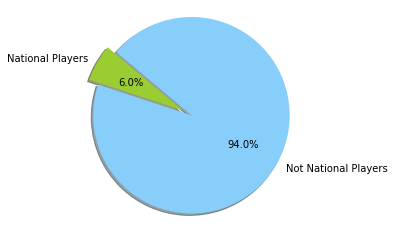

0    149905
1      9636
Name: national_player, dtype: int64

In [172]:
# data_fm
labels = 'National Players', 'Not National Players'
sizes = [data_fm.national_player.value_counts()[1], data_fm.national_player.value_counts()[0]]
colors = ['yellowgreen', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

data_fm.national_player.value_counts()

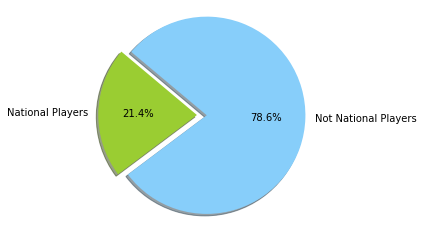

0.0    9909
1.0    2692
Name: national_player, dtype: int64

In [173]:

# data
labels = 'National Players', 'Not National Players'
sizes = [data.national_player.value_counts()[1], data.national_player.value_counts()[0]]
colors = ['yellowgreen', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

data.national_player.value_counts()

## Average Skill Value of National Players By Country

### Considering the following illustration, It is evident that the average skill level of the national players excessively varies from one country to another.
- 

In [27]:
import folium
world_heat_map_player_average_market_value_by_country = folium.Map(
    location=[28.220860, 16.297040],
    #tiles='Stamen Terrain',
    zoom_start=1.5
)
#  One of the following color brewer palettes: 
# ‘BuGn’, ‘BuPu’, ‘GnBu’, ‘OrRd’, ‘PuBu’, ‘PuBuGn’, ‘PuRd’, ‘RdPu’, ‘YlGn’, ‘YlGnBu’, ‘YlOrBr’, and ‘YlOrRd’

world_heat_map_player_average_market_value_by_country.choropleth(geo_data=world_countries_json_source, data=data_heat, columns=['country', 'average_overall_skill_of_players_by_country'], key_on='feature.properties.name',
                         fill_color='OrRd', fill_opacity=0.7,  line_opacity=0.2, nan_fill_color='black', nan_fill_opacity=0.2)

world_heat_map_player_average_market_value_by_country

/home/a/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## Outlier Treatment

#### As you can see below, some players have astronomical market values in comparison to other more 'modest' players.
Even displaying players with market value more than $20 millions, there are outliers and extreme instances.
Same is valid for 'Wage' and 'Release Clause' features.

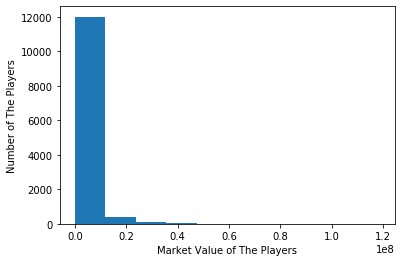

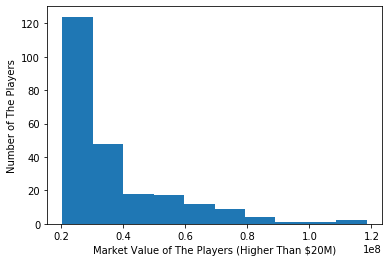

In [175]:
plt.hist(data['Value'])
plt.xlabel('Market Value of The Players')
plt.ylabel('Number of The Players')
plt.show()

plt.hist(data[data.Value > 20000000]['Value'])
plt.xlabel('Market Value of The Players (Higher Than $20M)')
plt.ylabel('Number of The Players')
plt.show()

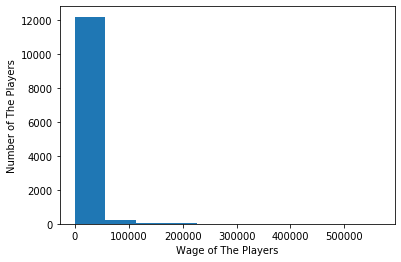

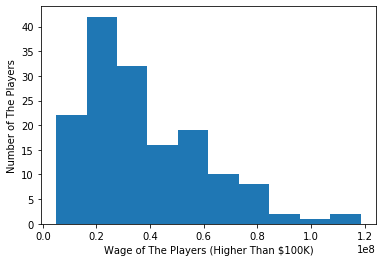

In [176]:
plt.hist(data['Wage'])
plt.xlabel('Wage of The Players')
plt.ylabel('Number of The Players')
plt.show()

plt.hist(data[data.Wage > 100000]['Value'])
plt.xlabel('Wage of The Players (Higher Than $100K)')
plt.ylabel('Number of The Players')
plt.show()

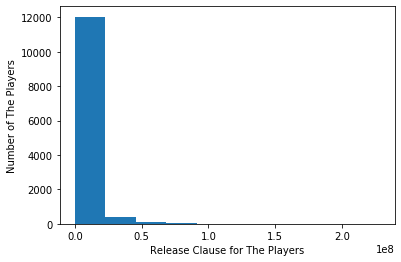

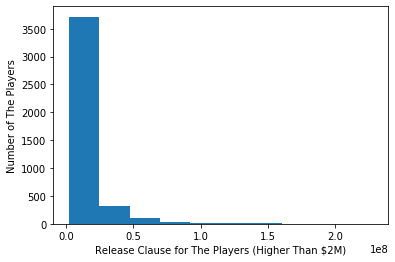

In [177]:
plt.hist(data['Release Clause'])
plt.xlabel('Release Clause for The Players')
plt.ylabel('Number of The Players')
plt.show()

plt.hist(data[data['Release Clause'] > 2000000]['Release Clause'])
plt.xlabel('Release Clause for The Players (Higher Than $2M)')
plt.ylabel('Number of The Players')
plt.show()

In [178]:
# Assign 0 market value and wages as the median of the series. 
# Because, 0 wage is unrealistic and may be misleading
numeric_columns_to_be_shrunk = ['Value', 'Wage']
for col in numeric_columns_to_be_shrunk:
    data[col] = data[col].apply(lambda x: data[col].median() if x==0.0 else x)

#### So we will shrink those features via logarithmic function in order to acquire a more meaningful set of values for the training.

In [179]:
numeric_columns_to_be_shrunk = ['Value', 'Wage', 'Release Clause']
for col in numeric_columns_to_be_shrunk:
    data[col+'_shrunk'] = data[col].apply(lambda x: math.log(x+0.01))

In [180]:
data = data.drop(numeric_columns_to_be_shrunk, axis=1)

In [181]:
data.head()

index  Age Nationality  Overall  Potential                 Club  Special  \
0      0   31   Argentina       94         94         FC Barcelona     2202   
1      1   33    Portugal       94         94             Juventus     2228   
2      2   26      Brazil       92         93  Paris Saint-Germain     2143   
3      3   27       Spain       91         93    Manchester United     1471   
4      4   27     Belgium       91         92      Manchester City     2281   

  Preferred Foot  International Reputation  Weak Foot  ...  GKHandling  \
0           Left                       5.0        4.0  ...        11.0   
1          Right                       5.0        4.0  ...        11.0   
2          Right                       5.0        5.0  ...         9.0   
3          Right                       4.0        3.0  ...        85.0   
4          Right                       4.0        5.0  ...        13.0   

  GKKicking GKPositioning GKReflexes  club_segment_point club_country  \
0      15.0          14.0        8.0                14.0        Spain   
1      15.0          14.0       11.0                14.0        Italy   
2      15.0          15.0       11.0                14.0       France   
3      87.0          88.0       94.0                13.0      England   
4       5.0          10.0       13.0                14.0      England   

  national_player  Value_shrunk  Wage_shrunk  Release Clause_shrunk  
0             1.0     18.520526    13.244581              19.238256  
1             1.0     18.159316    12.911642              18.660485  
2             1.0     18.590424    12.577636              19.245295  
3             1.0     18.092177    12.468437              18.747103  
4             1.0     18.440483    12.779873              19.095664  

[5 rows x 85 columns]

#### Shrunk Feature Histograms

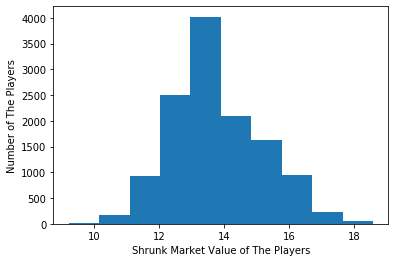

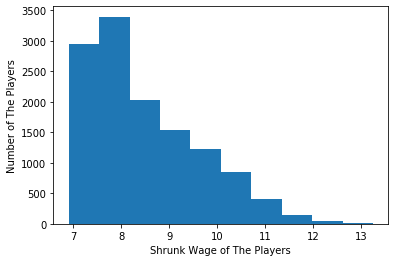

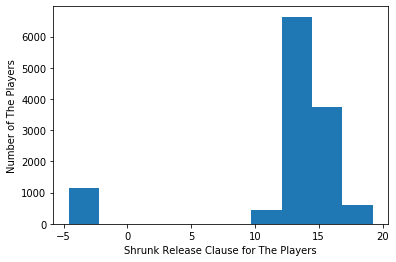

In [183]:
plt.hist(data['Value_shrunk'])
plt.xlabel('Shrunk Market Value of The Players')
plt.ylabel('Number of The Players')
plt.show()

plt.hist(data['Wage_shrunk'])
plt.xlabel('Shrunk Wage of The Players')
plt.ylabel('Number of The Players')
plt.show()

plt.hist(data['Release Clause_shrunk'])
plt.xlabel('Shrunk Release Clause for The Players')
plt.ylabel('Number of The Players')
plt.show()

## More Feature Creation

### Creating positionID by utilizing following columns

In [185]:
position_columns = ['LS', 'ST', 'RS', 'LW',
           'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM',
           'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB']

In [186]:
data[position_columns].head()

LS    ST    RS    LW    LF    CF    RF    RW   LAM   CAM  ...   LWB  \
0  90.0  90.0  90.0  94.0  95.0  95.0  95.0  94.0  95.0  95.0  ...  66.0   
1  94.0  94.0  94.0  92.0  93.0  93.0  93.0  92.0  91.0  91.0  ...  68.0   
2  87.0  87.0  87.0  92.0  92.0  92.0  92.0  92.0  92.0  92.0  ...  68.0   
3  60.0  60.0  60.0  62.0  62.0  62.0  62.0  62.0  62.0  62.0  ...  60.0   
4  85.0  85.0  85.0  90.0  90.0  90.0  90.0  90.0  91.0  91.0  ...  80.0   

    LDM   CDM   RDM   RWB    LB   LCB    CB   RCB    RB  
0  63.0  63.0  63.0  66.0  61.0  49.0  49.0  49.0  61.0  
1  64.0  64.0  64.0  68.0  64.0  56.0  56.0  56.0  64.0  
2  63.0  63.0  63.0  68.0  63.0  50.0  50.0  50.0  63.0  
3  60.0  60.0  60.0  60.0  60.0  59.0  59.0  59.0  60.0  
4  80.0  80.0  80.0  80.0  76.0  69.0  69.0  69.0  76.0  

[5 rows x 26 columns]

In [187]:
for col in position_columns:
    data[col] = data[col].apply(lambda x: x/100.0)

In [188]:
from sklearn.cluster import KMeans

X = np.array(data[position_columns])

kmeans = KMeans(n_clusters=11, random_state=0).fit(X)

for i in range(0, data.shape[0]):
    data.at[i, 'PositionID'] = kmeans.labels_[i]


In [189]:
data.head()

index  Age Nationality  Overall  Potential                 Club  Special  \
0      0   31   Argentina       94         94         FC Barcelona     2202   
1      1   33    Portugal       94         94             Juventus     2228   
2      2   26      Brazil       92         93  Paris Saint-Germain     2143   
3      3   27       Spain       91         93    Manchester United     1471   
4      4   27     Belgium       91         92      Manchester City     2281   

  Preferred Foot  International Reputation  Weak Foot  ...  GKKicking  \
0           Left                       5.0        4.0  ...       15.0   
1          Right                       5.0        4.0  ...       15.0   
2          Right                       5.0        5.0  ...       15.0   
3          Right                       4.0        3.0  ...       87.0   
4          Right                       4.0        5.0  ...        5.0   

  GKPositioning GKReflexes club_segment_point  club_country national_player  \
0          14.0        8.0               14.0         Spain             1.0   
1          14.0       11.0               14.0         Italy             1.0   
2          15.0       11.0               14.0        France             1.0   
3          88.0       94.0               13.0       England             1.0   
4          10.0       13.0               14.0       England             1.0   

  Value_shrunk  Wage_shrunk  Release Clause_shrunk  PositionID  
0    18.520526    13.244581              19.238256         3.0  
1    18.159316    12.911642              18.660485         3.0  
2    18.590424    12.577636              19.245295         3.0  
3    18.092177    12.468437              18.747103        10.0  
4    18.440483    12.779873              19.095664         8.0  

[5 rows x 86 columns]

#### newly created PositionID feature value distrubution

In [191]:
data.PositionID.value_counts()

10.0    2540
4.0     1535
1.0     1438
0.0     1435
5.0     1240
2.0      945
9.0      848
8.0      704
6.0      688
7.0      668
3.0      560
Name: PositionID, dtype: int64

### Here is the magical touch

## Creation of distance of each player's key features from his segment's mean, max and median
- A player has a value (market value), wage and release clause numeric features which we have already normalized and shrank.
- That features may indicate the player's importance to his national team.
- However, each national team has a different player profile at varying skills and importance. While Spain national team has plenty of talents, it is hard to say the same thing for Greenland. Two players with the resambling skills may be indispensible to a middling national team in their squad and may not be in even first 24 for another (top class national team).
- So the players' metrics should be investigated in the frame of their segment.
- In this work, segment refers to nationality and position in play of the player.

In [193]:
columns_for_segment_comparison = ['Value_shrunk', 'Wage_shrunk', 'Release Clause_shrunk']

for col in columns_for_segment_comparison:
    for i in range(0, data.shape[0]):
        data.at[i, 'DistanceToMaxInSegment_'+col] = data.at[i, col] - data[(data.Nationality == data.at[i, 'Nationality']) &  (data.PositionID == data.at[i, 'PositionID'])][col].max()
        data.at[i, 'DistanceToMedianInSegment_'+col] = data.at[i, col] - data[(data.Nationality == data.at[i, 'Nationality']) &  (data.PositionID == data.at[i, 'PositionID'])][col].median()

In [195]:
data = data.drop(['index'], axis=1)
data.tail()

Age Nationality  Overall  Potential              Club  Special  \
12596   18     England       47         67  Cambridge United     1285   
12597   18     England       47         65  Cambridge United     1250   
12598   18     England       47         64  Cambridge United     1325   
12599   18    Scotland       47         62      Swindon Town     1203   
12600   19     England       47         65   Crewe Alexandra     1307   

      Preferred Foot  International Reputation  Weak Foot  Skill Moves  ...  \
12596          Right                       1.0        3.0          2.0  ...   
12597           Left                       1.0        3.0          2.0  ...   
12598          Right                       1.0        3.0          2.0  ...   
12599           Left                       1.0        2.0          2.0  ...   
12600          Right                       1.0        2.0          2.0  ...   

      Value_shrunk Wage_shrunk Release Clause_shrunk  PositionID  \
12596    11.002100    6.907765             12.013701         7.0   
12597    10.819778    6.907765             11.686879         7.0   
12598    10.819778    6.907765             11.686879         7.0   
12599    11.002100    6.907765             11.870600         6.0   
12600    11.002100    6.907765             11.870600         7.0   

      DistanceToMaxInSegment_Value_shrunk  \
12596                           -3.401197   
12597                           -3.583519   
12598                           -3.583519   
12599                           -2.590267   
12600                           -3.401197   

      DistanceToMedianInSegment_Value_shrunk  \
12596                              -1.152679   
12597                              -1.335001   
12598                              -1.335001   
12599                              -1.152679   
12600                              -1.152679   

       DistanceToMaxInSegment_Wage_shrunk  \
12596                           -3.401188   
12597                           -3.401188   
12598                           -3.401188   
12599                           -1.945902   
12600                           -3.401188   

       DistanceToMedianInSegment_Wage_shrunk  \
12596                              -0.693142   
12597                              -0.693142   
12598                              -0.693142   
12599                               0.000000   
12600                              -0.693142   

       DistanceToMaxInSegment_Release Clause_shrunk  \
12596                                     -2.995732   
12597                                     -3.322554   
12598                                     -3.322554   
12599                                     -2.586764   
12600                                     -3.138833   

       DistanceToMedianInSegment_Release Clause_shrunk  
12596                                        -0.847298  
12597                                        -1.174120  
12598                                        -1.174120  
12599                                        -0.963726  
12600                                        -0.990399  

[5 rows x 91 columns]

### Checkpoint - 2

Save current state of the dataset

In [196]:
data.to_csv(r'fifa19_processed2.csv', index = False)

In [29]:
data = pd.read_csv('fifa19_processed2.csv')

#### drop 'International Reputation' to avoid a potential data leakage

In [30]:
data = data.drop(['International Reputation'], axis=1)

In [31]:
data['Weight'].fillna(value=data['Weight'].median(), inplace=True)

### Another Feature Which may contribute to model training: number_of_national_players_by_nation

In [32]:
number_of_national_players_by_nation = data.groupby("Nationality").national_player.sum()
data['number_of_national_players_by_nation'] = data['Nationality'].apply(lambda x: number_of_national_players_by_nation[x])

In [33]:
data.head(3)

Age Nationality  Overall  Potential                 Club  Special  \
0   31   Argentina       94         94         FC Barcelona     2202   
1   33    Portugal       94         94             Juventus     2228   
2   26      Brazil       92         93  Paris Saint-Germain     2143   

  Preferred Foot  Weak Foot  Skill Moves       Work Rate  ... Wage_shrunk  \
0           Left        4.0          4.0  Medium/ Medium  ...   13.244581   
1          Right        4.0          5.0       High/ Low  ...   12.911642   
2          Right        5.0          5.0    High/ Medium  ...   12.577636   

  Release Clause_shrunk  PositionID DistanceToMaxInSegment_Value_shrunk  \
0             19.238256         3.0                                 0.0   
1             18.660485         3.0                                 0.0   
2             19.245295         3.0                                 0.0   

  DistanceToMedianInSegment_Value_shrunk  DistanceToMaxInSegment_Wage_shrunk  \
0                               2.507791                            0.000000   
1                               1.862383                            0.000000   
2                               2.354792                           -0.159065   

   DistanceToMedianInSegment_Wage_shrunk  \
0                               3.158772   
1                               3.200985   
2                               2.451005   

   DistanceToMaxInSegment_Release Clause_shrunk  \
0                                           0.0   
1                                           0.0   
2                                           0.0   

   DistanceToMedianInSegment_Release Clause_shrunk  \
0                                         2.783688   
1                                         1.704215   
2                                         2.573909   

   number_of_national_players_by_nation  
0                                  97.0  
1                                  49.0  
2                                  28.0  

[3 rows x 91 columns]

## Normalization

### One Hot Encoder & MinMaxScaler

In [34]:
# gather non-numeric columns
non_numeric_columns = []
s = data.dtypes
for i in range(0, len(data.dtypes)):
    e = data.dtypes[i]
    if e!=float and e!=int:
        non_numeric_columns.append(s.index[i])

non_numeric_columns = non_numeric_columns + ['PositionID']
non_numeric_columns

['Nationality',
 'Club',
 'Preferred Foot',
 'Work Rate',
 'Body Type',
 'Position',
 'Loaned From',
 'Contract Valid Until',
 'club_country',
 'PositionID']

In [35]:
data['Loaned From'].value_counts()

unknown                   11642
Atalanta                     20
Sassuolo                     17
Juventus                     15
SL Benfica                   13
                          ...  
Lechia Gdańsk                 1
FC Nantes                     1
1. FC Köln                    1
Club Atlético Banfield        1
Club Atlético Tigre           1
Name: Loaned From, Length: 299, dtype: int64

In [36]:
data.iloc[70:76]

Age Nationality  Overall  Potential               Club  Special  \
70   23     Germany       85         88  FC Bayern München     2185   
71   27     Algeria       85         85    Manchester City     2031   
72   26     Austria       85         87  FC Bayern München     2261   
73   27      France       85         86            Arsenal     2060   
74   27      Greece       85         87               Roma     1642   
75   30   Argentina       85         85    Manchester City     1916   

   Preferred Foot  Weak Foot  Skill Moves       Work Rate  ... Wage_shrunk  \
70          Right        4.0          3.0       High/ Low  ...   11.429544   
71           Left        4.0          5.0  Medium/ Medium  ...   12.230765   
72           Left        4.0          3.0    High/ Medium  ...   11.608236   
73          Right        4.0          4.0      High/ High  ...   12.100712   
74          Right        2.0          2.0       Low/ High  ...   11.472104   
75          Right        3.0          2.0      High/ High  ...   12.043554   

   Release Clause_shrunk  PositionID DistanceToMaxInSegment_Value_shrunk  \
70             18.062576         8.0                           -0.635989   
71             18.131664         3.0                            0.000000   
72             17.999086         8.0                            0.000000   
73             18.303023         3.0                           -0.587787   
74             18.014215         1.0                            0.000000   
75             17.780126         4.0                            0.000000   

   DistanceToMedianInSegment_Value_shrunk  DistanceToMaxInSegment_Wage_shrunk  \
70                               1.398717                           -1.350329   
71                               1.477044                            0.000000   
72                               1.590414                            0.000000   
73                               1.609438                           -0.287682   
74                               3.847484                            0.000000   
75                               2.356652                            0.000000   

    DistanceToMedianInSegment_Wage_shrunk  \
70                               0.966849   
71                               1.767662   
72                               1.168101   
73                               1.609438   
74                               2.954908   
75                               2.938573   

    DistanceToMaxInSegment_Release Clause_shrunk  \
70                                     -0.807905   
71                                     -0.040555   
72                                      0.000000   
73                                     -0.625078   
74                                      0.000000   
75                                      0.000000   

    DistanceToMedianInSegment_Release Clause_shrunk  \
70                                         1.367867   
71                                         1.414732   
72                                         1.578723   
73                                         1.634023   
74                                         3.610918   
75                                         2.833734   

    number_of_national_players_by_nation  
70                                  52.0  
71                                  32.0  
72                                  36.0  
73                                  50.0  
74                                  33.0  
75                                  97.0  

[6 rows x 91 columns]

In [37]:
data = pd.get_dummies(data, columns=non_numeric_columns)

#### Scale data between 0.0 and 1.0 for each feature

In [38]:
scaler = MinMaxScaler()
for col in data.columns:
    data[col] = scaler.fit_transform(np.array(data[col]).reshape(-1, 1))

In [39]:
data.shape

(12601, 1300)

# Training The Model

### Split the data frame into 2 completely separate pieces, shuffle the rows and keep 2nd half for test

In [40]:

data_pos = data[data.national_player == 1.0]
data_neg = data[data.national_player == 0.0]

validation_spilt_ratio = 0.25

data_pos_0 = data_pos.sample(frac=validation_spilt_ratio)
data_pos_1 = data_pos.drop(data_pos_0.index)

data_neg_0 = data_neg.sample(frac=validation_spilt_ratio)
data_neg_1 = data_neg.drop(data_neg_0.index)

data_train = pd.concat([data_pos_1, data_neg_1], ignore_index=True)
data_train = data_train.sample(frac=1).reset_index(drop=True)
data_validation = pd.concat([data_pos_0, data_neg_0], ignore_index=True)
data_validation = data_validation.sample(frac=1).reset_index(drop=True)

In [41]:
data_validation.shape

(3150, 1300)

In [42]:

X = np.array(data_train.drop(['national_player'], 1)).astype(float)
y = np.array(data_train['national_player']).astype(float)

## Up-Sampling

In [43]:
def up_sample_minority_class(df, random_state, is_future_selection_to_be_made):
    # Entries of the both minority and majority classes
    data_majority = df.loc[df['national_player'] == 0.0]
    data_minority = df.loc[df['national_player'] == 1.0]
    
    print("data_majority: {0} @ data_minority: {1}".format(len(data_majority), len(data_minority)))
    
    #populates the minority portion of the samples up to the size of majority portion
    data_minority_up_sampled = resample(data_minority, 
                                     replace=True,
                                     n_samples=len(data_majority),
                                     random_state=random_state)
    
    # Combine majority class with upsampled minority class
    data_up_sampled = pd.concat([data_majority, data_minority_up_sampled])
    
    # Display new class counts
    print(data_up_sampled.national_player.value_counts())
    
    X_up_sampled = np.array(data_up_sampled.drop(['national_player'], 1).astype(float))
    y_up_sampled = np.array(data_up_sampled['national_player']).astype(float)
    
    if is_future_selection_to_be_made:
        X_up_sampled = SelectKBest(chi2, k=10).fit_transform(X_up_sampled, y_up_sampled)
    
    X_train_up_sampled, X_test_up_sampled, y_train_up_sampled, y_test_up_sampled = train_test_split(X_up_sampled, y_up_sampled, random_state=random_state)
    
    return X_train_up_sampled, X_test_up_sampled, y_train_up_sampled, y_test_up_sampled, X_up_sampled, y_up_sampled

In [44]:
#X = SelectKBest(chi2, k=40).fit_transform(X, y)

X_train, X_test, y_train, y_test, X, y = up_sample_minority_class(data_train, 28, False)
#train_test_split(X, y, test_size=0.25)

data_majority: 7432 @ data_minority: 2019
1.0    7432
0.0    7432
Name: national_player, dtype: int64


### Train model on training set and Display the Performance Matrics

In [45]:

# Tried Principal Component Analysis to make the calculations faster 
# and see if it improves the performance by any chance


# from sklearn.decomposition import PCA

# # feature extraction
# pca = PCA(n_components=X_train.shape[1]-0)
# fit = pca.fit(X_train)

# # # summarize components
# # #print("Explained Variance: %s" % fit.explained_variance_ratio_)
# # #print(fit.components_)

# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)





clf = RandomForestClassifier(max_depth=24, n_estimators=60, n_jobs=-2)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)


# threshold = 0.35

# prediction_probablities = clf.predict_proba(X_test)
# predictions = (prediction_probablities [:,1] >= threshold).astype('float')


print("\nAccuracy Score: {0}".format(accuracy_score(y_test, predictions)))
print("Precision Score: {0}".format(precision_score(y_test, predictions)))
print("Recall Score: {0}".format(recall_score(y_test, predictions)))
print("F-Beta Score: {0}".format(fbeta_score(y_test, predictions, beta=1.0)))


Accuracy Score: 0.9491388589881593
Precision Score: 0.925777331995988
Recall Score: 0.9782723900370959
F-Beta Score: 0.9513012110280855


## Validation

In [47]:

X_validation = np.array(data_validation.drop(['national_player'], 1)).astype(float)
y_validation = np.array(data_validation['national_player']).astype(float)


X_train_validation, X_test_validation, y_train_validation, y_test_validation, X_validation, y_validation = up_sample_minority_class(data_validation, 145, False)
#train_test_split(X_validation, y_validation, test_size=0.25)
#train_test_split(X, y, test_size=0.25)

# print("X_test_validation: "+str(X_test_validation.shape))


# X_test_validation = pca.transform(X_test_validation)

# print("X_test_validation: "+str(X_test_validation.shape))



predictions_validation = clf.predict(X_test_validation)


threshold = 0.33

prediction_probablities_validation = clf.predict_proba(X_test_validation)
predictions_validation = (prediction_probablities_validation [:,1] >= threshold).astype('float')


print("\nValidation Accuracy Score: {0}".format(accuracy_score(y_test_validation, predictions_validation)))
print("Validation Precision Score: {0}".format(precision_score(y_test_validation, predictions_validation)))
print("Validation Recall Score: {0}".format(recall_score(y_test_validation, predictions_validation)))
print("Validation F-Beta Score: {0}".format(fbeta_score(y_test_validation, predictions_validation, beta=2.0)))

data_majority: 2477 @ data_minority: 673
1.0    2477
0.0    2477
Name: national_player, dtype: int64

Validation Accuracy Score: 0.8393866020984665
Validation Precision Score: 0.7985185185185185
Validation Recall Score: 0.8953488372093024
Validation F-Beta Score: 0.8741485566007136


## Further Investigation False Prediction Distributions

In [48]:

prediction_probablities_validation = clf.predict_proba(X_test_validation)
predictions_validation = (prediction_probablities_validation [:,1] >= threshold).astype('float')


wrongly_predicted_sample_indices = []
for i in range(len(predictions_validation)):
    if predictions_validation[i] != y_test_validation[i]:
        wrongly_predicted_sample_indices.append(i)

len(wrongly_predicted_sample_indices)

199

In [49]:
data_y_test_validation = pd.DataFrame(data = y_test_validation[wrongly_predicted_sample_indices], columns = ['national_player']).reset_index()
data_X_test_validation = pd.DataFrame(data = X_test_validation[wrongly_predicted_sample_indices], columns = data.drop(['national_player'], axis = 1).columns).reset_index()
data_wrongly_predicted = pd.merge(data_X_test_validation, data_y_test_validation, how = 'left', left_index = True, right_index = True).drop(['index_x', 'index_y'], axis=1)

In [51]:
data_wrongly_predicted.head()

Age   Overall  Potential   Special  Weak Foot  Skill Moves  \
0  0.357143  0.553191   0.553191  0.527604       0.50         0.25   
1  0.392857  0.617021   0.595745  0.734003       0.50         0.75   
2  0.571429  0.553191   0.531915  0.246550       0.50         0.00   
3  0.428571  0.425532   0.404255  0.620452       0.75         0.50   
4  0.250000  0.510638   0.702128  0.291092       0.50         0.00   

   Jersey Number    Height    Weight        LS  ...  PositionID_2.0  \
0       0.010204  0.631579  0.495798  0.262295  ...             1.0   
1       0.091837  0.315789  0.201681  0.672131  ...             0.0   
2       0.000000  0.578947  0.554622  0.442623  ...             0.0   
3       0.102041  0.473684  0.310924  0.491803  ...             0.0   
4       0.112245  0.578947  0.478992  0.442623  ...             0.0   

   PositionID_3.0  PositionID_4.0  PositionID_5.0  PositionID_6.0  \
0             0.0             0.0             0.0             0.0   
1             1.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             0.0             0.0             0.0             0.0   
4             0.0             0.0             0.0             0.0   

   PositionID_7.0  PositionID_8.0  PositionID_9.0  PositionID_10.0  \
0             0.0             0.0             0.0              0.0   
1             0.0             0.0             0.0              0.0   
2             0.0             0.0             0.0              1.0   
3             0.0             0.0             0.0              1.0   
4             0.0             0.0             0.0              1.0   

   national_player  
0              0.0  
1              0.0  
2              0.0  
3              1.0  
4              0.0  

[5 rows x 1300 columns]

In [54]:
print("Age.mean for data_wrongly_predicted: {}, Age.mean for data_validation: {}"
      .format(data_wrongly_predicted.Age.mean(), data_validation.Age.mean()))

Age.mean for data_wrongly_predicted: 0.3962670495333812, Age.mean for data_validation: 0.33834467120181366


In [55]:
comparison_table = pd.DataFrame(None, columns = ['row_id'] + list(data.columns))

In [56]:
data_wrongly_predicted.name = 'data_wrongly_predicted'
data_validation.name = 'data_validation'


for df in [data_wrongly_predicted, data_validation]:
    s = df.mean()
    s['row_id'] = df.name + '.mean()'
    comparison_table = comparison_table.append(s, ignore_index=True)


for df in [data_wrongly_predicted, data_validation]:
    s = df.sum()
    s['row_id'] = df.name + '.sum()'
    comparison_table = comparison_table.append(s, ignore_index=True)

In [57]:
i = 4
comparison_table.iloc[:,i*20:(i+1)*20]

DistanceToMedianInSegment_Release Clause_shrunk  \
0                                         0.473960   
1                                         0.478582   
2                                        94.318104   
3                                      1507.533372   

   number_of_national_players_by_nation  Nationality_Afghanistan  \
0                              0.499042                 0.000000   
1                              0.550355                 0.000635   
2                             99.309278                 0.000000   
3                           1733.618557                 2.000000   

   Nationality_Albania  Nationality_Algeria  Nationality_Andorra  \
0             0.005025             0.000000             0.000000   
1             0.001587             0.002857             0.000317   
2             1.000000             0.000000             0.000000   
3             5.000000             9.000000             1.000000   

   Nationality_Angola  Nationality_Antigua & Barbuda  Nationality_Argentina  \
0            0.000000                       0.000000               0.060302   
1            0.000317                       0.000635               0.051429   
2            0.000000                       0.000000              12.000000   
3            1.000000                       2.000000             162.000000   

   Nationality_Armenia  Nationality_Australia  Nationality_Austria  \
0             0.005025               0.005025             0.015075   
1             0.000317               0.014921             0.014286   
2             1.000000               1.000000             3.000000   
3             1.000000              47.000000            45.000000   

   Nationality_Azerbaijan  Nationality_Barbados  Nationality_Belarus  \
0                     0.0                   0.0                  0.0   
1                     0.0                   0.0                  0.0   
2                     0.0                   0.0                  0.0   
3                     0.0                   0.0                  0.0   

   Nationality_Belgium  Nationality_Belize  Nationality_Benin  \
0             0.035176            0.000000           0.000000   
1             0.020000            0.000317           0.000635   
2             7.000000            0.000000           0.000000   
3            63.000000            1.000000           2.000000   

   Nationality_Bermuda  Nationality_Bolivia  
0                  0.0             0.000000  
1                  0.0             0.000317  
2                  0.0             0.000000  
3                  0.0             1.000000

In [58]:

for col in comparison_table.columns:
    if col in ['row_id']:
        comparison_table.at[4, col] = 'wrong_ratio/all_ratio'
        comparison_table.at[5, col] = 'wrong_count/all_count'
    elif comparison_table.at[1, col] != 0.0 and comparison_table.at[3, col] != 0.0:
        comparison_table.at[4, col] = comparison_table.at[0, col] / comparison_table.at[1, col]
        comparison_table.at[5, col] = comparison_table.at[2, col] / comparison_table.at[3, col]
        

In [59]:
comparison_table[['row_id', 'number_of_national_players_by_nation']]

row_id  number_of_national_players_by_nation
0  data_wrongly_predicted.mean()                              0.499042
1         data_validation.mean()                              0.550355
2   data_wrongly_predicted.sum()                             99.309278
3          data_validation.sum()                           1733.618557
4          wrong_ratio/all_ratio                              0.906763
5          wrong_count/all_count                              0.057284

### Let's create a comparison table for false predictions to better understand the variation and to detect potantial anomalies

In [61]:
comparison_table_T = comparison_table.T

In [62]:
comparison_table_T.head()

0                       1  \
row_id     data_wrongly_predicted.mean()  data_validation.mean()   
Age                             0.396267                0.338345   
Overall                         0.493852                0.429706   
Potential                        0.52133                 0.50485   
Special                         0.589324                0.545587   

                                      2                      3  \
row_id     data_wrongly_predicted.sum()  data_validation.sum()   
Age                             78.8571                1065.79   
Overall                         98.2766                1353.57   
Potential                       103.745                1590.28   
Special                         117.275                 1718.6   

                               4                      5  
row_id     wrong_ratio/all_ratio  wrong_count/all_count  
Age                      1.17119              0.0739897  
Overall                  1.14928              0.0726052  
Potential                1.03264              0.0652369  
Special                  1.08016               0.068239

In [63]:
comparison_table_T.columns = list(np.array(comparison_table_T[:1]))[0]

In [64]:
comparison_table_T.shape

(1301, 6)

In [65]:
comparison_table_T.head()

data_wrongly_predicted.mean()  data_validation.mean()  \
row_id     data_wrongly_predicted.mean()  data_validation.mean()   
Age                             0.396267                0.338345   
Overall                         0.493852                0.429706   
Potential                        0.52133                 0.50485   
Special                         0.589324                0.545587   

           data_wrongly_predicted.sum()  data_validation.sum()  \
row_id     data_wrongly_predicted.sum()  data_validation.sum()   
Age                             78.8571                1065.79   
Overall                         98.2766                1353.57   
Potential                       103.745                1590.28   
Special                         117.275                 1718.6   

           wrong_ratio/all_ratio  wrong_count/all_count  
row_id     wrong_ratio/all_ratio  wrong_count/all_count  
Age                      1.17119              0.0739897  
Overall                  1.14928              0.0726052  
Potential                1.03264              0.0652369  
Special                  1.08016               0.068239

In [66]:
comparison_table_T = comparison_table_T.drop(comparison_table_T.index[0])
comparison_table_T.head()

data_wrongly_predicted.mean() data_validation.mean()  \
Age                            0.396267               0.338345   
Overall                        0.493852               0.429706   
Potential                       0.52133                0.50485   
Special                        0.589324               0.545587   
Weak Foot                      0.515075               0.490952   

          data_wrongly_predicted.sum() data_validation.sum()  \
Age                            78.8571               1065.79   
Overall                        98.2766               1353.57   
Potential                      103.745               1590.28   
Special                        117.275                1718.6   
Weak Foot                        102.5                1546.5   

          wrong_ratio/all_ratio wrong_count/all_count  
Age                     1.17119             0.0739897  
Overall                 1.14928             0.0726052  
Potential               1.03264             0.0652369  
Special                 1.08016              0.068239  
Weak Foot               1.04914             0.0662787

In [67]:
comparison_table_T = comparison_table_T.dropna( how='any')

In [68]:
comparison_table_T.head()

data_wrongly_predicted.mean() data_validation.mean()  \
Age                            0.396267               0.338345   
Overall                        0.493852               0.429706   
Potential                       0.52133                0.50485   
Special                        0.589324               0.545587   
Weak Foot                      0.515075               0.490952   

          data_wrongly_predicted.sum() data_validation.sum()  \
Age                            78.8571               1065.79   
Overall                        98.2766               1353.57   
Potential                      103.745               1590.28   
Special                        117.275                1718.6   
Weak Foot                        102.5                1546.5   

          wrong_ratio/all_ratio wrong_count/all_count  
Age                     1.17119             0.0739897  
Overall                 1.14928             0.0726052  
Potential               1.03264             0.0652369  
Special                 1.08016              0.068239  
Weak Foot               1.04914             0.0662787

In [70]:
comparison_table_T = comparison_table_T.sort_values(by=['data_wrongly_predicted.sum()'], ascending=False)

In [76]:
i=5
comparison_table_T.iloc[10*i:10*(i+1),:]

data_wrongly_predicted.mean() data_validation.mean()  \
Potential                           0.52133                0.50485   
Finishing                          0.517534               0.476986   
Marking                            0.517201               0.497401   
LCM                                0.517059               0.476447   
CM                                 0.517059               0.476447   
RCM                                0.517059               0.476447   
Curve                              0.516617               0.481454   
Weak Foot                          0.515075               0.490952   
Height                             0.508596               0.500819   
Interceptions                      0.508531               0.482887   

              data_wrongly_predicted.sum() data_validation.sum()  \
Potential                          103.745               1590.28   
Finishing                          102.989               1502.51   
Marking                            102.923               1566.81   
LCM                                102.895               1500.81   
CM                                 102.895               1500.81   
RCM                                102.895               1500.81   
Curve                              102.807               1516.58   
Weak Foot                            102.5                1546.5   
Height                             101.211               1577.58   
Interceptions                      101.198               1521.09   

              wrong_ratio/all_ratio wrong_count/all_count  
Potential                   1.03264             0.0652369  
Finishing                   1.08501              0.068545  
Marking                     1.03981             0.0656894  
LCM                         1.08524             0.0685596  
CM                          1.08524             0.0685596  
RCM                         1.08524             0.0685596  
Curve                       1.07304             0.0677886  
Weak Foot                   1.04914             0.0662787  
Height                      1.01553             0.0641556  
Interceptions               1.05311             0.0665296

In [72]:
contribution_to_wrong_predicitons = 0
count = 0
for col in comparison_table_T.index:
    if 'Nationality_' in col and comparison_table_T['wrong_ratio/all_ratio'][col] > 1.1:
        print("col: {}  ---  {}  ---  {}".format( col,  comparison_table_T['data_wrongly_predicted.sum()'][col] ,  comparison_table_T['wrong_ratio/all_ratio'][col] )) 
        contribution_to_wrong_predicitons += comparison_table_T['data_wrongly_predicted.sum()'][col]
        count = count + 1


col: Nationality_Argentina  ---  12.0  ---  1.1725293132328307
col: Nationality_Chile  ---  10.0  ---  1.9786432160804022
col: Nationality_Brazil  ---  7.0  ---  1.758793969849246
col: Nationality_Belgium  ---  7.0  ---  1.758793969849246
col: Nationality_Norway  ---  7.0  ---  1.5829145728643215
col: Nationality_Morocco  ---  6.0  ---  7.305759567066099
col: Nationality_Portugal  ---  6.0  ---  1.8264398917665248
col: Nationality_Scotland  ---  6.0  ---  1.758793969849246
col: Nationality_Denmark  ---  5.0  ---  1.2366520100502514
col: Nationality_South Africa  ---  4.0  ---  4.522613065326634
col: Nationality_Faroe Islands  ---  4.0  ---  21.105527638190956
col: Nationality_Switzerland  ---  4.0  ---  1.623502126014689
col: Nationality_Wales  ---  3.0  ---  1.4839824120603013
col: Nationality_Slovenia  ---  3.0  ---  3.165829145728643
col: Nationality_Ivory Coast  ---  3.0  ---  2.499338799259455
col: Nationality_Serbia  ---  3.0  ---  1.8264398917665248
col: Nationality_Canada  --- 

In [73]:
i=5
comparison_table.iloc[:10,15*i:15*(i+1)]

DistanceToMaxInSegment_Value_shrunk  \
0                             0.790197   
1                             0.754463   
2                           157.249219   
3                          2376.557761   
4                             1.047364   
5                             0.066167   

   DistanceToMedianInSegment_Value_shrunk  DistanceToMaxInSegment_Wage_shrunk  \
0                                0.495306                            0.732457   
1                                0.481872                            0.668503   
2                               98.565823                          145.758892   
3                             1517.895649                         2105.784105   
4                                1.027879                            1.095667   
5                                0.064936                            0.069218   

   DistanceToMedianInSegment_Wage_shrunk  \
0                               0.497052   
1                               0.468103   
2                              98.913446   
3                            1474.525768   
4                               1.061843   
5                               0.067082   

   DistanceToMaxInSegment_Release Clause_shrunk  \
0                                      0.849730   
1                                      0.847755   
2                                    169.096194   
3                                   2670.429653   
4                                      1.002329   
5                                      0.063322   

   DistanceToMedianInSegment_Release Clause_shrunk  \
0                                         0.473960   
1                                         0.478582   
2                                        94.318104   
3                                      1507.533372   
4                                         0.990343   
5                                         0.062565   

   number_of_national_players_by_nation  Nationality_Afghanistan  \
0                              0.499042                 0.000000   
1                              0.550355                 0.000635   
2                             99.309278                 0.000000   
3                           1733.618557                 2.000000   
4                              0.906763                 0.000000   
5                              0.057284                 0.000000   

   Nationality_Albania  Nationality_Algeria  Nationality_Andorra  \
0             0.005025             0.000000             0.000000   
1             0.001587             0.002857             0.000317   
2             1.000000             0.000000             0.000000   
3             5.000000             9.000000             1.000000   
4             3.165829             0.000000             0.000000   
5             0.200000             0.000000             0.000000   

   Nationality_Angola  Nationality_Antigua & Barbuda  Nationality_Argentina  \
0            0.000000                       0.000000               0.060302   
1            0.000317                       0.000635               0.051429   
2            0.000000                       0.000000              12.000000   
3            1.000000                       2.000000             162.000000   
4            0.000000                       0.000000               1.172529   
5            0.000000                       0.000000               0.074074   

   Nationality_Armenia  
0             0.005025  
1             0.000317  
2             1.000000  
3             1.000000  
4            15.829146  
5             1.000000

In [74]:
data_wrongly_predicted.head()

Age   Overall  Potential   Special  Weak Foot  Skill Moves  \
0  0.357143  0.553191   0.553191  0.527604       0.50         0.25   
1  0.392857  0.617021   0.595745  0.734003       0.50         0.75   
2  0.571429  0.553191   0.531915  0.246550       0.50         0.00   
3  0.428571  0.425532   0.404255  0.620452       0.75         0.50   
4  0.250000  0.510638   0.702128  0.291092       0.50         0.00   

   Jersey Number    Height    Weight        LS  ...  PositionID_2.0  \
0       0.010204  0.631579  0.495798  0.262295  ...             1.0   
1       0.091837  0.315789  0.201681  0.672131  ...             0.0   
2       0.000000  0.578947  0.554622  0.442623  ...             0.0   
3       0.102041  0.473684  0.310924  0.491803  ...             0.0   
4       0.112245  0.578947  0.478992  0.442623  ...             0.0   

   PositionID_3.0  PositionID_4.0  PositionID_5.0  PositionID_6.0  \
0             0.0             0.0             0.0             0.0   
1             1.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             0.0             0.0             0.0             0.0   
4             0.0             0.0             0.0             0.0   

   PositionID_7.0  PositionID_8.0  PositionID_9.0  PositionID_10.0  \
0             0.0             0.0             0.0              0.0   
1             0.0             0.0             0.0              0.0   
2             0.0             0.0             0.0              1.0   
3             0.0             0.0             0.0              1.0   
4             0.0             0.0             0.0              1.0   

   national_player  
0              0.0  
1              0.0  
2              0.0  
3              1.0  
4              0.0  

[5 rows x 1300 columns]

## Conclusion And Findings

In [ ]:
#TODO